In [19]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math
#import numdifftools as nd
import pandas as pd
#import pymc3 as pm

from tqdm import tqdm
from sklearn import preprocessing
from numpy.linalg import multi_dot
import scipy
import scipy.stats as ss
from scipy.stats import invgamma
from scipy.special import gamma
from scipy.special import digamma
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import levy_stable
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import sklearn.mixture
from scipy.linalg import sqrtm

import logging
import warnings
from functools import partial

logger = logging.getLogger(__name__)

In [20]:
from f_mean_adjust_ss_toad import (toad, compute_summaries, compute_summaries_stacked, mean_adjustment_summary_statistics)

In [21]:
true_theta = np.array([1.7, 35.0, 0.6])

In [22]:
actual_data = toad(true_theta[0], true_theta[1], true_theta[2])
actual_data

array([[[   0.        ],
        [   0.        ],
        [   0.        ],
        ...,
        [   0.        ],
        [   0.        ],
        [   0.        ]],

       [[   0.        ],
        [   0.        ],
        [ -14.01527519],
        ...,
        [   0.        ],
        [  -6.22701743],
        [   0.        ]],

       [[   0.        ],
        [ -28.79181619],
        [ -14.01527519],
        ...,
        [ -65.02169379],
        [  28.90819599],
        [ -23.57255448]],

       ...,

       [[   0.        ],
        [ 192.50212781],
        [  60.61116724],
        ...,
        [ 372.58641177],
        [ -66.80163653],
        [ -23.57255448]],

       [[ 110.18125647],
        [   0.        ],
        [  60.61116724],
        ...,
        [ 331.13571401],
        [ -84.63789157],
        [   6.56205816]],

       [[ 126.46951787],
        [-213.03671282],
        [  60.61116724],
        ...,
        [-146.22020668],
        [ -14.20314576],
        [  27.84299764]]

In [23]:
lags = [1, 2, 4, 8]
num_coeffs = 3
num_latent = 12
num_datasets = 200
n_samples = 500
sigma_latent = 1
sigma_theta = 10
eps_precision = 100

In [24]:
actual_summary_statistics = compute_summaries_stacked(actual_data, lags)[0]
actual_summary_statistics

array([6.8721281 , 3.65252581, 6.9502917 , 6.73578001, 3.90477488,
       6.98060912, 6.70686234, 3.93844869, 6.97901779, 6.56667243,
       3.96014453, 6.96194709])

In [25]:
#Store the values for consistency
actual_summary_statistics = np.array([6.9246124 , 3.66996993, 6.30071171, 6.7178047 , 3.91656951,
       6.31433913, 6.66185474, 4.03792021, 6.47012367, 6.50578406,
       4.0408775 , 6.33987272])

In [26]:
def my_inv(x):
    return np.linalg.inv(x + (np.eye(x.shape[0]) * 1e-7))

In [27]:
from multiprocessing import Pool
from functools import partial
pool = Pool(12)

In [28]:
# Functions must be imported for multiprocessing to work
from f_gradient_lb_mean_nuissance_toad import (fun_gradient_lb)

In [29]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 200 # number of datasets
        self.num_coeffs = 3 # number of coeffs
        self.lambda_dim = self.num_coeffs + int((self.num_coeffs * (self.num_coeffs + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:self.num_coeffs])
        c_vech_l = np.array(c[self.num_coeffs:])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        # mu_0 = np.array([np.log((true_theta[0] - 1)/(2 - true_theta[0])),np.log((true_theta[1] - 0)/(100 - true_theta[1])),np.log((true_theta[2] - 0)/(0.9 - true_theta[2]))])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        mu_0 = np.array([0] * self.num_coeffs)
        # l_0 = np.array([[ 3.94992238, -2.12969451,  0.47239626],
        #                 [-2.12969451, 21.85908684, -1.45228054],
        #                 [ 0.47239626, -1.45228054, 15.84326737]])
        l_0 = np.tril(np.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = np.linalg.inv(Sigma_0_inv)
        l_0_inv = np.linalg.inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices(self.num_coeffs)]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                # List of gradients
                Gradient_lb_init = []
                lb_0 = []
                theta_0_samples = multivariate_normal.rvs(mean = mu_0, cov = Sigma_0, size = self.samples)
                # Multiprocessing a function with several inputs
                results = pool.map(partial(fun_gradient_lb, theta_samples = theta_0_samples, mu_q = mu_0, l_q = l_0, c = 0, n_datasets= self.num_datasets, num_coeffs = self.num_coeffs, num_latent = num_latent, actual_summary_statistics = self.actual_summary_statistics), np.arange(self.samples)) 
                results = np.reshape(results, (self.samples, 4))
                Gradient_lb_init = results[:,0]
                lb_0 = results[:,1]
                Flattened_gradient_lb = results[:,2]
                Flattened_gradient_log_q = results[:,3]

                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  np.linalg.inv(Sigma_q_inv)
                l_q_inv =  np.linalg.inv(l_q)
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = multivariate_normal.rvs(mean = mu_q, cov = Sigma_q, size = self.samples)
                
                # Multiprocessing a function with several inputs
                results = pool.map(partial(fun_gradient_lb, theta_samples = theta_q_samples, mu_q = mu_q, l_q = l_q, c = c, n_datasets= self.num_datasets, num_coeffs = self.num_coeffs, num_latent = num_latent, actual_summary_statistics = self.actual_summary_statistics), np.arange(self.samples)) 
                results = np.reshape(results, (self.samples, 4))
                Gradient_lb = results[:,0]
                lb_t = results[:,1]
                Flattened_gradient_lb = results[:,2]
                Flattened_gradient_log_q = results[:,3]

                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)

                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

In [30]:
# Set hyperparameters
stop = 5000
vb = GVB(200, actual_summary_statistics, 0.005, 2500, 100, 0.9, 0.9, 50, 50)
LB_estimate, smoothed_LB_estimate, best_lambda = vb.vb_posterior(stop)

  0%|          | 0/5000 [00:00<?, ?it/s]c:\Users\nngu8343\AppData\Local\miniconda3\envs\vbsl\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
  0%|          | 1/5000 [02:04<173:29:25, 124.94s/it]

LB -15.657171706460066


  0%|          | 2/5000 [03:42<151:01:07, 108.78s/it]

LB -15.499226127804963


  0%|          | 3/5000 [05:50<163:07:23, 117.52s/it]

LB -15.716131570269063


  0%|          | 4/5000 [08:08<174:22:50, 125.65s/it]

LB -15.877299396235935


  0%|          | 5/5000 [10:44<189:24:20, 136.51s/it]

LB -15.710128111873304


  0%|          | 6/5000 [12:47<183:10:15, 132.04s/it]

LB -15.681928143683146


  0%|          | 7/5000 [14:34<171:54:44, 123.95s/it]

LB -15.731100738355426


  0%|          | 8/5000 [16:21<164:22:18, 118.54s/it]

LB -15.726825336180331


  0%|          | 9/5000 [17:54<152:56:18, 110.31s/it]

LB -15.923564227609734


  0%|          | 10/5000 [19:54<157:11:08, 113.40s/it]

LB -15.785818779550176


  0%|          | 11/5000 [21:32<150:29:09, 108.59s/it]

LB -15.71329552410156


  0%|          | 12/5000 [24:18<174:47:24, 126.15s/it]

LB -15.547902658298385


  0%|          | 13/5000 [27:40<206:46:37, 149.27s/it]

LB -15.772156109234986


  0%|          | 14/5000 [30:50<223:50:53, 161.62s/it]

LB -15.510431255396504


  0%|          | 15/5000 [33:51<231:40:08, 167.30s/it]

LB -15.650274707456195


  0%|          | 16/5000 [35:30<203:09:59, 146.75s/it]

LB -15.666521934121251


  0%|          | 17/5000 [37:27<190:50:56, 137.88s/it]

LB -15.307654900339362


  0%|          | 18/5000 [40:15<203:19:36, 146.92s/it]

LB -15.6621158590559


  0%|          | 19/5000 [43:06<213:11:36, 154.08s/it]

LB -15.403212096746879


  0%|          | 20/5000 [45:46<215:28:29, 155.76s/it]

LB -15.45498507872194


  0%|          | 21/5000 [48:20<214:56:58, 155.42s/it]

LB -15.504571644575911


  0%|          | 22/5000 [49:48<187:01:24, 135.25s/it]

LB -15.521819003340893


  0%|          | 23/5000 [51:20<169:00:55, 122.25s/it]

LB -15.426590293031104


  0%|          | 24/5000 [52:47<154:07:52, 111.51s/it]

LB -15.477210594212423


  0%|          | 25/5000 [54:12<143:10:36, 103.61s/it]

LB -15.413485242828779


  1%|          | 26/5000 [55:43<137:55:40, 99.83s/it] 

LB -15.271413756386034


  1%|          | 27/5000 [57:03<129:51:17, 94.00s/it]

LB -15.573229096130325


  1%|          | 28/5000 [58:37<129:31:05, 93.78s/it]

LB -15.354006423006028


  1%|          | 29/5000 [59:57<123:51:05, 89.69s/it]

LB -15.487389589664435


  1%|          | 30/5000 [1:01:53<134:53:52, 97.71s/it]

LB -15.49598416179974


  1%|          | 31/5000 [1:04:25<157:21:08, 114.00s/it]

LB -15.341752178708168


  1%|          | 32/5000 [1:06:56<172:33:53, 125.05s/it]

LB -15.130590511211402


  1%|          | 33/5000 [1:09:21<180:38:54, 130.93s/it]

LB -15.308573861414525


  1%|          | 34/5000 [1:12:05<194:18:56, 140.87s/it]

LB -15.243647110218125


  1%|          | 35/5000 [1:14:49<203:57:54, 147.89s/it]

LB -15.484112256169949


  1%|          | 36/5000 [1:17:40<213:16:30, 154.67s/it]

LB -15.320475030204445


  1%|          | 37/5000 [1:20:20<215:41:50, 156.46s/it]

LB -15.45372027420489


  1%|          | 38/5000 [1:23:03<218:10:26, 158.29s/it]

LB -15.280053352912752


  1%|          | 39/5000 [1:25:34<215:20:13, 156.26s/it]

LB -15.145480530967747


  1%|          | 40/5000 [1:27:57<209:48:46, 152.28s/it]

LB -15.29881760706045


  1%|          | 41/5000 [4:37:27<4845:14:25, 3517.42s/it]

LB -14.921517208526943


  1%|          | 42/5000 [4:38:39<3420:38:51, 2483.73s/it]

LB -15.173966075805433


  1%|          | 43/5000 [4:39:45<2421:14:16, 1758.41s/it]

LB -15.212458413544402


  1%|          | 44/5000 [4:40:49<1721:19:34, 1250.36s/it]

LB -15.12929371076455


  1%|          | 45/5000 [4:42:04<1235:30:04, 897.64s/it] 

LB -15.12629924823042


  1%|          | 46/5000 [4:43:22<896:39:40, 651.59s/it] 

LB -15.11274956482257


  1%|          | 47/5000 [4:44:47<662:39:11, 481.64s/it]

LB -15.059229770674035


  1%|          | 48/5000 [4:46:05<496:16:06, 360.78s/it]

LB -15.069523193045915


  1%|          | 49/5000 [4:47:18<377:07:25, 274.22s/it]

LB -15.0467350627545


  1%|          | 50/5000 [4:48:28<292:59:23, 213.08s/it]

LB -15.145523133025357


  1%|          | 51/5000 [4:49:36<233:07:40, 169.58s/it]

LB Smoothed -15.425934499066884


  1%|          | 52/5000 [4:50:51<193:53:41, 141.07s/it]

LB Smoothed -15.411904913403395


  1%|          | 53/5000 [4:51:59<163:59:04, 119.33s/it]

LB Smoothed -15.399424490958381


  1%|          | 54/5000 [4:53:15<146:05:55, 106.34s/it]

LB Smoothed -15.381409744702674


  1%|          | 55/5000 [4:54:26<131:16:02, 95.56s/it] 

LB Smoothed -15.3674111042195


  1%|          | 56/5000 [4:55:39<121:51:29, 88.73s/it]

LB Smoothed -15.359104368970875


  1%|          | 57/5000 [4:56:51<115:17:59, 83.97s/it]

LB Smoothed -15.33688289346917


  1%|          | 58/5000 [4:58:03<110:08:09, 80.23s/it]

LB Smoothed -15.319174246268837


  1%|          | 59/5000 [4:59:21<109:05:52, 79.49s/it]

LB Smoothed -15.299110360458501


  1%|          | 60/5000 [5:00:32<105:45:26, 77.07s/it]

LB Smoothed -15.281332927763758


  1%|          | 61/5000 [5:01:49<105:33:32, 76.94s/it]

LB Smoothed -15.26540873973911


  1%|          | 62/5000 [5:03:04<104:59:15, 76.54s/it]

LB Smoothed -15.251284704280305


  1%|▏         | 63/5000 [5:04:16<103:00:18, 75.11s/it]

LB Smoothed -15.233803431029603


  1%|▏         | 64/5000 [5:05:35<104:42:42, 76.37s/it]

LB Smoothed -15.220673841741872


  1%|▏         | 65/5000 [5:06:44<101:36:54, 74.13s/it]

LB Smoothed -15.201862203462134


  1%|▏         | 66/5000 [5:08:00<102:03:03, 74.46s/it]

LB Smoothed -15.18682802805971


  1%|▏         | 67/5000 [5:09:14<101:55:52, 74.39s/it]

LB Smoothed -15.178044862095769


  1%|▏         | 68/5000 [5:10:25<100:31:07, 73.37s/it]

LB Smoothed -15.16322812506301


  1%|▏         | 69/5000 [5:11:40<101:26:28, 74.06s/it]

LB Smoothed -15.150751979823454


  1%|▏         | 70/5000 [5:12:52<100:13:01, 73.18s/it]

LB Smoothed -15.136134474600164


  1%|▏         | 71/5000 [5:14:11<102:41:25, 75.00s/it]

LB Smoothed -15.122144442500645


  1%|▏         | 72/5000 [5:15:23<101:19:35, 74.02s/it]

LB Smoothed -15.106853893711557


  1%|▏         | 73/5000 [5:16:40<102:42:42, 75.05s/it]

LB Smoothed -15.098521980106854


  1%|▏         | 74/5000 [5:17:53<101:41:38, 74.32s/it]

LB Smoothed -15.082073032061537


  2%|▏         | 75/5000 [5:19:04<100:29:15, 73.45s/it]

LB Smoothed -15.071653887875073


  2%|▏         | 76/5000 [5:20:19<101:16:32, 74.04s/it]

LB Smoothed -15.058609770330175


  2%|▏         | 77/5000 [5:21:33<101:05:24, 73.92s/it]

LB Smoothed -15.043518789316856


  2%|▏         | 78/5000 [5:22:48<101:35:51, 74.31s/it]

LB Smoothed -15.03202240783931


  2%|▏         | 79/5000 [5:23:58<99:39:34, 72.91s/it] 

LB Smoothed -15.018812009173931


  2%|▏         | 80/5000 [5:25:18<102:27:45, 74.97s/it]

LB Smoothed -15.005770592123993


  2%|▏         | 81/5000 [5:26:26<99:53:28, 73.11s/it] 

LB Smoothed -14.996815718944193


  2%|▏         | 82/5000 [5:27:43<101:16:26, 74.13s/it]

LB Smoothed -14.984765429161104


  2%|▏         | 83/5000 [5:28:56<100:56:01, 73.90s/it]

LB Smoothed -14.971248490343509


  2%|▏         | 84/5000 [5:30:08<100:00:21, 73.23s/it]

LB Smoothed -14.96460087617522


  2%|▏         | 85/5000 [5:31:25<101:24:40, 74.28s/it]

LB Smoothed -14.946955954273799


  2%|▏         | 86/5000 [5:32:35<99:38:32, 73.00s/it] 

LB Smoothed -14.936024335766389


  2%|▏         | 87/5000 [5:33:53<101:40:19, 74.50s/it]

LB Smoothed -14.920253593377863


  2%|▏         | 88/5000 [5:35:04<100:14:43, 73.47s/it]

LB Smoothed -14.912139314352011


  2%|▏         | 89/5000 [5:36:21<101:33:35, 74.45s/it]

LB Smoothed -14.907296177001232


  2%|▏         | 90/5000 [5:37:36<101:46:28, 74.62s/it]

LB Smoothed -14.898317836409062


  2%|▏         | 91/5000 [5:38:55<103:50:23, 76.15s/it]

LB Smoothed -14.896794274068968


  2%|▏         | 92/5000 [5:40:05<101:09:35, 74.20s/it]

LB Smoothed -14.888794265534571


  2%|▏         | 93/5000 [5:41:16<99:50:42, 73.25s/it] 

LB Smoothed -14.881917981243431


  2%|▏         | 94/5000 [5:42:31<100:28:05, 73.72s/it]

LB Smoothed -14.873295707995272


  2%|▏         | 95/5000 [5:43:38<97:35:06, 71.62s/it] 

LB Smoothed -14.862216850222495


  2%|▏         | 96/5000 [5:44:51<98:17:00, 72.15s/it]

LB Smoothed -14.857158894809626


  2%|▏         | 97/5000 [5:46:00<97:10:00, 71.34s/it]

LB Smoothed -14.85541204797672


  2%|▏         | 98/5000 [5:47:17<99:06:14, 72.78s/it]

LB Smoothed -14.849505680388674


  2%|▏         | 99/5000 [5:48:31<99:44:04, 73.26s/it]

LB Smoothed -14.842442134043576


  2%|▏         | 100/5000 [5:49:47<100:42:24, 73.99s/it]

LB Smoothed -14.838583219566445


  2%|▏         | 101/5000 [5:51:02<101:12:41, 74.37s/it]

LB Smoothed -14.838015045647587


  2%|▏         | 102/5000 [5:52:17<101:33:57, 74.65s/it]

LB Smoothed -14.8310429173835


  2%|▏         | 103/5000 [5:53:34<102:14:43, 75.17s/it]

LB Smoothed -14.82365298823096


  2%|▏         | 104/5000 [5:54:42<99:20:38, 73.05s/it] 

LB Smoothed -14.814697945872467


  2%|▏         | 105/5000 [5:56:37<116:41:02, 85.81s/it]

LB Smoothed -14.801093212094438


  2%|▏         | 106/5000 [5:59:08<143:11:43, 105.33s/it]

LB Smoothed -14.804499120846005


  2%|▏         | 107/5000 [6:01:33<159:23:21, 117.27s/it]

LB Smoothed -14.800072785562232


  2%|▏         | 108/5000 [6:03:57<170:10:23, 125.23s/it]

LB Smoothed -14.792284718846394


  2%|▏         | 109/5000 [6:06:25<179:13:19, 131.92s/it]

LB Smoothed -14.78668963840809


  2%|▏         | 110/5000 [6:08:53<186:07:23, 137.02s/it]

LB Smoothed -14.778794532089371


  2%|▏         | 111/5000 [6:11:22<190:53:28, 140.56s/it]

LB Smoothed -14.777837802777192


  2%|▏         | 112/5000 [6:13:49<193:28:41, 142.50s/it]

LB Smoothed -14.774510317942532


  2%|▏         | 113/5000 [6:16:27<199:38:11, 147.06s/it]

LB Smoothed -14.767041077422487


  2%|▏         | 114/5000 [6:19:07<204:50:00, 150.92s/it]

LB Smoothed -14.769547772690649


  2%|▏         | 115/5000 [6:21:36<203:54:18, 150.27s/it]

LB Smoothed -14.76324926990541


  2%|▏         | 116/5000 [6:23:59<200:53:42, 148.08s/it]

LB Smoothed -14.761195450195798


  2%|▏         | 117/5000 [6:26:19<197:53:12, 145.89s/it]

LB Smoothed -14.754779588853594


  2%|▏         | 118/5000 [6:28:39<195:12:09, 143.94s/it]

LB Smoothed -14.751136961761272


  2%|▏         | 119/5000 [6:31:00<194:13:12, 143.25s/it]

LB Smoothed -14.750142647547275


  2%|▏         | 120/5000 [6:33:24<194:27:50, 143.46s/it]

LB Smoothed -14.745491946523662


  2%|▏         | 121/5000 [6:35:53<196:35:52, 145.06s/it]

LB Smoothed -14.740580688027977


  2%|▏         | 122/5000 [6:38:27<200:00:30, 147.61s/it]

LB Smoothed -14.734352555335294


  2%|▏         | 123/5000 [6:40:51<198:25:03, 146.46s/it]

LB Smoothed -14.730047700601967


  2%|▏         | 124/5000 [6:43:12<196:12:24, 144.86s/it]

LB Smoothed -14.723674898130827


  2%|▎         | 125/5000 [6:45:36<195:57:56, 144.71s/it]

LB Smoothed -14.722753892196918


  3%|▎         | 126/5000 [6:47:59<195:20:39, 144.28s/it]

LB Smoothed -14.718215066724946


  3%|▎         | 127/5000 [6:50:29<197:37:55, 146.00s/it]

LB Smoothed -14.709596793557921


  3%|▎         | 128/5000 [6:52:58<198:45:36, 146.87s/it]

LB Smoothed -14.70247733144673


  3%|▎         | 129/5000 [6:55:34<202:22:34, 149.57s/it]

LB Smoothed -14.698102306893544


  3%|▎         | 130/5000 [6:58:14<206:20:27, 152.53s/it]

LB Smoothed -14.691495080347721


  3%|▎         | 131/5000 [7:00:47<206:36:42, 152.76s/it]

LB Smoothed -14.689724232614921


  3%|▎         | 132/5000 [7:03:09<202:19:35, 149.63s/it]

LB Smoothed -14.687033217617449


  3%|▎         | 133/5000 [7:05:38<202:06:43, 149.50s/it]

LB Smoothed -14.681277609588733


  3%|▎         | 134/5000 [7:07:55<197:02:43, 145.78s/it]

LB Smoothed -14.683136972811281


  3%|▎         | 135/5000 [7:10:12<193:20:26, 143.07s/it]

LB Smoothed -14.678462170819465


  3%|▎         | 136/5000 [7:12:31<191:23:50, 141.66s/it]

LB Smoothed -14.677084996248505


  3%|▎         | 137/5000 [7:14:48<189:38:09, 140.38s/it]

LB Smoothed -14.670514792419226


  3%|▎         | 138/5000 [7:17:13<191:30:49, 141.80s/it]

LB Smoothed -14.663735327155452


  3%|▎         | 139/5000 [7:19:44<195:10:52, 144.55s/it]

LB Smoothed -14.657803658087003


  3%|▎         | 140/5000 [7:22:02<192:29:52, 142.59s/it]

LB Smoothed -14.646757924640436


  3%|▎         | 141/5000 [7:24:21<190:47:41, 141.36s/it]

LB Smoothed -14.63974622193808


  3%|▎         | 142/5000 [7:26:41<190:27:07, 141.13s/it]

LB Smoothed -14.631508664762704


  3%|▎         | 143/5000 [7:28:56<187:57:44, 139.32s/it]

LB Smoothed -14.626706676912573


  3%|▎         | 144/5000 [7:31:14<187:28:46, 138.99s/it]

LB Smoothed -14.623055688400296


  3%|▎         | 145/5000 [7:33:32<186:41:17, 138.43s/it]

LB Smoothed -14.61170651799946


  3%|▎         | 146/5000 [7:35:55<188:30:51, 139.81s/it]

LB Smoothed -14.599834731412919


  3%|▎         | 147/5000 [7:38:21<191:17:03, 141.90s/it]

LB Smoothed -14.58964836524871


  3%|▎         | 148/5000 [7:40:37<188:52:14, 140.13s/it]

LB Smoothed -14.585571534873495


  3%|▎         | 149/5000 [7:42:55<187:43:37, 139.32s/it]

LB Smoothed -14.572475753953194


  3%|▎         | 150/5000 [7:45:12<186:52:08, 138.71s/it]

LB Smoothed -14.559677772959486


  3%|▎         | 151/5000 [7:47:30<186:26:34, 138.42s/it]

LB Smoothed -14.548709834358633


  3%|▎         | 152/5000 [7:49:47<186:03:55, 138.17s/it]

LB Smoothed -14.54159801981566


  3%|▎         | 153/5000 [7:52:10<187:44:04, 139.44s/it]

LB Smoothed -14.536801513498304


  3%|▎         | 154/5000 [7:54:36<190:19:55, 141.39s/it]

LB Smoothed -14.530545966414333


  3%|▎         | 155/5000 [7:56:59<190:58:13, 141.90s/it]

LB Smoothed -14.52221047996554


  3%|▎         | 156/5000 [7:59:19<190:09:42, 141.33s/it]

LB Smoothed -14.512172271191012


  3%|▎         | 157/5000 [8:01:40<190:05:43, 141.31s/it]

LB Smoothed -14.50868061798761


  3%|▎         | 158/5000 [8:04:06<191:52:45, 142.66s/it]

LB Smoothed -14.496812292272852


  3%|▎         | 159/5000 [8:06:36<194:53:35, 144.93s/it]

LB Smoothed -14.489945644638833


  3%|▎         | 160/5000 [8:08:58<193:31:56, 143.95s/it]

LB Smoothed -14.4772374793109


  3%|▎         | 161/5000 [8:11:16<191:01:27, 142.11s/it]

LB Smoothed -14.466300066126914


  3%|▎         | 162/5000 [8:13:36<190:17:00, 141.59s/it]

LB Smoothed -14.460470355091752


  3%|▎         | 163/5000 [8:16:01<191:31:22, 142.54s/it]

LB Smoothed -14.444430986070193


  3%|▎         | 164/5000 [8:18:23<191:21:12, 142.45s/it]

LB Smoothed -14.437182835528567


  3%|▎         | 165/5000 [8:20:50<193:10:19, 143.83s/it]

LB Smoothed -14.425856525438903


  3%|▎         | 166/5000 [8:23:09<191:08:29, 142.35s/it]

LB Smoothed -14.415859897465037


  3%|▎         | 167/5000 [8:25:26<188:55:12, 140.72s/it]

LB Smoothed -14.40904933565695


  3%|▎         | 168/5000 [8:27:44<187:45:27, 139.89s/it]

LB Smoothed -14.398542154501447


  3%|▎         | 169/5000 [8:30:02<187:01:47, 139.37s/it]

LB Smoothed -14.390795067722562


  3%|▎         | 170/5000 [8:32:20<186:35:18, 139.07s/it]

LB Smoothed -14.378941599836558


  3%|▎         | 171/5000 [8:34:47<189:28:37, 141.25s/it]

LB Smoothed -14.367181795527593


  3%|▎         | 172/5000 [8:37:15<192:03:34, 143.21s/it]

LB Smoothed -14.359320342163768


  3%|▎         | 173/5000 [8:39:33<189:56:51, 141.66s/it]

LB Smoothed -14.348293036752153


  3%|▎         | 174/5000 [8:41:51<188:36:59, 140.70s/it]

LB Smoothed -14.338799853995374


  4%|▎         | 175/5000 [8:44:11<188:28:52, 140.63s/it]

LB Smoothed -14.32585853533301


  4%|▎         | 176/5000 [8:46:30<187:26:47, 139.89s/it]

LB Smoothed -14.31969173112703


  4%|▎         | 177/5000 [8:48:48<186:41:12, 139.35s/it]

LB Smoothed -14.313667951350764


  4%|▎         | 178/5000 [8:51:16<190:10:34, 141.98s/it]

LB Smoothed -14.300309362040307


  4%|▎         | 179/5000 [8:53:36<189:30:06, 141.51s/it]

LB Smoothed -14.289093661653858


  4%|▎         | 180/5000 [8:56:04<191:59:02, 143.39s/it]

LB Smoothed -14.283136746329905


  4%|▎         | 181/5000 [8:58:29<192:36:58, 143.89s/it]

LB Smoothed -14.276970984913092


  4%|▎         | 182/5000 [9:00:46<189:55:45, 141.91s/it]

LB Smoothed -14.267117525669283


  4%|▎         | 183/5000 [9:03:04<188:18:49, 140.74s/it]

LB Smoothed -14.252364985711196


  4%|▎         | 184/5000 [9:05:24<187:52:16, 140.44s/it]

LB Smoothed -14.239340145266661


  4%|▎         | 185/5000 [9:07:45<188:03:48, 140.61s/it]

LB Smoothed -14.228210040519418


  4%|▎         | 186/5000 [9:10:13<191:03:07, 142.87s/it]

LB Smoothed -14.215349966839153


  4%|▎         | 187/5000 [9:12:42<193:16:32, 144.57s/it]

LB Smoothed -14.206557387964565


  4%|▍         | 188/5000 [9:15:07<193:39:14, 144.88s/it]

LB Smoothed -14.196053048522781


  4%|▍         | 189/5000 [9:17:34<194:25:50, 145.49s/it]

LB Smoothed -14.191230239096775


  4%|▍         | 190/5000 [9:19:56<192:40:57, 144.21s/it]

LB Smoothed -14.18337302459697


  4%|▍         | 191/5000 [9:22:23<193:58:47, 145.21s/it]

LB Smoothed -14.175875085358209


  4%|▍         | 192/5000 [9:24:40<190:37:50, 142.74s/it]

LB Smoothed -14.168164057148566


  4%|▍         | 193/5000 [9:26:59<188:56:24, 141.50s/it]

LB Smoothed -14.160695338755787


  4%|▍         | 194/5000 [9:29:18<188:02:30, 140.86s/it]

LB Smoothed -14.153812272465782


  4%|▍         | 195/5000 [9:31:37<187:12:19, 140.26s/it]

LB Smoothed -14.149219074988045


  4%|▍         | 196/5000 [9:33:58<187:28:22, 140.49s/it]

LB Smoothed -14.146136867315866


  4%|▍         | 197/5000 [9:36:24<189:37:06, 142.13s/it]

LB Smoothed -14.130584413695425


  4%|▍         | 198/5000 [9:38:50<191:08:23, 143.30s/it]

LB Smoothed -14.124670105287105


  4%|▍         | 199/5000 [9:41:07<188:31:58, 141.37s/it]

LB Smoothed -14.12245566651239


  4%|▍         | 200/5000 [9:43:24<186:58:01, 140.23s/it]

LB Smoothed -14.113777824926837


  4%|▍         | 201/5000 [9:45:40<185:14:47, 138.96s/it]

LB Smoothed -14.10654145299813


  4%|▍         | 202/5000 [9:47:58<184:35:30, 138.50s/it]

LB Smoothed -14.10282135093396


  4%|▍         | 203/5000 [9:50:16<184:16:23, 138.29s/it]

LB Smoothed -14.097166647656012


  4%|▍         | 204/5000 [9:52:33<183:44:26, 137.92s/it]

LB Smoothed -14.089069453265543


  4%|▍         | 205/5000 [9:54:57<186:23:08, 139.94s/it]

LB Smoothed -14.082544462598417


  4%|▍         | 206/5000 [9:57:21<187:55:40, 141.12s/it]

LB Smoothed -14.070421975724882


  4%|▍         | 207/5000 [9:59:41<187:10:53, 140.59s/it]

LB Smoothed -14.066707337341361


  4%|▍         | 208/5000 [10:01:58<185:56:22, 139.69s/it]

LB Smoothed -14.065108509574838


  4%|▍         | 209/5000 [10:04:13<184:08:27, 138.37s/it]

LB Smoothed -14.062765211606814


  4%|▍         | 210/5000 [10:06:32<184:12:24, 138.44s/it]

LB Smoothed -14.058572614173286


  4%|▍         | 211/5000 [10:08:48<183:20:47, 137.83s/it]

LB Smoothed -14.055465097999535


  4%|▍         | 212/5000 [10:11:05<182:50:32, 137.48s/it]

LB Smoothed -14.051817676859983


  4%|▍         | 213/5000 [10:13:26<184:12:32, 138.53s/it]

LB Smoothed -14.043379971257997


  4%|▍         | 214/5000 [10:15:59<190:00:30, 142.92s/it]

LB Smoothed -14.035858009958002


  4%|▍         | 215/5000 [10:18:30<193:05:36, 145.27s/it]

LB Smoothed -14.032165233863768


  4%|▍         | 216/5000 [10:20:58<194:13:22, 146.15s/it]

LB Smoothed -14.020678815921071


  4%|▍         | 217/5000 [10:23:21<192:53:36, 145.18s/it]

LB Smoothed -14.019999226216674


  4%|▍         | 218/5000 [10:25:37<189:08:53, 142.40s/it]

LB Smoothed -14.018089307107415


  4%|▍         | 219/5000 [10:27:54<187:02:57, 140.84s/it]

LB Smoothed -14.014448511675573


  4%|▍         | 220/5000 [10:30:13<186:11:52, 140.23s/it]

LB Smoothed -14.00527260731303


  4%|▍         | 221/5000 [10:32:30<184:54:57, 139.30s/it]

LB Smoothed -13.998009848094004


  4%|▍         | 222/5000 [10:34:56<187:34:06, 141.32s/it]

LB Smoothed -13.995580315571212


  4%|▍         | 223/5000 [10:37:24<190:07:49, 143.28s/it]

LB Smoothed -13.987394207995928


  4%|▍         | 224/5000 [10:39:40<187:15:47, 141.15s/it]

LB Smoothed -13.981480885148727


  4%|▍         | 225/5000 [10:41:58<185:44:47, 140.04s/it]

LB Smoothed -13.974116293911658


  5%|▍         | 226/5000 [10:44:15<184:43:31, 139.30s/it]

LB Smoothed -13.965356012034261


  5%|▍         | 227/5000 [10:46:32<183:37:23, 138.50s/it]

LB Smoothed -13.96041975076574


  5%|▍         | 228/5000 [10:48:49<183:14:16, 138.23s/it]

LB Smoothed -13.957910732693533


  5%|▍         | 229/5000 [10:51:07<182:52:37, 137.99s/it]

LB Smoothed -13.952744098984741


  5%|▍         | 230/5000 [10:53:28<183:54:25, 138.80s/it]

LB Smoothed -13.941225126547769


  5%|▍         | 231/5000 [10:55:53<186:25:18, 140.73s/it]

LB Smoothed -13.936083905232197


  5%|▍         | 232/5000 [10:58:15<186:58:57, 141.18s/it]

LB Smoothed -13.934546025985021


  5%|▍         | 233/5000 [11:00:31<184:52:28, 139.62s/it]

LB Smoothed -13.927228744922218


  5%|▍         | 234/5000 [11:02:49<184:00:33, 138.99s/it]

LB Smoothed -13.921911912836315


  5%|▍         | 235/5000 [11:05:06<183:19:09, 138.50s/it]

LB Smoothed -13.920390017473618


  5%|▍         | 236/5000 [11:07:32<186:10:17, 140.68s/it]

LB Smoothed -13.911293580028042


  5%|▍         | 237/5000 [11:09:52<185:51:15, 140.47s/it]

LB Smoothed -13.900535080859619


  5%|▍         | 238/5000 [11:11:47<175:41:30, 132.82s/it]

LB Smoothed -13.895359748928694


  5%|▍         | 239/5000 [11:13:50<172:06:03, 130.13s/it]

LB Smoothed -13.886850659000617


  5%|▍         | 240/5000 [11:15:49<167:17:19, 126.52s/it]

LB Smoothed -13.87516462971277


  5%|▍         | 241/5000 [11:17:37<160:10:56, 121.17s/it]

LB Smoothed -13.868004102735055


  5%|▍         | 242/5000 [11:19:29<156:31:42, 118.43s/it]

LB Smoothed -13.858059234523795


  5%|▍         | 243/5000 [11:21:22<154:09:36, 116.67s/it]

LB Smoothed -13.852973759679253


  5%|▍         | 244/5000 [11:23:18<153:43:51, 116.36s/it]

LB Smoothed -13.84643489363204


  5%|▍         | 245/5000 [11:25:11<152:32:49, 115.49s/it]

LB Smoothed -13.839879106396666


  5%|▍         | 246/5000 [11:27:04<151:23:17, 114.64s/it]

LB Smoothed -13.835767367122054


  5%|▍         | 247/5000 [11:28:57<150:44:44, 114.18s/it]

LB Smoothed -13.82938046905844


  5%|▍         | 248/5000 [11:30:51<150:43:33, 114.19s/it]

LB Smoothed -13.821387261818343


  5%|▍         | 249/5000 [11:32:39<148:18:06, 112.37s/it]

LB Smoothed -13.819753190129335


  5%|▌         | 250/5000 [11:34:28<146:59:50, 111.41s/it]

LB Smoothed -13.812116513671086


  5%|▌         | 251/5000 [11:36:17<145:45:06, 110.49s/it]

LB Smoothed -13.803022733363907


  5%|▌         | 252/5000 [11:38:06<145:24:23, 110.25s/it]

LB Smoothed -13.792632449478166


  5%|▌         | 253/5000 [11:39:54<144:19:33, 109.45s/it]

LB Smoothed -13.78281568347854


  5%|▌         | 254/5000 [11:41:42<143:47:33, 109.07s/it]

LB Smoothed -13.777860273959092


  5%|▌         | 255/5000 [11:43:32<144:03:51, 109.30s/it]

LB Smoothed -13.773857984535313


  5%|▌         | 256/5000 [11:45:27<146:17:08, 111.01s/it]

LB Smoothed -13.771264599976059


  5%|▌         | 257/5000 [11:47:18<146:16:55, 111.03s/it]

LB Smoothed -13.76005067227467


  5%|▌         | 258/5000 [11:49:06<145:16:17, 110.29s/it]

LB Smoothed -13.750290350773145


  5%|▌         | 259/5000 [11:50:55<144:21:52, 109.62s/it]

LB Smoothed -13.742317642930878


  5%|▌         | 260/5000 [11:52:44<144:25:39, 109.69s/it]

LB Smoothed -13.729322849159031


  5%|▌         | 261/5000 [11:54:35<144:56:03, 110.10s/it]

LB Smoothed -13.723361939375648


  5%|▌         | 262/5000 [11:56:24<144:09:29, 109.53s/it]

LB Smoothed -13.71543045347046


  5%|▌         | 263/5000 [11:58:12<143:31:46, 109.08s/it]

LB Smoothed -13.71195170242959


  5%|▌         | 264/5000 [12:00:05<145:13:16, 110.39s/it]

LB Smoothed -13.708531898229527


  5%|▌         | 265/5000 [12:01:59<146:44:54, 111.57s/it]

LB Smoothed -13.703654784869338


  5%|▌         | 266/5000 [12:03:48<145:27:43, 110.62s/it]

LB Smoothed -13.690337681673743


  5%|▌         | 267/5000 [12:05:36<144:29:16, 109.90s/it]

LB Smoothed -13.675212412658107


  5%|▌         | 268/5000 [12:07:25<143:56:28, 109.51s/it]

LB Smoothed -13.67295015159087


  5%|▌         | 269/5000 [12:09:14<143:48:31, 109.43s/it]

LB Smoothed -13.667239581563832


  5%|▌         | 270/5000 [12:11:01<142:41:58, 108.61s/it]

LB Smoothed -13.661142458259668


  5%|▌         | 271/5000 [12:12:49<142:36:25, 108.56s/it]

LB Smoothed -13.649505670960174


  5%|▌         | 272/5000 [12:14:40<143:36:23, 109.35s/it]

LB Smoothed -13.645596857573391


  5%|▌         | 273/5000 [12:16:35<145:41:07, 110.95s/it]

LB Smoothed -13.642246627117604


  5%|▌         | 274/5000 [12:18:25<145:25:07, 110.77s/it]

LB Smoothed -13.636769510156745


  6%|▌         | 275/5000 [12:20:19<146:35:15, 111.69s/it]

LB Smoothed -13.632864664129412


  6%|▌         | 276/5000 [12:22:10<146:10:34, 111.40s/it]

LB Smoothed -13.627349195518013


  6%|▌         | 277/5000 [12:24:02<146:28:45, 111.65s/it]

LB Smoothed -13.615787438946894


  6%|▌         | 278/5000 [12:25:50<145:09:49, 110.67s/it]

LB Smoothed -13.607566199358281


  6%|▌         | 279/5000 [12:27:41<145:09:49, 110.69s/it]

LB Smoothed -13.600726274674185


  6%|▌         | 280/5000 [12:29:36<146:48:11, 111.97s/it]

LB Smoothed -13.590882934690375


  6%|▌         | 281/5000 [12:31:40<151:28:25, 115.56s/it]

LB Smoothed -13.582470215134693


  6%|▌         | 282/5000 [12:33:37<152:10:15, 116.11s/it]

LB Smoothed -13.580420534520144


  6%|▌         | 283/5000 [12:35:25<148:35:30, 113.40s/it]

LB Smoothed -13.573282421116321


  6%|▌         | 284/5000 [12:37:13<146:36:24, 111.91s/it]

LB Smoothed -13.567423989691237


  6%|▌         | 285/5000 [12:39:02<145:14:02, 110.89s/it]

LB Smoothed -13.557672446800142


  6%|▌         | 286/5000 [12:40:48<143:32:22, 109.62s/it]

LB Smoothed -13.55799966713812


  6%|▌         | 287/5000 [12:42:36<142:43:58, 109.03s/it]

LB Smoothed -13.547406701201968


  6%|▌         | 288/5000 [12:44:24<142:22:32, 108.78s/it]

LB Smoothed -13.542729332013677


  6%|▌         | 289/5000 [12:46:15<143:13:03, 109.44s/it]

LB Smoothed -13.538769842308495


  6%|▌         | 290/5000 [12:48:09<145:00:06, 110.83s/it]

LB Smoothed -13.529764161163289


  6%|▌         | 291/5000 [12:49:59<144:33:08, 110.51s/it]

LB Smoothed -13.527410269092526


  6%|▌         | 292/5000 [12:51:47<143:43:40, 109.90s/it]

LB Smoothed -13.518665629869677


  6%|▌         | 293/5000 [12:53:35<142:43:34, 109.16s/it]

LB Smoothed -13.506194817964978


  6%|▌         | 294/5000 [12:55:24<142:36:07, 109.09s/it]

LB Smoothed -13.495873830502054


  6%|▌         | 295/5000 [12:57:10<141:38:47, 108.38s/it]

LB Smoothed -13.493268946088612


  6%|▌         | 296/5000 [12:58:59<141:43:51, 108.47s/it]

LB Smoothed -13.487986302756516


  6%|▌         | 297/5000 [13:00:46<141:17:04, 108.15s/it]

LB Smoothed -13.481572174549123


  6%|▌         | 298/5000 [13:02:40<143:20:43, 109.75s/it]

LB Smoothed -13.481077168787213


  6%|▌         | 299/5000 [13:04:34<144:57:57, 111.01s/it]

LB Smoothed -13.478706430797798


  6%|▌         | 300/5000 [13:06:24<144:33:04, 110.72s/it]

LB Smoothed -13.474210249328092


  6%|▌         | 301/5000 [13:08:13<143:54:30, 110.25s/it]

LB Smoothed -13.470916148051202


  6%|▌         | 302/5000 [13:09:59<142:21:00, 109.08s/it]

LB Smoothed -13.471012612000953


  6%|▌         | 303/5000 [13:11:48<142:15:43, 109.04s/it]

LB Smoothed -13.462771735960168


  6%|▌         | 304/5000 [13:13:35<141:05:18, 108.16s/it]

LB Smoothed -13.458584138484413


  6%|▌         | 305/5000 [13:15:22<140:52:03, 108.01s/it]

LB Smoothed -13.45246227805462


  6%|▌         | 306/5000 [13:17:12<141:38:14, 108.63s/it]

LB Smoothed -13.448031044624258


  6%|▌         | 307/5000 [13:19:06<143:46:01, 110.28s/it]

LB Smoothed -13.440081688097191


  6%|▌         | 308/5000 [13:20:57<143:55:57, 110.43s/it]

LB Smoothed -13.433280358188167


  6%|▌         | 309/5000 [13:22:49<144:15:38, 110.71s/it]

LB Smoothed -13.43288045887134


  6%|▌         | 310/5000 [13:24:04<130:23:21, 100.09s/it]

LB Smoothed -13.43040741197211


  6%|▌         | 311/5000 [13:24:58<112:32:28, 86.40s/it] 

LB Smoothed -13.428360215807558


  6%|▌         | 312/5000 [13:25:53<100:18:57, 77.03s/it]

LB Smoothed -13.420310631978735


  6%|▋         | 313/5000 [13:26:48<91:30:30, 70.29s/it] 

LB Smoothed -13.416235766096598


  6%|▋         | 314/5000 [13:27:43<85:28:55, 65.67s/it]

LB Smoothed -13.41217953782723


  6%|▋         | 315/5000 [13:28:38<81:09:25, 62.36s/it]

LB Smoothed -13.410790542020775


  6%|▋         | 316/5000 [13:29:33<78:22:24, 60.24s/it]

LB Smoothed -13.411852551441024


  6%|▋         | 317/5000 [13:30:27<76:06:39, 58.51s/it]

LB Smoothed -13.40433518171748


  6%|▋         | 318/5000 [13:31:21<74:24:13, 57.21s/it]

LB Smoothed -13.402702396970769


  6%|▋         | 319/5000 [13:32:17<73:45:00, 56.72s/it]

LB Smoothed -13.400084581695822


  6%|▋         | 320/5000 [13:33:13<73:34:31, 56.60s/it]

LB Smoothed -13.396923907899966


  6%|▋         | 321/5000 [13:34:13<74:36:30, 57.40s/it]

LB Smoothed -13.389656770723915


  6%|▋         | 322/5000 [13:35:12<75:14:06, 57.90s/it]

LB Smoothed -13.385089077869171


  6%|▋         | 323/5000 [13:36:12<76:14:21, 58.68s/it]

LB Smoothed -13.38163799280789


  6%|▋         | 324/5000 [13:37:08<75:15:37, 57.94s/it]

LB Smoothed -13.373210368403157


  6%|▋         | 325/5000 [13:38:03<74:00:02, 56.98s/it]

LB Smoothed -13.365189508801548


  7%|▋         | 326/5000 [13:38:59<73:34:29, 56.67s/it]

LB Smoothed -13.367411915632466


  7%|▋         | 327/5000 [13:39:54<72:42:07, 56.01s/it]

LB Smoothed -13.365528020308986


  7%|▋         | 328/5000 [13:40:48<71:59:13, 55.47s/it]

LB Smoothed -13.367629130165838


  7%|▋         | 329/5000 [13:41:41<71:11:25, 54.87s/it]

LB Smoothed -13.367727312619035


  7%|▋         | 330/5000 [13:42:37<71:37:06, 55.21s/it]

LB Smoothed -13.365821004426385


  7%|▋         | 331/5000 [13:43:31<70:58:44, 54.73s/it]

LB Smoothed -13.363709640613724


  7%|▋         | 332/5000 [13:44:24<70:24:14, 54.30s/it]

LB Smoothed -13.360156802830996


  7%|▋         | 333/5000 [13:45:19<70:25:50, 54.33s/it]

LB Smoothed -13.353751483265652


  7%|▋         | 334/5000 [13:46:14<70:44:43, 54.58s/it]

LB Smoothed -13.353642952843629


  7%|▋         | 335/5000 [13:47:07<70:14:55, 54.21s/it]

LB Smoothed -13.344296089897844


  7%|▋         | 336/5000 [13:48:01<69:58:09, 54.01s/it]

LB Smoothed -13.343484631757557


  7%|▋         | 337/5000 [13:48:54<69:49:11, 53.90s/it]

LB Smoothed -13.34223076237188


  7%|▋         | 338/5000 [13:49:49<70:08:19, 54.16s/it]

LB Smoothed -13.339471709381495


  7%|▋         | 339/5000 [13:50:43<70:04:36, 54.13s/it]

LB Smoothed -13.335106598160703


  7%|▋         | 340/5000 [13:51:37<69:55:08, 54.01s/it]

LB Smoothed -13.331656631998772


  7%|▋         | 341/5000 [13:52:31<70:00:20, 54.09s/it]

LB Smoothed -13.332114027411409


  7%|▋         | 342/5000 [13:53:25<69:46:04, 53.92s/it]

LB Smoothed -13.328680709638018


  7%|▋         | 343/5000 [13:54:18<69:37:18, 53.82s/it]

LB Smoothed -13.328425203625645


  7%|▋         | 344/5000 [13:55:13<69:53:41, 54.04s/it]

LB Smoothed -13.322213735176852


  7%|▋         | 345/5000 [13:56:08<70:20:53, 54.40s/it]

LB Smoothed -13.317184625310764


  7%|▋         | 346/5000 [13:57:03<70:44:33, 54.72s/it]

LB Smoothed -13.313744915722284


  7%|▋         | 347/5000 [13:57:58<70:50:04, 54.80s/it]

LB Smoothed -13.30313924564663


  7%|▋         | 348/5000 [13:58:53<70:43:42, 54.73s/it]

LB Smoothed -13.29432543803225


  7%|▋         | 349/5000 [13:59:49<71:17:27, 55.18s/it]

LB Smoothed -13.286146853849893


  7%|▋         | 350/5000 [14:00:44<71:01:52, 54.99s/it]

LB Smoothed -13.282982025392124


  7%|▋         | 351/5000 [14:01:39<70:53:56, 54.90s/it]

LB Smoothed -13.278049322029117


  7%|▋         | 352/5000 [14:02:34<71:17:01, 55.21s/it]

LB Smoothed -13.276510744243813


  7%|▋         | 353/5000 [14:03:29<71:06:03, 55.08s/it]

LB Smoothed -13.270155179540039


  7%|▋         | 354/5000 [14:04:24<71:04:12, 55.07s/it]

LB Smoothed -13.265878340824687


  7%|▋         | 355/5000 [14:05:19<71:06:26, 55.11s/it]

LB Smoothed -13.261279073161239


  7%|▋         | 356/5000 [14:06:16<71:33:29, 55.47s/it]

LB Smoothed -13.261006979924838


  7%|▋         | 357/5000 [14:07:10<71:09:21, 55.17s/it]

LB Smoothed -13.257316169624348


  7%|▋         | 358/5000 [14:08:05<71:09:39, 55.19s/it]

LB Smoothed -13.250324845529253


  7%|▋         | 359/5000 [14:09:02<71:31:50, 55.49s/it]

LB Smoothed -13.243805929752128


  7%|▋         | 360/5000 [14:09:56<71:11:47, 55.24s/it]

LB Smoothed -13.241235528554066


  7%|▋         | 361/5000 [14:10:51<70:50:16, 54.97s/it]

LB Smoothed -13.23482175958257


  7%|▋         | 362/5000 [14:11:45<70:30:54, 54.73s/it]

LB Smoothed -13.223337285746496


  7%|▋         | 363/5000 [14:12:40<70:50:34, 55.00s/it]

LB Smoothed -13.218113041903907


  7%|▋         | 364/5000 [14:13:36<71:06:11, 55.21s/it]

LB Smoothed -13.211587550182761


  7%|▋         | 365/5000 [14:14:31<70:54:28, 55.07s/it]

LB Smoothed -13.20423439329086


  7%|▋         | 366/5000 [14:15:26<70:45:55, 54.98s/it]

LB Smoothed -13.198820539063973


  7%|▋         | 367/5000 [14:16:22<71:10:13, 55.30s/it]

LB Smoothed -13.190753191843648


  7%|▋         | 368/5000 [14:17:16<70:43:15, 54.96s/it]

LB Smoothed -13.185820460305875


  7%|▋         | 369/5000 [14:18:11<70:35:17, 54.87s/it]

LB Smoothed -13.185194177299751


  7%|▋         | 370/5000 [14:19:07<71:01:35, 55.23s/it]

LB Smoothed -13.180674232623977


  7%|▋         | 371/5000 [14:20:02<71:08:53, 55.33s/it]

LB Smoothed -13.174778930256341


  7%|▋         | 372/5000 [14:20:57<70:57:06, 55.19s/it]

LB Smoothed -13.165450804889858


  7%|▋         | 373/5000 [14:21:52<70:46:07, 55.06s/it]

LB Smoothed -13.160522253565988


  7%|▋         | 374/5000 [14:22:49<71:36:57, 55.73s/it]

LB Smoothed -13.15870450967174


  8%|▊         | 375/5000 [14:23:44<71:06:34, 55.35s/it]

LB Smoothed -13.141479776576176


  8%|▊         | 376/5000 [14:24:38<70:40:24, 55.02s/it]

LB Smoothed -13.134660266195077


  8%|▊         | 377/5000 [14:25:32<70:23:22, 54.81s/it]

LB Smoothed -13.12355086582902


  8%|▊         | 378/5000 [14:26:28<70:35:39, 54.98s/it]

LB Smoothed -13.111761510326469


  8%|▊         | 379/5000 [14:27:21<70:07:55, 54.64s/it]

LB Smoothed -13.097414673494175


  8%|▊         | 380/5000 [14:28:15<69:48:19, 54.39s/it]

LB Smoothed -13.08960279655702


  8%|▊         | 381/5000 [14:29:10<69:54:34, 54.49s/it]

LB Smoothed -13.086523647857959


  8%|▊         | 382/5000 [14:30:05<69:55:49, 54.51s/it]

LB Smoothed -13.080122468291963


  8%|▊         | 383/5000 [14:30:59<69:55:30, 54.52s/it]

LB Smoothed -13.072015939182505


  8%|▊         | 384/5000 [14:31:53<69:44:13, 54.39s/it]

LB Smoothed -13.071279434172965


  8%|▊         | 385/5000 [14:32:49<70:07:37, 54.70s/it]

LB Smoothed -13.06830198049785


  8%|▊         | 386/5000 [14:33:43<69:56:49, 54.58s/it]

LB Smoothed -13.0603756444727


  8%|▊         | 387/5000 [14:34:37<69:35:41, 54.31s/it]

LB Smoothed -13.058559119988567


  8%|▊         | 388/5000 [14:35:30<69:24:24, 54.18s/it]

LB Smoothed -13.055629775772543


  8%|▊         | 389/5000 [14:36:26<69:51:42, 54.54s/it]

LB Smoothed -13.049290034512374


  8%|▊         | 390/5000 [14:37:23<70:44:04, 55.24s/it]

LB Smoothed -13.042131766212718


  8%|▊         | 391/5000 [14:38:21<71:57:24, 56.20s/it]

LB Smoothed -13.039444709468162


  8%|▊         | 392/5000 [14:39:21<73:14:36, 57.22s/it]

LB Smoothed -13.031004081862202


  8%|▊         | 393/5000 [14:40:19<73:29:27, 57.43s/it]

LB Smoothed -13.02491461600701


  8%|▊         | 394/5000 [14:41:16<73:33:37, 57.49s/it]

LB Smoothed -13.020590715029526


  8%|▊         | 395/5000 [14:42:10<72:13:56, 56.47s/it]

LB Smoothed -13.019234231045303


  8%|▊         | 396/5000 [14:43:06<71:56:12, 56.25s/it]

LB Smoothed -13.01469947523405


  8%|▊         | 397/5000 [14:44:01<71:15:33, 55.73s/it]

LB Smoothed -13.012257810649455


  8%|▊         | 398/5000 [14:44:55<70:36:55, 55.24s/it]

LB Smoothed -13.007003624424025


  8%|▊         | 399/5000 [14:45:50<70:29:23, 55.15s/it]

LB Smoothed -13.00126261087909


  8%|▊         | 400/5000 [14:46:44<70:21:31, 55.06s/it]

LB Smoothed -12.991447397948637


  8%|▊         | 401/5000 [14:47:39<70:02:53, 54.83s/it]

LB Smoothed -12.984925213017714


  8%|▊         | 402/5000 [14:48:33<69:49:36, 54.67s/it]

LB Smoothed -12.980251967504659


  8%|▊         | 403/5000 [14:49:29<70:09:52, 54.95s/it]

LB Smoothed -12.971967467890234


  8%|▊         | 404/5000 [14:50:24<70:17:43, 55.06s/it]

LB Smoothed -12.962247098031078


  8%|▊         | 405/5000 [14:51:19<70:08:41, 54.96s/it]

LB Smoothed -12.951137996532399


  8%|▊         | 406/5000 [14:52:13<70:03:04, 54.89s/it]

LB Smoothed -12.946897643522988


  8%|▊         | 407/5000 [14:53:08<70:05:00, 54.93s/it]

LB Smoothed -12.943124484275804


  8%|▊         | 408/5000 [14:54:03<69:46:49, 54.71s/it]

LB Smoothed -12.936010880621964


  8%|▊         | 409/5000 [14:54:56<69:18:04, 54.34s/it]

LB Smoothed -12.925709366103865


  8%|▊         | 410/5000 [14:55:51<69:17:39, 54.35s/it]

LB Smoothed -12.91795734329938


  8%|▊         | 411/5000 [14:56:44<69:00:06, 54.13s/it]

LB Smoothed -12.91695775612067


  8%|▊         | 412/5000 [14:57:38<68:49:19, 54.00s/it]

LB Smoothed -12.91113295223287


  8%|▊         | 413/5000 [14:58:31<68:39:53, 53.89s/it]

LB Smoothed -12.900079765992311


  8%|▊         | 414/5000 [14:59:27<69:12:09, 54.32s/it]

LB Smoothed -12.895429506046048


  8%|▊         | 415/5000 [15:00:21<69:11:44, 54.33s/it]

LB Smoothed -12.89219525443464


  8%|▊         | 416/5000 [15:01:15<69:05:24, 54.26s/it]

LB Smoothed -12.893705735288238


  8%|▊         | 417/5000 [15:02:08<68:37:05, 53.90s/it]

LB Smoothed -12.889364427372756


  8%|▊         | 418/5000 [15:03:04<69:16:03, 54.42s/it]

LB Smoothed -12.885253049200967


  8%|▊         | 419/5000 [15:03:59<69:33:08, 54.66s/it]

LB Smoothed -12.880534233565365


  8%|▊         | 420/5000 [15:04:55<69:48:46, 54.87s/it]

LB Smoothed -12.874971411092256


  8%|▊         | 421/5000 [15:05:51<70:28:06, 55.40s/it]

LB Smoothed -12.87678815558954


  8%|▊         | 422/5000 [15:06:51<71:57:05, 56.58s/it]

LB Smoothed -12.875129127739726


  8%|▊         | 423/5000 [15:07:46<71:41:08, 56.38s/it]

LB Smoothed -12.867511084655135


  8%|▊         | 424/5000 [15:08:40<70:29:37, 55.46s/it]

LB Smoothed -12.869815335679897


  8%|▊         | 425/5000 [15:09:34<70:06:40, 55.17s/it]

LB Smoothed -12.861861325960687


  9%|▊         | 426/5000 [15:10:28<69:34:05, 54.75s/it]

LB Smoothed -12.86126330730211


  9%|▊         | 427/5000 [15:11:22<69:16:09, 54.53s/it]

LB Smoothed -12.856200597328598


  9%|▊         | 428/5000 [15:12:15<68:46:22, 54.15s/it]

LB Smoothed -12.858570401878032


  9%|▊         | 429/5000 [15:13:09<68:42:28, 54.11s/it]

LB Smoothed -12.854721084257562


  9%|▊         | 430/5000 [15:14:03<68:23:42, 53.88s/it]

LB Smoothed -12.8476387312343


  9%|▊         | 431/5000 [15:14:58<68:48:08, 54.21s/it]

LB Smoothed -12.844136407594695


  9%|▊         | 432/5000 [15:15:52<68:41:02, 54.13s/it]

LB Smoothed -12.84411312385321


  9%|▊         | 433/5000 [15:16:47<68:59:18, 54.38s/it]

LB Smoothed -12.83979495689771


  9%|▊         | 434/5000 [15:17:40<68:39:29, 54.13s/it]

LB Smoothed -12.830373849451203


  9%|▊         | 435/5000 [15:18:34<68:23:20, 53.93s/it]

LB Smoothed -12.826684928288394


  9%|▊         | 436/5000 [15:19:27<68:14:04, 53.82s/it]

LB Smoothed -12.820355217509395


  9%|▊         | 437/5000 [15:20:22<68:39:42, 54.17s/it]

LB Smoothed -12.81656193824132


  9%|▉         | 438/5000 [15:21:16<68:41:55, 54.21s/it]

LB Smoothed -12.809934176214808


  9%|▉         | 439/5000 [15:22:10<68:20:14, 53.94s/it]

LB Smoothed -12.807007672434331


  9%|▉         | 440/5000 [15:23:07<69:31:30, 54.89s/it]

LB Smoothed -12.79907625158625


  9%|▉         | 441/5000 [15:24:02<69:37:41, 54.98s/it]

LB Smoothed -12.796097009967836


  9%|▉         | 442/5000 [15:24:56<69:19:46, 54.76s/it]

LB Smoothed -12.793666016292637


  9%|▉         | 443/5000 [15:25:50<68:54:02, 54.43s/it]

LB Smoothed -12.787373521855898


  9%|▉         | 444/5000 [15:26:44<68:53:40, 54.44s/it]

LB Smoothed -12.78042855810194


  9%|▉         | 445/5000 [15:27:38<68:34:21, 54.20s/it]

LB Smoothed -12.775403229574712


  9%|▉         | 446/5000 [15:28:32<68:28:30, 54.13s/it]

LB Smoothed -12.770052941877644


  9%|▉         | 447/5000 [15:29:26<68:21:05, 54.04s/it]

LB Smoothed -12.767718510670074


  9%|▉         | 448/5000 [15:30:21<68:54:36, 54.50s/it]

LB Smoothed -12.762139404497042


  9%|▉         | 449/5000 [15:31:16<69:06:13, 54.66s/it]

LB Smoothed -12.754882576041831


  9%|▉         | 450/5000 [15:32:13<69:37:22, 55.09s/it]

LB Smoothed -12.753008157124661


  9%|▉         | 451/5000 [15:33:08<69:41:04, 55.15s/it]

LB Smoothed -12.752603315844013


  9%|▉         | 452/5000 [15:34:02<69:22:47, 54.92s/it]

LB Smoothed -12.74899550430278


  9%|▉         | 453/5000 [15:34:56<69:06:19, 54.71s/it]

LB Smoothed -12.749013481608884


  9%|▉         | 454/5000 [15:35:51<68:51:27, 54.53s/it]

LB Smoothed -12.750449220110752


  9%|▉         | 455/5000 [15:36:45<68:51:54, 54.55s/it]

LB Smoothed -12.744079001198585


  9%|▉         | 456/5000 [15:37:39<68:44:57, 54.47s/it]

LB Smoothed -12.74000894595437


  9%|▉         | 457/5000 [15:38:35<69:02:13, 54.71s/it]

LB Smoothed -12.735098182267818


  9%|▉         | 458/5000 [15:39:29<68:54:38, 54.62s/it]

LB Smoothed -12.735689584944256


  9%|▉         | 459/5000 [15:40:25<69:14:01, 54.89s/it]

LB Smoothed -12.73594761846157


  9%|▉         | 460/5000 [15:41:19<69:08:06, 54.82s/it]

LB Smoothed -12.732867219045731


  9%|▉         | 461/5000 [15:42:17<70:17:42, 55.75s/it]

LB Smoothed -12.733308805264787


  9%|▉         | 462/5000 [15:43:16<71:16:01, 56.54s/it]

LB Smoothed -12.737688752594785


  9%|▉         | 463/5000 [15:44:14<71:48:08, 56.97s/it]

LB Smoothed -12.734856870984176


  9%|▉         | 464/5000 [15:45:11<72:05:33, 57.22s/it]

LB Smoothed -12.734122874039695


  9%|▉         | 465/5000 [15:46:10<72:32:37, 57.59s/it]

LB Smoothed -12.729613885558752


  9%|▉         | 466/5000 [15:47:07<72:34:59, 57.63s/it]

LB Smoothed -12.726203198539984


  9%|▉         | 467/5000 [15:48:01<71:07:54, 56.49s/it]

LB Smoothed -12.720271241834618


  9%|▉         | 468/5000 [15:48:52<69:04:02, 54.86s/it]

LB Smoothed -12.717986997457123


  9%|▉         | 469/5000 [15:49:53<71:24:36, 56.74s/it]

LB Smoothed -12.718277967255526


  9%|▉         | 470/5000 [15:50:49<70:54:30, 56.35s/it]

LB Smoothed -12.713660341453965


  9%|▉         | 471/5000 [15:51:47<71:35:19, 56.90s/it]

LB Smoothed -12.713719737680178


  9%|▉         | 472/5000 [15:52:34<67:57:48, 54.03s/it]

LB Smoothed -12.715654329774427


  9%|▉         | 473/5000 [15:53:44<73:49:58, 58.71s/it]

LB Smoothed -12.71277031211552


  9%|▉         | 474/5000 [15:54:55<78:19:01, 62.29s/it]

LB Smoothed -12.712077129175398


 10%|▉         | 475/5000 [15:56:05<81:08:04, 64.55s/it]

LB Smoothed -12.705136170925499


 10%|▉         | 476/5000 [15:57:17<83:54:30, 66.77s/it]

LB Smoothed -12.708414560614194


 10%|▉         | 477/5000 [15:58:26<84:58:32, 67.63s/it]

LB Smoothed -12.706286138849476


 10%|▉         | 478/5000 [15:59:37<86:10:24, 68.60s/it]

LB Smoothed -12.702113836353774


 10%|▉         | 479/5000 [16:00:51<88:11:58, 70.23s/it]

LB Smoothed -12.700622134795616


 10%|▉         | 480/5000 [16:02:01<87:55:29, 70.03s/it]

LB Smoothed -12.697836668942386


 10%|▉         | 481/5000 [16:03:09<87:09:51, 69.44s/it]

LB Smoothed -12.696289992637421


 10%|▉         | 482/5000 [16:04:17<86:46:12, 69.14s/it]

LB Smoothed -12.690672307177888


 10%|▉         | 483/5000 [16:05:26<86:29:02, 68.93s/it]

LB Smoothed -12.692407357839555


 10%|▉         | 484/5000 [16:06:34<86:07:25, 68.65s/it]

LB Smoothed -12.689788250695816


 10%|▉         | 485/5000 [16:07:43<86:15:28, 68.78s/it]

LB Smoothed -12.688846313628023


 10%|▉         | 486/5000 [16:08:51<85:54:22, 68.51s/it]

LB Smoothed -12.686358754834128


 10%|▉         | 487/5000 [16:09:53<83:44:38, 66.80s/it]

LB Smoothed -12.686276030636783


 10%|▉         | 488/5000 [16:10:58<82:59:54, 66.22s/it]

LB Smoothed -12.680570939813107


 10%|▉         | 489/5000 [16:12:01<81:43:03, 65.21s/it]

LB Smoothed -12.676031048254892


 10%|▉         | 490/5000 [16:13:04<80:43:48, 64.44s/it]

LB Smoothed -12.671508458361608


 10%|▉         | 491/5000 [16:14:06<80:03:08, 63.91s/it]

LB Smoothed -12.669773932247566


 10%|▉         | 492/5000 [16:15:10<79:46:51, 63.71s/it]

LB Smoothed -12.668414090073142


 10%|▉         | 493/5000 [16:16:12<79:18:22, 63.35s/it]

LB Smoothed -12.666133611220529


 10%|▉         | 494/5000 [16:17:17<79:49:36, 63.78s/it]

LB Smoothed -12.665905698139085


 10%|▉         | 495/5000 [16:18:23<80:36:42, 64.42s/it]

LB Smoothed -12.666522541113805


 10%|▉         | 496/5000 [16:19:26<80:02:56, 63.98s/it]

LB Smoothed -12.664787349487566


 10%|▉         | 497/5000 [16:20:31<80:22:24, 64.26s/it]

LB Smoothed -12.667126431130136


 10%|▉         | 498/5000 [16:21:35<80:33:34, 64.42s/it]

LB Smoothed -12.671767979693241


 10%|▉         | 499/5000 [16:22:40<80:32:20, 64.42s/it]

LB Smoothed -12.66930615669966


 10%|█         | 500/5000 [16:23:45<80:40:59, 64.55s/it]

LB Smoothed -12.664670747927094


 10%|█         | 501/5000 [16:24:51<81:09:00, 64.93s/it]

LB Smoothed -12.66205730651705


 10%|█         | 502/5000 [16:25:55<80:57:09, 64.79s/it]

LB Smoothed -12.661414179825305


 10%|█         | 503/5000 [16:27:00<80:50:47, 64.72s/it]

LB Smoothed -12.658271507100878


 10%|█         | 504/5000 [16:28:04<80:43:27, 64.64s/it]

LB Smoothed -12.655095759492589


 10%|█         | 505/5000 [16:29:08<80:30:07, 64.47s/it]

LB Smoothed -12.653290114481344


 10%|█         | 506/5000 [16:30:13<80:27:46, 64.46s/it]

LB Smoothed -12.650902881266656


 10%|█         | 507/5000 [16:31:19<81:18:07, 65.14s/it]

LB Smoothed -12.646398803029616


 10%|█         | 508/5000 [16:32:25<81:29:30, 65.31s/it]

LB Smoothed -12.643186316420088


 10%|█         | 509/5000 [16:33:29<80:53:16, 64.84s/it]

LB Smoothed -12.639787744633418


 10%|█         | 510/5000 [16:34:34<80:54:41, 64.87s/it]

LB Smoothed -12.635903917185876


 10%|█         | 511/5000 [16:35:37<80:15:34, 64.36s/it]

LB Smoothed -12.631564018811572


 10%|█         | 512/5000 [16:36:43<80:49:51, 64.84s/it]

LB Smoothed -12.630730191055179


 10%|█         | 513/5000 [16:37:48<81:01:21, 65.01s/it]

LB Smoothed -12.62236353713183


 10%|█         | 514/5000 [16:38:55<81:35:38, 65.48s/it]

LB Smoothed -12.616777704980882


 10%|█         | 515/5000 [16:39:59<81:09:11, 65.14s/it]

LB Smoothed -12.61355123688427


 10%|█         | 516/5000 [16:41:06<81:56:55, 65.79s/it]

LB Smoothed -12.609956948003665


 10%|█         | 517/5000 [16:42:11<81:18:30, 65.29s/it]

LB Smoothed -12.607705272816768


 10%|█         | 518/5000 [16:43:16<81:25:21, 65.40s/it]

LB Smoothed -12.604417498312143


 10%|█         | 519/5000 [16:44:21<81:13:09, 65.25s/it]

LB Smoothed -12.598897614054804


 10%|█         | 520/5000 [16:45:25<80:40:23, 64.83s/it]

LB Smoothed -12.590914414177913


 10%|█         | 521/5000 [16:46:28<80:09:00, 64.42s/it]

LB Smoothed -12.589763197589079


 10%|█         | 522/5000 [16:47:36<81:18:00, 65.36s/it]

LB Smoothed -12.58886106069073


 10%|█         | 523/5000 [16:48:47<83:22:39, 67.04s/it]

LB Smoothed -12.587590552909774


 10%|█         | 524/5000 [16:49:56<83:56:23, 67.51s/it]

LB Smoothed -12.584306262580968


 10%|█         | 525/5000 [16:51:08<85:39:32, 68.91s/it]

LB Smoothed -12.581438401159886


 11%|█         | 526/5000 [16:52:18<86:06:17, 69.28s/it]

LB Smoothed -12.574693418128774


 11%|█         | 527/5000 [16:53:23<84:32:57, 68.05s/it]

LB Smoothed -12.57194398925961


 11%|█         | 528/5000 [16:54:28<83:31:16, 67.24s/it]

LB Smoothed -12.568305219348591


 11%|█         | 529/5000 [16:55:34<83:01:26, 66.85s/it]

LB Smoothed -12.563927562691257


 11%|█         | 530/5000 [16:56:39<82:21:06, 66.32s/it]

LB Smoothed -12.556462567704177


 11%|█         | 531/5000 [16:57:45<82:09:59, 66.19s/it]

LB Smoothed -12.556458985911247


 11%|█         | 532/5000 [16:58:50<81:27:40, 65.64s/it]

LB Smoothed -12.554269391737133


 11%|█         | 533/5000 [16:59:53<80:42:16, 65.04s/it]

LB Smoothed -12.549981880009005


 11%|█         | 534/5000 [17:00:57<80:12:48, 64.66s/it]

LB Smoothed -12.545021845040507


 11%|█         | 535/5000 [17:02:03<80:38:53, 65.02s/it]

LB Smoothed -12.543005299531925


 11%|█         | 536/5000 [17:03:06<80:03:10, 64.56s/it]

LB Smoothed -12.538480941130894


 11%|█         | 537/5000 [17:04:09<79:13:43, 63.91s/it]

LB Smoothed -12.537608435093642


 11%|█         | 538/5000 [17:05:14<79:42:16, 64.31s/it]

LB Smoothed -12.539162183835149


 11%|█         | 539/5000 [17:06:19<79:52:03, 64.45s/it]

LB Smoothed -12.537408041493912


 11%|█         | 540/5000 [17:07:21<79:08:21, 63.88s/it]

LB Smoothed -12.53703952771722


 11%|█         | 541/5000 [17:08:26<79:22:44, 64.09s/it]

LB Smoothed -12.534534802626702


 11%|█         | 542/5000 [17:09:29<79:06:42, 63.89s/it]

LB Smoothed -12.528130814091531


 11%|█         | 543/5000 [17:10:31<78:23:31, 63.32s/it]

LB Smoothed -12.525912917254775


 11%|█         | 544/5000 [17:11:36<78:49:40, 63.69s/it]

LB Smoothed -12.518866163350435


 11%|█         | 545/5000 [17:12:39<78:29:33, 63.43s/it]

LB Smoothed -12.509722617505165


 11%|█         | 546/5000 [17:13:42<78:19:55, 63.31s/it]

LB Smoothed -12.50021499647133


 11%|█         | 547/5000 [17:14:46<78:45:14, 63.67s/it]

LB Smoothed -12.493989458540574


 11%|█         | 548/5000 [17:15:50<78:41:02, 63.63s/it]

LB Smoothed -12.492459223259987


 11%|█         | 549/5000 [17:16:53<78:27:45, 63.46s/it]

LB Smoothed -12.48648551533112


 11%|█         | 550/5000 [17:17:55<77:59:52, 63.10s/it]

LB Smoothed -12.485859498203894


 11%|█         | 551/5000 [17:19:00<78:26:55, 63.48s/it]

LB Smoothed -12.481509603008174


 11%|█         | 552/5000 [17:20:05<79:04:13, 64.00s/it]

LB Smoothed -12.481583495522031


 11%|█         | 553/5000 [17:21:08<78:43:04, 63.72s/it]

LB Smoothed -12.478466639208206


 11%|█         | 554/5000 [17:22:13<79:07:08, 64.06s/it]

LB Smoothed -12.477318676522728


 11%|█         | 555/5000 [17:23:19<79:48:16, 64.63s/it]

LB Smoothed -12.478474071948607


 11%|█         | 556/5000 [17:24:24<80:11:43, 64.96s/it]

LB Smoothed -12.472750636383665


 11%|█         | 557/5000 [17:25:29<80:10:37, 64.96s/it]

LB Smoothed -12.473525335065148


 11%|█         | 558/5000 [17:26:34<80:07:52, 64.94s/it]

LB Smoothed -12.468536847887092


 11%|█         | 559/5000 [17:27:41<80:55:56, 65.61s/it]

LB Smoothed -12.463974222683106


 11%|█         | 560/5000 [17:28:50<81:54:34, 66.41s/it]

LB Smoothed -12.460186715524841


 11%|█         | 561/5000 [17:29:55<81:36:55, 66.19s/it]

LB Smoothed -12.453982886248413


 11%|█         | 562/5000 [17:31:03<82:06:34, 66.61s/it]

LB Smoothed -12.457476148726974


 11%|█▏        | 563/5000 [17:32:11<82:39:25, 67.06s/it]

LB Smoothed -12.45526461241393


 11%|█▏        | 564/5000 [17:33:16<81:52:31, 66.45s/it]

LB Smoothed -12.454992489635002


 11%|█▏        | 565/5000 [17:34:20<80:59:44, 65.75s/it]

LB Smoothed -12.451866756334107


 11%|█▏        | 566/5000 [17:35:28<81:34:07, 66.23s/it]

LB Smoothed -12.44950942797099


 11%|█▏        | 567/5000 [17:36:37<82:52:46, 67.31s/it]

LB Smoothed -12.445325681868384


 11%|█▏        | 568/5000 [17:37:42<81:58:21, 66.58s/it]

LB Smoothed -12.449789713542287


 11%|█▏        | 569/5000 [17:38:51<82:42:47, 67.20s/it]

LB Smoothed -12.447830116303674


 11%|█▏        | 570/5000 [17:39:56<81:45:30, 66.44s/it]

LB Smoothed -12.442611965511812


 11%|█▏        | 571/5000 [17:41:00<80:58:47, 65.82s/it]

LB Smoothed -12.442437251215827


 11%|█▏        | 572/5000 [17:42:06<81:08:02, 65.96s/it]

LB Smoothed -12.438992114362879


 11%|█▏        | 573/5000 [17:43:16<82:23:04, 66.99s/it]

LB Smoothed -12.435635831364422


 11%|█▏        | 574/5000 [17:44:19<80:53:31, 65.80s/it]

LB Smoothed -12.4327310729898


 12%|█▏        | 575/5000 [17:45:23<80:17:02, 65.32s/it]

LB Smoothed -12.431429223131168


 12%|█▏        | 576/5000 [17:46:25<79:11:41, 64.44s/it]

LB Smoothed -12.431269677356445


 12%|█▏        | 577/5000 [17:47:36<81:31:16, 66.35s/it]

LB Smoothed -12.426517309822989


 12%|█▏        | 578/5000 [17:48:44<82:10:59, 66.91s/it]

LB Smoothed -12.424639828715234


 12%|█▏        | 579/5000 [17:49:51<81:57:24, 66.74s/it]

LB Smoothed -12.425719855310469


 12%|█▏        | 580/5000 [17:50:57<81:47:09, 66.61s/it]

LB Smoothed -12.424121187961882


 12%|█▏        | 581/5000 [17:52:04<82:05:09, 66.87s/it]

LB Smoothed -12.419265979460127


 12%|█▏        | 582/5000 [17:53:16<83:50:47, 68.32s/it]

LB Smoothed -12.4206531504633


 12%|█▏        | 583/5000 [17:54:28<85:16:36, 69.50s/it]

LB Smoothed -12.416301559819196


 12%|█▏        | 584/5000 [17:55:43<86:59:35, 70.92s/it]

LB Smoothed -12.413051355665575


 12%|█▏        | 585/5000 [17:56:54<87:18:02, 71.19s/it]

LB Smoothed -12.41289023844387


 12%|█▏        | 586/5000 [17:58:01<85:38:41, 69.85s/it]

LB Smoothed -12.410200488776983


 12%|█▏        | 587/5000 [17:59:08<84:31:28, 68.95s/it]

LB Smoothed -12.407638729779018


 12%|█▏        | 588/5000 [18:00:14<83:36:49, 68.23s/it]

LB Smoothed -12.407694853330506


 12%|█▏        | 589/5000 [18:01:20<82:35:00, 67.40s/it]

LB Smoothed -12.401256809320603


 12%|█▏        | 590/5000 [18:02:26<82:05:13, 67.01s/it]

LB Smoothed -12.398274283603486


 12%|█▏        | 591/5000 [18:03:32<81:42:58, 66.72s/it]

LB Smoothed -12.401915348563687


 12%|█▏        | 592/5000 [18:04:38<81:13:42, 66.34s/it]

LB Smoothed -12.399074240812894


 12%|█▏        | 593/5000 [18:05:45<81:37:31, 66.68s/it]

LB Smoothed -12.404118652288808


 12%|█▏        | 594/5000 [18:06:52<81:38:46, 66.71s/it]

LB Smoothed -12.41225825124949


 12%|█▏        | 595/5000 [18:07:58<81:24:11, 66.53s/it]

LB Smoothed -12.415358245259018


 12%|█▏        | 596/5000 [18:09:06<81:54:44, 66.96s/it]

LB Smoothed -12.416677559568857


 12%|█▏        | 597/5000 [18:10:12<81:37:00, 66.73s/it]

LB Smoothed -12.412538084293486


 12%|█▏        | 598/5000 [18:11:48<92:19:39, 75.51s/it]

LB Smoothed -12.411469018233285


 12%|█▏        | 599/5000 [18:12:41<83:55:34, 68.65s/it]

LB Smoothed -12.407934694370232


 12%|█▏        | 600/5000 [18:13:35<78:30:05, 64.23s/it]

LB Smoothed -12.405833309068985


 12%|█▏        | 601/5000 [18:14:48<81:47:00, 66.93s/it]

LB Smoothed -12.401324632890402


 12%|█▏        | 602/5000 [18:15:54<81:29:50, 66.71s/it]

LB Smoothed -12.403317651704649


 12%|█▏        | 603/5000 [18:17:07<83:46:45, 68.59s/it]

LB Smoothed -12.399799647175513


 12%|█▏        | 604/5000 [18:18:21<85:41:16, 70.17s/it]

LB Smoothed -12.398746789033204


 12%|█▏        | 605/5000 [18:19:36<87:27:01, 71.63s/it]

LB Smoothed -12.400950223859088


 12%|█▏        | 606/5000 [18:20:50<88:26:35, 72.46s/it]

LB Smoothed -12.39771916938423


 12%|█▏        | 607/5000 [18:22:01<87:41:21, 71.86s/it]

LB Smoothed -12.395615553932451


 12%|█▏        | 608/5000 [18:23:11<87:12:14, 71.48s/it]

LB Smoothed -12.394358939551019


 12%|█▏        | 609/5000 [18:24:23<87:10:57, 71.48s/it]

LB Smoothed -12.39453029515577


 12%|█▏        | 610/5000 [18:25:32<86:17:30, 70.76s/it]

LB Smoothed -12.392829218965788


 12%|█▏        | 611/5000 [18:26:43<86:32:39, 70.99s/it]

LB Smoothed -12.387146413121915


 12%|█▏        | 612/5000 [18:27:54<86:18:01, 70.80s/it]

LB Smoothed -12.386165773833712


 12%|█▏        | 613/5000 [18:29:04<86:05:26, 70.65s/it]

LB Smoothed -12.383158047504892


 12%|█▏        | 614/5000 [18:30:16<86:32:58, 71.04s/it]

LB Smoothed -12.382231967295336


 12%|█▏        | 615/5000 [18:31:27<86:20:44, 70.89s/it]

LB Smoothed -12.382210146491971


 12%|█▏        | 616/5000 [18:32:38<86:35:11, 71.10s/it]

LB Smoothed -12.384166146663611


 12%|█▏        | 617/5000 [18:33:49<86:22:16, 70.94s/it]

LB Smoothed -12.376627465682992


 12%|█▏        | 618/5000 [18:34:59<86:11:00, 70.80s/it]

LB Smoothed -12.3768211366608


 12%|█▏        | 619/5000 [18:36:13<87:05:50, 71.57s/it]

LB Smoothed -12.375813849659536


 12%|█▏        | 620/5000 [18:37:25<87:11:37, 71.67s/it]

LB Smoothed -12.373181088883856


 12%|█▏        | 621/5000 [18:38:37<87:28:03, 71.91s/it]

LB Smoothed -12.370863792554545


 12%|█▏        | 622/5000 [18:39:51<88:07:50, 72.47s/it]

LB Smoothed -12.377320190619308


 12%|█▏        | 623/5000 [18:41:02<87:40:42, 72.11s/it]

LB Smoothed -12.375554144334162


 12%|█▏        | 624/5000 [18:42:14<87:38:27, 72.10s/it]

LB Smoothed -12.375350974089974


 12%|█▎        | 625/5000 [18:43:29<88:36:02, 72.91s/it]

LB Smoothed -12.37489141222498


 13%|█▎        | 626/5000 [18:44:47<90:30:58, 74.50s/it]

LB Smoothed -12.375433791497242


 13%|█▎        | 627/5000 [18:46:00<89:46:01, 73.90s/it]

LB Smoothed -12.372662781937283


 13%|█▎        | 628/5000 [18:46:53<82:06:49, 67.61s/it]

LB Smoothed -12.366773252141208


 13%|█▎        | 629/5000 [18:48:13<86:49:27, 71.51s/it]

LB Smoothed -12.358698872669098


 13%|█▎        | 630/5000 [18:49:04<79:17:54, 65.33s/it]

LB Smoothed -12.36125008170914


 13%|█▎        | 631/5000 [18:50:29<86:17:27, 71.10s/it]

LB Smoothed -12.356069932384637


 13%|█▎        | 632/5000 [18:51:21<79:31:50, 65.55s/it]

LB Smoothed -12.351819272529365


 13%|█▎        | 633/5000 [18:52:43<85:28:53, 70.47s/it]

LB Smoothed -12.34679168019903


 13%|█▎        | 634/5000 [18:53:38<79:49:33, 65.82s/it]

LB Smoothed -12.344189427809903


 13%|█▎        | 635/5000 [18:54:58<84:49:50, 69.96s/it]

LB Smoothed -12.338524287581306


 13%|█▎        | 636/5000 [18:56:00<81:51:16, 67.52s/it]

LB Smoothed -12.338401823954603


 13%|█▎        | 637/5000 [18:57:13<84:03:45, 69.36s/it]

LB Smoothed -12.337391590994756


 13%|█▎        | 638/5000 [18:58:34<88:03:14, 72.67s/it]

LB Smoothed -12.337616310366123


 13%|█▎        | 639/5000 [18:59:47<88:20:05, 72.92s/it]

LB Smoothed -12.335382993155745


 13%|█▎        | 640/5000 [19:01:22<96:24:50, 79.61s/it]

LB Smoothed -12.328358149941723


 13%|█▎        | 641/5000 [19:02:48<98:26:09, 81.30s/it]

LB Smoothed -12.317687629259332


 13%|█▎        | 642/5000 [19:04:16<100:51:57, 83.32s/it]

LB Smoothed -12.310860219820936


 13%|█▎        | 643/5000 [19:05:42<101:50:15, 84.14s/it]

LB Smoothed -12.305955767890955


 13%|█▎        | 644/5000 [19:07:06<101:54:01, 84.22s/it]

LB Smoothed -12.306387395967612


 13%|█▎        | 645/5000 [19:08:25<100:00:25, 82.67s/it]

LB Smoothed -12.300051805033876


 13%|█▎        | 646/5000 [19:10:00<104:28:33, 86.38s/it]

LB Smoothed -12.301243049522052


 13%|█▎        | 647/5000 [19:11:29<105:11:41, 87.00s/it]

LB Smoothed -12.302924387619175


 13%|█▎        | 648/5000 [19:12:56<105:28:26, 87.25s/it]

LB Smoothed -12.29937418164428


 13%|█▎        | 649/5000 [19:14:27<106:32:13, 88.15s/it]

LB Smoothed -12.297891999219308


 13%|█▎        | 650/5000 [19:15:53<105:52:59, 87.63s/it]

LB Smoothed -12.297533877406105


 13%|█▎        | 651/5000 [19:17:17<104:36:58, 86.60s/it]

LB Smoothed -12.296114601495802


 13%|█▎        | 652/5000 [19:18:43<104:24:15, 86.44s/it]

LB Smoothed -12.293260693634528


 13%|█▎        | 653/5000 [19:20:08<103:44:53, 85.92s/it]

LB Smoothed -12.289145630428282


 13%|█▎        | 654/5000 [19:21:35<104:03:39, 86.20s/it]

LB Smoothed -12.284050525030013


 13%|█▎        | 655/5000 [19:22:56<102:02:41, 84.55s/it]

LB Smoothed -12.281663122860246


 13%|█▎        | 656/5000 [19:24:24<103:17:43, 85.60s/it]

LB Smoothed -12.27987452828743


 13%|█▎        | 657/5000 [19:25:42<100:43:45, 83.50s/it]

LB Smoothed -12.275422830059568


 13%|█▎        | 658/5000 [19:27:09<102:00:52, 84.58s/it]

LB Smoothed -12.266650051466819


 13%|█▎        | 659/5000 [19:28:27<99:30:04, 82.52s/it] 

LB Smoothed -12.265532198306655


 13%|█▎        | 660/5000 [19:29:53<100:50:46, 83.65s/it]

LB Smoothed -12.26329423982397


 13%|█▎        | 661/5000 [19:31:15<99:57:34, 82.93s/it] 

LB Smoothed -12.258170085897685


 13%|█▎        | 662/5000 [19:32:36<99:20:19, 82.44s/it]

LB Smoothed -12.255740535627485


 13%|█▎        | 663/5000 [19:33:59<99:34:52, 82.66s/it]

LB Smoothed -12.255071476009723


 13%|█▎        | 664/5000 [19:35:16<97:37:11, 81.05s/it]

LB Smoothed -12.25208971060587


 13%|█▎        | 665/5000 [19:36:43<99:38:09, 82.74s/it]

LB Smoothed -12.244734184498734


 13%|█▎        | 666/5000 [19:38:05<99:10:12, 82.37s/it]

LB Smoothed -12.241419250517493


 13%|█▎        | 667/5000 [19:39:28<99:24:50, 82.60s/it]

LB Smoothed -12.242183442908866


 13%|█▎        | 668/5000 [19:40:50<99:17:42, 82.52s/it]

LB Smoothed -12.239374807054741


 13%|█▎        | 669/5000 [19:42:15<100:14:24, 83.32s/it]

LB Smoothed -12.23609385269123


 13%|█▎        | 670/5000 [19:43:39<100:20:05, 83.42s/it]

LB Smoothed -12.232105948344525


 13%|█▎        | 671/5000 [19:45:06<101:35:48, 84.49s/it]

LB Smoothed -12.226973538713318


 13%|█▎        | 672/5000 [19:46:34<102:45:17, 85.47s/it]

LB Smoothed -12.226015305523044


 13%|█▎        | 673/5000 [19:47:57<102:01:13, 84.88s/it]

LB Smoothed -12.223005449493552


 13%|█▎        | 674/5000 [19:49:22<101:52:14, 84.77s/it]

LB Smoothed -12.218678693637738


 14%|█▎        | 675/5000 [19:50:49<102:39:59, 85.46s/it]

LB Smoothed -12.216461498078681


 14%|█▎        | 676/5000 [19:52:17<103:32:45, 86.21s/it]

LB Smoothed -12.212594591845017


 14%|█▎        | 677/5000 [19:53:41<102:42:06, 85.53s/it]

LB Smoothed -12.212999509207311


 14%|█▎        | 678/5000 [19:55:08<103:22:58, 86.11s/it]

LB Smoothed -12.216538992924917


 14%|█▎        | 679/5000 [19:56:32<102:22:57, 85.30s/it]

LB Smoothed -12.209177047614585


 14%|█▎        | 680/5000 [19:57:59<103:00:41, 85.84s/it]

LB Smoothed -12.207785808024878


 14%|█▎        | 681/5000 [19:59:25<103:13:23, 86.04s/it]

LB Smoothed -12.20834228227516


 14%|█▎        | 682/5000 [20:00:52<103:34:32, 86.35s/it]

LB Smoothed -12.207377485950175


 14%|█▎        | 683/5000 [20:02:15<102:11:36, 85.22s/it]

LB Smoothed -12.206706846599356


 14%|█▎        | 684/5000 [20:03:42<102:51:25, 85.79s/it]

LB Smoothed -12.206215631376912


 14%|█▎        | 685/5000 [20:05:18<106:23:22, 88.76s/it]

LB Smoothed -12.20338168300776


 14%|█▎        | 686/5000 [20:06:50<107:40:18, 89.85s/it]

LB Smoothed -12.19666301849465


 14%|█▎        | 687/5000 [20:08:29<110:55:19, 92.59s/it]

LB Smoothed -12.195080715413896


 14%|█▍        | 688/5000 [20:10:05<112:03:04, 93.55s/it]

LB Smoothed -12.190789927616555


 14%|█▍        | 689/5000 [20:11:37<111:40:41, 93.26s/it]

LB Smoothed -12.190656678701753


 14%|█▍        | 690/5000 [20:13:03<108:45:19, 90.84s/it]

LB Smoothed -12.193827341191739


 14%|█▍        | 691/5000 [20:14:29<107:18:53, 89.66s/it]

LB Smoothed -12.190680454120685


 14%|█▍        | 692/5000 [20:15:58<106:43:26, 89.18s/it]

LB Smoothed -12.18808595897659


 14%|█▍        | 693/5000 [20:17:24<105:44:27, 88.38s/it]

LB Smoothed -12.177581298705688


 14%|█▍        | 694/5000 [20:18:52<105:40:25, 88.35s/it]

LB Smoothed -12.175331973836146


 14%|█▍        | 695/5000 [20:20:20<105:32:38, 88.26s/it]

LB Smoothed -12.171438636787478


 14%|█▍        | 696/5000 [20:21:49<105:30:43, 88.25s/it]

LB Smoothed -12.166183223102248


 14%|█▍        | 697/5000 [20:23:15<104:46:05, 87.65s/it]

LB Smoothed -12.164627155810038


 14%|█▍        | 698/5000 [20:24:44<105:25:28, 88.22s/it]

LB Smoothed -12.161191168868966


 14%|█▍        | 699/5000 [20:26:11<104:46:34, 87.70s/it]

LB Smoothed -12.154283215927581


 14%|█▍        | 700/5000 [20:27:36<103:56:42, 87.02s/it]

LB Smoothed -12.148993170679493


 14%|█▍        | 701/5000 [20:29:02<103:23:31, 86.58s/it]

LB Smoothed -12.143200005411217


 14%|█▍        | 702/5000 [20:30:25<102:09:02, 85.56s/it]

LB Smoothed -12.138255056076868


 14%|█▍        | 703/5000 [20:31:54<103:13:12, 86.48s/it]

LB Smoothed -12.134916598855451


 14%|█▍        | 704/5000 [20:33:20<103:15:53, 86.53s/it]

LB Smoothed -12.131784008011465


 14%|█▍        | 705/5000 [20:34:46<102:49:16, 86.18s/it]

LB Smoothed -12.12952589327242


 14%|█▍        | 706/5000 [20:36:14<103:22:32, 86.67s/it]

LB Smoothed -12.125707525456212


 14%|█▍        | 707/5000 [20:37:40<103:14:51, 86.58s/it]

LB Smoothed -12.127396422509701


 14%|█▍        | 708/5000 [20:39:07<103:20:55, 86.69s/it]

LB Smoothed -12.122960453216795


 14%|█▍        | 709/5000 [20:40:33<103:12:13, 86.58s/it]

LB Smoothed -12.117317874152885


 14%|█▍        | 710/5000 [20:41:57<102:13:09, 85.78s/it]

LB Smoothed -12.114924844614565


 14%|█▍        | 711/5000 [20:43:25<102:56:07, 86.40s/it]

LB Smoothed -12.109898021316113


 14%|█▍        | 712/5000 [20:44:50<102:32:12, 86.08s/it]

LB Smoothed -12.10386411126532


 14%|█▍        | 713/5000 [20:46:16<102:33:04, 86.12s/it]

LB Smoothed -12.100153618713373


 14%|█▍        | 714/5000 [20:47:45<103:17:42, 86.76s/it]

LB Smoothed -12.098126439909873


 14%|█▍        | 715/5000 [20:49:04<100:45:15, 84.65s/it]

LB Smoothed -12.096091120638578


 14%|█▍        | 716/5000 [20:50:31<101:33:50, 85.35s/it]

LB Smoothed -12.088242106958827


 14%|█▍        | 717/5000 [20:51:59<102:19:16, 86.00s/it]

LB Smoothed -12.082770238952426


 14%|█▍        | 718/5000 [20:53:26<102:35:26, 86.25s/it]

LB Smoothed -12.074128676983369


 14%|█▍        | 719/5000 [20:54:49<101:39:20, 85.48s/it]

LB Smoothed -12.07183739160116


 14%|█▍        | 720/5000 [20:56:19<103:12:21, 86.81s/it]

LB Smoothed -12.065867728643958


 14%|█▍        | 721/5000 [20:57:46<103:12:25, 86.83s/it]

LB Smoothed -12.059012175043641


 14%|█▍        | 722/5000 [20:59:15<103:42:25, 87.27s/it]

LB Smoothed -12.054325744594628


 14%|█▍        | 723/5000 [21:00:43<104:15:45, 87.76s/it]

LB Smoothed -12.054890540042182


 14%|█▍        | 724/5000 [21:02:07<102:51:44, 86.60s/it]

LB Smoothed -12.051337237672087


 14%|█▍        | 725/5000 [21:03:40<105:07:07, 88.52s/it]

LB Smoothed -12.051085870761682


 15%|█▍        | 726/5000 [21:05:11<105:54:13, 89.20s/it]

LB Smoothed -12.050087982753391


 15%|█▍        | 727/5000 [21:06:42<106:19:26, 89.58s/it]

LB Smoothed -12.042895007434899


 15%|█▍        | 728/5000 [21:08:12<106:44:30, 89.95s/it]

LB Smoothed -12.03873205194149


 15%|█▍        | 729/5000 [21:09:42<106:41:20, 89.93s/it]

LB Smoothed -12.032427407863164


 15%|█▍        | 730/5000 [21:11:16<107:59:11, 91.04s/it]

LB Smoothed -12.027034567400474


 15%|█▍        | 731/5000 [21:12:55<110:52:53, 93.51s/it]

LB Smoothed -12.0247983627933


 15%|█▍        | 732/5000 [21:14:37<113:43:36, 95.93s/it]

LB Smoothed -12.020006811187596


 15%|█▍        | 733/5000 [21:16:17<115:05:36, 97.10s/it]

LB Smoothed -12.018896103751862


 15%|█▍        | 734/5000 [21:17:56<115:58:23, 97.87s/it]

LB Smoothed -12.015663502564227


 15%|█▍        | 735/5000 [21:19:34<115:57:18, 97.88s/it]

LB Smoothed -12.014025345852275


 15%|█▍        | 736/5000 [21:21:05<113:17:02, 95.64s/it]

LB Smoothed -12.010890496425766


 15%|█▍        | 737/5000 [21:22:39<112:44:37, 95.21s/it]

LB Smoothed -12.008731629643945


 15%|█▍        | 738/5000 [21:24:08<110:34:34, 93.40s/it]

LB Smoothed -12.00146915997933


 15%|█▍        | 739/5000 [21:25:46<112:16:55, 94.86s/it]

LB Smoothed -12.000917973490177


 15%|█▍        | 740/5000 [21:27:21<112:13:35, 94.84s/it]

LB Smoothed -11.999184621717474


 15%|█▍        | 741/5000 [21:28:50<110:14:09, 93.18s/it]

LB Smoothed -11.993722256056332


 15%|█▍        | 742/5000 [21:30:22<109:32:58, 92.62s/it]

LB Smoothed -11.99681489359287


 15%|█▍        | 743/5000 [21:31:51<108:17:41, 91.58s/it]

LB Smoothed -11.995010199842396


 15%|█▍        | 744/5000 [21:33:21<107:54:59, 91.28s/it]

LB Smoothed -11.991927488595296


 15%|█▍        | 745/5000 [21:34:53<107:56:06, 91.32s/it]

LB Smoothed -11.992300421776054


 15%|█▍        | 746/5000 [21:36:22<107:00:32, 90.56s/it]

LB Smoothed -11.98924124944934


 15%|█▍        | 747/5000 [21:37:53<107:10:12, 90.72s/it]

LB Smoothed -11.989450133187256


 15%|█▍        | 748/5000 [21:39:25<107:46:54, 91.25s/it]

LB Smoothed -11.99305140060729


 15%|█▍        | 749/5000 [21:40:56<107:39:36, 91.17s/it]

LB Smoothed -11.994114566708998


 15%|█▌        | 750/5000 [21:42:25<106:38:28, 90.33s/it]

LB Smoothed -11.991310610504815


 15%|█▌        | 751/5000 [21:43:52<105:40:35, 89.54s/it]

LB Smoothed -11.988549190367953


 15%|█▌        | 752/5000 [21:45:23<106:01:40, 89.85s/it]

LB Smoothed -11.988370985677824


 15%|█▌        | 753/5000 [21:46:50<105:03:24, 89.05s/it]

LB Smoothed -11.987166324305036


 15%|█▌        | 754/5000 [21:48:17<104:20:47, 88.47s/it]

LB Smoothed -11.982905143438217


 15%|█▌        | 755/5000 [21:49:47<104:58:48, 89.03s/it]

LB Smoothed -11.984424092021195


 15%|█▌        | 756/5000 [21:51:16<104:39:19, 88.77s/it]

LB Smoothed -11.9765785863136


 15%|█▌        | 757/5000 [21:52:44<104:29:29, 88.66s/it]

LB Smoothed -11.977307230468


 15%|█▌        | 758/5000 [21:54:11<103:50:46, 88.13s/it]

LB Smoothed -11.975582630398932


 15%|█▌        | 759/5000 [21:55:37<103:01:18, 87.45s/it]

LB Smoothed -11.97248963838195


 15%|█▌        | 760/5000 [21:57:06<103:47:10, 88.12s/it]

LB Smoothed -11.97390677282489


 15%|█▌        | 761/5000 [21:58:34<103:40:09, 88.04s/it]

LB Smoothed -11.97267323229324


 15%|█▌        | 762/5000 [22:00:00<102:41:38, 87.23s/it]

LB Smoothed -11.973602776081293


 15%|█▌        | 763/5000 [22:01:30<103:51:03, 88.24s/it]

LB Smoothed -11.973374266653698


 15%|█▌        | 764/5000 [22:02:58<103:36:07, 88.05s/it]

LB Smoothed -11.9752602885272


 15%|█▌        | 765/5000 [22:04:28<104:29:18, 88.82s/it]

LB Smoothed -11.972474163510839


 15%|█▌        | 766/5000 [22:05:59<104:55:11, 89.21s/it]

LB Smoothed -11.973491905890919


 15%|█▌        | 767/5000 [22:07:29<105:11:05, 89.46s/it]

LB Smoothed -11.97643257030011


 15%|█▌        | 768/5000 [22:09:09<109:03:57, 92.78s/it]

LB Smoothed -11.97216242662546


 15%|█▌        | 769/5000 [22:10:42<109:10:01, 92.89s/it]

LB Smoothed -11.971871769244915


 15%|█▌        | 770/5000 [22:12:22<111:29:18, 94.88s/it]

LB Smoothed -11.968633139833939


 15%|█▌        | 771/5000 [22:13:52<109:56:39, 93.59s/it]

LB Smoothed -11.968657623609182


 15%|█▌        | 772/5000 [22:15:20<107:52:42, 91.85s/it]

LB Smoothed -11.962719282764489


 15%|█▌        | 773/5000 [22:16:47<105:56:10, 90.22s/it]

LB Smoothed -11.962857798487583


 15%|█▌        | 774/5000 [22:18:11<103:43:08, 88.36s/it]

LB Smoothed -11.962068340790958


 16%|█▌        | 775/5000 [22:19:39<103:46:31, 88.42s/it]

LB Smoothed -11.958325912516987


 16%|█▌        | 776/5000 [22:21:13<105:36:22, 90.01s/it]

LB Smoothed -11.956964080602733


 16%|█▌        | 777/5000 [22:22:47<107:00:29, 91.22s/it]

LB Smoothed -11.956319757134096


 16%|█▌        | 778/5000 [22:24:22<108:16:13, 92.32s/it]

LB Smoothed -11.958247562539356


 16%|█▌        | 779/5000 [22:25:55<108:41:18, 92.70s/it]

LB Smoothed -11.95566486671995


 16%|█▌        | 780/5000 [22:27:19<105:20:21, 89.86s/it]

LB Smoothed -11.952954460131869


 16%|█▌        | 781/5000 [22:28:44<103:39:26, 88.45s/it]

LB Smoothed -11.952098529814352


 16%|█▌        | 782/5000 [22:30:07<101:50:40, 86.92s/it]

LB Smoothed -11.94709074281818


 16%|█▌        | 783/5000 [22:31:31<100:51:48, 86.11s/it]

LB Smoothed -11.945008811188488


 16%|█▌        | 784/5000 [22:32:54<99:43:48, 85.16s/it] 

LB Smoothed -11.939165457459636


 16%|█▌        | 785/5000 [22:34:16<98:31:33, 84.15s/it]

LB Smoothed -11.937173418080972


 16%|█▌        | 786/5000 [22:35:42<99:01:00, 84.59s/it]

LB Smoothed -11.937313001295644


 16%|█▌        | 787/5000 [22:37:07<99:14:53, 84.81s/it]

LB Smoothed -11.938333427679577


 16%|█▌        | 788/5000 [22:38:33<99:32:33, 85.08s/it]

LB Smoothed -11.93684596985044


 16%|█▌        | 789/5000 [22:39:58<99:39:16, 85.19s/it]

LB Smoothed -11.933450447687726


 16%|█▌        | 790/5000 [22:41:19<98:06:00, 83.89s/it]

LB Smoothed -11.928618323115522


 16%|█▌        | 791/5000 [22:42:41<97:27:02, 83.35s/it]

LB Smoothed -11.921825761126147


 16%|█▌        | 792/5000 [22:44:05<97:38:33, 83.53s/it]

LB Smoothed -11.920472951154922


 16%|█▌        | 793/5000 [22:45:28<97:26:30, 83.38s/it]

LB Smoothed -11.918662677818276


 16%|█▌        | 794/5000 [22:46:52<97:36:19, 83.54s/it]

LB Smoothed -11.911355900392035


 16%|█▌        | 795/5000 [22:48:15<97:18:33, 83.31s/it]

LB Smoothed -11.910653348395744


 16%|█▌        | 796/5000 [22:49:41<98:11:21, 84.08s/it]

LB Smoothed -11.906257674551219


 16%|█▌        | 797/5000 [22:51:04<98:01:25, 83.96s/it]

LB Smoothed -11.898463088074132


 16%|█▌        | 798/5000 [22:52:29<98:07:29, 84.07s/it]

LB Smoothed -11.896317988944379


 16%|█▌        | 799/5000 [22:53:52<97:49:38, 83.83s/it]

LB Smoothed -11.898741699708474


 16%|█▌        | 800/5000 [22:55:17<98:07:02, 84.10s/it]

LB Smoothed -11.894837491827735


 16%|█▌        | 801/5000 [22:56:44<99:14:52, 85.09s/it]

LB Smoothed -11.893962927683315


 16%|█▌        | 802/5000 [22:58:13<100:36:53, 86.28s/it]

LB Smoothed -11.887349382330589


 16%|█▌        | 803/5000 [22:59:40<100:41:42, 86.37s/it]

LB Smoothed -11.884278098356035


 16%|█▌        | 804/5000 [23:00:56<97:00:31, 83.23s/it] 

LB Smoothed -11.878181734732301


 16%|█▌        | 805/5000 [23:02:16<96:03:54, 82.44s/it]

LB Smoothed -11.883927612615505


 16%|█▌        | 806/5000 [23:03:46<98:40:45, 84.70s/it]

LB Smoothed -11.882571773144242


 16%|█▌        | 807/5000 [23:04:56<93:20:51, 80.15s/it]

LB Smoothed -11.88061393388009


 16%|█▌        | 808/5000 [23:06:21<95:05:05, 81.66s/it]

LB Smoothed -11.88154460710569


 16%|█▌        | 809/5000 [23:07:17<86:01:32, 73.89s/it]

LB Smoothed -11.873879444279419


 16%|█▌        | 810/5000 [23:08:43<90:22:30, 77.65s/it]

LB Smoothed -11.86987367631655


 16%|█▌        | 811/5000 [23:09:44<84:27:40, 72.59s/it]

LB Smoothed -11.860724096440768


 16%|█▌        | 812/5000 [23:11:04<87:02:41, 74.82s/it]

LB Smoothed -11.859234036740878


 16%|█▋        | 813/5000 [23:12:08<83:09:38, 71.50s/it]

LB Smoothed -11.853227210483631


 16%|█▋        | 814/5000 [23:13:27<85:44:25, 73.74s/it]

LB Smoothed -11.849578739725871


 16%|█▋        | 815/5000 [23:14:31<82:17:49, 70.79s/it]

LB Smoothed -11.847412587372835


 16%|█▋        | 816/5000 [23:15:39<81:23:47, 70.04s/it]

LB Smoothed -11.842721111522499


 16%|█▋        | 817/5000 [23:16:47<80:53:13, 69.61s/it]

LB Smoothed -11.84292722137615


 16%|█▋        | 818/5000 [23:17:44<76:18:16, 65.69s/it]

LB Smoothed -11.840335574145815


 16%|█▋        | 819/5000 [23:19:03<80:53:32, 69.65s/it]

LB Smoothed -11.838359321514423


 16%|█▋        | 820/5000 [23:19:54<74:22:40, 64.06s/it]

LB Smoothed -11.834176441798988


 16%|█▋        | 821/5000 [23:21:13<79:44:03, 68.69s/it]

LB Smoothed -11.831632277359548


 16%|█▋        | 822/5000 [23:22:15<77:10:06, 66.49s/it]

LB Smoothed -11.825833233830835


 16%|█▋        | 823/5000 [23:23:34<81:33:50, 70.30s/it]

LB Smoothed -11.819933322940647


 16%|█▋        | 824/5000 [23:24:25<75:00:29, 64.66s/it]

LB Smoothed -11.820198098562614


 16%|█▋        | 825/5000 [23:25:46<80:32:13, 69.45s/it]

LB Smoothed -11.819229954811671


 17%|█▋        | 826/5000 [23:26:41<75:29:57, 65.12s/it]

LB Smoothed -11.81688644099167


 17%|█▋        | 827/5000 [23:28:02<81:05:00, 69.95s/it]

LB Smoothed -11.81143156191202


 17%|█▋        | 828/5000 [23:28:58<76:15:24, 65.80s/it]

LB Smoothed -11.81262334332354


 17%|█▋        | 829/5000 [23:30:21<82:01:44, 70.80s/it]

LB Smoothed -11.8116129958867


 17%|█▋        | 830/5000 [23:31:18<77:23:56, 66.82s/it]

LB Smoothed -11.807887256987728


 17%|█▋        | 831/5000 [23:32:36<81:06:10, 70.03s/it]

LB Smoothed -11.809979411589559


 17%|█▋        | 832/5000 [23:33:27<74:35:54, 64.43s/it]

LB Smoothed -11.807203308174183


 17%|█▋        | 833/5000 [23:34:44<78:56:27, 68.20s/it]

LB Smoothed -11.812905914373884


 17%|█▋        | 834/5000 [23:35:33<72:14:03, 62.42s/it]

LB Smoothed -11.804871075045941


 17%|█▋        | 835/5000 [23:36:51<77:28:51, 66.97s/it]

LB Smoothed -11.80366867844563


 17%|█▋        | 836/5000 [23:37:42<72:04:47, 62.32s/it]

LB Smoothed -11.805054473403956


 17%|█▋        | 837/5000 [23:38:56<75:53:33, 65.63s/it]

LB Smoothed -11.800296606062217


 17%|█▋        | 838/5000 [23:39:49<71:36:06, 61.93s/it]

LB Smoothed -11.799255592906329


 17%|█▋        | 839/5000 [23:40:56<73:28:59, 63.58s/it]

LB Smoothed -11.80333540768865


 17%|█▋        | 840/5000 [23:41:55<71:43:07, 62.06s/it]

LB Smoothed -11.799530638089248


 17%|█▋        | 841/5000 [23:42:55<70:58:30, 61.44s/it]

LB Smoothed -11.797154252496792


 17%|█▋        | 842/5000 [23:43:58<71:31:31, 61.93s/it]

LB Smoothed -11.793760444405848


 17%|█▋        | 843/5000 [23:44:52<68:54:25, 59.67s/it]

LB Smoothed -11.794387401740208


 17%|█▋        | 844/5000 [23:46:06<73:35:18, 63.74s/it]

LB Smoothed -11.786499094400861


 17%|█▋        | 845/5000 [23:46:57<69:26:04, 60.16s/it]

LB Smoothed -11.78407891089899


 17%|█▋        | 846/5000 [23:48:16<75:39:23, 65.57s/it]

LB Smoothed -11.784876698130526


 17%|█▋        | 847/5000 [23:49:06<70:17:48, 60.94s/it]

LB Smoothed -11.779168152481224


 17%|█▋        | 848/5000 [23:50:24<76:17:14, 66.15s/it]

LB Smoothed -11.775789546590005


 17%|█▋        | 849/5000 [23:51:13<70:17:28, 60.96s/it]

LB Smoothed -11.779954378739902


 17%|█▋        | 850/5000 [23:52:31<76:05:50, 66.01s/it]

LB Smoothed -11.778196768749913


 17%|█▋        | 851/5000 [23:53:20<70:16:16, 60.97s/it]

LB Smoothed -11.779034240351582


 17%|█▋        | 852/5000 [23:54:37<75:51:10, 65.83s/it]

LB Smoothed -11.779799167029877


 17%|█▋        | 853/5000 [23:55:31<71:48:43, 62.34s/it]

LB Smoothed -11.782297954998347


 17%|█▋        | 854/5000 [23:56:39<73:38:49, 63.95s/it]

LB Smoothed -11.776341604026017


 17%|█▋        | 855/5000 [23:57:40<72:42:53, 63.15s/it]

LB Smoothed -11.773895152081435


 17%|█▋        | 856/5000 [23:58:35<69:52:48, 60.71s/it]

LB Smoothed -11.772714859789094


 17%|█▋        | 857/5000 [23:59:49<74:26:47, 64.69s/it]

LB Smoothed -11.76835218001745


 17%|█▋        | 858/5000 [24:00:40<69:31:28, 60.43s/it]

LB Smoothed -11.768145316057547


 17%|█▋        | 859/5000 [24:01:58<75:40:08, 65.78s/it]

LB Smoothed -11.768524265994012


 17%|█▋        | 860/5000 [24:02:47<69:57:28, 60.83s/it]

LB Smoothed -11.77096054543467


 17%|█▋        | 861/5000 [24:04:03<75:10:01, 65.38s/it]

LB Smoothed -11.764715610977209


 17%|█▋        | 862/5000 [24:04:54<69:56:10, 60.84s/it]

LB Smoothed -11.762782913385802


 17%|█▋        | 863/5000 [24:06:07<74:13:42, 64.59s/it]

LB Smoothed -11.762888241129973


 17%|█▋        | 864/5000 [24:06:58<69:32:51, 60.53s/it]

LB Smoothed -11.760458630173055


 17%|█▋        | 865/5000 [24:08:13<74:25:51, 64.80s/it]

LB Smoothed -11.760251646509275


 17%|█▋        | 866/5000 [24:09:04<69:56:01, 60.90s/it]

LB Smoothed -11.761704874707352


 17%|█▋        | 867/5000 [24:10:14<72:44:04, 63.35s/it]

LB Smoothed -11.758250356684856


 17%|█▋        | 868/5000 [24:11:11<70:31:42, 61.45s/it]

LB Smoothed -11.758212108907372


 17%|█▋        | 869/5000 [24:12:15<71:28:30, 62.29s/it]

LB Smoothed -11.757653948630294


 17%|█▋        | 870/5000 [24:13:20<72:33:26, 63.25s/it]

LB Smoothed -11.753952136005084


 17%|█▋        | 871/5000 [24:14:18<70:33:03, 61.51s/it]

LB Smoothed -11.756361594307068


 17%|█▋        | 872/5000 [24:15:32<75:02:50, 65.45s/it]

LB Smoothed -11.755536187842981


 17%|█▋        | 873/5000 [24:16:27<71:13:26, 62.13s/it]

LB Smoothed -11.750464217653986


 17%|█▋        | 874/5000 [24:17:45<76:53:26, 67.09s/it]

LB Smoothed -11.747752343768202


 18%|█▊        | 875/5000 [24:18:38<71:59:39, 62.83s/it]

LB Smoothed -11.746765531443012


 18%|█▊        | 876/5000 [24:20:02<79:13:23, 69.16s/it]

LB Smoothed -11.743154361239439


 18%|█▊        | 877/5000 [24:20:53<72:48:16, 63.57s/it]

LB Smoothed -11.740000119680918


 18%|█▊        | 878/5000 [24:22:15<79:16:38, 69.24s/it]

LB Smoothed -11.738985172466696


 18%|█▊        | 879/5000 [24:23:09<73:54:58, 64.57s/it]

LB Smoothed -11.736800897649118


 18%|█▊        | 880/5000 [24:24:32<80:18:16, 70.17s/it]

LB Smoothed -11.731810967417488


 18%|█▊        | 881/5000 [24:25:29<75:37:41, 66.10s/it]

LB Smoothed -11.731134089990945


 18%|█▊        | 882/5000 [24:26:46<79:34:19, 69.56s/it]

LB Smoothed -11.723218774198479


 18%|█▊        | 883/5000 [24:27:52<78:18:45, 68.48s/it]

LB Smoothed -11.726917930489847


 18%|█▊        | 884/5000 [24:29:07<80:32:28, 70.44s/it]

LB Smoothed -11.725694784073964


 18%|█▊        | 885/5000 [24:30:18<80:32:24, 70.46s/it]

LB Smoothed -11.716691301410743


 18%|█▊        | 886/5000 [24:31:30<81:00:30, 70.89s/it]

LB Smoothed -11.715157334736267


 18%|█▊        | 887/5000 [24:32:49<83:41:59, 73.26s/it]

LB Smoothed -11.713679184839513


 18%|█▊        | 888/5000 [24:33:57<81:58:44, 71.77s/it]

LB Smoothed -11.709436853200208


 18%|█▊        | 889/5000 [24:35:30<89:10:46, 78.09s/it]

LB Smoothed -11.711774696834361


 18%|█▊        | 890/5000 [24:36:33<84:12:18, 73.76s/it]

LB Smoothed -11.709223756981588


 18%|█▊        | 891/5000 [24:38:08<91:23:21, 80.07s/it]

LB Smoothed -11.707087771682854


 18%|█▊        | 892/5000 [24:39:05<83:30:35, 73.18s/it]

LB Smoothed -11.70520018011855


 18%|█▊        | 893/5000 [24:40:30<87:17:20, 76.51s/it]

LB Smoothed -11.707157264063257


 18%|█▊        | 894/5000 [24:41:41<85:24:05, 74.88s/it]

LB Smoothed -11.705493497368366


 18%|█▊        | 895/5000 [24:42:55<85:14:22, 74.75s/it]

LB Smoothed -11.704171583256729


 18%|█▊        | 896/5000 [24:44:15<86:54:19, 76.23s/it]

LB Smoothed -11.704357005846276


 18%|█▊        | 897/5000 [24:45:27<85:35:00, 75.09s/it]

LB Smoothed -11.703591303371132


 18%|█▊        | 898/5000 [24:46:49<87:59:09, 77.22s/it]

LB Smoothed -11.698458155628618


 18%|█▊        | 899/5000 [24:48:06<87:44:28, 77.02s/it]

LB Smoothed -11.69546063281811


 18%|█▊        | 900/5000 [24:49:31<90:21:54, 79.35s/it]

LB Smoothed -11.694808184404415


 18%|█▊        | 901/5000 [24:50:48<89:43:25, 78.80s/it]

LB Smoothed -11.691284234247025


 18%|█▊        | 902/5000 [24:52:13<91:44:17, 80.59s/it]

LB Smoothed -11.688482507549416


 18%|█▊        | 903/5000 [24:53:31<90:41:40, 79.69s/it]

LB Smoothed -11.689906781921028


 18%|█▊        | 904/5000 [24:54:54<92:03:06, 80.90s/it]

LB Smoothed -11.689067429102662


 18%|█▊        | 905/5000 [24:56:16<92:24:26, 81.24s/it]

LB Smoothed -11.685426197093774


 18%|█▊        | 906/5000 [24:57:35<91:21:53, 80.34s/it]

LB Smoothed -11.685022916650983


 18%|█▊        | 907/5000 [24:59:01<93:20:25, 82.10s/it]

LB Smoothed -11.682717839228728


 18%|█▊        | 908/5000 [25:00:19<91:50:03, 80.79s/it]

LB Smoothed -11.678855499375103


 18%|█▊        | 909/5000 [25:01:45<93:44:03, 82.48s/it]

LB Smoothed -11.673934756956069


 18%|█▊        | 910/5000 [25:03:10<94:25:48, 83.12s/it]

LB Smoothed -11.67399879586058


 18%|█▊        | 911/5000 [25:04:31<93:50:49, 82.62s/it]

LB Smoothed -11.671670993646723


 18%|█▊        | 912/5000 [25:05:57<94:51:57, 83.54s/it]

LB Smoothed -11.665283052061614


 18%|█▊        | 913/5000 [25:07:26<96:39:14, 85.14s/it]

LB Smoothed -11.662362298597689


 18%|█▊        | 914/5000 [25:08:51<96:37:42, 85.14s/it]

LB Smoothed -11.658916774581506


 18%|█▊        | 915/5000 [25:10:13<95:32:13, 84.19s/it]

LB Smoothed -11.653573328100805


 18%|█▊        | 916/5000 [25:11:41<96:45:03, 85.29s/it]

LB Smoothed -11.65457651728684


 18%|█▊        | 917/5000 [25:13:04<96:08:50, 84.77s/it]

LB Smoothed -11.653704562187611


 18%|█▊        | 918/5000 [25:14:21<93:26:42, 82.41s/it]

LB Smoothed -11.651143390325524


 18%|█▊        | 919/5000 [25:15:46<94:23:19, 83.26s/it]

LB Smoothed -11.651096279418013


 18%|█▊        | 920/5000 [25:17:00<91:15:32, 80.52s/it]

LB Smoothed -11.647638658960764


 18%|█▊        | 921/5000 [25:18:27<93:18:46, 82.36s/it]

LB Smoothed -11.648546344109795


 18%|█▊        | 922/5000 [25:19:38<89:28:22, 78.99s/it]

LB Smoothed -11.65027170418563


 18%|█▊        | 923/5000 [25:21:07<92:42:31, 81.86s/it]

LB Smoothed -11.646608348872846


 18%|█▊        | 924/5000 [25:22:30<93:04:38, 82.21s/it]

LB Smoothed -11.645100402810701


 18%|█▊        | 925/5000 [25:23:52<93:01:39, 82.18s/it]

LB Smoothed -11.645473194191974


 19%|█▊        | 926/5000 [25:25:15<93:12:30, 82.36s/it]

LB Smoothed -11.64312854436251


 19%|█▊        | 927/5000 [25:26:37<93:01:18, 82.22s/it]

LB Smoothed -11.639829951993706


 19%|█▊        | 928/5000 [25:27:59<93:10:02, 82.37s/it]

LB Smoothed -11.636488061530839


 19%|█▊        | 929/5000 [25:29:22<93:14:01, 82.45s/it]

LB Smoothed -11.634069839275345


 19%|█▊        | 930/5000 [25:30:45<93:25:33, 82.64s/it]

LB Smoothed -11.632632256019608


 19%|█▊        | 931/5000 [25:32:15<95:48:43, 84.77s/it]

LB Smoothed -11.635165778728213


 19%|█▊        | 932/5000 [25:33:40<95:52:05, 84.84s/it]

LB Smoothed -11.63084659305683


 19%|█▊        | 933/5000 [25:35:04<95:39:40, 84.68s/it]

LB Smoothed -11.627961675657373


 19%|█▊        | 934/5000 [25:36:31<96:32:47, 85.48s/it]

LB Smoothed -11.63097722485902


 19%|█▊        | 935/5000 [25:37:53<95:08:56, 84.26s/it]

LB Smoothed -11.626768736917095


 19%|█▊        | 936/5000 [25:39:25<97:58:26, 86.79s/it]

LB Smoothed -11.623396590393014


 19%|█▊        | 937/5000 [25:40:58<99:45:32, 88.39s/it]

LB Smoothed -11.622984656972106


 19%|█▉        | 938/5000 [25:42:32<101:53:53, 90.31s/it]

LB Smoothed -11.619812420804255


 19%|█▉        | 939/5000 [25:44:11<104:34:11, 92.70s/it]

LB Smoothed -11.615911505967803


 19%|█▉        | 940/5000 [25:45:41<103:49:57, 92.07s/it]

LB Smoothed -11.615417827266294


 19%|█▉        | 941/5000 [25:47:07<101:34:27, 90.09s/it]

LB Smoothed -11.610044533914419


 19%|█▉        | 942/5000 [25:48:31<99:37:45, 88.38s/it] 

LB Smoothed -11.609768190486339


 19%|█▉        | 943/5000 [25:49:53<97:23:45, 86.42s/it]

LB Smoothed -11.609078017690614


 19%|█▉        | 944/5000 [25:51:18<96:48:39, 85.93s/it]

LB Smoothed -11.602856864524178


 19%|█▉        | 945/5000 [25:52:42<96:19:37, 85.52s/it]

LB Smoothed -11.60167439751363


 19%|█▉        | 946/5000 [25:54:05<95:30:47, 84.82s/it]

LB Smoothed -11.597848690180314


 19%|█▉        | 947/5000 [25:55:32<95:56:22, 85.22s/it]

LB Smoothed -11.595824071874702


 19%|█▉        | 948/5000 [25:56:54<95:06:58, 84.51s/it]

LB Smoothed -11.594211506959665


 19%|█▉        | 949/5000 [25:58:19<95:05:03, 84.50s/it]

LB Smoothed -11.594251689777783


 19%|█▉        | 950/5000 [25:59:47<96:08:58, 85.47s/it]

LB Smoothed -11.591085786424873


 19%|█▉        | 951/5000 [26:01:22<99:23:36, 88.37s/it]

LB Smoothed -11.590073184265831


 19%|█▉        | 952/5000 [26:02:59<102:29:57, 91.16s/it]

LB Smoothed -11.588250394289814


 19%|█▉        | 953/5000 [26:04:36<104:20:35, 92.82s/it]

LB Smoothed -11.58661559447105


 19%|█▉        | 954/5000 [26:06:02<101:53:18, 90.66s/it]

LB Smoothed -11.587085318250423


 19%|█▉        | 955/5000 [26:07:30<101:01:15, 89.91s/it]

LB Smoothed -11.583654599641864


 19%|█▉        | 956/5000 [26:08:53<98:41:11, 87.85s/it] 

LB Smoothed -11.581318272299743


 19%|█▉        | 957/5000 [26:10:16<97:08:54, 86.50s/it]

LB Smoothed -11.580115071239357


 19%|█▉        | 958/5000 [26:11:39<95:57:59, 85.47s/it]

LB Smoothed -11.580448057689976


 19%|█▉        | 959/5000 [26:13:01<94:40:43, 84.35s/it]

LB Smoothed -11.580987302402665


 19%|█▉        | 960/5000 [26:14:16<91:22:45, 81.43s/it]

LB Smoothed -11.57789855075388


 19%|█▉        | 961/5000 [26:15:43<93:13:54, 83.10s/it]

LB Smoothed -11.582216304659132


 19%|█▉        | 962/5000 [26:17:08<93:53:39, 83.71s/it]

LB Smoothed -11.57860437552728


 19%|█▉        | 963/5000 [26:18:35<95:07:56, 84.83s/it]

LB Smoothed -11.578385523805238


 19%|█▉        | 964/5000 [26:19:59<94:49:38, 84.58s/it]

LB Smoothed -11.575111142722479


 19%|█▉        | 965/5000 [26:21:25<95:08:49, 84.89s/it]

LB Smoothed -11.572310808140628


 19%|█▉        | 966/5000 [26:22:50<95:17:11, 85.04s/it]

LB Smoothed -11.568121980804966


 19%|█▉        | 967/5000 [26:24:15<95:00:52, 84.81s/it]

LB Smoothed -11.564798024546647


 19%|█▉        | 968/5000 [26:25:38<94:26:49, 84.33s/it]

LB Smoothed -11.561497924578264


 19%|█▉        | 969/5000 [26:26:56<92:16:38, 82.41s/it]

LB Smoothed -11.55674161176292


 19%|█▉        | 970/5000 [26:28:23<93:57:25, 83.93s/it]

LB Smoothed -11.55337614787171


 19%|█▉        | 971/5000 [26:29:52<95:43:02, 85.53s/it]

LB Smoothed -11.54514639678048


 19%|█▉        | 972/5000 [26:31:15<94:41:03, 84.62s/it]

LB Smoothed -11.55014167834795


 19%|█▉        | 973/5000 [26:32:40<94:53:13, 84.83s/it]

LB Smoothed -11.547483694224297


 19%|█▉        | 974/5000 [26:34:03<94:08:14, 84.18s/it]

LB Smoothed -11.548657658049562


 20%|█▉        | 975/5000 [26:35:25<93:28:15, 83.60s/it]

LB Smoothed -11.546633377755537


 20%|█▉        | 976/5000 [26:36:49<93:23:57, 83.56s/it]

LB Smoothed -11.541263754408341


 20%|█▉        | 977/5000 [26:38:07<91:43:52, 82.09s/it]

LB Smoothed -11.542257520216777


 20%|█▉        | 978/5000 [26:39:32<92:43:37, 83.00s/it]

LB Smoothed -11.541320581412176


 20%|█▉        | 979/5000 [26:40:56<92:47:38, 83.08s/it]

LB Smoothed -11.539880459701164


 20%|█▉        | 980/5000 [26:42:14<91:10:51, 81.65s/it]

LB Smoothed -11.534648061432637


 20%|█▉        | 981/5000 [26:43:39<92:20:41, 82.72s/it]

LB Smoothed -11.536192623014363


 20%|█▉        | 982/5000 [26:44:55<90:06:57, 80.74s/it]

LB Smoothed -11.532083523601003


 20%|█▉        | 983/5000 [26:46:24<92:53:52, 83.25s/it]

LB Smoothed -11.525083436852263


 20%|█▉        | 984/5000 [26:47:54<95:00:42, 85.17s/it]

LB Smoothed -11.52629290608304


 20%|█▉        | 985/5000 [26:49:20<95:10:00, 85.33s/it]

LB Smoothed -11.52650181364832


 20%|█▉        | 986/5000 [26:50:53<97:43:29, 87.65s/it]

LB Smoothed -11.51985187022113


 20%|█▉        | 987/5000 [26:52:23<98:27:32, 88.33s/it]

LB Smoothed -11.52137290106091


 20%|█▉        | 988/5000 [26:53:43<95:46:09, 85.93s/it]

LB Smoothed -11.528153164384818


 20%|█▉        | 989/5000 [26:55:07<94:55:04, 85.19s/it]

LB Smoothed -11.523245986769068


 20%|█▉        | 990/5000 [26:56:26<93:05:59, 83.58s/it]

LB Smoothed -11.522700782939374


 20%|█▉        | 991/5000 [26:57:39<89:23:27, 80.27s/it]

LB Smoothed -11.520863967349989


 20%|█▉        | 992/5000 [26:59:03<90:28:37, 81.27s/it]

LB Smoothed -11.518597236555008


 20%|█▉        | 993/5000 [27:00:25<90:50:55, 81.62s/it]

LB Smoothed -11.516793406013537


 20%|█▉        | 994/5000 [27:01:37<87:44:10, 78.84s/it]

LB Smoothed -11.51258490729167


 20%|█▉        | 995/5000 [27:03:02<89:29:58, 80.45s/it]

LB Smoothed -11.511291224087616


 20%|█▉        | 996/5000 [27:04:17<87:52:56, 79.02s/it]

LB Smoothed -11.51030279152442


 20%|█▉        | 997/5000 [27:05:40<89:16:00, 80.28s/it]

LB Smoothed -11.509355095124407


 20%|█▉        | 998/5000 [27:07:02<89:45:23, 80.74s/it]

LB Smoothed -11.504050113634202


 20%|█▉        | 999/5000 [27:08:21<88:53:41, 79.99s/it]

LB Smoothed -11.50246942651564


 20%|██        | 1000/5000 [27:09:40<88:44:35, 79.87s/it]

LB Smoothed -11.49609322541305


 20%|██        | 1001/5000 [27:11:01<89:06:40, 80.22s/it]

LB Smoothed -11.49097263370745


 20%|██        | 1002/5000 [27:12:18<88:02:15, 79.27s/it]

LB Smoothed -11.486752898768055


 20%|██        | 1003/5000 [27:13:45<90:24:56, 81.44s/it]

LB Smoothed -11.483648712595498


 20%|██        | 1004/5000 [27:15:00<88:13:21, 79.48s/it]

LB Smoothed -11.48406643480649


 20%|██        | 1005/5000 [27:16:17<87:21:47, 78.73s/it]

LB Smoothed -11.484253698418094


 20%|██        | 1006/5000 [27:17:45<90:31:37, 81.60s/it]

LB Smoothed -11.48432959606886


 20%|██        | 1007/5000 [27:18:56<86:52:14, 78.32s/it]

LB Smoothed -11.481207344185934


 20%|██        | 1008/5000 [27:20:19<88:42:24, 80.00s/it]

LB Smoothed -11.48037160584131


 20%|██        | 1009/5000 [27:21:38<88:17:08, 79.64s/it]

LB Smoothed -11.48140026618381


 20%|██        | 1010/5000 [27:22:59<88:34:40, 79.92s/it]

LB Smoothed -11.481577076314904


 20%|██        | 1011/5000 [27:24:31<92:45:31, 83.71s/it]

LB Smoothed -11.480580870617535


 20%|██        | 1012/5000 [27:25:58<93:39:37, 84.55s/it]

LB Smoothed -11.480017154615307


 20%|██        | 1013/5000 [27:27:19<92:27:09, 83.48s/it]

LB Smoothed -11.478668898871476


 20%|██        | 1014/5000 [27:28:46<93:35:14, 84.52s/it]

LB Smoothed -11.474967339092345


 20%|██        | 1015/5000 [27:30:10<93:19:36, 84.31s/it]

LB Smoothed -11.4726653056435


 20%|██        | 1016/5000 [27:31:30<91:56:45, 83.08s/it]

LB Smoothed -11.47077979169149


 20%|██        | 1017/5000 [27:32:50<90:46:53, 82.05s/it]

LB Smoothed -11.471011714404783


 20%|██        | 1018/5000 [27:34:15<91:46:05, 82.96s/it]

LB Smoothed -11.468373960672738


 20%|██        | 1019/5000 [27:35:27<88:20:00, 79.88s/it]

LB Smoothed -11.468881240121616


 20%|██        | 1020/5000 [27:36:42<86:41:42, 78.42s/it]

LB Smoothed -11.471544651803567


 20%|██        | 1021/5000 [27:38:09<89:34:40, 81.05s/it]

LB Smoothed -11.468298262591318


 20%|██        | 1022/5000 [27:39:19<85:42:59, 77.57s/it]

LB Smoothed -11.466615429030595


 20%|██        | 1023/5000 [27:40:45<88:20:17, 79.96s/it]

LB Smoothed -11.46277673636693


 20%|██        | 1024/5000 [27:42:09<89:41:01, 81.20s/it]

LB Smoothed -11.46385980803252


 20%|██        | 1025/5000 [27:43:25<87:54:52, 79.62s/it]

LB Smoothed -11.465053628352095


 21%|██        | 1026/5000 [27:44:47<88:57:29, 80.59s/it]

LB Smoothed -11.457836351862209


 21%|██        | 1027/5000 [27:46:11<90:02:16, 81.58s/it]

LB Smoothed -11.458482410302961


 21%|██        | 1028/5000 [27:47:27<88:00:01, 79.76s/it]

LB Smoothed -11.450880589718954


 21%|██        | 1029/5000 [27:48:47<88:05:56, 79.87s/it]

LB Smoothed -11.448757075821984


 21%|██        | 1030/5000 [27:49:53<83:30:07, 75.72s/it]

LB Smoothed -11.449145190373928


 21%|██        | 1031/5000 [27:51:06<82:40:47, 74.99s/it]

LB Smoothed -11.446518091994456


 21%|██        | 1032/5000 [27:52:19<82:02:56, 74.44s/it]

LB Smoothed -11.451176850875767


 21%|██        | 1033/5000 [27:53:28<80:02:02, 72.63s/it]

LB Smoothed -11.447673341968844


 21%|██        | 1034/5000 [27:54:50<83:20:30, 75.65s/it]

LB Smoothed -11.44244806488394


 21%|██        | 1035/5000 [27:55:58<80:42:18, 73.28s/it]

LB Smoothed -11.44473431861089


 21%|██        | 1036/5000 [27:57:21<83:43:17, 76.03s/it]

LB Smoothed -11.438654961121413


 21%|██        | 1037/5000 [27:58:25<79:49:16, 72.51s/it]

LB Smoothed -11.429196967345224


 21%|██        | 1038/5000 [27:59:47<82:47:44, 75.23s/it]

LB Smoothed -11.431510745013915


 21%|██        | 1039/5000 [28:00:43<76:38:03, 69.65s/it]

LB Smoothed -11.43276684856851


 21%|██        | 1040/5000 [28:02:06<81:02:10, 73.67s/it]

LB Smoothed -11.428488116733659


 21%|██        | 1041/5000 [28:02:58<73:45:02, 67.06s/it]

LB Smoothed -11.42786937661622


 21%|██        | 1042/5000 [28:04:23<79:31:56, 72.34s/it]

LB Smoothed -11.426647642979262


 21%|██        | 1043/5000 [28:05:14<72:42:42, 66.15s/it]

LB Smoothed -11.423868582018605


 21%|██        | 1044/5000 [28:06:36<77:47:57, 70.80s/it]

LB Smoothed -11.420594547141892


 21%|██        | 1045/5000 [28:07:28<71:35:46, 65.17s/it]

LB Smoothed -11.416646859896458


 21%|██        | 1046/5000 [28:08:49<76:43:43, 69.86s/it]

LB Smoothed -11.414952774727611


 21%|██        | 1047/5000 [28:09:44<71:54:06, 65.48s/it]

LB Smoothed -11.415587525055406


 21%|██        | 1048/5000 [28:10:55<73:48:33, 67.24s/it]

LB Smoothed -11.412753214116892


 21%|██        | 1049/5000 [28:11:59<72:29:55, 66.06s/it]

LB Smoothed -11.415060454431416


 21%|██        | 1050/5000 [28:13:07<73:10:34, 66.69s/it]

LB Smoothed -11.414887718634397


 21%|██        | 1051/5000 [28:14:13<72:58:43, 66.53s/it]

LB Smoothed -11.411903409576494


 21%|██        | 1052/5000 [28:15:20<73:02:16, 66.60s/it]

LB Smoothed -11.411686713098469


 21%|██        | 1053/5000 [28:16:28<73:37:39, 67.15s/it]

LB Smoothed -11.409823162832112


 21%|██        | 1054/5000 [28:17:27<70:46:03, 64.56s/it]

LB Smoothed -11.406870286864761


 21%|██        | 1055/5000 [28:18:40<73:33:22, 67.12s/it]

LB Smoothed -11.39829896302293


 21%|██        | 1056/5000 [28:19:36<69:55:10, 63.82s/it]

LB Smoothed -11.39664151381653


 21%|██        | 1057/5000 [28:20:50<73:21:06, 66.97s/it]

LB Smoothed -11.39077952597188


 21%|██        | 1058/5000 [28:21:43<68:47:26, 62.82s/it]

LB Smoothed -11.390626699190395


 21%|██        | 1059/5000 [28:23:04<74:38:51, 68.19s/it]

LB Smoothed -11.387296934548543


 21%|██        | 1060/5000 [28:23:57<69:29:43, 63.50s/it]

LB Smoothed -11.389424101948988


 21%|██        | 1061/5000 [28:25:17<74:56:47, 68.50s/it]

LB Smoothed -11.38751932795773


 21%|██        | 1062/5000 [28:26:07<68:59:18, 63.07s/it]

LB Smoothed -11.386783280337273


 21%|██▏       | 1063/5000 [28:27:26<74:14:15, 67.88s/it]

LB Smoothed -11.386752971581851


 21%|██▏       | 1064/5000 [28:28:18<68:56:54, 63.06s/it]

LB Smoothed -11.38473527199638


 21%|██▏       | 1065/5000 [28:29:39<74:39:05, 68.30s/it]

LB Smoothed -11.386405620741865


 21%|██▏       | 1066/5000 [28:30:30<69:02:44, 63.18s/it]

LB Smoothed -11.381729299870216


 21%|██▏       | 1067/5000 [28:32:19<84:02:28, 76.93s/it]

LB Smoothed -11.381868392749627


 21%|██▏       | 1068/5000 [28:34:13<96:20:45, 88.21s/it]

LB Smoothed -11.378832528926685


 21%|██▏       | 1069/5000 [28:35:38<95:16:13, 87.25s/it]

LB Smoothed -11.376873578169976


 21%|██▏       | 1070/5000 [28:37:33<104:11:08, 95.44s/it]

LB Smoothed -11.369887319714145


 21%|██▏       | 1071/5000 [28:39:27<110:07:42, 100.91s/it]

LB Smoothed -11.363266821514184


 21%|██▏       | 1072/5000 [28:41:27<116:27:14, 106.73s/it]

LB Smoothed -11.360459140977119


 21%|██▏       | 1073/5000 [28:42:49<108:19:44, 99.31s/it] 

LB Smoothed -11.359414242224165


 21%|██▏       | 1074/5000 [28:44:39<111:40:02, 102.39s/it]

LB Smoothed -11.358923741230408


 22%|██▏       | 1075/5000 [28:46:24<112:43:15, 103.39s/it]

LB Smoothed -11.365021494791785


 22%|██▏       | 1076/5000 [28:47:43<104:47:31, 96.14s/it] 

LB Smoothed -11.3582777724067


 22%|██▏       | 1077/5000 [28:49:30<108:01:45, 99.13s/it]

LB Smoothed -11.361228308678308


 22%|██▏       | 1078/5000 [28:51:08<107:55:26, 99.06s/it]

LB Smoothed -11.362225278267358


 22%|██▏       | 1079/5000 [28:52:32<102:52:46, 94.46s/it]

LB Smoothed -11.356026454102151


 22%|██▏       | 1080/5000 [28:54:14<105:05:42, 96.52s/it]

LB Smoothed -11.355276789802597


 22%|██▏       | 1081/5000 [28:55:59<108:06:55, 99.31s/it]

LB Smoothed -11.351400050416643


 22%|██▏       | 1082/5000 [28:57:19<101:31:38, 93.29s/it]

LB Smoothed -11.347784452123317


 22%|██▏       | 1083/5000 [28:59:15<109:06:32, 100.28s/it]

LB Smoothed -11.346822258611056


 22%|██▏       | 1084/5000 [29:01:16<115:56:41, 106.59s/it]

LB Smoothed -11.343658071695293


 22%|██▏       | 1085/5000 [29:02:55<113:16:52, 104.17s/it]

LB Smoothed -11.338842998636178


 22%|██▏       | 1086/5000 [29:04:48<116:06:59, 106.80s/it]

LB Smoothed -11.339746158177247


 22%|██▏       | 1087/5000 [29:06:39<117:28:59, 108.09s/it]

LB Smoothed -11.333292925124361


 22%|██▏       | 1088/5000 [29:08:10<111:45:37, 102.85s/it]

LB Smoothed -11.32732811781606


 22%|██▏       | 1089/5000 [29:09:51<111:23:44, 102.54s/it]

LB Smoothed -11.329974034724682


 22%|██▏       | 1090/5000 [29:11:41<113:35:18, 104.58s/it]

LB Smoothed -11.325395032495209


 22%|██▏       | 1091/5000 [29:13:08<107:52:09, 99.34s/it] 

LB Smoothed -11.327089103397219


 22%|██▏       | 1092/5000 [29:14:48<108:12:52, 99.69s/it]

LB Smoothed -11.32718619380079


 22%|██▏       | 1093/5000 [29:16:38<111:20:04, 102.59s/it]

LB Smoothed -11.327576998294104


 22%|██▏       | 1094/5000 [29:18:09<107:41:43, 99.26s/it] 

LB Smoothed -11.325984202861445


 22%|██▏       | 1095/5000 [29:19:58<110:46:19, 102.12s/it]

LB Smoothed -11.323367858006062


 22%|██▏       | 1096/5000 [29:21:47<112:59:47, 104.20s/it]

LB Smoothed -11.321656035937991


 22%|██▏       | 1097/5000 [29:23:18<108:35:16, 100.16s/it]

LB Smoothed -11.321916016234228


 22%|██▏       | 1098/5000 [29:24:59<108:47:24, 100.37s/it]

LB Smoothed -11.314255799689581


 22%|██▏       | 1099/5000 [29:26:48<111:35:58, 102.99s/it]

LB Smoothed -11.314488622042319


 22%|██▏       | 1100/5000 [29:28:35<113:05:47, 104.40s/it]

LB Smoothed -11.313143254344473


 22%|██▏       | 1101/5000 [29:30:09<109:39:07, 101.24s/it]

LB Smoothed -11.309642349239608


 22%|██▏       | 1102/5000 [29:31:51<109:43:01, 101.33s/it]

LB Smoothed -11.305935367617462


 22%|██▏       | 1103/5000 [29:33:17<104:41:24, 96.71s/it] 

LB Smoothed -11.307163307929551


 22%|██▏       | 1104/5000 [29:34:58<106:08:31, 98.08s/it]

LB Smoothed -11.309887850686518


 22%|██▏       | 1105/5000 [29:36:51<111:00:50, 102.61s/it]

LB Smoothed -11.311879974347303


 22%|██▏       | 1106/5000 [29:38:16<105:18:02, 97.35s/it] 

LB Smoothed -11.312511587197717


 22%|██▏       | 1107/5000 [29:40:01<107:46:05, 99.66s/it]

LB Smoothed -11.307629349292908


 22%|██▏       | 1108/5000 [29:41:57<112:53:18, 104.42s/it]

LB Smoothed -11.302975170935795


 22%|██▏       | 1109/5000 [29:43:25<107:29:16, 99.45s/it] 

LB Smoothed -11.299865243486108


 22%|██▏       | 1110/5000 [29:45:09<109:03:49, 100.93s/it]

LB Smoothed -11.293839544102768


 22%|██▏       | 1111/5000 [29:46:55<110:44:34, 102.51s/it]

LB Smoothed -11.29713545174367


 22%|██▏       | 1112/5000 [29:48:18<104:13:01, 96.50s/it] 

LB Smoothed -11.297264578923844


 22%|██▏       | 1113/5000 [29:50:07<108:08:34, 100.16s/it]

LB Smoothed -11.29630776473415


 22%|██▏       | 1114/5000 [29:51:52<109:42:07, 101.63s/it]

LB Smoothed -11.293934263721475


 22%|██▏       | 1115/5000 [29:53:18<104:42:14, 97.02s/it] 

LB Smoothed -11.29823880530609


 22%|██▏       | 1116/5000 [29:55:02<107:04:27, 99.25s/it]

LB Smoothed -11.294699669138135


 22%|██▏       | 1117/5000 [29:56:29<103:07:25, 95.61s/it]

LB Smoothed -11.291677271934155


 22%|██▏       | 1118/5000 [29:58:04<102:52:29, 95.40s/it]

LB Smoothed -11.289210693394589


 22%|██▏       | 1119/5000 [29:59:27<98:49:05, 91.66s/it] 

LB Smoothed -11.289295089739737


 22%|██▏       | 1120/5000 [30:01:00<99:16:44, 92.11s/it]

LB Smoothed -11.288663275596695


 22%|██▏       | 1121/5000 [30:02:33<99:20:51, 92.20s/it]

LB Smoothed -11.288177798538209


 22%|██▏       | 1122/5000 [30:03:59<97:24:51, 90.43s/it]

LB Smoothed -11.285682601356392


 22%|██▏       | 1123/5000 [30:05:41<101:03:48, 93.84s/it]

LB Smoothed -11.282315360775693


 22%|██▏       | 1124/5000 [30:07:09<99:16:25, 92.20s/it] 

LB Smoothed -11.277824966092211


 22%|██▎       | 1125/5000 [30:08:54<103:16:09, 95.94s/it]

LB Smoothed -11.276866710469653


 23%|██▎       | 1126/5000 [30:10:15<98:23:09, 91.43s/it] 

LB Smoothed -11.27042600677965


 23%|██▎       | 1127/5000 [30:11:44<97:42:27, 90.82s/it]

LB Smoothed -11.26562743581672


 23%|██▎       | 1128/5000 [30:13:08<95:26:26, 88.74s/it]

LB Smoothed -11.264113702510956


 23%|██▎       | 1129/5000 [30:14:50<99:34:46, 92.61s/it]

LB Smoothed -11.263169798555802


 23%|██▎       | 1130/5000 [30:16:08<94:59:09, 88.36s/it]

LB Smoothed -11.259760623694289


 23%|██▎       | 1131/5000 [30:17:43<97:00:54, 90.27s/it]

LB Smoothed -11.259709233517524


 23%|██▎       | 1132/5000 [30:19:05<94:19:15, 87.79s/it]

LB Smoothed -11.260784805257723


 23%|██▎       | 1133/5000 [30:20:41<96:49:03, 90.13s/it]

LB Smoothed -11.256423142138212


 23%|██▎       | 1134/5000 [30:22:03<94:08:50, 87.67s/it]

LB Smoothed -11.261442585676827


 23%|██▎       | 1135/5000 [30:23:35<95:31:39, 88.98s/it]

LB Smoothed -11.25782669075051


 23%|██▎       | 1136/5000 [30:25:07<96:33:34, 89.96s/it]

LB Smoothed -11.255885083261507


 23%|██▎       | 1137/5000 [30:26:36<96:10:04, 89.62s/it]

LB Smoothed -11.256580300059241


 23%|██▎       | 1138/5000 [30:28:19<100:25:50, 93.62s/it]

LB Smoothed -11.25225716433929


 23%|██▎       | 1139/5000 [30:29:41<96:41:58, 90.16s/it] 

LB Smoothed -11.249544604079672


 23%|██▎       | 1140/5000 [30:31:25<101:09:02, 94.34s/it]

LB Smoothed -11.244044936333832


 23%|██▎       | 1141/5000 [30:32:46<96:46:19, 90.28s/it] 

LB Smoothed -11.242472292226028


 23%|██▎       | 1142/5000 [30:34:31<101:31:19, 94.73s/it]

LB Smoothed -11.238659052347748


 23%|██▎       | 1143/5000 [30:35:52<97:19:41, 90.84s/it] 

LB Smoothed -11.240319621829755


 23%|██▎       | 1144/5000 [30:37:35<100:55:42, 94.23s/it]

LB Smoothed -11.234525618304609


 23%|██▎       | 1145/5000 [30:39:12<102:04:56, 95.33s/it]

LB Smoothed -11.232257311055543


 23%|██▎       | 1146/5000 [30:40:40<99:40:20, 93.10s/it] 

LB Smoothed -11.232207997349793


 23%|██▎       | 1147/5000 [30:42:28<104:12:20, 97.36s/it]

LB Smoothed -11.23802077947872


 23%|██▎       | 1148/5000 [30:43:58<101:51:16, 95.19s/it]

LB Smoothed -11.23385950058733


 23%|██▎       | 1149/5000 [30:45:40<104:02:34, 97.26s/it]

LB Smoothed -11.231172843930517


 23%|██▎       | 1150/5000 [30:47:22<105:26:54, 98.60s/it]

LB Smoothed -11.230092075822121


 23%|██▎       | 1151/5000 [30:48:44<100:12:11, 93.72s/it]

LB Smoothed -11.230817480384662


 23%|██▎       | 1152/5000 [30:50:28<103:19:17, 96.66s/it]

LB Smoothed -11.226492745010397


 23%|██▎       | 1153/5000 [30:52:11<105:22:17, 98.61s/it]

LB Smoothed -11.224473532459143


 23%|██▎       | 1154/5000 [30:53:30<99:18:07, 92.95s/it] 

LB Smoothed -11.219780521038185


 23%|██▎       | 1155/5000 [30:55:18<104:04:03, 97.44s/it]

LB Smoothed -11.21753075896307


 23%|██▎       | 1156/5000 [30:57:02<106:05:46, 99.36s/it]

LB Smoothed -11.220837330625953


 23%|██▎       | 1157/5000 [30:58:22<99:57:51, 93.64s/it] 

LB Smoothed -11.21655302878211


 23%|██▎       | 1158/5000 [31:00:06<103:10:39, 96.68s/it]

LB Smoothed -11.215763715591038


 23%|██▎       | 1159/5000 [31:01:43<103:16:21, 96.79s/it]

LB Smoothed -11.215484256397934


 23%|██▎       | 1160/5000 [31:03:13<101:03:28, 94.74s/it]

LB Smoothed -11.20620859668733


 23%|██▎       | 1161/5000 [31:04:58<104:16:54, 97.79s/it]

LB Smoothed -11.196156992090764


 23%|██▎       | 1162/5000 [31:06:17<98:04:48, 92.00s/it] 

LB Smoothed -11.19189265784735


 23%|██▎       | 1163/5000 [31:08:00<101:50:53, 95.56s/it]

LB Smoothed -11.18711488020176


 23%|██▎       | 1164/5000 [31:09:26<98:33:30, 92.50s/it] 

LB Smoothed -11.179154167421641


 23%|██▎       | 1165/5000 [31:11:14<103:32:36, 97.20s/it]

LB Smoothed -11.175772001609163


 23%|██▎       | 1166/5000 [31:13:05<108:02:35, 101.45s/it]

LB Smoothed -11.179276824434199


 23%|██▎       | 1167/5000 [31:14:32<103:17:26, 97.01s/it] 

LB Smoothed -11.17954702487651


 23%|██▎       | 1168/5000 [31:16:11<103:56:17, 97.65s/it]

LB Smoothed -11.178623384575001


 23%|██▎       | 1169/5000 [31:17:49<104:01:18, 97.75s/it]

LB Smoothed -11.17847937050558


 23%|██▎       | 1170/5000 [31:19:11<98:53:55, 92.96s/it] 

LB Smoothed -11.17447975967316


 23%|██▎       | 1171/5000 [31:20:52<101:27:32, 95.39s/it]

LB Smoothed -11.168326421592646


 23%|██▎       | 1172/5000 [31:22:13<96:58:14, 91.19s/it] 

LB Smoothed -11.16380780463266


 23%|██▎       | 1173/5000 [31:23:55<100:09:08, 94.21s/it]

LB Smoothed -11.16115078330403


 23%|██▎       | 1174/5000 [31:25:18<96:39:23, 90.95s/it] 

LB Smoothed -11.16145601550225


 24%|██▎       | 1175/5000 [31:26:54<98:23:48, 92.61s/it]

LB Smoothed -11.163470212482018


 24%|██▎       | 1176/5000 [31:28:34<100:25:46, 94.55s/it]

LB Smoothed -11.164534561317236


 24%|██▎       | 1177/5000 [31:29:56<96:37:17, 90.99s/it] 

LB Smoothed -11.162735048153884


 24%|██▎       | 1178/5000 [31:31:37<99:39:02, 93.86s/it]

LB Smoothed -11.159590492385918


 24%|██▎       | 1179/5000 [31:32:58<95:34:49, 90.05s/it]

LB Smoothed -11.15716280154098


 24%|██▎       | 1180/5000 [31:34:41<99:40:37, 93.94s/it]

LB Smoothed -11.155315635878646


 24%|██▎       | 1181/5000 [31:36:04<96:10:32, 90.66s/it]

LB Smoothed -11.1473310139559


 24%|██▎       | 1182/5000 [31:37:45<99:36:16, 93.92s/it]

LB Smoothed -11.146336282507658


 24%|██▎       | 1183/5000 [31:39:26<101:37:24, 95.85s/it]

LB Smoothed -11.143099585050399


 24%|██▎       | 1184/5000 [31:40:51<98:04:47, 92.53s/it] 

LB Smoothed -11.144639662181705


 24%|██▎       | 1185/5000 [31:42:34<101:28:42, 95.76s/it]

LB Smoothed -11.14164810973272


 24%|██▎       | 1186/5000 [31:43:59<97:55:02, 92.42s/it] 

LB Smoothed -11.138013154434693


 24%|██▎       | 1187/5000 [31:45:42<101:17:57, 95.64s/it]

LB Smoothed -11.13723499647242


 24%|██▍       | 1188/5000 [31:47:30<105:09:49, 99.32s/it]

LB Smoothed -11.13839773962857


 24%|██▍       | 1189/5000 [31:48:48<98:29:03, 93.03s/it] 

LB Smoothed -11.137933017835861


 24%|██▍       | 1190/5000 [31:50:36<103:17:10, 97.59s/it]

LB Smoothed -11.138703836467583


 24%|██▍       | 1191/5000 [31:52:22<105:57:58, 100.15s/it]

LB Smoothed -11.135590289749562


 24%|██▍       | 1192/5000 [31:53:45<100:31:11, 95.03s/it] 

LB Smoothed -11.133656704146855


 24%|██▍       | 1193/5000 [31:55:33<104:38:03, 98.95s/it]

LB Smoothed -11.132914704756233


 24%|██▍       | 1194/5000 [31:57:20<106:57:13, 101.16s/it]

LB Smoothed -11.126029236934732


 24%|██▍       | 1195/5000 [31:58:43<101:11:18, 95.74s/it] 

LB Smoothed -11.12105381004434


 24%|██▍       | 1196/5000 [32:00:33<105:44:55, 100.08s/it]

LB Smoothed -11.117634896175538


 24%|██▍       | 1197/5000 [32:02:01<101:45:28, 96.33s/it] 

LB Smoothed -11.115926555333907


 24%|██▍       | 1198/5000 [32:03:36<101:29:04, 96.09s/it]

LB Smoothed -11.113130857501298


 24%|██▍       | 1199/5000 [32:05:22<104:33:27, 99.03s/it]

LB Smoothed -11.1132879402922


 24%|██▍       | 1200/5000 [32:06:47<100:10:55, 94.91s/it]

LB Smoothed -11.108752117212159


 24%|██▍       | 1201/5000 [32:08:31<103:03:03, 97.65s/it]

LB Smoothed -11.107968275992903


 24%|██▍       | 1202/5000 [32:10:19<106:03:36, 100.53s/it]

LB Smoothed -11.106025094690546


 24%|██▍       | 1203/5000 [32:11:40<99:53:46, 94.71s/it]  

LB Smoothed -11.103717091553083


 24%|██▍       | 1204/5000 [32:13:20<101:29:09, 96.25s/it]

LB Smoothed -11.100573042115595


 24%|██▍       | 1205/5000 [32:15:11<106:10:45, 100.72s/it]

LB Smoothed -11.094779505989724


 24%|██▍       | 1206/5000 [32:16:41<102:54:05, 97.64s/it] 

LB Smoothed -11.098539931400069


 24%|██▍       | 1207/5000 [32:18:35<107:49:38, 102.34s/it]

LB Smoothed -11.089656189361929


 24%|██▍       | 1208/5000 [32:20:30<111:58:38, 106.31s/it]

LB Smoothed -11.092393305993538


 24%|██▍       | 1209/5000 [32:21:52<104:14:27, 98.99s/it] 

LB Smoothed -11.090267099185995


 24%|██▍       | 1210/5000 [32:23:37<106:06:24, 100.79s/it]

LB Smoothed -11.0956001874475


 24%|██▍       | 1211/5000 [32:25:05<101:54:56, 96.83s/it] 

LB Smoothed -11.095020199505907


 24%|██▍       | 1212/5000 [32:26:50<104:28:34, 99.29s/it]

LB Smoothed -11.096367602919221


 24%|██▍       | 1213/5000 [32:28:38<107:21:43, 102.06s/it]

LB Smoothed -11.091599973890808


 24%|██▍       | 1214/5000 [32:30:06<102:49:36, 97.78s/it] 

LB Smoothed -11.093021586984621


 24%|██▍       | 1215/5000 [32:31:53<105:42:12, 100.54s/it]

LB Smoothed -11.085428021969308


 24%|██▍       | 1216/5000 [32:33:41<108:07:53, 102.87s/it]

LB Smoothed -11.08260953634702


 24%|██▍       | 1217/5000 [32:35:16<105:24:15, 100.31s/it]

LB Smoothed -11.079298750565682


 24%|██▍       | 1218/5000 [32:36:50<103:36:35, 98.62s/it] 

LB Smoothed -11.07805256041899


 24%|██▍       | 1219/5000 [32:38:47<109:15:29, 104.03s/it]

LB Smoothed -11.076547394725088


 24%|██▍       | 1220/5000 [32:40:41<112:22:11, 107.02s/it]

LB Smoothed -11.078943893714246


 24%|██▍       | 1221/5000 [32:42:12<107:10:43, 102.10s/it]

LB Smoothed -11.077914699667911


 24%|██▍       | 1222/5000 [32:44:04<110:26:34, 105.24s/it]

LB Smoothed -11.077233474321883


 24%|██▍       | 1223/5000 [32:45:59<113:21:53, 108.05s/it]

LB Smoothed -11.07696855326598


 24%|██▍       | 1224/5000 [32:47:23<105:54:14, 100.97s/it]

LB Smoothed -11.077448696979271


 24%|██▍       | 1225/5000 [32:49:07<106:48:35, 101.86s/it]

LB Smoothed -11.073794966876045


 25%|██▍       | 1226/5000 [32:50:52<107:46:16, 102.80s/it]

LB Smoothed -11.071461356858245


 25%|██▍       | 1227/5000 [32:52:16<101:56:07, 97.26s/it] 

LB Smoothed -11.068788951092468


 25%|██▍       | 1228/5000 [32:53:58<103:24:39, 98.70s/it]

LB Smoothed -11.068053956957437


 25%|██▍       | 1229/5000 [32:55:46<106:09:10, 101.34s/it]

LB Smoothed -11.065122532240785


 25%|██▍       | 1230/5000 [32:57:07<99:44:52, 95.25s/it]  

LB Smoothed -11.067053181011497


 25%|██▍       | 1231/5000 [32:58:52<102:50:13, 98.23s/it]

LB Smoothed -11.064251639852392


 25%|██▍       | 1232/5000 [33:00:28<101:54:16, 97.36s/it]

LB Smoothed -11.062100199031425


 25%|██▍       | 1233/5000 [33:01:59<100:10:06, 95.73s/it]

LB Smoothed -11.057254572404727


 25%|██▍       | 1234/5000 [33:03:42<102:08:29, 97.64s/it]

LB Smoothed -11.063291523434504


 25%|██▍       | 1235/5000 [33:05:02<96:50:22, 92.60s/it] 

LB Smoothed -11.063623188965128


 25%|██▍       | 1236/5000 [33:06:46<100:15:48, 95.89s/it]

LB Smoothed -11.056484155258607


 25%|██▍       | 1237/5000 [33:08:31<103:08:35, 98.68s/it]

LB Smoothed -11.053551743565016


 25%|██▍       | 1238/5000 [33:09:53<97:53:53, 93.68s/it] 

LB Smoothed -11.049975094553078


 25%|██▍       | 1239/5000 [33:11:35<100:27:44, 96.16s/it]

LB Smoothed -11.046079794632234


 25%|██▍       | 1240/5000 [33:13:10<99:56:01, 95.68s/it] 

LB Smoothed -11.04285386534159


 25%|██▍       | 1241/5000 [33:14:45<99:42:23, 95.49s/it]

LB Smoothed -11.035803648830893


 25%|██▍       | 1242/5000 [33:16:32<103:31:30, 99.17s/it]

LB Smoothed -11.040123438013671


 25%|██▍       | 1243/5000 [33:18:00<99:56:28, 95.76s/it] 

LB Smoothed -11.042906280846479


 25%|██▍       | 1244/5000 [33:19:45<102:39:17, 98.39s/it]

LB Smoothed -11.037482256255709


 25%|██▍       | 1245/5000 [33:21:32<105:30:48, 101.16s/it]

LB Smoothed -11.035194612648032


 25%|██▍       | 1246/5000 [33:22:58<100:41:54, 96.57s/it] 

LB Smoothed -11.03131607973971


 25%|██▍       | 1247/5000 [33:24:47<104:24:20, 100.15s/it]

LB Smoothed -11.027234947365478


 25%|██▍       | 1248/5000 [33:26:37<107:24:26, 103.06s/it]

LB Smoothed -11.021583797338543


 25%|██▍       | 1249/5000 [33:28:01<101:22:50, 97.30s/it] 

LB Smoothed -11.019326851503912


 25%|██▌       | 1250/5000 [33:29:48<104:29:52, 100.32s/it]

LB Smoothed -11.015870366881595


 25%|██▌       | 1251/5000 [33:31:34<106:20:34, 102.12s/it]

LB Smoothed -11.016842836244228


 25%|██▌       | 1252/5000 [33:33:09<104:00:36, 99.90s/it] 

LB Smoothed -11.014133411760023


 25%|██▌       | 1253/5000 [33:34:43<102:04:37, 98.07s/it]

LB Smoothed -11.009884688582611


 25%|██▌       | 1254/5000 [33:36:33<106:00:07, 101.87s/it]

LB Smoothed -11.008361132598974


 25%|██▌       | 1255/5000 [33:38:10<104:14:42, 100.21s/it]

LB Smoothed -11.005417389742965


 25%|██▌       | 1256/5000 [33:39:40<101:05:54, 97.21s/it] 

LB Smoothed -11.010551138870799


 25%|██▌       | 1257/5000 [33:41:34<106:14:16, 102.18s/it]

LB Smoothed -11.003921596075127


 25%|██▌       | 1258/5000 [33:43:05<102:38:14, 98.74s/it] 

LB Smoothed -11.002746369730911


 25%|██▌       | 1259/5000 [33:44:38<101:02:12, 97.23s/it]

LB Smoothed -11.000461260146901


 25%|██▌       | 1260/5000 [33:46:25<104:00:53, 100.12s/it]

LB Smoothed -10.997833606924457


 25%|██▌       | 1261/5000 [33:47:45<97:47:40, 94.16s/it]  

LB Smoothed -10.996267903379719


 25%|██▌       | 1262/5000 [33:49:31<101:25:14, 97.68s/it]

LB Smoothed -10.997400094225663


 25%|██▌       | 1263/5000 [33:51:16<103:42:27, 99.91s/it]

LB Smoothed -10.995976510398004


 25%|██▌       | 1264/5000 [33:52:37<97:43:33, 94.17s/it] 

LB Smoothed -10.990713552597132


 25%|██▌       | 1265/5000 [33:54:23<101:20:42, 97.68s/it]

LB Smoothed -10.984505236398393


 25%|██▌       | 1266/5000 [33:55:42<95:29:44, 92.07s/it] 

LB Smoothed -10.98319262422098


 25%|██▌       | 1267/5000 [33:57:19<97:06:36, 93.65s/it]

LB Smoothed -10.980804250529095


 25%|██▌       | 1268/5000 [33:58:58<98:31:16, 95.04s/it]

LB Smoothed -10.984187664505772


 25%|██▌       | 1269/5000 [34:00:25<96:00:15, 92.63s/it]

LB Smoothed -10.979967655388034


 25%|██▌       | 1270/5000 [34:02:07<98:55:43, 95.48s/it]

LB Smoothed -10.97992344383666


 25%|██▌       | 1271/5000 [34:03:29<94:47:21, 91.51s/it]

LB Smoothed -10.979281588855331


 25%|██▌       | 1272/5000 [34:05:17<99:52:06, 96.44s/it]

LB Smoothed -10.975246289548116


 25%|██▌       | 1273/5000 [34:06:49<98:25:45, 95.08s/it]

LB Smoothed -10.966210658288219


 25%|██▌       | 1274/5000 [34:08:24<98:23:46, 95.07s/it]

LB Smoothed -10.962971457495811


 26%|██▌       | 1275/5000 [34:10:10<101:54:42, 98.49s/it]

LB Smoothed -10.956548381293786


 26%|██▌       | 1276/5000 [34:11:31<96:23:19, 93.18s/it] 

LB Smoothed -10.958360087485872


 26%|██▌       | 1277/5000 [34:13:19<100:59:39, 97.66s/it]

LB Smoothed -10.959990266808381


 26%|██▌       | 1278/5000 [34:15:06<103:44:49, 100.35s/it]

LB Smoothed -10.95863641115386


 26%|██▌       | 1279/5000 [34:16:26<97:21:45, 94.20s/it]  

LB Smoothed -10.957542167837634


 26%|██▌       | 1280/5000 [34:18:17<102:39:03, 99.34s/it]

LB Smoothed -10.961095698798248


 26%|██▌       | 1281/5000 [34:20:02<104:13:15, 100.89s/it]

LB Smoothed -10.95779039133748


 26%|██▌       | 1282/5000 [34:21:24<98:35:12, 95.46s/it]  

LB Smoothed -10.959538670703328


 26%|██▌       | 1283/5000 [34:23:14<103:03:36, 99.82s/it]

LB Smoothed -10.949753413571282


 26%|██▌       | 1284/5000 [34:25:05<106:26:52, 103.12s/it]

LB Smoothed -10.949037294598144


 26%|██▌       | 1285/5000 [34:26:25<99:09:03, 96.08s/it]  

LB Smoothed -10.949405899249255


 26%|██▌       | 1286/5000 [34:28:16<103:52:09, 100.68s/it]

LB Smoothed -10.94469258796739


 26%|██▌       | 1287/5000 [34:29:55<103:16:11, 100.13s/it]

LB Smoothed -10.943749940423722


 26%|██▌       | 1288/5000 [34:31:20<98:37:36, 95.65s/it]  

LB Smoothed -10.937422650173238


 26%|██▌       | 1289/5000 [34:33:00<99:53:13, 96.90s/it]

LB Smoothed -10.937152265199256


 26%|██▌       | 1290/5000 [34:34:21<94:51:21, 92.04s/it]

LB Smoothed -10.937657460501455


 26%|██▌       | 1291/5000 [34:36:00<97:04:04, 94.22s/it]

LB Smoothed -10.929888963694944


 26%|██▌       | 1292/5000 [34:37:31<96:01:20, 93.23s/it]

LB Smoothed -10.926009582934011


 26%|██▌       | 1293/5000 [34:39:00<94:41:44, 91.96s/it]

LB Smoothed -10.929584723128473


 26%|██▌       | 1294/5000 [34:40:42<97:44:57, 94.95s/it]

LB Smoothed -10.929322219930555


 26%|██▌       | 1295/5000 [34:41:42<86:51:05, 84.39s/it]

LB Smoothed -10.932210918306055


 26%|██▌       | 1296/5000 [34:42:33<76:45:49, 74.61s/it]

LB Smoothed -10.931406973561266


 26%|██▌       | 1297/5000 [34:43:55<78:52:55, 76.69s/it]

LB Smoothed -10.934279043834668


 26%|██▌       | 1298/5000 [34:45:01<75:37:35, 73.54s/it]

LB Smoothed -10.93572539460172


 26%|██▌       | 1299/5000 [34:46:19<76:53:05, 74.79s/it]

LB Smoothed -10.936723898027125


 26%|██▌       | 1300/5000 [34:47:39<78:31:21, 76.40s/it]

LB Smoothed -10.93644105814251


 26%|██▌       | 1301/5000 [34:48:54<78:09:53, 76.07s/it]

LB Smoothed -10.94064669861924


 26%|██▌       | 1302/5000 [34:49:59<74:44:13, 72.76s/it]

LB Smoothed -10.93682526974921


 26%|██▌       | 1303/5000 [34:51:07<73:02:54, 71.13s/it]

LB Smoothed -10.93422465792793


 26%|██▌       | 1304/5000 [34:52:14<71:45:26, 69.89s/it]

LB Smoothed -10.929953513446122


 26%|██▌       | 1305/5000 [34:53:20<70:38:18, 68.82s/it]

LB Smoothed -10.92574713147191


 26%|██▌       | 1306/5000 [34:54:30<70:52:43, 69.08s/it]

LB Smoothed -10.922708146770407


 26%|██▌       | 1307/5000 [34:55:39<70:58:49, 69.19s/it]

LB Smoothed -10.923232659243643


 26%|██▌       | 1308/5000 [34:56:49<71:17:25, 69.51s/it]

LB Smoothed -10.919731891644023


 26%|██▌       | 1309/5000 [34:58:02<72:10:51, 70.40s/it]

LB Smoothed -10.918234467653301


 26%|██▌       | 1310/5000 [34:59:13<72:22:27, 70.61s/it]

LB Smoothed -10.917524602121771


 26%|██▌       | 1311/5000 [35:00:24<72:30:19, 70.76s/it]

LB Smoothed -10.918056989045937


 26%|██▌       | 1312/5000 [35:01:37<73:00:11, 71.26s/it]

LB Smoothed -10.907680774523403


 26%|██▋       | 1313/5000 [35:02:47<72:40:55, 70.97s/it]

LB Smoothed -10.909148022210747


 26%|██▋       | 1314/5000 [35:03:57<72:23:37, 70.70s/it]

LB Smoothed -10.908705081552867


 26%|██▋       | 1315/5000 [35:05:09<72:52:45, 71.20s/it]

LB Smoothed -10.907835988460675


 26%|██▋       | 1316/5000 [35:06:20<72:49:07, 71.16s/it]

LB Smoothed -10.905155041871929


 26%|██▋       | 1317/5000 [35:07:33<73:09:56, 71.52s/it]

LB Smoothed -10.901076679186781


 26%|██▋       | 1318/5000 [35:08:45<73:27:57, 71.83s/it]

LB Smoothed -10.90225594254574


 26%|██▋       | 1319/5000 [35:09:56<73:01:07, 71.41s/it]

LB Smoothed -10.902399777168414


 26%|██▋       | 1320/5000 [35:11:07<73:07:22, 71.53s/it]

LB Smoothed -10.896207881077432


 26%|██▋       | 1321/5000 [35:12:19<73:00:52, 71.45s/it]

LB Smoothed -10.89191414198634


 26%|██▋       | 1322/5000 [35:13:30<72:52:55, 71.34s/it]

LB Smoothed -10.895337785918029


 26%|██▋       | 1323/5000 [35:14:44<73:40:03, 72.12s/it]

LB Smoothed -10.894853618733299


 26%|██▋       | 1324/5000 [35:15:56<73:33:10, 72.03s/it]

LB Smoothed -10.8983559700753


 26%|██▋       | 1325/5000 [35:17:06<72:55:04, 71.43s/it]

LB Smoothed -10.890448170062907


 27%|██▋       | 1326/5000 [35:18:19<73:27:04, 71.97s/it]

LB Smoothed -10.88672441383411


 27%|██▋       | 1327/5000 [35:19:29<72:54:45, 71.46s/it]

LB Smoothed -10.883118142334812


 27%|██▋       | 1328/5000 [35:20:42<73:13:42, 71.79s/it]

LB Smoothed -10.881003856565805


 27%|██▋       | 1329/5000 [35:21:57<74:17:43, 72.86s/it]

LB Smoothed -10.87549734181183


 27%|██▋       | 1330/5000 [35:23:12<74:57:32, 73.53s/it]

LB Smoothed -10.871255049801631


 27%|██▋       | 1331/5000 [35:24:29<75:51:18, 74.43s/it]

LB Smoothed -10.866278565021288


 27%|██▋       | 1332/5000 [35:25:49<77:30:57, 76.08s/it]

LB Smoothed -10.869258654216091


 27%|██▋       | 1333/5000 [35:27:03<77:08:01, 75.72s/it]

LB Smoothed -10.863185620550574


 27%|██▋       | 1334/5000 [35:28:30<80:22:06, 78.92s/it]

LB Smoothed -10.861898676193977


 27%|██▋       | 1335/5000 [35:29:48<80:14:06, 78.81s/it]

LB Smoothed -10.86144604458603


 27%|██▋       | 1336/5000 [35:31:03<78:46:44, 77.40s/it]

LB Smoothed -10.861964580538324


 27%|██▋       | 1337/5000 [35:32:18<78:18:07, 76.96s/it]

LB Smoothed -10.865150286810271


 27%|██▋       | 1338/5000 [35:33:29<76:17:55, 75.01s/it]

LB Smoothed -10.862544693925203


 27%|██▋       | 1339/5000 [35:34:42<75:33:09, 74.29s/it]

LB Smoothed -10.863048065206433


 27%|██▋       | 1340/5000 [35:35:54<74:50:27, 73.61s/it]

LB Smoothed -10.85972174595285


 27%|██▋       | 1341/5000 [35:37:06<74:22:56, 73.18s/it]

LB Smoothed -10.859615497417098


 27%|██▋       | 1342/5000 [35:38:17<73:43:05, 72.55s/it]

LB Smoothed -10.85719188077191


 27%|██▋       | 1343/5000 [35:39:30<73:54:22, 72.75s/it]

LB Smoothed -10.85547106973313


 27%|██▋       | 1344/5000 [35:40:41<73:11:33, 72.07s/it]

LB Smoothed -10.84905928935782


 27%|██▋       | 1345/5000 [35:41:52<72:54:00, 71.80s/it]

LB Smoothed -10.846550074437719


 27%|██▋       | 1346/5000 [35:43:03<72:45:52, 71.69s/it]

LB Smoothed -10.839792377043691


 27%|██▋       | 1347/5000 [35:44:14<72:38:10, 71.58s/it]

LB Smoothed -10.838600535622703


 27%|██▋       | 1348/5000 [35:45:26<72:27:47, 71.43s/it]

LB Smoothed -10.834787238219148


 27%|██▋       | 1349/5000 [35:46:38<72:42:50, 71.70s/it]

LB Smoothed -10.828858155342143


 27%|██▋       | 1350/5000 [35:47:49<72:27:26, 71.46s/it]

LB Smoothed -10.82329283123003


 27%|██▋       | 1351/5000 [35:49:01<72:37:10, 71.64s/it]

LB Smoothed -10.827807675146877


 27%|██▋       | 1352/5000 [35:50:12<72:26:57, 71.50s/it]

LB Smoothed -10.823765809247055


 27%|██▋       | 1353/5000 [35:51:24<72:42:45, 71.78s/it]

LB Smoothed -10.821715208770401


 27%|██▋       | 1354/5000 [35:52:38<73:13:50, 72.31s/it]

LB Smoothed -10.81998624748772


 27%|██▋       | 1355/5000 [35:53:49<72:51:50, 71.96s/it]

LB Smoothed -10.821406083399278


 27%|██▋       | 1356/5000 [35:55:02<73:03:05, 72.17s/it]

LB Smoothed -10.820724944510985


 27%|██▋       | 1357/5000 [35:56:15<73:21:48, 72.50s/it]

LB Smoothed -10.819243593618982


 27%|██▋       | 1358/5000 [35:57:28<73:21:27, 72.51s/it]

LB Smoothed -10.81711940838533


 27%|██▋       | 1359/5000 [35:58:38<72:41:40, 71.88s/it]

LB Smoothed -10.812902781514351


 27%|██▋       | 1360/5000 [35:59:53<73:29:40, 72.69s/it]

LB Smoothed -10.812417516128818


 27%|██▋       | 1361/5000 [36:01:06<73:34:09, 72.78s/it]

LB Smoothed -10.816781890238358


 27%|██▋       | 1362/5000 [36:02:19<73:45:20, 72.99s/it]

LB Smoothed -10.815032280672812


 27%|██▋       | 1363/5000 [36:03:33<74:03:40, 73.31s/it]

LB Smoothed -10.81229819664451


 27%|██▋       | 1364/5000 [36:04:47<74:19:41, 73.59s/it]

LB Smoothed -10.80529725764314


 27%|██▋       | 1365/5000 [36:06:03<74:51:41, 74.14s/it]

LB Smoothed -10.80591458125951


 27%|██▋       | 1366/5000 [36:07:16<74:37:00, 73.92s/it]

LB Smoothed -10.80036969522292


 27%|██▋       | 1367/5000 [36:08:28<74:03:09, 73.38s/it]

LB Smoothed -10.796999040853242


 27%|██▋       | 1368/5000 [36:09:42<74:10:27, 73.52s/it]

LB Smoothed -10.794288579863352


 27%|██▋       | 1369/5000 [36:10:56<74:09:33, 73.53s/it]

LB Smoothed -10.789110382387001


 27%|██▋       | 1370/5000 [36:12:08<73:54:59, 73.31s/it]

LB Smoothed -10.790356571812865


 27%|██▋       | 1371/5000 [36:13:27<75:36:48, 75.01s/it]

LB Smoothed -10.788565798510712


 27%|██▋       | 1372/5000 [36:14:43<75:49:24, 75.24s/it]

LB Smoothed -10.78661410980948


 27%|██▋       | 1373/5000 [36:16:00<76:18:43, 75.74s/it]

LB Smoothed -10.785098726576402


 27%|██▋       | 1374/5000 [36:17:15<76:01:04, 75.47s/it]

LB Smoothed -10.786810263313326


 28%|██▊       | 1375/5000 [36:18:28<75:18:17, 74.79s/it]

LB Smoothed -10.787319614693244


 28%|██▊       | 1376/5000 [36:19:44<75:34:14, 75.07s/it]

LB Smoothed -10.788231095842464


 28%|██▊       | 1377/5000 [36:20:59<75:41:04, 75.20s/it]

LB Smoothed -10.783920722905737


 28%|██▊       | 1378/5000 [36:22:13<75:14:56, 74.79s/it]

LB Smoothed -10.779103787796435


 28%|██▊       | 1379/5000 [36:23:27<74:53:24, 74.46s/it]

LB Smoothed -10.77403944798819


 28%|██▊       | 1380/5000 [36:24:38<73:56:13, 73.53s/it]

LB Smoothed -10.775209873913875


 28%|██▊       | 1381/5000 [36:25:51<73:40:11, 73.28s/it]

LB Smoothed -10.775974158613927


 28%|██▊       | 1382/5000 [36:27:04<73:41:41, 73.33s/it]

LB Smoothed -10.773064032014489


 28%|██▊       | 1383/5000 [36:28:14<72:39:19, 72.31s/it]

LB Smoothed -10.77151451500618


 28%|██▊       | 1384/5000 [36:29:24<71:55:40, 71.61s/it]

LB Smoothed -10.765889415460228


 28%|██▊       | 1385/5000 [36:30:40<73:01:52, 72.73s/it]

LB Smoothed -10.760437136031728


 28%|██▊       | 1386/5000 [36:31:51<72:30:22, 72.23s/it]

LB Smoothed -10.754308347549141


 28%|██▊       | 1387/5000 [36:33:03<72:21:13, 72.09s/it]

LB Smoothed -10.754252754824


 28%|██▊       | 1388/5000 [36:34:13<71:57:30, 71.72s/it]

LB Smoothed -10.74996002486376


 28%|██▊       | 1389/5000 [36:35:23<71:24:36, 71.19s/it]

LB Smoothed -10.7500522057333


 28%|██▊       | 1390/5000 [36:36:36<71:56:09, 71.74s/it]

LB Smoothed -10.746224367147965


 28%|██▊       | 1391/5000 [36:37:47<71:39:47, 71.48s/it]

LB Smoothed -10.745932496760352


 28%|██▊       | 1392/5000 [36:38:59<71:40:32, 71.52s/it]

LB Smoothed -10.740716988654595


 28%|██▊       | 1393/5000 [36:40:13<72:25:18, 72.28s/it]

LB Smoothed -10.740427154271151


 28%|██▊       | 1394/5000 [36:41:24<71:55:05, 71.80s/it]

LB Smoothed -10.74039472470482


 28%|██▊       | 1395/5000 [36:42:35<71:47:56, 71.70s/it]

LB Smoothed -10.744582024183304


 28%|██▊       | 1396/5000 [36:43:51<73:05:40, 73.01s/it]

LB Smoothed -10.73886516824751


 28%|██▊       | 1397/5000 [36:45:03<72:40:41, 72.62s/it]

LB Smoothed -10.736421894306297


 28%|██▊       | 1398/5000 [36:46:15<72:38:27, 72.60s/it]

LB Smoothed -10.734370090953666


 28%|██▊       | 1399/5000 [36:47:28<72:43:32, 72.71s/it]

LB Smoothed -10.729589893476955


 28%|██▊       | 1400/5000 [36:48:41<72:34:26, 72.57s/it]

LB Smoothed -10.72665718546531


 28%|██▊       | 1401/5000 [36:49:53<72:35:58, 72.62s/it]

LB Smoothed -10.72363684949433


 28%|██▊       | 1402/5000 [36:51:07<72:59:19, 73.03s/it]

LB Smoothed -10.721864899900863


 28%|██▊       | 1403/5000 [36:52:20<72:59:54, 73.06s/it]

LB Smoothed -10.720037532167053


 28%|██▊       | 1404/5000 [36:53:35<73:24:03, 73.48s/it]

LB Smoothed -10.719669698909971


 28%|██▊       | 1405/5000 [36:54:48<73:19:26, 73.43s/it]

LB Smoothed -10.71532020284973


 28%|██▊       | 1406/5000 [36:56:03<73:38:28, 73.76s/it]

LB Smoothed -10.710281358225771


 28%|██▊       | 1407/5000 [36:57:18<74:11:32, 74.34s/it]

LB Smoothed -10.710673152139796


 28%|██▊       | 1408/5000 [36:58:32<73:51:57, 74.03s/it]

LB Smoothed -10.70540220059123


 28%|██▊       | 1409/5000 [36:59:45<73:36:15, 73.79s/it]

LB Smoothed -10.701095713372368


 28%|██▊       | 1410/5000 [37:01:01<74:13:00, 74.42s/it]

LB Smoothed -10.704168178325475


 28%|██▊       | 1411/5000 [37:02:14<73:54:03, 74.13s/it]

LB Smoothed -10.703395631122063


 28%|██▊       | 1412/5000 [37:03:29<74:00:45, 74.26s/it]

LB Smoothed -10.696448948788754


 28%|██▊       | 1413/5000 [37:04:42<73:43:21, 73.99s/it]

LB Smoothed -10.697340997689139


 28%|██▊       | 1414/5000 [37:05:58<74:10:40, 74.47s/it]

LB Smoothed -10.692748961224012


 28%|██▊       | 1415/5000 [37:07:15<75:06:20, 75.42s/it]

LB Smoothed -10.693216125369773


 28%|██▊       | 1416/5000 [37:08:29<74:37:28, 74.96s/it]

LB Smoothed -10.692074256043824


 28%|██▊       | 1417/5000 [37:09:38<72:35:57, 72.94s/it]

LB Smoothed -10.691672693713624


 28%|██▊       | 1418/5000 [37:10:48<71:43:04, 72.08s/it]

LB Smoothed -10.69260961106073


 28%|██▊       | 1419/5000 [37:11:58<71:03:17, 71.43s/it]

LB Smoothed -10.688822186820127


 28%|██▊       | 1420/5000 [37:13:08<70:46:28, 71.17s/it]

LB Smoothed -10.687355292338925


 28%|██▊       | 1421/5000 [37:14:20<71:03:56, 71.48s/it]

LB Smoothed -10.686564675489166


 28%|██▊       | 1422/5000 [37:15:32<71:10:23, 71.61s/it]

LB Smoothed -10.680979437604083


 28%|██▊       | 1423/5000 [37:16:44<71:17:54, 71.76s/it]

LB Smoothed -10.678949316856423


 28%|██▊       | 1424/5000 [37:17:55<70:54:30, 71.38s/it]

LB Smoothed -10.672926444355129


 28%|██▊       | 1425/5000 [37:19:04<70:07:11, 70.61s/it]

LB Smoothed -10.670172659133907


 29%|██▊       | 1426/5000 [37:20:16<70:45:04, 71.27s/it]

LB Smoothed -10.669560200799626


 29%|██▊       | 1427/5000 [37:21:26<70:05:42, 70.62s/it]

LB Smoothed -10.671408759886509


 29%|██▊       | 1428/5000 [37:22:36<69:57:07, 70.50s/it]

LB Smoothed -10.67722699971097


 29%|██▊       | 1429/5000 [37:23:48<70:33:22, 71.13s/it]

LB Smoothed -10.670608972727656


 29%|██▊       | 1430/5000 [37:24:59<70:22:14, 70.96s/it]

LB Smoothed -10.666033256260926


 29%|██▊       | 1431/5000 [37:26:09<70:04:08, 70.68s/it]

LB Smoothed -10.667803430996656


 29%|██▊       | 1432/5000 [37:27:21<70:31:21, 71.16s/it]

LB Smoothed -10.667617831789583


 29%|██▊       | 1433/5000 [37:28:31<70:02:58, 70.70s/it]

LB Smoothed -10.671695302934285


 29%|██▊       | 1434/5000 [37:29:42<70:07:50, 70.80s/it]

LB Smoothed -10.672100217439882


 29%|██▊       | 1435/5000 [37:30:56<71:05:30, 71.79s/it]

LB Smoothed -10.671725360090386


 29%|██▊       | 1436/5000 [37:32:08<71:08:18, 71.86s/it]

LB Smoothed -10.668176218093468


 29%|██▊       | 1437/5000 [37:33:19<70:50:03, 71.57s/it]

LB Smoothed -10.67021018020827


 29%|██▉       | 1438/5000 [37:34:31<71:03:18, 71.81s/it]

LB Smoothed -10.66840317902522


 29%|██▉       | 1439/5000 [37:35:43<70:54:11, 71.68s/it]

LB Smoothed -10.667715417554808


 29%|██▉       | 1440/5000 [37:36:56<71:17:07, 72.09s/it]

LB Smoothed -10.669369362329618


 29%|██▉       | 1441/5000 [37:38:08<71:26:22, 72.26s/it]

LB Smoothed -10.66742581254189


 29%|██▉       | 1442/5000 [37:39:20<71:19:58, 72.18s/it]

LB Smoothed -10.666264844684923


 29%|██▉       | 1443/5000 [37:40:34<71:50:55, 72.72s/it]

LB Smoothed -10.666320234696071


 29%|██▉       | 1444/5000 [37:41:47<71:46:51, 72.67s/it]

LB Smoothed -10.660987359614273


 29%|██▉       | 1445/5000 [37:42:59<71:31:11, 72.43s/it]

LB Smoothed -10.65827577513776


 29%|██▉       | 1446/5000 [37:44:13<71:57:09, 72.88s/it]

LB Smoothed -10.65740838229737


 29%|██▉       | 1447/5000 [37:45:26<71:55:17, 72.87s/it]

LB Smoothed -10.657479972641083


 29%|██▉       | 1448/5000 [37:46:37<71:31:23, 72.49s/it]

LB Smoothed -10.658371551895605


 29%|██▉       | 1449/5000 [37:47:51<72:02:52, 73.04s/it]

LB Smoothed -10.652587303200857


 29%|██▉       | 1450/5000 [37:49:04<71:57:51, 72.98s/it]

LB Smoothed -10.652858706124919


 29%|██▉       | 1451/5000 [37:50:17<71:59:00, 73.02s/it]

LB Smoothed -10.651950469665843


 29%|██▉       | 1452/5000 [37:51:33<72:36:20, 73.67s/it]

LB Smoothed -10.647945114591442


 29%|██▉       | 1453/5000 [37:52:45<72:10:59, 73.26s/it]

LB Smoothed -10.644990805364642


 29%|██▉       | 1454/5000 [37:53:58<72:00:07, 73.10s/it]

LB Smoothed -10.643710068551345


 29%|██▉       | 1455/5000 [37:55:13<72:37:14, 73.75s/it]

LB Smoothed -10.646174790878318


 29%|██▉       | 1456/5000 [37:56:26<72:25:18, 73.57s/it]

LB Smoothed -10.643911489649351


 29%|██▉       | 1457/5000 [37:57:39<72:14:14, 73.40s/it]

LB Smoothed -10.644833444923982


 29%|██▉       | 1458/5000 [37:58:53<72:31:45, 73.72s/it]

LB Smoothed -10.641576518989831


 29%|██▉       | 1459/5000 [38:00:06<72:05:08, 73.29s/it]

LB Smoothed -10.63902913173037


 29%|██▉       | 1460/5000 [38:01:20<72:19:03, 73.54s/it]

LB Smoothed -10.636887091337327


 29%|██▉       | 1461/5000 [38:02:30<71:20:00, 72.56s/it]

LB Smoothed -10.640374482300231


 29%|██▉       | 1462/5000 [38:03:42<71:00:23, 72.25s/it]

LB Smoothed -10.63650832251673


 29%|██▉       | 1463/5000 [38:04:55<71:09:56, 72.43s/it]

LB Smoothed -10.63743728004616


 29%|██▉       | 1464/5000 [38:06:07<71:00:29, 72.29s/it]

LB Smoothed -10.633854274444838


 29%|██▉       | 1465/5000 [38:07:18<70:46:35, 72.08s/it]

LB Smoothed -10.631388978250577


 29%|██▉       | 1466/5000 [38:08:32<71:15:13, 72.58s/it]

LB Smoothed -10.628818950580634


 29%|██▉       | 1467/5000 [38:09:42<70:22:28, 71.71s/it]

LB Smoothed -10.62626740784492


 29%|██▉       | 1468/5000 [38:10:52<69:55:24, 71.27s/it]

LB Smoothed -10.624117050821408


 29%|██▉       | 1469/5000 [38:12:04<70:06:27, 71.48s/it]

LB Smoothed -10.622519797460745


 29%|██▉       | 1470/5000 [38:13:14<69:47:17, 71.17s/it]

LB Smoothed -10.621073817986527


 29%|██▉       | 1471/5000 [38:14:25<69:35:58, 71.00s/it]

LB Smoothed -10.624358759889963


 29%|██▉       | 1472/5000 [38:15:36<69:30:51, 70.93s/it]

LB Smoothed -10.621961070676395


 29%|██▉       | 1473/5000 [38:16:45<69:08:33, 70.57s/it]

LB Smoothed -10.621967059767485


 29%|██▉       | 1474/5000 [38:18:00<70:11:46, 71.67s/it]

LB Smoothed -10.621091355955


 30%|██▉       | 1475/5000 [38:19:11<70:04:01, 71.56s/it]

LB Smoothed -10.620777714415569


 30%|██▉       | 1476/5000 [38:20:23<70:07:06, 71.63s/it]

LB Smoothed -10.621420164002847


 30%|██▉       | 1477/5000 [38:21:36<70:29:50, 72.04s/it]

LB Smoothed -10.616032671083392


 30%|██▉       | 1478/5000 [38:22:48<70:32:49, 72.11s/it]

LB Smoothed -10.618856867804219


 30%|██▉       | 1479/5000 [38:23:59<70:16:04, 71.84s/it]

LB Smoothed -10.612462840381577


 30%|██▉       | 1480/5000 [38:25:12<70:31:41, 72.13s/it]

LB Smoothed -10.610474774584699


 30%|██▉       | 1481/5000 [38:26:25<70:48:49, 72.44s/it]

LB Smoothed -10.608138327630552


 30%|██▉       | 1482/5000 [38:27:37<70:44:16, 72.39s/it]

LB Smoothed -10.602483667995884


 30%|██▉       | 1483/5000 [38:28:51<71:09:40, 72.84s/it]

LB Smoothed -10.603411348417762


 30%|██▉       | 1484/5000 [38:30:04<71:10:32, 72.88s/it]

LB Smoothed -10.601215203092407


 30%|██▉       | 1485/5000 [38:31:21<72:19:50, 74.08s/it]

LB Smoothed -10.600513729230236


 30%|██▉       | 1486/5000 [38:32:36<72:27:11, 74.23s/it]

LB Smoothed -10.593354427445963


 30%|██▉       | 1487/5000 [38:33:49<72:16:22, 74.06s/it]

LB Smoothed -10.593076206792292


 30%|██▉       | 1488/5000 [38:35:05<72:43:28, 74.55s/it]

LB Smoothed -10.592895151129579


 30%|██▉       | 1489/5000 [38:36:19<72:36:23, 74.45s/it]

LB Smoothed -10.58510582345898


 30%|██▉       | 1490/5000 [38:37:34<72:40:26, 74.54s/it]

LB Smoothed -10.584018696105467


 30%|██▉       | 1491/5000 [38:38:50<73:05:10, 74.98s/it]

LB Smoothed -10.58274356304784


 30%|██▉       | 1492/5000 [38:40:04<72:46:01, 74.68s/it]

LB Smoothed -10.578624095237018


 30%|██▉       | 1493/5000 [38:41:20<73:09:57, 75.11s/it]

LB Smoothed -10.576146780617243


 30%|██▉       | 1494/5000 [38:42:35<72:58:40, 74.93s/it]

LB Smoothed -10.575977234136104


 30%|██▉       | 1495/5000 [38:43:49<72:41:39, 74.66s/it]

LB Smoothed -10.570902579942935


 30%|██▉       | 1496/5000 [38:45:05<73:01:21, 75.02s/it]

LB Smoothed -10.567141888475277


 30%|██▉       | 1497/5000 [38:46:19<72:50:24, 74.86s/it]

LB Smoothed -10.56220335387061


 30%|██▉       | 1498/5000 [38:47:32<72:25:29, 74.45s/it]

LB Smoothed -10.562459243091885


 30%|██▉       | 1499/5000 [38:48:58<75:30:19, 77.64s/it]

LB Smoothed -10.55996807434807


 30%|███       | 1500/5000 [38:50:20<76:59:27, 79.19s/it]

LB Smoothed -10.561299824265195


 30%|███       | 1501/5000 [38:51:45<78:30:37, 80.78s/it]

LB Smoothed -10.558047600698393


 30%|███       | 1502/5000 [38:52:59<76:26:23, 78.67s/it]

LB Smoothed -10.55336597433956


 30%|███       | 1503/5000 [38:54:11<74:36:46, 76.81s/it]

LB Smoothed -10.550242803673944


 30%|███       | 1504/5000 [38:55:26<73:54:10, 76.10s/it]

LB Smoothed -10.546650555956012


 30%|███       | 1505/5000 [38:56:39<73:05:56, 75.30s/it]

LB Smoothed -10.5460744367941


 30%|███       | 1506/5000 [38:57:51<72:02:17, 74.22s/it]

LB Smoothed -10.542848628223087


 30%|███       | 1507/5000 [38:59:03<71:30:26, 73.70s/it]

LB Smoothed -10.543943589857488


 30%|███       | 1508/5000 [39:00:15<70:49:33, 73.02s/it]

LB Smoothed -10.539858185413161


 30%|███       | 1509/5000 [39:01:29<71:04:43, 73.30s/it]

LB Smoothed -10.536391587023601


 30%|███       | 1510/5000 [39:02:44<71:35:09, 73.84s/it]

LB Smoothed -10.538511383985519


 30%|███       | 1511/5000 [39:03:58<71:46:58, 74.07s/it]

LB Smoothed -10.537806707740454


 30%|███       | 1512/5000 [39:05:16<72:44:50, 75.08s/it]

LB Smoothed -10.535168076979147


 30%|███       | 1513/5000 [39:06:33<73:18:00, 75.68s/it]

LB Smoothed -10.533565490962586


 30%|███       | 1514/5000 [39:07:48<73:01:27, 75.41s/it]

LB Smoothed -10.532672205398686


 30%|███       | 1515/5000 [39:09:05<73:27:55, 75.89s/it]

LB Smoothed -10.526645185039092


 30%|███       | 1516/5000 [39:10:20<73:20:18, 75.78s/it]

LB Smoothed -10.527457025623029


 30%|███       | 1517/5000 [39:11:35<72:56:35, 75.39s/it]

LB Smoothed -10.525515533560686


 30%|███       | 1518/5000 [39:12:52<73:23:13, 75.87s/it]

LB Smoothed -10.52166644244763


 30%|███       | 1519/5000 [39:14:05<72:34:04, 75.05s/it]

LB Smoothed -10.516638869220603


 30%|███       | 1520/5000 [39:15:22<73:19:04, 75.85s/it]

LB Smoothed -10.511859641930071


 30%|███       | 1521/5000 [39:16:36<72:46:32, 75.31s/it]

LB Smoothed -10.513092644310202


 30%|███       | 1522/5000 [39:17:50<72:07:48, 74.66s/it]

LB Smoothed -10.507357657278122


 30%|███       | 1523/5000 [39:19:06<72:30:12, 75.07s/it]

LB Smoothed -10.50562143871263


 30%|███       | 1524/5000 [39:20:20<72:20:02, 74.91s/it]

LB Smoothed -10.501722503575865


 30%|███       | 1525/5000 [39:21:34<71:57:07, 74.54s/it]

LB Smoothed -10.4982106360333


 31%|███       | 1526/5000 [39:22:50<72:26:52, 75.08s/it]

LB Smoothed -10.500280194173744


 31%|███       | 1527/5000 [39:24:07<72:54:08, 75.57s/it]

LB Smoothed -10.493157636052935


 31%|███       | 1528/5000 [39:25:25<73:34:35, 76.29s/it]

LB Smoothed -10.493279808842354


 31%|███       | 1529/5000 [39:26:44<74:28:48, 77.25s/it]

LB Smoothed -10.490264380262094


 31%|███       | 1530/5000 [39:28:16<78:30:25, 81.45s/it]

LB Smoothed -10.486626467967382


 31%|███       | 1531/5000 [39:29:34<77:38:23, 80.57s/it]

LB Smoothed -10.48604229923138


 31%|███       | 1532/5000 [39:30:44<74:24:19, 77.24s/it]

LB Smoothed -10.479358000685556


 31%|███       | 1533/5000 [39:31:54<72:17:51, 75.07s/it]

LB Smoothed -10.474623888709168


 31%|███       | 1534/5000 [39:33:09<72:30:27, 75.31s/it]

LB Smoothed -10.47327322773405


 31%|███       | 1535/5000 [39:34:19<70:54:14, 73.67s/it]

LB Smoothed -10.47348025869321


 31%|███       | 1536/5000 [39:35:27<69:13:57, 71.95s/it]

LB Smoothed -10.47296890838281


 31%|███       | 1537/5000 [39:36:42<70:02:18, 72.81s/it]

LB Smoothed -10.466169417136507


 31%|███       | 1538/5000 [39:37:58<70:51:50, 73.69s/it]

LB Smoothed -10.464793999849116


 31%|███       | 1539/5000 [39:39:12<71:07:56, 73.99s/it]

LB Smoothed -10.462346345189673


 31%|███       | 1540/5000 [39:40:20<69:23:24, 72.20s/it]

LB Smoothed -10.45876870007204


 31%|███       | 1541/5000 [39:41:28<68:04:07, 70.84s/it]

LB Smoothed -10.457519373969603


 31%|███       | 1542/5000 [39:42:38<67:42:04, 70.48s/it]

LB Smoothed -10.45627417109875


 31%|███       | 1543/5000 [39:43:46<67:06:36, 69.89s/it]

LB Smoothed -10.453933828854412


 31%|███       | 1544/5000 [39:44:54<66:23:57, 69.17s/it]

LB Smoothed -10.451910209317916


 31%|███       | 1545/5000 [39:46:03<66:28:06, 69.26s/it]

LB Smoothed -10.448493389024692


 31%|███       | 1546/5000 [39:47:12<66:21:13, 69.16s/it]

LB Smoothed -10.447008362925532


 31%|███       | 1547/5000 [39:48:20<65:53:31, 68.70s/it]

LB Smoothed -10.4449358211886


 31%|███       | 1548/5000 [39:49:30<66:14:26, 69.08s/it]

LB Smoothed -10.445501983286684


 31%|███       | 1549/5000 [39:50:39<66:07:05, 68.97s/it]

LB Smoothed -10.437658753112217


 31%|███       | 1550/5000 [39:51:47<66:06:13, 68.98s/it]

LB Smoothed -10.43861747746475


 31%|███       | 1551/5000 [39:53:06<68:46:35, 71.79s/it]

LB Smoothed -10.43728660855132


 31%|███       | 1552/5000 [39:54:25<70:44:50, 73.87s/it]

LB Smoothed -10.438363011231843


 31%|███       | 1553/5000 [39:56:17<81:46:54, 85.41s/it]

LB Smoothed -10.43773006576293


 31%|███       | 1554/5000 [39:57:25<76:50:04, 80.27s/it]

LB Smoothed -10.434504133635704


 31%|███       | 1555/5000 [39:58:23<70:15:07, 73.41s/it]

LB Smoothed -10.432634645365827


 31%|███       | 1556/5000 [39:59:42<71:55:57, 75.19s/it]

LB Smoothed -10.42657345966401


 31%|███       | 1557/5000 [40:01:26<80:04:47, 83.73s/it]

LB Smoothed -10.422225291727406


 31%|███       | 1558/5000 [40:03:06<84:51:56, 88.76s/it]

LB Smoothed -10.420917526230905


 31%|███       | 1559/5000 [40:04:43<87:06:34, 91.13s/it]

LB Smoothed -10.415639821937008


 31%|███       | 1560/5000 [40:06:20<88:54:18, 93.04s/it]

LB Smoothed -10.415339641899722


 31%|███       | 1561/5000 [40:07:55<89:24:08, 93.59s/it]

LB Smoothed -10.411005081601253


 31%|███       | 1562/5000 [40:09:34<90:50:16, 95.12s/it]

LB Smoothed -10.40567588069502


 31%|███▏      | 1563/5000 [40:11:17<93:04:57, 97.50s/it]

LB Smoothed -10.397070013292339


 31%|███▏      | 1564/5000 [40:12:57<93:42:47, 98.19s/it]

LB Smoothed -10.394515656252974


 31%|███▏      | 1565/5000 [40:14:38<94:28:26, 99.01s/it]

LB Smoothed -10.3933546509657


 31%|███▏      | 1566/5000 [40:16:16<94:12:29, 98.76s/it]

LB Smoothed -10.39241947393005


 31%|███▏      | 1567/5000 [40:17:53<93:38:29, 98.20s/it]

LB Smoothed -10.393575492568099


 31%|███▏      | 1568/5000 [40:19:30<93:23:21, 97.96s/it]

LB Smoothed -10.395675625945715


 31%|███▏      | 1569/5000 [40:21:07<93:08:43, 97.73s/it]

LB Smoothed -10.392363643035088


 31%|███▏      | 1570/5000 [40:22:45<93:01:41, 97.64s/it]

LB Smoothed -10.388608240045624


 31%|███▏      | 1571/5000 [40:24:21<92:45:35, 97.39s/it]

LB Smoothed -10.392236854607697


 31%|███▏      | 1572/5000 [40:25:58<92:36:50, 97.26s/it]

LB Smoothed -10.387777910443665


 31%|███▏      | 1573/5000 [40:27:36<92:43:17, 97.40s/it]

LB Smoothed -10.3878955897408


 31%|███▏      | 1574/5000 [40:29:14<92:41:08, 97.39s/it]

LB Smoothed -10.382120616459773


 32%|███▏      | 1575/5000 [40:30:52<93:04:25, 97.83s/it]

LB Smoothed -10.382095657970167


 32%|███▏      | 1576/5000 [40:32:29<92:48:28, 97.58s/it]

LB Smoothed -10.383398006157575


 32%|███▏      | 1577/5000 [40:34:06<92:34:00, 97.35s/it]

LB Smoothed -10.381528704871988


 32%|███▏      | 1578/5000 [40:35:43<92:22:28, 97.18s/it]

LB Smoothed -10.381941583080577


 32%|███▏      | 1579/5000 [40:37:20<92:19:37, 97.16s/it]

LB Smoothed -10.384117901636836


 32%|███▏      | 1580/5000 [40:38:57<92:14:02, 97.09s/it]

LB Smoothed -10.383396961185282


 32%|███▏      | 1581/5000 [40:40:34<92:17:15, 97.17s/it]

LB Smoothed -10.382468514842685


 32%|███▏      | 1582/5000 [40:42:12<92:21:25, 97.27s/it]

LB Smoothed -10.38089099306177


 32%|███▏      | 1583/5000 [40:43:50<92:33:13, 97.51s/it]

LB Smoothed -10.379551373254793


 32%|███▏      | 1584/5000 [40:45:27<92:23:30, 97.37s/it]

LB Smoothed -10.378093030947516


 32%|███▏      | 1585/5000 [40:47:04<92:16:38, 97.28s/it]

LB Smoothed -10.374221078847283


 32%|███▏      | 1586/5000 [40:48:42<92:19:33, 97.36s/it]

LB Smoothed -10.37378056851435


 32%|███▏      | 1587/5000 [40:50:19<92:26:35, 97.51s/it]

LB Smoothed -10.370866293000983


 32%|███▏      | 1588/5000 [40:51:37<86:42:45, 91.49s/it]

LB Smoothed -10.369324312570672


 32%|███▏      | 1589/5000 [40:53:15<88:28:24, 93.38s/it]

LB Smoothed -10.366341133659821


 32%|███▏      | 1590/5000 [40:54:53<89:42:40, 94.71s/it]

LB Smoothed -10.363032791068022


 32%|███▏      | 1591/5000 [40:56:30<90:25:04, 95.48s/it]

LB Smoothed -10.362974435156785


 32%|███▏      | 1592/5000 [40:58:09<91:33:15, 96.71s/it]

LB Smoothed -10.364432790916027


 32%|███▏      | 1593/5000 [40:59:48<92:02:33, 97.26s/it]

LB Smoothed -10.364972879699918


 32%|███▏      | 1594/5000 [41:01:25<91:57:35, 97.20s/it]

LB Smoothed -10.362612256792046


 32%|███▏      | 1595/5000 [41:03:02<91:56:29, 97.21s/it]

LB Smoothed -10.362675302124158


 32%|███▏      | 1596/5000 [41:04:47<93:57:39, 99.37s/it]

LB Smoothed -10.361706990782741


 32%|███▏      | 1597/5000 [41:06:29<94:39:56, 100.15s/it]

LB Smoothed -10.359311178808532


 32%|███▏      | 1598/5000 [41:08:06<93:45:31, 99.22s/it] 

LB Smoothed -10.361029597676193


 32%|███▏      | 1599/5000 [41:09:44<93:23:32, 98.86s/it]

LB Smoothed -10.356342444672924


 32%|███▏      | 1600/5000 [41:11:21<93:02:43, 98.52s/it]

LB Smoothed -10.353781740284003


 32%|███▏      | 1601/5000 [41:13:01<93:14:11, 98.75s/it]

LB Smoothed -10.351263660222237


 32%|███▏      | 1602/5000 [41:14:40<93:23:15, 98.94s/it]

LB Smoothed -10.345047743809594


 32%|███▏      | 1603/5000 [41:16:19<93:15:12, 98.83s/it]

LB Smoothed -10.343694681919725


 32%|███▏      | 1604/5000 [41:17:57<93:05:58, 98.69s/it]

LB Smoothed -10.343658697462308


 32%|███▏      | 1605/5000 [41:19:36<93:11:14, 98.81s/it]

LB Smoothed -10.347175675339198


 32%|███▏      | 1606/5000 [41:21:15<93:08:03, 98.79s/it]

LB Smoothed -10.345321632570563


 32%|███▏      | 1607/5000 [41:22:54<93:20:04, 99.03s/it]

LB Smoothed -10.343368346859373


 32%|███▏      | 1608/5000 [41:24:34<93:28:36, 99.21s/it]

LB Smoothed -10.34296250877085


 32%|███▏      | 1609/5000 [41:26:14<93:45:09, 99.53s/it]

LB Smoothed -10.34216915455231


 32%|███▏      | 1610/5000 [41:27:56<94:27:05, 100.30s/it]

LB Smoothed -10.343664216874673


 32%|███▏      | 1611/5000 [41:31:20<123:33:06, 131.24s/it]

LB Smoothed -10.34145098752279


 32%|███▏      | 1612/5000 [41:32:05<99:17:44, 105.51s/it] 

LB Smoothed -10.34306263635451


 32%|███▏      | 1613/5000 [41:32:57<84:04:44, 89.37s/it] 

LB Smoothed -10.34397615450967


 32%|███▏      | 1614/5000 [41:34:03<77:29:01, 82.38s/it]

LB Smoothed -10.337165949789785


 32%|███▏      | 1615/5000 [41:34:59<69:58:30, 74.42s/it]

LB Smoothed -10.337876097955883


 32%|███▏      | 1616/5000 [41:36:10<68:56:33, 73.34s/it]

LB Smoothed -10.332959824564291


 32%|███▏      | 1617/5000 [41:37:17<67:16:26, 71.59s/it]

LB Smoothed -10.326722890383897


 32%|███▏      | 1618/5000 [41:38:24<65:46:53, 70.02s/it]

LB Smoothed -10.325219313669464


 32%|███▏      | 1619/5000 [41:39:37<66:35:12, 70.90s/it]

LB Smoothed -10.322669909884281


 32%|███▏      | 1620/5000 [41:40:45<65:52:20, 70.16s/it]

LB Smoothed -10.314468274302577


 32%|███▏      | 1621/5000 [41:41:53<65:19:20, 69.59s/it]

LB Smoothed -10.315285994430226


 32%|███▏      | 1622/5000 [41:43:18<69:33:40, 74.13s/it]

LB Smoothed -10.310987301864552


 32%|███▏      | 1623/5000 [41:44:32<69:36:37, 74.21s/it]

LB Smoothed -10.309646989014487


 32%|███▏      | 1624/5000 [41:45:39<67:25:59, 71.91s/it]

LB Smoothed -10.303528916198479


 32%|███▎      | 1625/5000 [41:46:52<67:49:58, 72.36s/it]

LB Smoothed -10.299342027117499


 33%|███▎      | 1626/5000 [41:48:05<67:56:21, 72.49s/it]

LB Smoothed -10.299725201535692


 33%|███▎      | 1627/5000 [41:49:19<68:20:04, 72.93s/it]

LB Smoothed -10.295248906294672


 33%|███▎      | 1628/5000 [41:50:28<67:07:56, 71.67s/it]

LB Smoothed -10.287760418733406


 33%|███▎      | 1629/5000 [41:51:33<65:19:47, 69.77s/it]

LB Smoothed -10.282916752095145


 33%|███▎      | 1630/5000 [41:52:43<65:16:28, 69.73s/it]

LB Smoothed -10.279775598267733


 33%|███▎      | 1631/5000 [41:53:46<63:19:36, 67.67s/it]

LB Smoothed -10.281125246784073


 33%|███▎      | 1632/5000 [41:54:47<61:33:28, 65.80s/it]

LB Smoothed -10.277309118380627


 33%|███▎      | 1633/5000 [41:55:51<60:55:08, 65.13s/it]

LB Smoothed -10.27478721966283


 33%|███▎      | 1634/5000 [41:56:52<59:58:00, 64.14s/it]

LB Smoothed -10.272721164185915


 33%|███▎      | 1635/5000 [41:57:54<59:16:22, 63.41s/it]

LB Smoothed -10.27439731766865


 33%|███▎      | 1636/5000 [41:58:57<59:11:05, 63.34s/it]

LB Smoothed -10.27109203408705


 33%|███▎      | 1637/5000 [42:00:02<59:27:40, 63.65s/it]

LB Smoothed -10.269686757465655


 33%|███▎      | 1638/5000 [42:01:06<59:30:03, 63.71s/it]

LB Smoothed -10.27104061871688


 33%|███▎      | 1639/5000 [42:02:15<60:56:46, 65.28s/it]

LB Smoothed -10.2696481807693


 33%|███▎      | 1640/5000 [42:03:21<61:14:44, 65.62s/it]

LB Smoothed -10.26344318375503


 33%|███▎      | 1641/5000 [42:04:25<60:47:50, 65.16s/it]

LB Smoothed -10.257008939204258


 33%|███▎      | 1642/5000 [42:05:25<59:24:18, 63.69s/it]

LB Smoothed -10.254513262144794


 33%|███▎      | 1643/5000 [42:06:28<59:00:30, 63.28s/it]

LB Smoothed -10.254666074291084


 33%|███▎      | 1644/5000 [42:07:28<58:14:08, 62.47s/it]

LB Smoothed -10.248622926402108


 33%|███▎      | 1645/5000 [42:08:28<57:24:10, 61.59s/it]

LB Smoothed -10.242716864591243


 33%|███▎      | 1646/5000 [42:09:30<57:39:21, 61.88s/it]

LB Smoothed -10.239911112248784


 33%|███▎      | 1647/5000 [42:10:34<58:04:03, 62.35s/it]

LB Smoothed -10.23357417139268


 33%|███▎      | 1648/5000 [42:11:34<57:31:09, 61.77s/it]

LB Smoothed -10.231723941381292


 33%|███▎      | 1649/5000 [42:12:38<57:58:38, 62.29s/it]

LB Smoothed -10.229905964797851


 33%|███▎      | 1650/5000 [42:13:38<57:30:41, 61.80s/it]

LB Smoothed -10.227969873022877


 33%|███▎      | 1651/5000 [42:14:39<57:13:35, 61.52s/it]

LB Smoothed -10.230093907386127


 33%|███▎      | 1652/5000 [42:15:41<57:21:29, 61.68s/it]

LB Smoothed -10.228583569469853


 33%|███▎      | 1653/5000 [42:16:41<56:56:50, 61.25s/it]

LB Smoothed -10.225324809509049


 33%|███▎      | 1654/5000 [42:17:42<56:48:53, 61.13s/it]

LB Smoothed -10.219548739495295


 33%|███▎      | 1655/5000 [42:18:44<56:50:04, 61.17s/it]

LB Smoothed -10.216303349613831


 33%|███▎      | 1656/5000 [42:19:47<57:19:53, 61.72s/it]

LB Smoothed -10.214265458783641


 33%|███▎      | 1657/5000 [42:20:46<56:48:29, 61.18s/it]

LB Smoothed -10.210859030606777


 33%|███▎      | 1658/5000 [42:21:48<56:45:39, 61.14s/it]

LB Smoothed -10.207949072414449


 33%|███▎      | 1659/5000 [42:22:50<57:11:14, 61.62s/it]

LB Smoothed -10.20279802001499


 33%|███▎      | 1660/5000 [42:23:51<56:53:42, 61.32s/it]

LB Smoothed -10.203924890970331


 33%|███▎      | 1661/5000 [42:24:52<56:53:15, 61.33s/it]

LB Smoothed -10.20379365312345


 33%|███▎      | 1662/5000 [42:25:54<57:05:22, 61.57s/it]

LB Smoothed -10.201693434992139


 33%|███▎      | 1663/5000 [42:26:57<57:17:15, 61.80s/it]

LB Smoothed -10.196171075724145


 33%|███▎      | 1664/5000 [42:27:59<57:24:39, 61.95s/it]

LB Smoothed -10.191539595197254


 33%|███▎      | 1665/5000 [42:29:04<58:05:19, 62.70s/it]

LB Smoothed -10.185135118608725


 33%|███▎      | 1666/5000 [42:30:04<57:35:00, 62.18s/it]

LB Smoothed -10.183504769970176


 33%|███▎      | 1667/5000 [42:31:06<57:25:44, 62.03s/it]

LB Smoothed -10.179408665399043


 33%|███▎      | 1668/5000 [42:32:09<57:40:50, 62.32s/it]

LB Smoothed -10.17417033206567


 33%|███▎      | 1669/5000 [42:33:14<58:17:50, 63.01s/it]

LB Smoothed -10.175723152046174


 33%|███▎      | 1670/5000 [42:34:18<58:40:40, 63.44s/it]

LB Smoothed -10.17030006771872


 33%|███▎      | 1671/5000 [42:35:21<58:31:24, 63.29s/it]

LB Smoothed -10.168463654630274


 33%|███▎      | 1672/5000 [42:36:25<58:39:00, 63.44s/it]

LB Smoothed -10.166938016984181


 33%|███▎      | 1673/5000 [42:37:28<58:24:03, 63.19s/it]

LB Smoothed -10.163948976078796


 33%|███▎      | 1674/5000 [42:38:30<58:08:51, 62.94s/it]

LB Smoothed -10.16252483117506


 34%|███▎      | 1675/5000 [42:39:33<58:16:08, 63.09s/it]

LB Smoothed -10.156255396999565


 34%|███▎      | 1676/5000 [42:40:36<58:10:41, 63.01s/it]

LB Smoothed -10.154646816611283


 34%|███▎      | 1677/5000 [42:41:39<58:04:21, 62.91s/it]

LB Smoothed -10.156606706582167


 34%|███▎      | 1678/5000 [42:42:43<58:26:30, 63.33s/it]

LB Smoothed -10.151961317947285


 34%|███▎      | 1679/5000 [42:43:47<58:26:48, 63.36s/it]

LB Smoothed -10.149974597540488


 34%|███▎      | 1680/5000 [42:44:49<58:02:30, 62.94s/it]

LB Smoothed -10.143237058018327


 34%|███▎      | 1681/5000 [42:45:50<57:38:51, 62.53s/it]

LB Smoothed -10.143362616040502


 34%|███▎      | 1682/5000 [42:46:54<58:05:57, 63.04s/it]

LB Smoothed -10.139981887062735


 34%|███▎      | 1683/5000 [42:47:57<57:54:09, 62.84s/it]

LB Smoothed -10.13452449099198


 34%|███▎      | 1684/5000 [42:48:59<57:38:18, 62.57s/it]

LB Smoothed -10.129398395612606


 34%|███▎      | 1685/5000 [42:50:11<60:14:28, 65.42s/it]

LB Smoothed -10.1296415085936


 34%|███▎      | 1686/5000 [42:51:22<61:47:30, 67.12s/it]

LB Smoothed -10.12274137662919


 34%|███▎      | 1687/5000 [42:52:39<64:31:19, 70.11s/it]

LB Smoothed -10.11777663578908


 34%|███▍      | 1688/5000 [42:53:44<62:59:44, 68.47s/it]

LB Smoothed -10.114261507988235


 34%|███▍      | 1689/5000 [42:54:52<63:03:49, 68.57s/it]

LB Smoothed -10.10698101398003


 34%|███▍      | 1690/5000 [42:55:54<61:04:10, 66.42s/it]

LB Smoothed -10.101636762464576


 34%|███▍      | 1691/5000 [42:57:00<60:59:21, 66.35s/it]

LB Smoothed -10.098097352201407


 34%|███▍      | 1692/5000 [42:58:03<60:10:56, 65.49s/it]

LB Smoothed -10.09370656149411


 34%|███▍      | 1693/5000 [42:59:08<59:55:57, 65.24s/it]

LB Smoothed -10.094819639840054


 34%|███▍      | 1694/5000 [43:00:13<59:44:52, 65.06s/it]

LB Smoothed -10.09674183356914


 34%|███▍      | 1695/5000 [43:01:28<62:25:48, 68.00s/it]

LB Smoothed -10.090203822411773


 34%|███▍      | 1696/5000 [43:02:41<63:54:40, 69.64s/it]

LB Smoothed -10.091153400513635


 34%|███▍      | 1697/5000 [43:03:51<63:51:07, 69.59s/it]

LB Smoothed -10.088850053352749


 34%|███▍      | 1698/5000 [43:04:59<63:23:41, 69.12s/it]

LB Smoothed -10.086816694325009


 34%|███▍      | 1699/5000 [43:06:11<64:21:38, 70.19s/it]

LB Smoothed -10.081316530577636


 34%|███▍      | 1700/5000 [43:07:17<63:07:35, 68.87s/it]

LB Smoothed -10.07301598592304


 34%|███▍      | 1701/5000 [43:08:23<62:14:08, 67.91s/it]

LB Smoothed -10.067390768122403


 34%|███▍      | 1702/5000 [43:09:23<60:01:16, 65.52s/it]

LB Smoothed -10.063509188314022


 34%|███▍      | 1703/5000 [43:10:24<58:48:35, 64.21s/it]

LB Smoothed -10.06007637136814


 34%|███▍      | 1704/5000 [43:11:22<57:09:53, 62.44s/it]

LB Smoothed -10.059706830453086


 34%|███▍      | 1705/5000 [43:12:20<55:48:20, 60.97s/it]

LB Smoothed -10.05789808998853


 34%|███▍      | 1706/5000 [43:13:22<56:05:08, 61.30s/it]

LB Smoothed -10.05503791058023


 34%|███▍      | 1707/5000 [43:14:21<55:32:59, 60.73s/it]

LB Smoothed -10.049085821846322


 34%|███▍      | 1708/5000 [43:15:23<55:52:05, 61.10s/it]

LB Smoothed -10.047138530323057


 34%|███▍      | 1709/5000 [43:16:25<56:00:34, 61.27s/it]

LB Smoothed -10.045664290033208


 34%|███▍      | 1710/5000 [43:17:23<55:13:11, 60.42s/it]

LB Smoothed -10.042711839636137


 34%|███▍      | 1711/5000 [43:18:24<55:23:26, 60.63s/it]

LB Smoothed -10.039565836630516


 34%|███▍      | 1712/5000 [43:19:21<54:12:34, 59.35s/it]

LB Smoothed -10.041666896422079


 34%|███▍      | 1713/5000 [43:20:18<53:39:05, 58.76s/it]

LB Smoothed -10.038556989430536


 34%|███▍      | 1714/5000 [43:21:14<52:51:29, 57.91s/it]

LB Smoothed -10.037778744235318


 34%|███▍      | 1715/5000 [43:22:10<52:15:42, 57.27s/it]

LB Smoothed -10.036311329943592


 34%|███▍      | 1716/5000 [43:23:08<52:24:23, 57.45s/it]

LB Smoothed -10.03614659770568


 34%|███▍      | 1717/5000 [43:24:04<52:11:54, 57.24s/it]

LB Smoothed -10.036520263503862


 34%|███▍      | 1718/5000 [43:25:01<52:00:15, 57.04s/it]

LB Smoothed -10.035298828563873


 34%|███▍      | 1719/5000 [43:25:58<52:00:22, 57.06s/it]

LB Smoothed -10.037679379286795


 34%|███▍      | 1720/5000 [43:26:57<52:27:12, 57.57s/it]

LB Smoothed -10.034265509644728


 34%|███▍      | 1721/5000 [43:27:54<52:18:28, 57.43s/it]

LB Smoothed -10.028831447012701


 34%|███▍      | 1722/5000 [43:28:52<52:20:07, 57.48s/it]

LB Smoothed -10.026706845949038


 34%|███▍      | 1723/5000 [43:29:50<52:33:47, 57.74s/it]

LB Smoothed -10.02491072686446


 34%|███▍      | 1724/5000 [43:30:47<52:25:05, 57.60s/it]

LB Smoothed -10.02247467719134


 34%|███▍      | 1725/5000 [43:31:46<52:40:31, 57.90s/it]

LB Smoothed -10.017361428374295


 35%|███▍      | 1726/5000 [43:32:51<54:38:10, 60.08s/it]

LB Smoothed -10.012223588150382


 35%|███▍      | 1727/5000 [43:33:50<54:22:11, 59.80s/it]

LB Smoothed -10.01249645107653


 35%|███▍      | 1728/5000 [43:34:49<54:15:09, 59.69s/it]

LB Smoothed -10.011641146959718


 35%|███▍      | 1729/5000 [43:35:56<56:11:41, 61.85s/it]

LB Smoothed -10.009277076028429


 35%|███▍      | 1730/5000 [43:36:55<55:17:21, 60.87s/it]

LB Smoothed -10.003091646055832


 35%|███▍      | 1731/5000 [43:37:52<54:08:38, 59.63s/it]

LB Smoothed -10.003882381962303


 35%|███▍      | 1732/5000 [43:38:48<53:18:00, 58.71s/it]

LB Smoothed -10.004380467493531


 35%|███▍      | 1733/5000 [43:39:45<52:40:41, 58.05s/it]

LB Smoothed -9.999459346090621


 35%|███▍      | 1734/5000 [43:40:43<52:41:44, 58.08s/it]

LB Smoothed -9.99771197683627


 35%|███▍      | 1735/5000 [43:41:40<52:22:30, 57.75s/it]

LB Smoothed -9.995250887128723


 35%|███▍      | 1736/5000 [43:42:38<52:28:45, 57.88s/it]

LB Smoothed -9.989497201878587


 35%|███▍      | 1737/5000 [43:43:36<52:30:30, 57.93s/it]

LB Smoothed -9.982833616089394


 35%|███▍      | 1738/5000 [43:44:33<52:09:26, 57.56s/it]

LB Smoothed -9.986491972939879


 35%|███▍      | 1739/5000 [43:45:29<51:48:56, 57.20s/it]

LB Smoothed -9.989207832296009


 35%|███▍      | 1740/5000 [43:46:25<51:30:36, 56.88s/it]

LB Smoothed -9.98790017965835


 35%|███▍      | 1741/5000 [43:47:24<51:59:29, 57.43s/it]

LB Smoothed -9.987264291121447


 35%|███▍      | 1742/5000 [43:48:21<51:52:53, 57.33s/it]

LB Smoothed -9.980559625298476


 35%|███▍      | 1743/5000 [43:49:18<51:47:49, 57.25s/it]

LB Smoothed -9.974722848408646


 35%|███▍      | 1744/5000 [43:50:16<51:51:58, 57.35s/it]

LB Smoothed -9.975130101836404


 35%|███▍      | 1745/5000 [43:51:13<51:52:25, 57.37s/it]

LB Smoothed -9.968765821868649


 35%|███▍      | 1746/5000 [43:52:10<51:42:43, 57.21s/it]

LB Smoothed -9.966907464238032


 35%|███▍      | 1747/5000 [43:53:08<51:49:02, 57.34s/it]

LB Smoothed -9.961976625393927


 35%|███▍      | 1748/5000 [43:54:06<52:06:03, 57.68s/it]

LB Smoothed -9.9588844652627


 35%|███▍      | 1749/5000 [43:55:03<51:51:25, 57.42s/it]

LB Smoothed -9.958563028038295


 35%|███▌      | 1750/5000 [43:56:00<51:42:09, 57.27s/it]

LB Smoothed -9.95881605413334


 35%|███▌      | 1751/5000 [43:56:57<51:43:37, 57.32s/it]

LB Smoothed -9.957539604119871


 35%|███▌      | 1752/5000 [43:57:55<51:47:12, 57.40s/it]

LB Smoothed -9.956260458174508


 35%|███▌      | 1753/5000 [43:58:52<51:48:36, 57.44s/it]

LB Smoothed -9.95199642751949


 35%|███▌      | 1754/5000 [43:59:50<51:51:48, 57.52s/it]

LB Smoothed -9.945433783551064


 35%|███▌      | 1755/5000 [44:00:52<53:04:13, 58.88s/it]

LB Smoothed -9.944841250851658


 35%|███▌      | 1756/5000 [44:01:53<53:35:28, 59.47s/it]

LB Smoothed -9.947274707610486


 35%|███▌      | 1757/5000 [44:02:52<53:23:44, 59.27s/it]

LB Smoothed -9.94336957117466


 35%|███▌      | 1758/5000 [44:03:51<53:25:36, 59.33s/it]

LB Smoothed -9.940151486843012


 35%|███▌      | 1759/5000 [44:04:50<53:13:27, 59.12s/it]

LB Smoothed -9.936934208862832


 35%|███▌      | 1760/5000 [44:05:48<52:52:33, 58.75s/it]

LB Smoothed -9.932603020695863


 35%|███▌      | 1761/5000 [44:06:46<52:38:16, 58.50s/it]

LB Smoothed -9.932140211934408


 35%|███▌      | 1762/5000 [44:07:44<52:27:15, 58.32s/it]

LB Smoothed -9.931016348053781


 35%|███▌      | 1763/5000 [44:08:41<52:13:28, 58.08s/it]

LB Smoothed -9.92620825438325


 35%|███▌      | 1764/5000 [44:09:41<52:42:01, 58.63s/it]

LB Smoothed -9.922688496165286


 35%|███▌      | 1765/5000 [44:10:43<53:29:53, 59.53s/it]

LB Smoothed -9.919376002712152


 35%|███▌      | 1766/5000 [44:11:42<53:23:51, 59.44s/it]

LB Smoothed -9.915079003416237


 35%|███▌      | 1767/5000 [44:12:39<52:49:17, 58.82s/it]

LB Smoothed -9.906343710189908


 35%|███▌      | 1768/5000 [44:13:40<53:16:17, 59.34s/it]

LB Smoothed -9.900534972375


 35%|███▌      | 1769/5000 [44:14:40<53:20:56, 59.44s/it]

LB Smoothed -9.898538211235184


 35%|███▌      | 1770/5000 [44:15:41<53:48:52, 59.98s/it]

LB Smoothed -9.89437563528036


 35%|███▌      | 1771/5000 [44:16:41<53:58:08, 60.17s/it]

LB Smoothed -9.889708729450755


 35%|███▌      | 1772/5000 [44:17:43<54:23:15, 60.66s/it]

LB Smoothed -9.880696317475268


 35%|███▌      | 1773/5000 [44:18:44<54:17:58, 60.58s/it]

LB Smoothed -9.879781502546894


 35%|███▌      | 1774/5000 [44:19:43<53:53:43, 60.14s/it]

LB Smoothed -9.879795304179742


 36%|███▌      | 1775/5000 [44:20:39<52:44:08, 58.87s/it]

LB Smoothed -9.876608361964902


 36%|███▌      | 1776/5000 [44:21:34<51:42:14, 57.73s/it]

LB Smoothed -9.872492076678629


 36%|███▌      | 1777/5000 [44:22:29<51:02:11, 57.01s/it]

LB Smoothed -9.865865718855801


 36%|███▌      | 1778/5000 [44:23:25<50:46:38, 56.73s/it]

LB Smoothed -9.865394128510362


 36%|███▌      | 1779/5000 [44:24:25<51:34:31, 57.64s/it]

LB Smoothed -9.866705762334439


 36%|███▌      | 1780/5000 [44:25:22<51:17:20, 57.34s/it]

LB Smoothed -9.862660096710597


 36%|███▌      | 1781/5000 [44:26:19<51:17:53, 57.37s/it]

LB Smoothed -9.857578433832478


 36%|███▌      | 1782/5000 [44:27:14<50:42:51, 56.73s/it]

LB Smoothed -9.856645075635708


 36%|███▌      | 1783/5000 [44:28:09<50:06:55, 56.08s/it]

LB Smoothed -9.851391275359259


 36%|███▌      | 1784/5000 [44:29:09<51:12:11, 57.32s/it]

LB Smoothed -9.849708573220605


 36%|███▌      | 1785/5000 [44:30:05<50:42:56, 56.79s/it]

LB Smoothed -9.849357042449139


 36%|███▌      | 1786/5000 [44:30:57<49:35:22, 55.55s/it]

LB Smoothed -9.851830875142403


 36%|███▌      | 1787/5000 [44:31:48<48:23:19, 54.22s/it]

LB Smoothed -9.848236521675588


 36%|███▌      | 1788/5000 [44:32:40<47:36:09, 53.35s/it]

LB Smoothed -9.842895868490933


 36%|███▌      | 1789/5000 [44:33:33<47:34:02, 53.33s/it]

LB Smoothed -9.838521027720665


 36%|███▌      | 1790/5000 [44:34:31<48:42:44, 54.63s/it]

LB Smoothed -9.835854144317677


 36%|███▌      | 1791/5000 [44:35:26<48:54:19, 54.86s/it]

LB Smoothed -9.837637262075734


 36%|███▌      | 1792/5000 [44:36:20<48:46:41, 54.74s/it]

LB Smoothed -9.833560686406447


 36%|███▌      | 1793/5000 [44:37:18<49:28:53, 55.55s/it]

LB Smoothed -9.8316877640819


 36%|███▌      | 1794/5000 [44:38:12<49:06:57, 55.15s/it]

LB Smoothed -9.831542831409553


 36%|███▌      | 1795/5000 [44:39:11<50:00:48, 56.18s/it]

LB Smoothed -9.826877566315714


 36%|███▌      | 1796/5000 [44:40:08<50:24:17, 56.63s/it]

LB Smoothed -9.82718380893131


 36%|███▌      | 1797/5000 [44:41:06<50:41:33, 56.98s/it]

LB Smoothed -9.82460836957325


 36%|███▌      | 1798/5000 [44:42:05<51:10:15, 57.53s/it]

LB Smoothed -9.822299672489837


 36%|███▌      | 1799/5000 [44:43:05<51:49:32, 58.29s/it]

LB Smoothed -9.816615834725274


 36%|███▌      | 1800/5000 [44:44:02<51:34:15, 58.02s/it]

LB Smoothed -9.813869801864367


 36%|███▌      | 1801/5000 [44:45:00<51:19:51, 57.77s/it]

LB Smoothed -9.80861068491517


 36%|███▌      | 1802/5000 [44:45:56<51:01:20, 57.44s/it]

LB Smoothed -9.804794927305394


 36%|███▌      | 1803/5000 [44:46:53<50:44:20, 57.13s/it]

LB Smoothed -9.801003945546071


 36%|███▌      | 1804/5000 [44:47:51<50:57:43, 57.40s/it]

LB Smoothed -9.794646291364165


 36%|███▌      | 1805/5000 [44:48:48<51:01:52, 57.50s/it]

LB Smoothed -9.787015889740406


 36%|███▌      | 1806/5000 [44:49:48<51:33:46, 58.12s/it]

LB Smoothed -9.783198971317736


 36%|███▌      | 1807/5000 [44:50:48<52:03:21, 58.69s/it]

LB Smoothed -9.779988879939337


 36%|███▌      | 1808/5000 [44:51:47<52:08:40, 58.81s/it]

LB Smoothed -9.77863726301666


 36%|███▌      | 1809/5000 [44:52:46<52:05:24, 58.77s/it]

LB Smoothed -9.777478558122587


 36%|███▌      | 1810/5000 [44:53:47<52:50:59, 59.64s/it]

LB Smoothed -9.771756811118308


 36%|███▌      | 1811/5000 [44:54:48<53:09:33, 60.01s/it]

LB Smoothed -9.763776604877874


 36%|███▌      | 1812/5000 [44:55:50<53:33:08, 60.47s/it]

LB Smoothed -9.762348997390733


 36%|███▋      | 1813/5000 [44:56:51<53:50:18, 60.82s/it]

LB Smoothed -9.756658775886578


 36%|███▋      | 1814/5000 [44:57:51<53:28:27, 60.42s/it]

LB Smoothed -9.753373260612639


 36%|███▋      | 1815/5000 [44:58:51<53:25:41, 60.39s/it]

LB Smoothed -9.754461690581104


 36%|███▋      | 1816/5000 [44:59:53<53:38:10, 60.64s/it]

LB Smoothed -9.755448847793247


 36%|███▋      | 1817/5000 [45:00:53<53:41:53, 60.73s/it]

LB Smoothed -9.75242882122863


 36%|███▋      | 1818/5000 [45:01:52<53:10:43, 60.16s/it]

LB Smoothed -9.749349878048921


 36%|███▋      | 1819/5000 [45:02:51<52:52:26, 59.84s/it]

LB Smoothed -9.753497713416115


 36%|███▋      | 1820/5000 [45:03:49<52:19:06, 59.23s/it]

LB Smoothed -9.751880870356866


 36%|███▋      | 1821/5000 [45:04:48<52:10:34, 59.09s/it]

LB Smoothed -9.752306583098386


 36%|███▋      | 1822/5000 [45:05:47<52:09:35, 59.09s/it]

LB Smoothed -9.74875274393688


 36%|███▋      | 1823/5000 [45:06:45<51:54:53, 58.83s/it]

LB Smoothed -9.742489875503317


 36%|███▋      | 1824/5000 [45:07:44<51:51:51, 58.79s/it]

LB Smoothed -9.736214124470276


 36%|███▋      | 1825/5000 [45:08:42<51:39:49, 58.58s/it]

LB Smoothed -9.731975261411424


 37%|███▋      | 1826/5000 [45:09:40<51:26:10, 58.34s/it]

LB Smoothed -9.732722067398079


 37%|███▋      | 1827/5000 [45:10:39<51:43:12, 58.68s/it]

LB Smoothed -9.730253110493631


 37%|███▋      | 1828/5000 [45:11:39<52:02:25, 59.06s/it]

LB Smoothed -9.72713659986699


 37%|███▋      | 1829/5000 [45:12:46<54:02:35, 61.35s/it]

LB Smoothed -9.72087815822671


 37%|███▋      | 1830/5000 [45:13:49<54:20:24, 61.71s/it]

LB Smoothed -9.717004667567707


 37%|███▋      | 1831/5000 [45:14:49<54:07:34, 61.49s/it]

LB Smoothed -9.714742428668563


 37%|███▋      | 1832/5000 [45:15:49<53:38:46, 60.96s/it]

LB Smoothed -9.713143897092506


 37%|███▋      | 1833/5000 [45:16:46<52:36:12, 59.80s/it]

LB Smoothed -9.70732243419297


 37%|███▋      | 1834/5000 [45:17:44<52:02:35, 59.18s/it]

LB Smoothed -9.704262024940224


 37%|███▋      | 1835/5000 [45:18:41<51:22:22, 58.43s/it]

LB Smoothed -9.698763988976335


 37%|███▋      | 1836/5000 [45:19:36<50:35:30, 57.56s/it]

LB Smoothed -9.698213765272385


 37%|███▋      | 1837/5000 [45:20:32<50:04:05, 56.99s/it]

LB Smoothed -9.697511056692532


 37%|███▋      | 1838/5000 [45:21:28<49:50:52, 56.75s/it]

LB Smoothed -9.696562995307948


 37%|███▋      | 1839/5000 [45:22:25<49:44:29, 56.65s/it]

LB Smoothed -9.688502295996665


 37%|███▋      | 1840/5000 [45:23:22<49:56:32, 56.90s/it]

LB Smoothed -9.680375359027543


 37%|███▋      | 1841/5000 [45:24:20<50:07:44, 57.13s/it]

LB Smoothed -9.679180721172644


 37%|███▋      | 1842/5000 [45:25:16<49:59:12, 56.98s/it]

LB Smoothed -9.674576023501823


 37%|███▋      | 1843/5000 [45:26:15<50:29:08, 57.57s/it]

LB Smoothed -9.667951689017224


 37%|███▋      | 1844/5000 [45:27:16<51:11:57, 58.40s/it]

LB Smoothed -9.668988698315468


 37%|███▋      | 1845/5000 [45:28:18<52:17:40, 59.67s/it]

LB Smoothed -9.664172540066824


 37%|███▋      | 1846/5000 [45:29:21<53:06:53, 60.63s/it]

LB Smoothed -9.663417435233697


 37%|███▋      | 1847/5000 [45:30:23<53:32:48, 61.14s/it]

LB Smoothed -9.663923602268413


 37%|███▋      | 1848/5000 [45:31:27<54:07:07, 61.81s/it]

LB Smoothed -9.661906043785791


 37%|███▋      | 1849/5000 [45:32:28<54:03:27, 61.76s/it]

LB Smoothed -9.655190559638347


 37%|███▋      | 1850/5000 [45:33:32<54:26:00, 62.21s/it]

LB Smoothed -9.650926409335234


 37%|███▋      | 1851/5000 [45:34:35<54:37:29, 62.45s/it]

LB Smoothed -9.649221460566816


 37%|███▋      | 1852/5000 [45:35:43<56:10:27, 64.24s/it]

LB Smoothed -9.64823926910898


 37%|███▋      | 1853/5000 [45:36:46<55:55:07, 63.97s/it]

LB Smoothed -9.645562450694122


 37%|███▋      | 1854/5000 [45:37:49<55:27:04, 63.45s/it]

LB Smoothed -9.6451433093603


 37%|███▋      | 1855/5000 [45:38:51<55:08:37, 63.12s/it]

LB Smoothed -9.643883531537147


 37%|███▋      | 1856/5000 [45:39:53<54:53:58, 62.86s/it]

LB Smoothed -9.644151473788964


 37%|███▋      | 1857/5000 [45:40:57<55:05:26, 63.10s/it]

LB Smoothed -9.642438846813814


 37%|███▋      | 1858/5000 [45:42:02<55:41:18, 63.81s/it]

LB Smoothed -9.639276464487143


 37%|███▋      | 1859/5000 [45:43:06<55:37:36, 63.76s/it]

LB Smoothed -9.636815609696521


 37%|███▋      | 1860/5000 [45:44:16<57:09:33, 65.53s/it]

LB Smoothed -9.636145161319096


 37%|███▋      | 1861/5000 [45:45:25<58:05:32, 66.62s/it]

LB Smoothed -9.6379605609427


 37%|███▋      | 1862/5000 [45:46:31<57:56:56, 66.48s/it]

LB Smoothed -9.639756780993261


 37%|███▋      | 1863/5000 [45:47:34<56:53:57, 65.30s/it]

LB Smoothed -9.637219065281146


 37%|███▋      | 1864/5000 [45:48:35<55:50:02, 64.10s/it]

LB Smoothed -9.63284503245932


 37%|███▋      | 1865/5000 [45:49:38<55:38:18, 63.89s/it]

LB Smoothed -9.627068005273527


 37%|███▋      | 1866/5000 [45:50:37<54:10:15, 62.23s/it]

LB Smoothed -9.621733155937966


 37%|███▋      | 1867/5000 [45:51:33<52:38:59, 60.50s/it]

LB Smoothed -9.62038474413666


 37%|███▋      | 1868/5000 [45:52:30<51:38:08, 59.35s/it]

LB Smoothed -9.612378312045127


 37%|███▋      | 1869/5000 [45:53:27<51:07:08, 58.78s/it]

LB Smoothed -9.607360988715545


 37%|███▋      | 1870/5000 [45:54:22<50:10:33, 57.71s/it]

LB Smoothed -9.606408245915397


 37%|███▋      | 1871/5000 [45:55:18<49:34:25, 57.04s/it]

LB Smoothed -9.600072261051217


 37%|███▋      | 1872/5000 [45:56:14<49:11:32, 56.62s/it]

LB Smoothed -9.602407358844454


 37%|███▋      | 1873/5000 [45:57:16<50:46:27, 58.45s/it]

LB Smoothed -9.601755336870891


 37%|███▋      | 1874/5000 [45:58:53<60:38:33, 69.84s/it]

LB Smoothed -9.602951199238738


 38%|███▊      | 1875/5000 [46:00:05<61:09:20, 70.45s/it]

LB Smoothed -9.600513878990492


 38%|███▊      | 1876/5000 [46:01:16<61:20:10, 70.68s/it]

LB Smoothed -9.599410295632406


 38%|███▊      | 1877/5000 [46:02:24<60:36:18, 69.86s/it]

LB Smoothed -9.596202929689564


 38%|███▊      | 1878/5000 [46:03:19<56:49:24, 65.52s/it]

LB Smoothed -9.592052695656061


 38%|███▊      | 1879/5000 [46:04:16<54:40:47, 63.07s/it]

LB Smoothed -9.589418888909645


 38%|███▊      | 1880/5000 [46:05:15<53:28:40, 61.71s/it]

LB Smoothed -9.585995937075971


 38%|███▊      | 1881/5000 [46:06:15<53:06:58, 61.31s/it]

LB Smoothed -9.580751145462536


 38%|███▊      | 1882/5000 [46:07:12<51:54:08, 59.93s/it]

LB Smoothed -9.58397912155631


 38%|███▊      | 1883/5000 [46:08:22<54:29:47, 62.94s/it]

LB Smoothed -9.580393774792983


 38%|███▊      | 1884/5000 [46:09:19<52:54:18, 61.12s/it]

LB Smoothed -9.579332825803093


 38%|███▊      | 1885/5000 [46:10:13<51:00:30, 58.95s/it]

LB Smoothed -9.575554073322733


 38%|███▊      | 1886/5000 [46:11:17<52:20:05, 60.50s/it]

LB Smoothed -9.571114385503716


 38%|███▊      | 1887/5000 [46:12:12<50:55:11, 58.89s/it]

LB Smoothed -9.565532673359025


 38%|███▊      | 1888/5000 [46:13:10<50:44:29, 58.70s/it]

LB Smoothed -9.564574928729275


 38%|███▊      | 1889/5000 [46:14:09<50:50:47, 58.84s/it]

LB Smoothed -9.565450136131709


 38%|███▊      | 1890/5000 [46:15:12<51:45:28, 59.91s/it]

LB Smoothed -9.559909746387994


 38%|███▊      | 1891/5000 [46:16:13<51:57:52, 60.17s/it]

LB Smoothed -9.559443981365396


 38%|███▊      | 1892/5000 [46:17:12<51:43:28, 59.91s/it]

LB Smoothed -9.558221054296913


 38%|███▊      | 1893/5000 [46:18:27<55:31:35, 64.34s/it]

LB Smoothed -9.55079603835564


 38%|███▊      | 1894/5000 [46:19:25<53:55:15, 62.50s/it]

LB Smoothed -9.545954979261115


 38%|███▊      | 1895/5000 [46:20:38<56:35:37, 65.62s/it]

LB Smoothed -9.53742841991462


 38%|███▊      | 1896/5000 [46:21:34<54:08:12, 62.79s/it]

LB Smoothed -9.534567751052053


 38%|███▊      | 1897/5000 [46:22:41<55:18:01, 64.16s/it]

LB Smoothed -9.531460569549596


 38%|███▊      | 1898/5000 [46:23:41<54:08:57, 62.84s/it]

LB Smoothed -9.532460982390202


 38%|███▊      | 1899/5000 [46:24:34<51:35:31, 59.89s/it]

LB Smoothed -9.532255900423372


 38%|███▊      | 1900/5000 [46:25:44<54:04:35, 62.80s/it]

LB Smoothed -9.52752566194471


 38%|███▊      | 1901/5000 [46:26:37<51:36:27, 59.95s/it]

LB Smoothed -9.52254344974756


 38%|███▊      | 1902/5000 [46:27:34<50:44:36, 58.97s/it]

LB Smoothed -9.51957582282538


 38%|███▊      | 1903/5000 [46:28:39<52:18:50, 60.81s/it]

LB Smoothed -9.5156262225173


 38%|███▊      | 1904/5000 [46:29:39<52:03:48, 60.54s/it]

LB Smoothed -9.50926476278634


 38%|███▊      | 1905/5000 [46:30:34<50:37:48, 58.89s/it]

LB Smoothed -9.505600862350823


 38%|███▊      | 1906/5000 [46:31:30<49:53:34, 58.05s/it]

LB Smoothed -9.500126029204862


 38%|███▊      | 1907/5000 [46:32:27<49:44:35, 57.90s/it]

LB Smoothed -9.498637822573578


 38%|███▊      | 1908/5000 [46:33:21<48:44:46, 56.75s/it]

LB Smoothed -9.49650110192604


 38%|███▊      | 1909/5000 [46:34:18<48:37:50, 56.64s/it]

LB Smoothed -9.495754226819045


 38%|███▊      | 1910/5000 [46:35:19<49:52:03, 58.10s/it]

LB Smoothed -9.488174620309797


 38%|███▊      | 1911/5000 [46:36:16<49:34:11, 57.77s/it]

LB Smoothed -9.482801202335832


 38%|███▊      | 1912/5000 [46:37:23<51:44:20, 60.32s/it]

LB Smoothed -9.476581096036028


 38%|███▊      | 1913/5000 [46:38:18<50:26:49, 58.83s/it]

LB Smoothed -9.470736200089982


 38%|███▊      | 1914/5000 [46:39:16<50:21:44, 58.75s/it]

LB Smoothed -9.470672226587327


 38%|███▊      | 1915/5000 [46:40:24<52:31:15, 61.29s/it]

LB Smoothed -9.469274010589666


 38%|███▊      | 1916/5000 [46:41:18<50:43:58, 59.22s/it]

LB Smoothed -9.464654647548489


 38%|███▊      | 1917/5000 [46:42:26<53:04:32, 61.98s/it]

LB Smoothed -9.465780380968317


 38%|███▊      | 1918/5000 [46:43:24<51:59:59, 60.74s/it]

LB Smoothed -9.465571452255288


 38%|███▊      | 1919/5000 [46:44:21<50:59:03, 59.57s/it]

LB Smoothed -9.463559354706307


 38%|███▊      | 1920/5000 [46:45:30<53:21:07, 62.36s/it]

LB Smoothed -9.465227035318422


 38%|███▊      | 1921/5000 [46:46:24<51:09:33, 59.82s/it]

LB Smoothed -9.459981927424225


 38%|███▊      | 1922/5000 [46:47:32<53:14:26, 62.27s/it]

LB Smoothed -9.459536851759289


 38%|███▊      | 1923/5000 [46:48:29<51:52:16, 60.69s/it]

LB Smoothed -9.45542124428712


 38%|███▊      | 1924/5000 [46:49:24<50:19:21, 58.90s/it]

LB Smoothed -9.454668060958081


 38%|███▊      | 1925/5000 [46:50:33<52:57:27, 62.00s/it]

LB Smoothed -9.447884593674415


 39%|███▊      | 1926/5000 [46:51:28<51:10:32, 59.93s/it]

LB Smoothed -9.444717960696424


 39%|███▊      | 1927/5000 [46:52:43<54:57:46, 64.39s/it]

LB Smoothed -9.443203365340008


 39%|███▊      | 1928/5000 [46:53:39<52:46:50, 61.85s/it]

LB Smoothed -9.438894012519688


 39%|███▊      | 1929/5000 [46:54:47<54:28:50, 63.87s/it]

LB Smoothed -9.433700373493018


 39%|███▊      | 1930/5000 [46:55:52<54:48:05, 64.26s/it]

LB Smoothed -9.432218445697641


 39%|███▊      | 1931/5000 [46:57:16<59:47:47, 70.14s/it]

LB Smoothed -9.428242982317766


 39%|███▊      | 1932/5000 [46:58:28<60:03:35, 70.47s/it]

LB Smoothed -9.42589440083574


 39%|███▊      | 1933/5000 [46:59:57<64:59:18, 76.28s/it]

LB Smoothed -9.423005418519594


 39%|███▊      | 1934/5000 [47:00:58<61:04:46, 71.72s/it]

LB Smoothed -9.415878537236312


 39%|███▊      | 1935/5000 [47:02:17<62:43:28, 73.67s/it]

LB Smoothed -9.411302689737184


 39%|███▊      | 1936/5000 [47:03:17<59:21:10, 69.74s/it]

LB Smoothed -9.408312456545865


 39%|███▊      | 1937/5000 [47:04:30<60:11:46, 70.75s/it]

LB Smoothed -9.404642582500102


 39%|███▉      | 1938/5000 [47:05:23<55:30:11, 65.26s/it]

LB Smoothed -9.399488957535437


 39%|███▉      | 1939/5000 [47:06:35<57:19:50, 67.43s/it]

LB Smoothed -9.397070679651641


 39%|███▉      | 1940/5000 [47:07:27<53:17:39, 62.70s/it]

LB Smoothed -9.390585342485165


 39%|███▉      | 1941/5000 [47:08:36<54:59:20, 64.71s/it]

LB Smoothed -9.390786509768695


 39%|███▉      | 1942/5000 [47:09:32<52:36:14, 61.93s/it]

LB Smoothed -9.392117426763958


 39%|███▉      | 1943/5000 [47:10:36<53:05:15, 62.52s/it]

LB Smoothed -9.387136745689407


 39%|███▉      | 1944/5000 [47:11:43<54:23:46, 64.08s/it]

LB Smoothed -9.386629937152096


 39%|███▉      | 1945/5000 [47:12:44<53:22:20, 62.89s/it]

LB Smoothed -9.384543851988916


 39%|███▉      | 1946/5000 [47:13:48<53:40:30, 63.27s/it]

LB Smoothed -9.378571678870722


 39%|███▉      | 1947/5000 [47:14:48<52:53:40, 62.37s/it]

LB Smoothed -9.370858095381063


 39%|███▉      | 1948/5000 [47:16:02<55:48:51, 65.84s/it]

LB Smoothed -9.36858728287853


 39%|███▉      | 1949/5000 [47:17:08<55:45:36, 65.79s/it]

LB Smoothed -9.363909061213691


 39%|███▉      | 1950/5000 [47:18:25<58:40:38, 69.26s/it]

LB Smoothed -9.364656892102515


 39%|███▉      | 1951/5000 [47:19:21<55:19:39, 65.33s/it]

LB Smoothed -9.359958589987967


 39%|███▉      | 1952/5000 [47:20:36<57:42:10, 68.15s/it]

LB Smoothed -9.36035290879082


 39%|███▉      | 1953/5000 [47:21:38<56:02:51, 66.22s/it]

LB Smoothed -9.361180789468156


 39%|███▉      | 1954/5000 [47:22:54<58:42:06, 69.38s/it]

LB Smoothed -9.353069648583265


 39%|███▉      | 1955/5000 [47:24:05<58:55:09, 69.66s/it]

LB Smoothed -9.349337826804828


 39%|███▉      | 1956/5000 [47:25:16<59:15:02, 70.07s/it]

LB Smoothed -9.34722044123394


 39%|███▉      | 1957/5000 [47:26:30<60:14:10, 71.26s/it]

LB Smoothed -9.346416024297683


 39%|███▉      | 1958/5000 [47:27:29<57:07:16, 67.60s/it]

LB Smoothed -9.345389346370755


 39%|███▉      | 1959/5000 [47:28:37<57:15:30, 67.78s/it]

LB Smoothed -9.341121665685357


 39%|███▉      | 1960/5000 [47:29:39<55:51:56, 66.16s/it]

LB Smoothed -9.336720446040697


 39%|███▉      | 1961/5000 [47:30:46<55:57:24, 66.29s/it]

LB Smoothed -9.339085337317007


 39%|███▉      | 1962/5000 [47:31:50<55:30:35, 65.78s/it]

LB Smoothed -9.336084798767873


 39%|███▉      | 1963/5000 [47:32:56<55:28:21, 65.76s/it]

LB Smoothed -9.330477437425573


 39%|███▉      | 1964/5000 [47:34:05<56:20:35, 66.81s/it]

LB Smoothed -9.32921951304218


 39%|███▉      | 1965/5000 [47:35:12<56:11:00, 66.64s/it]

LB Smoothed -9.32689471333541


 39%|███▉      | 1966/5000 [47:36:21<56:46:55, 67.38s/it]

LB Smoothed -9.321015107981118


 39%|███▉      | 1967/5000 [47:37:18<54:17:50, 64.45s/it]

LB Smoothed -9.316902106956062


 39%|███▉      | 1968/5000 [47:38:31<56:17:29, 66.84s/it]

LB Smoothed -9.31222245564031


 39%|███▉      | 1969/5000 [47:39:26<53:14:05, 63.23s/it]

LB Smoothed -9.305181351384237


 39%|███▉      | 1970/5000 [47:40:42<56:38:57, 67.31s/it]

LB Smoothed -9.300913519012106


 39%|███▉      | 1971/5000 [47:41:39<53:59:26, 64.17s/it]

LB Smoothed -9.29534006847566


 39%|███▉      | 1972/5000 [47:42:51<55:51:34, 66.41s/it]

LB Smoothed -9.292341058672895


 39%|███▉      | 1973/5000 [47:43:45<52:44:53, 62.73s/it]

LB Smoothed -9.289105684260571


 39%|███▉      | 1974/5000 [47:44:59<55:29:39, 66.02s/it]

LB Smoothed -9.282366144433215


 40%|███▉      | 1975/5000 [47:45:53<52:31:19, 62.51s/it]

LB Smoothed -9.276859072512044


 40%|███▉      | 1976/5000 [47:47:09<55:49:16, 66.45s/it]

LB Smoothed -9.27221199780961


 40%|███▉      | 1977/5000 [47:48:06<53:32:58, 63.77s/it]

LB Smoothed -9.272748916438005


 40%|███▉      | 1978/5000 [47:49:18<55:35:48, 66.23s/it]

LB Smoothed -9.269142321707475


 40%|███▉      | 1979/5000 [47:50:15<53:05:52, 63.27s/it]

LB Smoothed -9.267861509607977


 40%|███▉      | 1980/5000 [47:51:33<56:59:27, 67.94s/it]

LB Smoothed -9.265980867699499


 40%|███▉      | 1981/5000 [47:52:29<53:48:19, 64.16s/it]

LB Smoothed -9.260989392141276


 40%|███▉      | 1982/5000 [47:53:46<57:07:30, 68.14s/it]

LB Smoothed -9.256227856557937


 40%|███▉      | 1983/5000 [47:54:38<53:05:53, 63.36s/it]

LB Smoothed -9.253695695396534


 40%|███▉      | 1984/5000 [47:55:54<56:05:40, 66.96s/it]

LB Smoothed -9.248407301349378


 40%|███▉      | 1985/5000 [47:56:46<52:27:38, 62.64s/it]

LB Smoothed -9.24936614472731


 40%|███▉      | 1986/5000 [47:58:00<55:17:15, 66.04s/it]

LB Smoothed -9.247940394322182


 40%|███▉      | 1987/5000 [47:58:51<51:27:16, 61.48s/it]

LB Smoothed -9.242627905670329


 40%|███▉      | 1988/5000 [48:00:02<53:47:21, 64.29s/it]

LB Smoothed -9.237055039504062


 40%|███▉      | 1989/5000 [48:00:56<51:05:21, 61.08s/it]

LB Smoothed -9.233017775103066


 40%|███▉      | 1990/5000 [48:02:01<52:16:00, 62.51s/it]

LB Smoothed -9.228613136470715


 40%|███▉      | 1991/5000 [48:03:00<51:19:56, 61.41s/it]

LB Smoothed -9.224044062949439


 40%|███▉      | 1992/5000 [48:04:08<52:51:06, 63.25s/it]

LB Smoothed -9.225214844935778


 40%|███▉      | 1993/5000 [48:05:02<50:33:24, 60.53s/it]

LB Smoothed -9.228664401155147


 40%|███▉      | 1994/5000 [48:06:06<51:31:08, 61.70s/it]

LB Smoothed -9.223724675515612


 40%|███▉      | 1995/5000 [48:07:05<50:46:37, 60.83s/it]

LB Smoothed -9.226642171499362


 40%|███▉      | 1996/5000 [48:08:04<50:14:55, 60.22s/it]

LB Smoothed -9.227293027319744


 40%|███▉      | 1997/5000 [48:09:12<52:04:59, 62.44s/it]

LB Smoothed -9.221175662371692


 40%|███▉      | 1998/5000 [48:10:04<49:29:15, 59.35s/it]

LB Smoothed -9.223863749219326


 40%|███▉      | 1999/5000 [48:11:17<53:00:37, 63.59s/it]

LB Smoothed -9.220800832960789


 40%|████      | 2000/5000 [48:12:08<49:53:55, 59.88s/it]

LB Smoothed -9.221542208335098


 40%|████      | 2001/5000 [48:13:22<53:11:23, 63.85s/it]

LB Smoothed -9.21442893346953


 40%|████      | 2002/5000 [48:14:13<49:59:03, 60.02s/it]

LB Smoothed -9.208584001771186


 40%|████      | 2003/5000 [48:15:26<53:22:26, 64.11s/it]

LB Smoothed -9.20513617245451


 40%|████      | 2004/5000 [48:16:18<50:22:26, 60.53s/it]

LB Smoothed -9.205906039770346


 40%|████      | 2005/5000 [48:17:32<53:34:08, 64.39s/it]

LB Smoothed -9.202459673348757


 40%|████      | 2006/5000 [48:18:23<50:19:05, 60.50s/it]

LB Smoothed -9.200642597314483


 40%|████      | 2007/5000 [48:19:37<53:28:30, 64.32s/it]

LB Smoothed -9.196872122037972


 40%|████      | 2008/5000 [48:20:29<50:26:35, 60.69s/it]

LB Smoothed -9.19697468032417


 40%|████      | 2009/5000 [48:21:38<52:36:15, 63.32s/it]

LB Smoothed -9.198974909048658


 40%|████      | 2010/5000 [48:22:40<52:19:30, 63.00s/it]

LB Smoothed -9.19066161489934


 40%|████      | 2011/5000 [48:23:42<51:54:46, 62.52s/it]

LB Smoothed -9.188462106642286


 40%|████      | 2012/5000 [48:24:47<52:39:13, 63.44s/it]

LB Smoothed -9.187254089430628


 40%|████      | 2013/5000 [48:25:45<51:08:59, 61.65s/it]

LB Smoothed -9.18219322848935


 40%|████      | 2014/5000 [48:27:01<54:37:34, 65.86s/it]

LB Smoothed -9.177182584058182


 40%|████      | 2015/5000 [48:28:04<54:00:03, 65.13s/it]

LB Smoothed -9.177448460066898


 40%|████      | 2016/5000 [48:29:08<53:43:17, 64.81s/it]

LB Smoothed -9.174012007064121


 40%|████      | 2017/5000 [48:30:12<53:33:00, 64.63s/it]

LB Smoothed -9.171430277994133


 40%|████      | 2018/5000 [48:31:18<53:53:13, 65.05s/it]

LB Smoothed -9.17266392626263


 40%|████      | 2019/5000 [48:32:19<52:51:16, 63.83s/it]

LB Smoothed -9.174241598630768


 40%|████      | 2020/5000 [48:33:27<53:42:28, 64.88s/it]

LB Smoothed -9.170681723154631


 40%|████      | 2021/5000 [48:34:29<53:02:56, 64.11s/it]

LB Smoothed -9.170915833938462


 40%|████      | 2022/5000 [48:35:38<54:20:10, 65.69s/it]

LB Smoothed -9.165335746399998


 40%|████      | 2023/5000 [48:36:39<53:03:11, 64.16s/it]

LB Smoothed -9.16918104710815


 40%|████      | 2024/5000 [48:37:50<54:49:41, 66.32s/it]

LB Smoothed -9.166126319631733


 40%|████      | 2025/5000 [48:38:52<53:42:03, 64.98s/it]

LB Smoothed -9.165511823570737


 41%|████      | 2026/5000 [48:39:59<54:10:29, 65.58s/it]

LB Smoothed -9.157370093383067


 41%|████      | 2027/5000 [48:41:05<54:08:13, 65.55s/it]

LB Smoothed -9.156975573936037


 41%|████      | 2028/5000 [48:42:10<54:11:40, 65.65s/it]

LB Smoothed -9.151017271555437


 41%|████      | 2029/5000 [48:43:16<54:07:08, 65.58s/it]

LB Smoothed -9.149385964465154


 41%|████      | 2030/5000 [48:44:23<54:24:17, 65.95s/it]

LB Smoothed -9.14719356597923


 41%|████      | 2031/5000 [48:45:27<53:53:24, 65.34s/it]

LB Smoothed -9.148368776513943


 41%|████      | 2032/5000 [48:46:34<54:17:04, 65.84s/it]

LB Smoothed -9.149422050658675


 41%|████      | 2033/5000 [48:47:33<52:40:38, 63.92s/it]

LB Smoothed -9.148710464159112


 41%|████      | 2034/5000 [48:48:41<53:39:40, 65.13s/it]

LB Smoothed -9.144932103544097


 41%|████      | 2035/5000 [48:49:44<53:07:45, 64.51s/it]

LB Smoothed -9.143180351480394


 41%|████      | 2036/5000 [48:50:53<54:06:24, 65.72s/it]

LB Smoothed -9.141891452674672


 41%|████      | 2037/5000 [48:51:53<52:45:38, 64.10s/it]

LB Smoothed -9.146163479544848


 41%|████      | 2038/5000 [48:53:06<55:04:02, 66.93s/it]

LB Smoothed -9.146943150196215


 41%|████      | 2039/5000 [48:54:05<52:58:23, 64.41s/it]

LB Smoothed -9.145423525352887


 41%|████      | 2040/5000 [48:55:20<55:35:57, 67.62s/it]

LB Smoothed -9.14012950258084


 41%|████      | 2041/5000 [48:56:16<52:47:43, 64.23s/it]

LB Smoothed -9.13491758059094


 41%|████      | 2042/5000 [48:57:34<55:59:25, 68.14s/it]

LB Smoothed -9.124557309370651


 41%|████      | 2043/5000 [48:58:28<52:26:48, 63.85s/it]

LB Smoothed -9.122428020040148


 41%|████      | 2044/5000 [48:59:45<55:46:18, 67.92s/it]

LB Smoothed -9.115464278253745


 41%|████      | 2045/5000 [49:00:40<52:28:09, 63.92s/it]

LB Smoothed -9.11255295831437


 41%|████      | 2046/5000 [49:01:58<56:05:21, 68.36s/it]

LB Smoothed -9.111003778000885


 41%|████      | 2047/5000 [49:02:53<52:47:40, 64.36s/it]

LB Smoothed -9.10467446048412


 41%|████      | 2048/5000 [49:04:12<56:12:19, 68.54s/it]

LB Smoothed -9.103089691955912


 41%|████      | 2049/5000 [49:05:05<52:23:06, 63.91s/it]

LB Smoothed -9.100624251859568


 41%|████      | 2050/5000 [49:06:21<55:21:05, 67.55s/it]

LB Smoothed -9.100569341643872


 41%|████      | 2051/5000 [49:07:14<51:46:10, 63.20s/it]

LB Smoothed -9.098723589326644


 41%|████      | 2052/5000 [49:08:28<54:31:58, 66.59s/it]

LB Smoothed -9.098729215843926


 41%|████      | 2053/5000 [49:09:21<51:05:53, 62.42s/it]

LB Smoothed -9.090126051476366


 41%|████      | 2054/5000 [49:10:35<54:01:43, 66.02s/it]

LB Smoothed -9.084519278731563


 41%|████      | 2055/5000 [49:11:26<50:12:25, 61.37s/it]

LB Smoothed -9.078173556930656


 41%|████      | 2056/5000 [49:12:36<52:15:01, 63.89s/it]

LB Smoothed -9.071838457195303


 41%|████      | 2057/5000 [49:13:29<49:31:55, 60.59s/it]

LB Smoothed -9.067901360287156


 41%|████      | 2058/5000 [49:14:38<51:37:35, 63.17s/it]

LB Smoothed -9.064409742231424


 41%|████      | 2059/5000 [49:15:29<48:42:30, 59.62s/it]

LB Smoothed -9.06411791352542


 41%|████      | 2060/5000 [49:16:34<50:03:38, 61.30s/it]

LB Smoothed -9.061989663897227


 41%|████      | 2061/5000 [49:17:31<48:58:09, 59.98s/it]

LB Smoothed -9.057700883921049


 41%|████      | 2062/5000 [49:18:23<46:55:33, 57.50s/it]

LB Smoothed -9.05642841196955


 41%|████▏     | 2063/5000 [49:19:27<48:35:48, 59.57s/it]

LB Smoothed -9.05518538259933


 41%|████▏     | 2064/5000 [49:20:17<46:13:23, 56.68s/it]

LB Smoothed -9.050682918697373


 41%|████▏     | 2065/5000 [49:21:14<46:14:00, 56.71s/it]

LB Smoothed -9.047027940634038


 41%|████▏     | 2066/5000 [49:22:09<45:42:18, 56.08s/it]

LB Smoothed -9.044143026333911


 41%|████▏     | 2067/5000 [49:23:01<44:49:39, 55.02s/it]

LB Smoothed -9.03868534809314


 41%|████▏     | 2068/5000 [49:23:54<44:18:46, 54.41s/it]

LB Smoothed -9.032778135179937


 41%|████▏     | 2069/5000 [49:24:46<43:35:01, 53.53s/it]

LB Smoothed -9.027670039014009


 41%|████▏     | 2070/5000 [49:25:37<42:59:28, 52.82s/it]

LB Smoothed -9.019570535924464


 41%|████▏     | 2071/5000 [49:26:34<43:57:44, 54.03s/it]

LB Smoothed -9.0150475215155


 41%|████▏     | 2072/5000 [49:27:25<43:13:31, 53.15s/it]

LB Smoothed -9.01070589463421


 41%|████▏     | 2073/5000 [49:28:15<42:35:42, 52.39s/it]

LB Smoothed -9.008683724353848


 41%|████▏     | 2074/5000 [49:29:06<42:14:20, 51.97s/it]

LB Smoothed -9.00871697527076


 42%|████▏     | 2075/5000 [49:29:58<42:05:32, 51.81s/it]

LB Smoothed -9.00876600285948


 42%|████▏     | 2076/5000 [49:30:48<41:36:18, 51.22s/it]

LB Smoothed -9.003123852361165


 42%|████▏     | 2077/5000 [49:31:40<41:43:38, 51.39s/it]

LB Smoothed -9.004301870866392


 42%|████▏     | 2078/5000 [49:32:31<41:40:55, 51.35s/it]

LB Smoothed -8.99828836632324


 42%|████▏     | 2079/5000 [49:33:21<41:28:03, 51.11s/it]

LB Smoothed -8.99369644904688


 42%|████▏     | 2080/5000 [49:34:12<41:19:17, 50.94s/it]

LB Smoothed -8.98693712452141


 42%|████▏     | 2081/5000 [49:35:04<41:28:42, 51.16s/it]

LB Smoothed -8.980209698783007


 42%|████▏     | 2082/5000 [49:35:58<42:09:38, 52.01s/it]

LB Smoothed -8.97810543651095


 42%|████▏     | 2083/5000 [49:36:50<42:13:34, 52.11s/it]

LB Smoothed -8.973932857177903


 42%|████▏     | 2084/5000 [49:37:39<41:35:21, 51.34s/it]

LB Smoothed -8.97240556720427


 42%|████▏     | 2085/5000 [49:38:32<41:46:49, 51.60s/it]

LB Smoothed -8.970305243374078


 42%|████▏     | 2086/5000 [49:39:22<41:24:13, 51.15s/it]

LB Smoothed -8.964432014145267


 42%|████▏     | 2087/5000 [49:40:14<41:46:10, 51.62s/it]

LB Smoothed -8.958287712875459


 42%|████▏     | 2088/5000 [49:41:06<41:44:57, 51.61s/it]

LB Smoothed -8.950658626482502


 42%|████▏     | 2089/5000 [49:41:57<41:30:06, 51.32s/it]

LB Smoothed -8.950146249940532


 42%|████▏     | 2090/5000 [49:42:47<41:17:12, 51.08s/it]

LB Smoothed -8.95116533887023


 42%|████▏     | 2091/5000 [49:43:39<41:20:32, 51.16s/it]

LB Smoothed -8.9487084241223


 42%|████▏     | 2092/5000 [49:44:30<41:17:35, 51.12s/it]

LB Smoothed -8.9453815827181


 42%|████▏     | 2093/5000 [49:45:20<41:13:33, 51.05s/it]

LB Smoothed -8.9420138490769


 42%|████▏     | 2094/5000 [49:46:10<40:55:52, 50.71s/it]

LB Smoothed -8.939951522053436


 42%|████▏     | 2095/5000 [49:47:02<41:15:43, 51.13s/it]

LB Smoothed -8.934986497056281


 42%|████▏     | 2096/5000 [49:47:53<41:04:26, 50.92s/it]

LB Smoothed -8.931097620638626


 42%|████▏     | 2097/5000 [49:48:45<41:20:58, 51.28s/it]

LB Smoothed -8.924418846938037


 42%|████▏     | 2098/5000 [49:49:35<41:04:01, 50.94s/it]

LB Smoothed -8.918050200072955


 42%|████▏     | 2099/5000 [49:50:27<41:21:36, 51.33s/it]

LB Smoothed -8.910238915426783


 42%|████▏     | 2100/5000 [49:51:17<40:57:37, 50.85s/it]

LB Smoothed -8.911567731352987


 42%|████▏     | 2101/5000 [49:52:10<41:24:37, 51.42s/it]

LB Smoothed -8.908195239544881


 42%|████▏     | 2102/5000 [49:53:03<41:43:52, 51.84s/it]

LB Smoothed -8.906825958114458


 42%|████▏     | 2103/5000 [49:53:54<41:37:54, 51.73s/it]

LB Smoothed -8.90394267280679


 42%|████▏     | 2104/5000 [49:54:44<41:10:24, 51.18s/it]

LB Smoothed -8.900071630194303


 42%|████▏     | 2105/5000 [49:55:35<41:00:51, 51.00s/it]

LB Smoothed -8.900000798165054


 42%|████▏     | 2106/5000 [49:56:26<41:01:55, 51.04s/it]

LB Smoothed -8.896860805638166


 42%|████▏     | 2107/5000 [49:57:16<40:42:18, 50.65s/it]

LB Smoothed -8.892068507152166


 42%|████▏     | 2108/5000 [49:58:05<40:25:33, 50.32s/it]

LB Smoothed -8.885943946769766


 42%|████▏     | 2109/5000 [49:58:56<40:39:11, 50.62s/it]

LB Smoothed -8.88316914333198


 42%|████▏     | 2110/5000 [49:59:48<40:55:53, 50.99s/it]

LB Smoothed -8.87972060790871


 42%|████▏     | 2111/5000 [50:00:41<41:19:59, 51.51s/it]

LB Smoothed -8.876407774896842


 42%|████▏     | 2112/5000 [50:01:31<40:57:35, 51.06s/it]

LB Smoothed -8.869703074478718


 42%|████▏     | 2113/5000 [50:02:23<41:05:02, 51.23s/it]

LB Smoothed -8.868537338610635


 42%|████▏     | 2114/5000 [50:03:14<41:11:54, 51.39s/it]

LB Smoothed -8.86555813251677


 42%|████▏     | 2115/5000 [50:04:07<41:24:28, 51.67s/it]

LB Smoothed -8.860893439586437


 42%|████▏     | 2116/5000 [50:05:00<41:41:00, 52.03s/it]

LB Smoothed -8.856599607600813


 42%|████▏     | 2117/5000 [50:05:51<41:37:56, 51.99s/it]

LB Smoothed -8.847875511500716


 42%|████▏     | 2118/5000 [50:06:43<41:35:30, 51.95s/it]

LB Smoothed -8.846325806348938


 42%|████▏     | 2119/5000 [50:07:37<41:52:43, 52.33s/it]

LB Smoothed -8.841754169191326


 42%|████▏     | 2120/5000 [50:08:27<41:23:01, 51.73s/it]

LB Smoothed -8.838489960780503


 42%|████▏     | 2121/5000 [50:09:19<41:28:11, 51.86s/it]

LB Smoothed -8.831466828040856


 42%|████▏     | 2122/5000 [50:10:09<40:56:32, 51.21s/it]

LB Smoothed -8.82759352108586


 42%|████▏     | 2123/5000 [50:11:01<41:06:15, 51.43s/it]

LB Smoothed -8.821335272892934


 42%|████▏     | 2124/5000 [50:11:51<40:52:27, 51.16s/it]

LB Smoothed -8.818145913988879


 42%|████▎     | 2125/5000 [50:12:44<41:12:12, 51.59s/it]

LB Smoothed -8.816954593509605


 43%|████▎     | 2126/5000 [50:13:34<40:51:06, 51.17s/it]

LB Smoothed -8.81150483492469


 43%|████▎     | 2127/5000 [50:14:25<40:41:48, 50.99s/it]

LB Smoothed -8.80397951837167


 43%|████▎     | 2128/5000 [50:15:16<40:43:26, 51.05s/it]

LB Smoothed -8.804773459926343


 43%|████▎     | 2129/5000 [50:16:06<40:34:37, 50.88s/it]

LB Smoothed -8.80356063818312


 43%|████▎     | 2130/5000 [50:16:58<40:41:55, 51.05s/it]

LB Smoothed -8.800233915188363


 43%|████▎     | 2131/5000 [50:17:48<40:32:28, 50.87s/it]

LB Smoothed -8.795367518257912


 43%|████▎     | 2132/5000 [50:18:39<40:28:40, 50.81s/it]

LB Smoothed -8.790597225000369


 43%|████▎     | 2133/5000 [50:19:30<40:30:31, 50.87s/it]

LB Smoothed -8.785743753549161


 43%|████▎     | 2134/5000 [50:20:21<40:29:11, 50.86s/it]

LB Smoothed -8.783380860926542


 43%|████▎     | 2135/5000 [50:21:11<40:19:25, 50.67s/it]

LB Smoothed -8.778128002094423


 43%|████▎     | 2136/5000 [50:22:01<40:09:26, 50.48s/it]

LB Smoothed -8.775986782358999


 43%|████▎     | 2137/5000 [50:22:52<40:18:55, 50.69s/it]

LB Smoothed -8.775069579645523


 43%|████▎     | 2138/5000 [50:23:46<41:06:51, 51.72s/it]

LB Smoothed -8.769983860926523


 43%|████▎     | 2139/5000 [50:24:37<40:57:26, 51.54s/it]

LB Smoothed -8.760100228621624


 43%|████▎     | 2140/5000 [50:25:29<40:59:18, 51.59s/it]

LB Smoothed -8.758199224199997


 43%|████▎     | 2141/5000 [50:26:19<40:39:13, 51.19s/it]

LB Smoothed -8.753696015377354


 43%|████▎     | 2142/5000 [50:27:11<40:38:47, 51.20s/it]

LB Smoothed -8.751407104308372


 43%|████▎     | 2143/5000 [50:28:02<40:46:13, 51.37s/it]

LB Smoothed -8.746412255272295


 43%|████▎     | 2144/5000 [50:28:54<40:45:00, 51.37s/it]

LB Smoothed -8.744364308380726


 43%|████▎     | 2145/5000 [50:29:46<40:52:29, 51.54s/it]

LB Smoothed -8.742048984042693


 43%|████▎     | 2146/5000 [50:30:37<40:45:03, 51.40s/it]

LB Smoothed -8.740484932564303


 43%|████▎     | 2147/5000 [50:31:28<40:44:36, 51.41s/it]

LB Smoothed -8.7373872373668


 43%|████▎     | 2148/5000 [50:32:19<40:39:02, 51.31s/it]

LB Smoothed -8.738821738298858


 43%|████▎     | 2149/5000 [50:33:11<40:47:46, 51.51s/it]

LB Smoothed -8.731403278006049


 43%|████▎     | 2150/5000 [50:34:02<40:43:46, 51.45s/it]

LB Smoothed -8.724009420547997


 43%|████▎     | 2151/5000 [50:34:55<40:55:49, 51.72s/it]

LB Smoothed -8.719404096044178


 43%|████▎     | 2152/5000 [50:35:48<41:13:37, 52.11s/it]

LB Smoothed -8.717209123092656


 43%|████▎     | 2153/5000 [50:36:41<41:20:15, 52.27s/it]

LB Smoothed -8.711462447897594


 43%|████▎     | 2154/5000 [50:37:33<41:23:27, 52.36s/it]

LB Smoothed -8.70485516582589


 43%|████▎     | 2155/5000 [50:38:29<42:15:37, 53.48s/it]

LB Smoothed -8.7031710811781


 43%|████▎     | 2156/5000 [50:39:21<41:57:09, 53.10s/it]

LB Smoothed -8.697191875962963


 43%|████▎     | 2157/5000 [50:40:14<41:50:05, 52.97s/it]

LB Smoothed -8.695058923801055


 43%|████▎     | 2158/5000 [50:41:17<44:06:43, 55.88s/it]

LB Smoothed -8.690172815525683


 43%|████▎     | 2159/5000 [50:42:08<42:55:37, 54.40s/it]

LB Smoothed -8.685634536507207


 43%|████▎     | 2160/5000 [50:43:01<42:39:45, 54.08s/it]

LB Smoothed -8.679930653005044


 43%|████▎     | 2161/5000 [50:44:03<44:31:16, 56.46s/it]

LB Smoothed -8.681863162077011


 43%|████▎     | 2162/5000 [50:45:00<44:36:51, 56.59s/it]

LB Smoothed -8.672723243098412


 43%|████▎     | 2163/5000 [50:45:53<43:40:55, 55.43s/it]

LB Smoothed -8.671619641120673


 43%|████▎     | 2164/5000 [50:46:50<44:10:01, 56.07s/it]

LB Smoothed -8.66930063610649


 43%|████▎     | 2165/5000 [50:47:42<43:04:02, 54.69s/it]

LB Smoothed -8.668043011479549


 43%|████▎     | 2166/5000 [50:48:32<41:58:23, 53.32s/it]

LB Smoothed -8.66969777406078


 43%|████▎     | 2167/5000 [50:49:26<42:07:51, 53.54s/it]

LB Smoothed -8.668655767715366


 43%|████▎     | 2168/5000 [50:50:19<41:56:44, 53.32s/it]

LB Smoothed -8.667308469391157


 43%|████▎     | 2169/5000 [50:51:12<42:02:08, 53.45s/it]

LB Smoothed -8.664474622183839


 43%|████▎     | 2170/5000 [50:52:07<42:11:59, 53.68s/it]

LB Smoothed -8.661177711371622


 43%|████▎     | 2171/5000 [50:53:05<43:15:32, 55.05s/it]

LB Smoothed -8.658253789915795


 43%|████▎     | 2172/5000 [50:53:57<42:32:27, 54.15s/it]

LB Smoothed -8.656271218198272


 43%|████▎     | 2173/5000 [50:54:49<42:05:11, 53.59s/it]

LB Smoothed -8.653764556464516


 43%|████▎     | 2174/5000 [50:55:41<41:38:43, 53.05s/it]

LB Smoothed -8.652756470928347


 44%|████▎     | 2175/5000 [50:56:34<41:34:14, 52.97s/it]

LB Smoothed -8.646527657647155


 44%|████▎     | 2176/5000 [50:57:25<41:11:57, 52.52s/it]

LB Smoothed -8.643622554812056


 44%|████▎     | 2177/5000 [50:58:19<41:28:24, 52.89s/it]

LB Smoothed -8.640641075931262


 44%|████▎     | 2178/5000 [50:59:16<42:18:47, 53.98s/it]

LB Smoothed -8.635141209289635


 44%|████▎     | 2179/5000 [51:00:09<42:10:38, 53.82s/it]

LB Smoothed -8.632983725629908


 44%|████▎     | 2180/5000 [51:01:02<41:52:29, 53.46s/it]

LB Smoothed -8.629447199808032


 44%|████▎     | 2181/5000 [51:02:08<44:52:55, 57.32s/it]

LB Smoothed -8.625088459578517


 44%|████▎     | 2182/5000 [51:03:00<43:44:26, 55.88s/it]

LB Smoothed -8.622275008706126


 44%|████▎     | 2183/5000 [51:03:55<43:19:08, 55.36s/it]

LB Smoothed -8.614938803684828


 44%|████▎     | 2184/5000 [51:04:56<44:39:03, 57.08s/it]

LB Smoothed -8.612743676282005


 44%|████▎     | 2185/5000 [51:05:47<43:11:19, 55.23s/it]

LB Smoothed -8.611016045316862


 44%|████▎     | 2186/5000 [51:06:51<45:15:49, 57.91s/it]

LB Smoothed -8.604593002481872


 44%|████▎     | 2187/5000 [51:07:44<44:08:36, 56.49s/it]

LB Smoothed -8.600781764106499


 44%|████▍     | 2188/5000 [51:08:35<42:49:54, 54.83s/it]

LB Smoothed -8.601620085374472


 44%|████▍     | 2189/5000 [51:09:43<45:52:01, 58.74s/it]

LB Smoothed -8.597900657822482


 44%|████▍     | 2190/5000 [51:10:36<44:33:38, 57.09s/it]

LB Smoothed -8.592147209914257


 44%|████▍     | 2191/5000 [51:11:35<44:54:07, 57.55s/it]

LB Smoothed -8.590251927330092


 44%|████▍     | 2192/5000 [51:12:34<45:12:51, 57.97s/it]

LB Smoothed -8.590804008599903


 44%|████▍     | 2193/5000 [51:13:24<43:28:45, 55.76s/it]

LB Smoothed -8.585231011652743


 44%|████▍     | 2194/5000 [51:14:31<46:00:57, 59.04s/it]

LB Smoothed -8.581086294062937


 44%|████▍     | 2195/5000 [51:15:21<43:57:27, 56.42s/it]

LB Smoothed -8.577179192498416


 44%|████▍     | 2196/5000 [51:16:13<42:57:20, 55.15s/it]

LB Smoothed -8.572722930377726


 44%|████▍     | 2197/5000 [51:17:26<47:05:47, 60.49s/it]

LB Smoothed -8.567567156928213


 44%|████▍     | 2198/5000 [51:18:22<46:04:03, 59.19s/it]

LB Smoothed -8.564979571877164


 44%|████▍     | 2199/5000 [51:19:37<49:44:37, 63.93s/it]

LB Smoothed -8.564546568146058


 44%|████▍     | 2200/5000 [51:20:35<48:07:18, 61.87s/it]

LB Smoothed -8.559035555284726


 44%|████▍     | 2201/5000 [51:21:51<51:28:28, 66.21s/it]

LB Smoothed -8.555879964926257


 44%|████▍     | 2202/5000 [51:22:48<49:16:12, 63.39s/it]

LB Smoothed -8.55548855820101


 44%|████▍     | 2203/5000 [51:24:05<52:36:56, 67.72s/it]

LB Smoothed -8.55149583905718


 44%|████▍     | 2204/5000 [51:25:01<49:46:48, 64.09s/it]

LB Smoothed -8.544702579373961


 44%|████▍     | 2205/5000 [51:26:17<52:37:31, 67.78s/it]

LB Smoothed -8.540770318782986


 44%|████▍     | 2206/5000 [51:27:13<49:48:41, 64.18s/it]

LB Smoothed -8.537140659467402


 44%|████▍     | 2207/5000 [51:28:30<52:36:04, 67.80s/it]

LB Smoothed -8.533373483767125


 44%|████▍     | 2208/5000 [51:29:26<49:53:56, 64.34s/it]

LB Smoothed -8.52979642729417


 44%|████▍     | 2209/5000 [51:30:40<52:04:27, 67.17s/it]

LB Smoothed -8.524357188993628


 44%|████▍     | 2210/5000 [51:31:37<49:45:29, 64.20s/it]

LB Smoothed -8.52186596611531


 44%|████▍     | 2211/5000 [51:32:53<52:35:56, 67.89s/it]

LB Smoothed -8.521442606006456


 44%|████▍     | 2212/5000 [51:33:50<49:57:09, 64.50s/it]

LB Smoothed -8.515089847154897


 44%|████▍     | 2213/5000 [51:35:06<52:43:46, 68.11s/it]

LB Smoothed -8.509644144812867


 44%|████▍     | 2214/5000 [51:36:07<51:00:56, 65.92s/it]

LB Smoothed -8.504596407727396


 44%|████▍     | 2215/5000 [51:37:31<55:05:45, 71.22s/it]

LB Smoothed -8.49782564983901


 44%|████▍     | 2216/5000 [51:38:28<51:42:28, 66.86s/it]

LB Smoothed -8.492044248073665


 44%|████▍     | 2217/5000 [51:39:46<54:25:25, 70.40s/it]

LB Smoothed -8.490929858352693


 44%|████▍     | 2218/5000 [51:40:42<51:05:00, 66.10s/it]

LB Smoothed -8.48392982800294


 44%|████▍     | 2219/5000 [51:42:02<54:17:06, 70.27s/it]

LB Smoothed -8.484462037716451


 44%|████▍     | 2220/5000 [51:42:58<50:54:14, 65.92s/it]

LB Smoothed -8.479733045031702


 44%|████▍     | 2221/5000 [51:44:17<53:58:47, 69.93s/it]

LB Smoothed -8.474544863969786


 44%|████▍     | 2222/5000 [51:45:14<50:53:31, 65.95s/it]

LB Smoothed -8.469578720103849


 44%|████▍     | 2223/5000 [51:46:34<54:06:56, 70.15s/it]

LB Smoothed -8.461538941171085


 44%|████▍     | 2224/5000 [51:47:31<50:57:02, 66.07s/it]

LB Smoothed -8.460705172964161


 44%|████▍     | 2225/5000 [51:48:49<53:44:17, 69.71s/it]

LB Smoothed -8.456957553363274


 45%|████▍     | 2226/5000 [51:49:44<50:26:43, 65.47s/it]

LB Smoothed -8.450111909706497


 45%|████▍     | 2227/5000 [51:51:01<53:08:11, 68.98s/it]

LB Smoothed -8.449300820492265


 45%|████▍     | 2228/5000 [51:52:00<50:47:30, 65.96s/it]

LB Smoothed -8.444616692675888


 45%|████▍     | 2229/5000 [51:53:20<53:51:21, 69.97s/it]

LB Smoothed -8.442636318175305


 45%|████▍     | 2230/5000 [51:54:23<52:14:02, 67.89s/it]

LB Smoothed -8.43918772921277


 45%|████▍     | 2231/5000 [51:55:38<53:53:31, 70.07s/it]

LB Smoothed -8.43223942578758


 45%|████▍     | 2232/5000 [51:56:39<51:50:42, 67.43s/it]

LB Smoothed -8.43265408061083


 45%|████▍     | 2233/5000 [51:57:55<53:40:08, 69.83s/it]

LB Smoothed -8.428343798196513


 45%|████▍     | 2234/5000 [51:58:54<51:14:53, 66.70s/it]

LB Smoothed -8.4263380746824


 45%|████▍     | 2235/5000 [52:00:11<53:31:41, 69.69s/it]

LB Smoothed -8.427020805764547


 45%|████▍     | 2236/5000 [52:01:10<51:14:20, 66.74s/it]

LB Smoothed -8.421537364047666


 45%|████▍     | 2237/5000 [52:02:27<53:33:09, 69.78s/it]

LB Smoothed -8.418826739202395


 45%|████▍     | 2238/5000 [52:03:27<51:08:08, 66.65s/it]

LB Smoothed -8.415421693440646


 45%|████▍     | 2239/5000 [52:04:47<54:19:13, 70.83s/it]

LB Smoothed -8.411649560538974


 45%|████▍     | 2240/5000 [52:05:49<52:12:22, 68.10s/it]

LB Smoothed -8.406528237392395


 45%|████▍     | 2241/5000 [52:07:03<53:32:25, 69.86s/it]

LB Smoothed -8.399965993934726


 45%|████▍     | 2242/5000 [52:08:11<53:05:00, 69.29s/it]

LB Smoothed -8.400508155364653


 45%|████▍     | 2243/5000 [52:09:18<52:33:27, 68.63s/it]

LB Smoothed -8.397877602613987


 45%|████▍     | 2244/5000 [52:10:31<53:33:24, 69.96s/it]

LB Smoothed -8.394350298960678


 45%|████▍     | 2245/5000 [52:11:35<52:06:52, 68.10s/it]

LB Smoothed -8.39456365711982


 45%|████▍     | 2246/5000 [52:12:53<54:20:42, 71.04s/it]

LB Smoothed -8.39050553127464


 45%|████▍     | 2247/5000 [52:13:53<51:52:56, 67.84s/it]

LB Smoothed -8.385307724345502


 45%|████▍     | 2248/5000 [52:15:17<55:28:58, 72.58s/it]

LB Smoothed -8.381271068721448


 45%|████▍     | 2249/5000 [52:16:16<52:21:15, 68.51s/it]

LB Smoothed -8.380209914821942


 45%|████▌     | 2250/5000 [52:17:41<56:13:39, 73.61s/it]

LB Smoothed -8.371762241829002


 45%|████▌     | 2251/5000 [52:18:41<53:04:13, 69.50s/it]

LB Smoothed -8.368048613410453


 45%|████▌     | 2252/5000 [52:20:01<55:30:30, 72.72s/it]

LB Smoothed -8.363242407625757


 45%|████▌     | 2253/5000 [52:21:06<53:36:15, 70.25s/it]

LB Smoothed -8.35897720988628


 45%|████▌     | 2254/5000 [52:22:24<55:15:45, 72.45s/it]

LB Smoothed -8.358744607364976


 45%|████▌     | 2255/5000 [52:23:29<53:41:15, 70.41s/it]

LB Smoothed -8.354910971065046


 45%|████▌     | 2256/5000 [52:24:41<53:59:35, 70.84s/it]

LB Smoothed -8.353858447354963


 45%|████▌     | 2257/5000 [52:25:50<53:39:24, 70.42s/it]

LB Smoothed -8.34767188106226


 45%|████▌     | 2258/5000 [52:27:01<53:37:07, 70.40s/it]

LB Smoothed -8.347319795912984


 45%|████▌     | 2259/5000 [52:28:10<53:26:38, 70.19s/it]

LB Smoothed -8.338924775306985


 45%|████▌     | 2260/5000 [52:29:21<53:27:16, 70.23s/it]

LB Smoothed -8.336381447033185


 45%|████▌     | 2261/5000 [52:30:30<53:15:42, 70.00s/it]

LB Smoothed -8.333872798395554


 45%|████▌     | 2262/5000 [52:31:38<52:36:25, 69.17s/it]

LB Smoothed -8.327749713244483


 45%|████▌     | 2263/5000 [52:32:57<54:50:10, 72.13s/it]

LB Smoothed -8.323395851721328


 45%|████▌     | 2264/5000 [52:33:58<52:20:05, 68.86s/it]

LB Smoothed -8.326009916010928


 45%|████▌     | 2265/5000 [52:35:16<54:31:19, 71.77s/it]

LB Smoothed -8.32630703274602


 45%|████▌     | 2266/5000 [52:36:14<51:20:15, 67.60s/it]

LB Smoothed -8.319618888384031


 45%|████▌     | 2267/5000 [52:37:39<55:13:00, 72.73s/it]

LB Smoothed -8.31752047092791


 45%|████▌     | 2268/5000 [52:38:36<51:39:12, 68.06s/it]

LB Smoothed -8.310827015030616


 45%|████▌     | 2269/5000 [52:39:57<54:34:53, 71.95s/it]

LB Smoothed -8.309278224244059


 45%|████▌     | 2270/5000 [52:40:56<51:32:18, 67.96s/it]

LB Smoothed -8.303470102117176


 45%|████▌     | 2271/5000 [52:42:17<54:37:50, 72.07s/it]

LB Smoothed -8.300546626485998


 45%|████▌     | 2272/5000 [52:43:14<51:08:05, 67.48s/it]

LB Smoothed -8.296934538876286


 45%|████▌     | 2273/5000 [52:44:35<54:13:33, 71.59s/it]

LB Smoothed -8.290706890909366


 45%|████▌     | 2274/5000 [52:45:32<50:53:25, 67.21s/it]

LB Smoothed -8.288804747360649


 46%|████▌     | 2275/5000 [52:46:54<54:02:41, 71.40s/it]

LB Smoothed -8.28656360310949


 46%|████▌     | 2276/5000 [52:47:51<50:54:14, 67.27s/it]

LB Smoothed -8.281324049372335


 46%|████▌     | 2277/5000 [52:49:10<53:34:48, 70.84s/it]

LB Smoothed -8.278497611451051


 46%|████▌     | 2278/5000 [52:50:08<50:38:56, 66.99s/it]

LB Smoothed -8.273991307199033


 46%|████▌     | 2279/5000 [52:51:25<52:54:59, 70.01s/it]

LB Smoothed -8.271177972807722


 46%|████▌     | 2280/5000 [52:52:25<50:33:29, 66.92s/it]

LB Smoothed -8.266305703227156


 46%|████▌     | 2281/5000 [52:53:41<52:33:04, 69.58s/it]

LB Smoothed -8.262098447703206


 46%|████▌     | 2282/5000 [52:54:45<51:21:13, 68.02s/it]

LB Smoothed -8.259975462133005


 46%|████▌     | 2283/5000 [52:55:55<51:40:32, 68.47s/it]

LB Smoothed -8.253195642459648


 46%|████▌     | 2284/5000 [52:57:08<52:44:30, 69.91s/it]

LB Smoothed -8.250466248487662


 46%|████▌     | 2285/5000 [52:58:15<52:00:41, 68.97s/it]

LB Smoothed -8.25117786908114


 46%|████▌     | 2286/5000 [52:59:28<52:54:58, 70.19s/it]

LB Smoothed -8.249352165896264


 46%|████▌     | 2287/5000 [53:00:34<52:04:12, 69.09s/it]

LB Smoothed -8.243666806800896


 46%|████▌     | 2288/5000 [53:01:50<53:37:35, 71.19s/it]

LB Smoothed -8.240052009444657


 46%|████▌     | 2289/5000 [53:02:52<51:26:23, 68.31s/it]

LB Smoothed -8.236185535611414


 46%|████▌     | 2290/5000 [53:04:13<54:12:37, 72.01s/it]

LB Smoothed -8.233895016538213


 46%|████▌     | 2291/5000 [53:05:10<50:51:19, 67.58s/it]

LB Smoothed -8.228777879395711


 46%|████▌     | 2292/5000 [53:06:31<53:46:53, 71.50s/it]

LB Smoothed -8.224398761595747


 46%|████▌     | 2293/5000 [53:07:28<50:39:28, 67.37s/it]

LB Smoothed -8.218320283656732


 46%|████▌     | 2294/5000 [53:08:50<53:58:00, 71.80s/it]

LB Smoothed -8.212054956634681


 46%|████▌     | 2295/5000 [53:09:48<50:41:05, 67.45s/it]

LB Smoothed -8.206361653415494


 46%|████▌     | 2296/5000 [53:11:09<53:46:55, 71.60s/it]

LB Smoothed -8.203824978823645


 46%|████▌     | 2297/5000 [53:12:07<50:38:17, 67.44s/it]

LB Smoothed -8.198372446755037


 46%|████▌     | 2298/5000 [53:13:27<53:35:21, 71.40s/it]

LB Smoothed -8.19551480439449


 46%|████▌     | 2299/5000 [53:14:25<50:31:29, 67.34s/it]

LB Smoothed -8.193939417028094


 46%|████▌     | 2300/5000 [53:15:46<53:33:24, 71.41s/it]

LB Smoothed -8.191637902154621


 46%|████▌     | 2301/5000 [53:16:44<50:35:16, 67.48s/it]

LB Smoothed -8.18869237072786


 46%|████▌     | 2302/5000 [53:18:04<53:15:35, 71.07s/it]

LB Smoothed -8.186969938020052


 46%|████▌     | 2303/5000 [53:19:03<50:37:31, 67.58s/it]

LB Smoothed -8.181814555488126


 46%|████▌     | 2304/5000 [53:20:23<53:24:34, 71.32s/it]

LB Smoothed -8.177065485703652


 46%|████▌     | 2305/5000 [53:21:30<52:26:13, 70.05s/it]

LB Smoothed -8.17231762289258


 46%|████▌     | 2306/5000 [53:22:45<53:31:02, 71.52s/it]

LB Smoothed -8.172779477585422


 46%|████▌     | 2307/5000 [53:24:07<55:49:11, 74.62s/it]

LB Smoothed -8.167133362975603


 46%|████▌     | 2308/5000 [53:25:06<52:10:50, 69.78s/it]

LB Smoothed -8.163094251713966


 46%|████▌     | 2309/5000 [53:26:26<54:30:18, 72.92s/it]

LB Smoothed -8.156674631575342


 46%|████▌     | 2310/5000 [53:27:24<51:09:40, 68.47s/it]

LB Smoothed -8.152500261781285


 46%|████▌     | 2311/5000 [53:28:43<53:30:36, 71.64s/it]

LB Smoothed -8.152067929056468


 46%|████▌     | 2312/5000 [53:29:43<50:50:01, 68.08s/it]

LB Smoothed -8.149080521861096


 46%|████▋     | 2313/5000 [53:31:00<52:52:46, 70.85s/it]

LB Smoothed -8.140710127934472


 46%|████▋     | 2314/5000 [53:32:01<50:39:31, 67.90s/it]

LB Smoothed -8.132170052518523


 46%|████▋     | 2315/5000 [53:33:16<52:08:17, 69.91s/it]

LB Smoothed -8.12953003277841


 46%|████▋     | 2316/5000 [53:34:23<51:25:58, 68.99s/it]

LB Smoothed -8.128214628904283


 46%|████▋     | 2317/5000 [53:35:34<51:51:59, 69.59s/it]

LB Smoothed -8.129623355265041


 46%|████▋     | 2318/5000 [53:36:46<52:28:42, 70.44s/it]

LB Smoothed -8.125069442656084


 46%|████▋     | 2319/5000 [53:37:54<51:49:48, 69.60s/it]

LB Smoothed -8.122860509198942


 46%|████▋     | 2320/5000 [53:39:08<52:57:50, 71.15s/it]

LB Smoothed -8.119651725565388


 46%|████▋     | 2321/5000 [53:40:10<50:48:19, 68.27s/it]

LB Smoothed -8.119623651433855


 46%|████▋     | 2322/5000 [53:41:29<53:14:16, 71.57s/it]

LB Smoothed -8.11993766602792


 46%|████▋     | 2323/5000 [53:42:26<49:49:39, 67.01s/it]

LB Smoothed -8.118247757649756


 46%|████▋     | 2324/5000 [53:43:47<53:03:59, 71.39s/it]

LB Smoothed -8.114025140276151


 46%|████▋     | 2325/5000 [53:44:45<49:53:18, 67.14s/it]

LB Smoothed -8.109277797324658


 47%|████▋     | 2326/5000 [53:46:03<52:21:40, 70.49s/it]

LB Smoothed -8.10582851102098


 47%|████▋     | 2327/5000 [53:47:03<50:03:24, 67.42s/it]

LB Smoothed -8.102754467154075


 47%|████▋     | 2328/5000 [53:48:21<52:19:06, 70.49s/it]

LB Smoothed -8.099079451952326


 47%|████▋     | 2329/5000 [53:49:20<49:43:21, 67.02s/it]

LB Smoothed -8.096225665501043


 47%|████▋     | 2330/5000 [53:50:41<52:48:55, 71.21s/it]

LB Smoothed -8.091400636126835


 47%|████▋     | 2331/5000 [53:51:53<53:06:38, 71.64s/it]

LB Smoothed -8.083057475379388


 47%|████▋     | 2332/5000 [53:53:08<53:51:53, 72.68s/it]

LB Smoothed -8.07884936299602


 47%|████▋     | 2333/5000 [53:54:31<56:02:55, 75.66s/it]

LB Smoothed -8.072789973047348


 47%|████▋     | 2334/5000 [53:55:35<53:25:07, 72.13s/it]

LB Smoothed -8.066318374648429


 47%|████▋     | 2335/5000 [53:56:54<54:57:50, 74.25s/it]

LB Smoothed -8.061850527719313


 47%|████▋     | 2336/5000 [53:57:53<51:26:28, 69.52s/it]

LB Smoothed -8.05989149573261


 47%|████▋     | 2337/5000 [53:59:10<53:14:12, 71.97s/it]

LB Smoothed -8.055953116569784


 47%|████▋     | 2338/5000 [54:00:09<50:10:54, 67.86s/it]

LB Smoothed -8.051143248615245


 47%|████▋     | 2339/5000 [54:01:25<52:04:18, 70.45s/it]

LB Smoothed -8.044297663454046


 47%|████▋     | 2340/5000 [54:02:25<49:50:22, 67.45s/it]

LB Smoothed -8.040613119501815


 47%|████▋     | 2341/5000 [54:03:44<52:21:57, 70.90s/it]

LB Smoothed -8.040058300374046


 47%|████▋     | 2342/5000 [54:04:49<50:52:33, 68.91s/it]

LB Smoothed -8.035638930277807


 47%|████▋     | 2343/5000 [54:06:01<51:34:21, 69.88s/it]

LB Smoothed -8.030263716943487


 47%|████▋     | 2344/5000 [54:07:13<51:57:33, 70.43s/it]

LB Smoothed -8.026495453281367


 47%|████▋     | 2345/5000 [54:08:20<51:11:50, 69.42s/it]

LB Smoothed -8.021817586887282


 47%|████▋     | 2346/5000 [54:09:31<51:39:45, 70.08s/it]

LB Smoothed -8.016466971236358


 47%|████▋     | 2347/5000 [54:10:33<49:44:46, 67.50s/it]

LB Smoothed -8.011723585218686


 47%|████▋     | 2348/5000 [54:11:46<50:53:45, 69.09s/it]

LB Smoothed -8.010055272373794


 47%|████▋     | 2349/5000 [54:12:43<48:13:37, 65.49s/it]

LB Smoothed -8.005124091084467


 47%|████▋     | 2350/5000 [54:13:44<47:23:01, 64.37s/it]

LB Smoothed -8.00204391020158


 47%|████▋     | 2351/5000 [54:14:50<47:35:56, 64.69s/it]

LB Smoothed -7.999218145027521


 47%|████▋     | 2352/5000 [54:15:47<45:54:03, 62.40s/it]

LB Smoothed -7.994603470721382


 47%|████▋     | 2353/5000 [54:16:53<46:46:30, 63.62s/it]

LB Smoothed -7.994617341441911


 47%|████▋     | 2354/5000 [54:17:51<45:26:06, 61.82s/it]

LB Smoothed -7.990456958340064


 47%|████▋     | 2355/5000 [54:19:00<46:58:00, 63.92s/it]

LB Smoothed -7.9866536099747885


 47%|████▋     | 2356/5000 [54:19:56<45:13:14, 61.57s/it]

LB Smoothed -7.9843690960287255


 47%|████▋     | 2357/5000 [54:21:09<47:41:03, 64.95s/it]

LB Smoothed -7.981784624392345


 47%|████▋     | 2358/5000 [54:22:06<46:02:37, 62.74s/it]

LB Smoothed -7.97966290274004


 47%|████▋     | 2359/5000 [54:23:20<48:31:49, 66.15s/it]

LB Smoothed -7.976173620994614


 47%|████▋     | 2360/5000 [54:24:20<47:03:18, 64.17s/it]

LB Smoothed -7.976557753253476


 47%|████▋     | 2361/5000 [54:25:20<46:14:38, 63.08s/it]

LB Smoothed -7.97481630911104


 47%|████▋     | 2362/5000 [54:26:31<47:48:05, 65.23s/it]

LB Smoothed -7.972580892061019


 47%|████▋     | 2363/5000 [54:27:30<46:30:25, 63.49s/it]

LB Smoothed -7.970121680403315


 47%|████▋     | 2364/5000 [54:28:45<48:55:36, 66.82s/it]

LB Smoothed -7.966141275400985


 47%|████▋     | 2365/5000 [54:29:43<47:06:05, 64.35s/it]

LB Smoothed -7.962031220954948


 47%|████▋     | 2366/5000 [54:30:58<49:17:35, 67.37s/it]

LB Smoothed -7.954364101177744


 47%|████▋     | 2367/5000 [54:31:55<47:07:43, 64.44s/it]

LB Smoothed -7.946665223320998


 47%|████▋     | 2368/5000 [54:33:13<50:00:42, 68.41s/it]

LB Smoothed -7.942640878215922


 47%|████▋     | 2369/5000 [54:34:11<47:41:43, 65.26s/it]

LB Smoothed -7.938641434680772


 47%|████▋     | 2370/5000 [54:35:28<50:10:20, 68.68s/it]

LB Smoothed -7.934438085794673


 47%|████▋     | 2371/5000 [54:36:31<48:54:05, 66.96s/it]

LB Smoothed -7.928464916015714


 47%|████▋     | 2372/5000 [54:37:35<48:15:17, 66.10s/it]

LB Smoothed -7.924293674240721


 47%|████▋     | 2373/5000 [54:38:47<49:41:22, 68.09s/it]

LB Smoothed -7.920504350585578


 47%|████▋     | 2374/5000 [54:39:48<48:04:23, 65.90s/it]

LB Smoothed -7.920085141924566


 48%|████▊     | 2375/5000 [54:41:04<50:13:16, 68.87s/it]

LB Smoothed -7.91968277424468


 48%|████▊     | 2376/5000 [54:42:10<49:36:39, 68.06s/it]

LB Smoothed -7.914627488899529


 48%|████▊     | 2377/5000 [54:43:20<50:00:29, 68.63s/it]

LB Smoothed -7.911642061365828


 48%|████▊     | 2378/5000 [54:44:20<48:01:12, 65.93s/it]

LB Smoothed -7.909646043120687


 48%|████▊     | 2379/5000 [54:45:37<50:25:53, 69.27s/it]

LB Smoothed -7.907564307283758


 48%|████▊     | 2380/5000 [54:46:35<48:02:03, 66.00s/it]

LB Smoothed -7.905990810941868


 48%|████▊     | 2381/5000 [54:47:53<50:32:38, 69.48s/it]

LB Smoothed -7.904250843322136


 48%|████▊     | 2382/5000 [54:48:51<48:00:57, 66.03s/it]

LB Smoothed -7.898204412960036


 48%|████▊     | 2383/5000 [54:50:10<50:49:28, 69.92s/it]

LB Smoothed -7.893485695639493


 48%|████▊     | 2384/5000 [54:51:07<47:59:16, 66.04s/it]

LB Smoothed -7.887075670423577


 48%|████▊     | 2385/5000 [54:52:27<51:05:04, 70.33s/it]

LB Smoothed -7.881708935571721


 48%|████▊     | 2386/5000 [54:53:23<48:01:52, 66.15s/it]

LB Smoothed -7.878651787768024


 48%|████▊     | 2387/5000 [54:54:44<51:11:56, 70.54s/it]

LB Smoothed -7.878680090743843


 48%|████▊     | 2388/5000 [54:55:42<48:30:15, 66.85s/it]

LB Smoothed -7.876335149484392


 48%|████▊     | 2389/5000 [54:57:07<52:14:56, 72.04s/it]

LB Smoothed -7.870970497623875


 48%|████▊     | 2390/5000 [54:58:10<50:25:07, 69.54s/it]

LB Smoothed -7.863885253686101


 48%|████▊     | 2391/5000 [54:59:35<53:39:56, 74.05s/it]

LB Smoothed -7.863125970743699


 48%|████▊     | 2392/5000 [55:00:40<51:43:03, 71.39s/it]

LB Smoothed -7.857456291014027


 48%|████▊     | 2393/5000 [55:02:01<53:51:20, 74.37s/it]

LB Smoothed -7.8526285138224505


 48%|████▊     | 2394/5000 [55:03:04<51:10:42, 70.70s/it]

LB Smoothed -7.850284490241233


 48%|████▊     | 2395/5000 [55:04:21<52:34:21, 72.65s/it]

LB Smoothed -7.84840658014565


 48%|████▊     | 2396/5000 [55:05:23<50:16:51, 69.51s/it]

LB Smoothed -7.845013089243003


 48%|████▊     | 2397/5000 [55:06:40<51:57:39, 71.86s/it]

LB Smoothed -7.83909476035061


 48%|████▊     | 2398/5000 [55:07:39<49:02:26, 67.85s/it]

LB Smoothed -7.837393273453842


 48%|████▊     | 2399/5000 [55:08:58<51:23:58, 71.14s/it]

LB Smoothed -7.837851693210571


 48%|████▊     | 2400/5000 [55:10:01<49:37:42, 68.72s/it]

LB Smoothed -7.836942270702647


 48%|████▊     | 2401/5000 [55:11:22<52:20:56, 72.51s/it]

LB Smoothed -7.832989567739168


 48%|████▊     | 2402/5000 [55:12:26<50:25:23, 69.87s/it]

LB Smoothed -7.828885314027153


 48%|████▊     | 2403/5000 [55:13:39<51:04:39, 70.80s/it]

LB Smoothed -7.8244313310378795


 48%|████▊     | 2404/5000 [55:14:43<49:40:10, 68.88s/it]

LB Smoothed -7.820830564518326


 48%|████▊     | 2405/5000 [55:15:58<50:52:52, 70.59s/it]

LB Smoothed -7.818222195461082


 48%|████▊     | 2406/5000 [55:17:17<52:42:33, 73.15s/it]

LB Smoothed -7.817094622988383


 48%|████▊     | 2407/5000 [55:18:20<50:35:27, 70.24s/it]

LB Smoothed -7.810649983911243


 48%|████▊     | 2408/5000 [55:19:42<53:04:46, 73.72s/it]

LB Smoothed -7.808691397927342


 48%|████▊     | 2409/5000 [55:20:40<49:42:17, 69.06s/it]

LB Smoothed -7.801343771513821


 48%|████▊     | 2410/5000 [55:22:01<52:15:54, 72.65s/it]

LB Smoothed -7.797277642164307


 48%|████▊     | 2411/5000 [55:23:02<49:38:52, 69.04s/it]

LB Smoothed -7.791113163484044


 48%|████▊     | 2412/5000 [55:24:21<51:54:11, 72.20s/it]

LB Smoothed -7.7882521143651715


 48%|████▊     | 2413/5000 [55:25:28<50:45:53, 70.64s/it]

LB Smoothed -7.784595836848223


 48%|████▊     | 2414/5000 [55:26:46<52:15:52, 72.76s/it]

LB Smoothed -7.780491891109781


 48%|████▊     | 2415/5000 [55:27:58<52:06:10, 72.56s/it]

LB Smoothed -7.777281585789309


 48%|████▊     | 2416/5000 [55:29:07<51:15:09, 71.40s/it]

LB Smoothed -7.779633102256145


 48%|████▊     | 2417/5000 [55:30:21<51:42:11, 72.06s/it]

LB Smoothed -7.777417266687727


 48%|████▊     | 2418/5000 [55:31:27<50:29:58, 70.41s/it]

LB Smoothed -7.775048387855633


 48%|████▊     | 2419/5000 [55:32:47<52:33:58, 73.32s/it]

LB Smoothed -7.770056301380156


 48%|████▊     | 2420/5000 [55:33:47<49:38:29, 69.27s/it]

LB Smoothed -7.765949823073389


 48%|████▊     | 2421/5000 [55:35:09<52:24:15, 73.15s/it]

LB Smoothed -7.762530058780025


 48%|████▊     | 2422/5000 [55:36:09<49:26:29, 69.04s/it]

LB Smoothed -7.758362963901234


 48%|████▊     | 2423/5000 [55:37:35<53:10:57, 74.29s/it]

LB Smoothed -7.752037807177856


 48%|████▊     | 2424/5000 [55:38:41<51:22:04, 71.79s/it]

LB Smoothed -7.743854788089066


 48%|████▊     | 2425/5000 [55:40:02<53:17:03, 74.49s/it]

LB Smoothed -7.741625156667379


 49%|████▊     | 2426/5000 [55:41:19<53:46:54, 75.22s/it]

LB Smoothed -7.736230076318077


 49%|████▊     | 2427/5000 [55:42:21<50:50:09, 71.13s/it]

LB Smoothed -7.732754329285635


 49%|████▊     | 2428/5000 [55:43:37<52:02:39, 72.85s/it]

LB Smoothed -7.730643520173013


 49%|████▊     | 2429/5000 [55:44:36<48:58:23, 68.57s/it]

LB Smoothed -7.728142134390707


 49%|████▊     | 2430/5000 [55:45:56<51:18:37, 71.87s/it]

LB Smoothed -7.720359072594802


 49%|████▊     | 2431/5000 [55:46:54<48:20:46, 67.75s/it]

LB Smoothed -7.719532181344783


 49%|████▊     | 2432/5000 [55:48:16<51:30:50, 72.22s/it]

LB Smoothed -7.72036782543161


 49%|████▊     | 2433/5000 [55:49:12<47:54:51, 67.20s/it]

LB Smoothed -7.717590363615003


 49%|████▊     | 2434/5000 [55:50:34<51:12:22, 71.84s/it]

LB Smoothed -7.718042245904215


 49%|████▊     | 2435/5000 [55:51:33<48:20:48, 67.86s/it]

LB Smoothed -7.717458140843061


 49%|████▊     | 2436/5000 [55:52:50<50:18:45, 70.64s/it]

LB Smoothed -7.707465069878113


 49%|████▊     | 2437/5000 [55:53:52<48:23:11, 67.96s/it]

LB Smoothed -7.7016071243184765


 49%|████▉     | 2438/5000 [55:55:11<50:48:28, 71.39s/it]

LB Smoothed -7.701120690062099


 49%|████▉     | 2439/5000 [55:56:17<49:37:05, 69.75s/it]

LB Smoothed -7.697423219113952


 49%|████▉     | 2440/5000 [55:57:31<50:27:29, 70.96s/it]

LB Smoothed -7.6949209425073954


 49%|████▉     | 2441/5000 [55:58:34<48:47:56, 68.65s/it]

LB Smoothed -7.6954917674947785


 49%|████▉     | 2442/5000 [55:59:52<50:42:31, 71.36s/it]

LB Smoothed -7.695515585135942


 49%|████▉     | 2443/5000 [56:00:57<49:20:46, 69.47s/it]

LB Smoothed -7.691617890484572


 49%|████▉     | 2444/5000 [56:02:15<51:03:59, 71.92s/it]

LB Smoothed -7.690516878985366


 49%|████▉     | 2445/5000 [56:03:36<53:09:18, 74.90s/it]

LB Smoothed -7.685357149525059


 49%|████▉     | 2446/5000 [56:04:44<51:32:50, 72.66s/it]

LB Smoothed -7.68290221415228


 49%|████▉     | 2447/5000 [56:06:10<54:28:15, 76.81s/it]

LB Smoothed -7.677124635684212


 49%|████▉     | 2448/5000 [56:07:14<51:37:45, 72.83s/it]

LB Smoothed -7.67043269769471


 49%|████▉     | 2449/5000 [56:08:40<54:30:48, 76.93s/it]

LB Smoothed -7.668882563402003


 49%|████▉     | 2450/5000 [56:09:58<54:40:51, 77.20s/it]

LB Smoothed -7.665600006486132


 49%|████▉     | 2451/5000 [56:11:06<52:36:10, 74.29s/it]

LB Smoothed -7.66312062941906


 49%|████▉     | 2452/5000 [56:12:26<53:52:22, 76.12s/it]

LB Smoothed -7.660322849515819


 49%|████▉     | 2453/5000 [56:13:27<50:40:04, 71.62s/it]

LB Smoothed -7.656912309840272


 49%|████▉     | 2454/5000 [56:14:49<52:49:32, 74.69s/it]

LB Smoothed -7.652860034745332


 49%|████▉     | 2455/5000 [56:15:46<49:03:20, 69.39s/it]

LB Smoothed -7.647207389710711


 49%|████▉     | 2456/5000 [56:17:11<52:12:53, 73.89s/it]

LB Smoothed -7.646260444636058


 49%|████▉     | 2457/5000 [56:18:08<48:43:53, 68.99s/it]

LB Smoothed -7.6419323048078365


 49%|████▉     | 2458/5000 [56:19:28<51:01:19, 72.26s/it]

LB Smoothed -7.637927029972854


 49%|████▉     | 2459/5000 [56:20:33<49:26:04, 70.04s/it]

LB Smoothed -7.635985181101312


 49%|████▉     | 2460/5000 [56:21:49<50:38:46, 71.78s/it]

LB Smoothed -7.633910535582791


 49%|████▉     | 2461/5000 [56:22:55<49:28:29, 70.15s/it]

LB Smoothed -7.6312966506805395


 49%|████▉     | 2462/5000 [56:24:06<49:43:24, 70.53s/it]

LB Smoothed -7.629434406442697


 49%|████▉     | 2463/5000 [56:25:15<49:22:42, 70.07s/it]

LB Smoothed -7.626669072477901


 49%|████▉     | 2464/5000 [56:26:21<48:30:21, 68.86s/it]

LB Smoothed -7.6255713328625205


 49%|████▉     | 2465/5000 [56:27:34<49:16:29, 69.98s/it]

LB Smoothed -7.619436752991087


 49%|████▉     | 2466/5000 [56:28:39<48:11:18, 68.46s/it]

LB Smoothed -7.617316885556966


 49%|████▉     | 2467/5000 [56:30:00<50:49:47, 72.24s/it]

LB Smoothed -7.612901117518437


 49%|████▉     | 2468/5000 [56:30:58<47:50:34, 68.02s/it]

LB Smoothed -7.609130323435274


 49%|████▉     | 2469/5000 [56:32:23<51:17:20, 72.95s/it]

LB Smoothed -7.608662276740445


 49%|████▉     | 2470/5000 [56:33:22<48:17:40, 68.72s/it]

LB Smoothed -7.609778394585173


 49%|████▉     | 2471/5000 [56:34:47<51:44:11, 73.65s/it]

LB Smoothed -7.606704117004388


 49%|████▉     | 2472/5000 [56:35:47<48:51:03, 69.57s/it]

LB Smoothed -7.605695262005625


 49%|████▉     | 2473/5000 [56:37:08<51:18:31, 73.10s/it]

LB Smoothed -7.603694012451479


 49%|████▉     | 2474/5000 [56:38:08<48:32:32, 69.18s/it]

LB Smoothed -7.602759089477758


 50%|████▉     | 2475/5000 [56:39:30<51:17:54, 73.14s/it]

LB Smoothed -7.604421220458413


 50%|████▉     | 2476/5000 [56:40:33<49:04:36, 70.00s/it]

LB Smoothed -7.6038080178561325


 50%|████▉     | 2477/5000 [56:41:52<50:58:06, 72.73s/it]

LB Smoothed -7.600037969976962


 50%|████▉     | 2478/5000 [56:42:54<48:33:14, 69.31s/it]

LB Smoothed -7.600456335556153


 50%|████▉     | 2479/5000 [56:44:11<50:15:46, 71.78s/it]

LB Smoothed -7.5981409248846905


 50%|████▉     | 2480/5000 [56:45:21<49:56:20, 71.34s/it]

LB Smoothed -7.595901086567277


 50%|████▉     | 2481/5000 [56:46:31<49:31:45, 70.78s/it]

LB Smoothed -7.592833628760852


 50%|████▉     | 2482/5000 [56:47:44<49:57:45, 71.43s/it]

LB Smoothed -7.590886215548317


 50%|████▉     | 2483/5000 [56:48:47<48:15:35, 69.02s/it]

LB Smoothed -7.585554037411399


 50%|████▉     | 2484/5000 [56:50:04<49:54:28, 71.41s/it]

LB Smoothed -7.5809345913311335


 50%|████▉     | 2485/5000 [56:51:03<47:14:58, 67.63s/it]

LB Smoothed -7.584712954356886


 50%|████▉     | 2486/5000 [56:52:21<49:25:38, 70.78s/it]

LB Smoothed -7.585417773708218


 50%|████▉     | 2487/5000 [56:53:17<46:22:23, 66.43s/it]

LB Smoothed -7.582816846358757


 50%|████▉     | 2488/5000 [56:54:39<49:36:28, 71.09s/it]

LB Smoothed -7.5816028824685295


 50%|████▉     | 2489/5000 [56:55:38<46:52:37, 67.21s/it]

LB Smoothed -7.57842207052865


 50%|████▉     | 2490/5000 [56:57:05<51:03:45, 73.24s/it]

LB Smoothed -7.575957519284256


 50%|████▉     | 2491/5000 [56:58:08<48:53:27, 70.15s/it]

LB Smoothed -7.570543539026114


 50%|████▉     | 2492/5000 [56:59:24<50:11:42, 72.05s/it]

LB Smoothed -7.566753513823501


 50%|████▉     | 2493/5000 [57:00:30<48:48:49, 70.10s/it]

LB Smoothed -7.566453256212371


 50%|████▉     | 2494/5000 [57:01:42<49:13:23, 70.71s/it]

LB Smoothed -7.566992112849281


 50%|████▉     | 2495/5000 [57:02:59<50:35:05, 72.70s/it]

LB Smoothed -7.564713952056335


 50%|████▉     | 2496/5000 [57:03:59<47:47:23, 68.71s/it]

LB Smoothed -7.563253889272478


 50%|████▉     | 2497/5000 [57:05:22<50:48:02, 73.07s/it]

LB Smoothed -7.558117028058851


 50%|████▉     | 2498/5000 [57:06:20<47:41:01, 68.61s/it]

LB Smoothed -7.548961018479732


 50%|████▉     | 2499/5000 [57:07:43<50:35:15, 72.82s/it]

LB Smoothed -7.548408053471383


 50%|█████     | 2500/5000 [57:08:42<47:41:12, 68.67s/it]

LB Smoothed -7.546196218411409


 50%|█████     | 2501/5000 [57:10:06<50:51:16, 73.26s/it]

LB Smoothed -7.5431664417321365


 50%|█████     | 2502/5000 [57:11:09<48:46:46, 70.30s/it]

LB Smoothed -7.538179383518711


 50%|█████     | 2503/5000 [57:12:39<52:46:06, 76.08s/it]

LB Smoothed -7.534001668184877


 50%|█████     | 2504/5000 [57:13:59<53:32:35, 77.23s/it]

LB Smoothed -7.532677904559517


 50%|█████     | 2505/5000 [57:15:11<52:31:33, 75.79s/it]

LB Smoothed -7.530340737775277


 50%|█████     | 2506/5000 [57:16:34<54:04:50, 78.06s/it]

LB Smoothed -7.5295204155702695


 50%|█████     | 2507/5000 [57:17:32<49:48:21, 71.92s/it]

LB Smoothed -7.526775127935001


 50%|█████     | 2508/5000 [57:18:57<52:32:09, 75.89s/it]

LB Smoothed -7.520325766803743


 50%|█████     | 2509/5000 [57:19:59<49:32:05, 71.59s/it]

LB Smoothed -7.518728347419502


 50%|█████     | 2510/5000 [57:21:17<50:59:11, 73.72s/it]

LB Smoothed -7.515376885259354


 50%|█████     | 2511/5000 [57:22:31<50:51:38, 73.56s/it]

LB Smoothed -7.510892491697659


 50%|█████     | 2512/5000 [57:23:37<49:24:12, 71.48s/it]

LB Smoothed -7.5095137937306236


 50%|█████     | 2513/5000 [57:24:47<49:03:18, 71.01s/it]

LB Smoothed -7.506629689014376


 50%|█████     | 2514/5000 [57:25:53<48:03:44, 69.60s/it]

LB Smoothed -7.504589817489531


 50%|█████     | 2515/5000 [57:27:17<50:51:04, 73.67s/it]

LB Smoothed -7.501868488838936


 50%|█████     | 2516/5000 [57:28:16<47:50:29, 69.34s/it]

LB Smoothed -7.499913666932696


 50%|█████     | 2517/5000 [57:29:39<50:37:59, 73.41s/it]

LB Smoothed -7.499459824015037


 50%|█████     | 2518/5000 [57:30:35<47:06:46, 68.33s/it]

LB Smoothed -7.493681867342598


 50%|█████     | 2519/5000 [57:31:58<50:01:34, 72.59s/it]

LB Smoothed -7.490087191817309


 50%|█████     | 2520/5000 [57:32:56<47:04:53, 68.34s/it]

LB Smoothed -7.489711235661294


 50%|█████     | 2521/5000 [57:34:15<49:19:29, 71.63s/it]

LB Smoothed -7.485375127287153


 50%|█████     | 2522/5000 [57:35:25<48:48:27, 70.91s/it]

LB Smoothed -7.485022034733709


 50%|█████     | 2523/5000 [57:36:39<49:27:01, 71.87s/it]

LB Smoothed -7.480848039534714


 50%|█████     | 2524/5000 [57:37:51<49:24:03, 71.83s/it]

LB Smoothed -7.476843844437263


 50%|█████     | 2525/5000 [57:39:01<49:05:57, 71.42s/it]

LB Smoothed -7.474603016659606


 51%|█████     | 2526/5000 [57:40:26<51:53:29, 75.51s/it]

LB Smoothed -7.472326087242064


 51%|█████     | 2527/5000 [57:41:23<48:07:34, 70.06s/it]

LB Smoothed -7.465747014989752


 51%|█████     | 2528/5000 [57:42:44<50:10:50, 73.08s/it]

LB Smoothed -7.466124624974707


 51%|█████     | 2529/5000 [57:43:42<47:05:56, 68.62s/it]

LB Smoothed -7.463485139846874


 51%|█████     | 2530/5000 [57:45:05<50:05:32, 73.01s/it]

LB Smoothed -7.460128692746381


 51%|█████     | 2531/5000 [57:46:07<47:48:57, 69.72s/it]

LB Smoothed -7.458273694864119


 51%|█████     | 2532/5000 [57:47:28<50:03:28, 73.02s/it]

LB Smoothed -7.457472344567015


 51%|█████     | 2533/5000 [57:48:43<50:23:35, 73.54s/it]

LB Smoothed -7.456362701911382


 51%|█████     | 2534/5000 [57:49:51<49:17:59, 71.97s/it]

LB Smoothed -7.449811723529448


 51%|█████     | 2535/5000 [57:51:19<52:31:11, 76.70s/it]

LB Smoothed -7.447959987166977


 51%|█████     | 2536/5000 [57:52:16<48:34:23, 70.97s/it]

LB Smoothed -7.445196015021254


 51%|█████     | 2537/5000 [57:53:35<50:05:12, 73.21s/it]

LB Smoothed -7.442107894164807


 51%|█████     | 2538/5000 [57:54:33<47:07:07, 68.90s/it]

LB Smoothed -7.440217254999718


 51%|█████     | 2539/5000 [57:55:54<49:24:43, 72.28s/it]

LB Smoothed -7.4368603799650375


 51%|█████     | 2540/5000 [57:57:03<48:47:32, 71.40s/it]

LB Smoothed -7.439078201083128


 51%|█████     | 2541/5000 [57:58:16<49:01:16, 71.77s/it]

LB Smoothed -7.438766446734512


 51%|█████     | 2542/5000 [57:59:37<51:00:24, 74.70s/it]

LB Smoothed -7.433611016848991


 51%|█████     | 2543/5000 [58:00:39<48:18:22, 70.78s/it]

LB Smoothed -7.429828813293546


 51%|█████     | 2544/5000 [58:02:01<50:38:00, 74.22s/it]

LB Smoothed -7.429010326726052


 51%|█████     | 2545/5000 [58:03:00<47:27:53, 69.60s/it]

LB Smoothed -7.423715306714068


 51%|█████     | 2546/5000 [58:04:21<49:46:58, 73.03s/it]

LB Smoothed -7.423070495579639


 51%|█████     | 2547/5000 [58:05:25<47:58:49, 70.42s/it]

LB Smoothed -7.421825921962446


 51%|█████     | 2548/5000 [58:06:42<49:13:37, 72.27s/it]

LB Smoothed -7.418946081048933


 51%|█████     | 2549/5000 [58:07:53<49:03:44, 72.06s/it]

LB Smoothed -7.4145460940358445


 51%|█████     | 2550/5000 [58:09:02<48:17:50, 70.97s/it]

LB Smoothed -7.409864167519584


 51%|█████     | 2551/5000 [58:10:11<47:52:25, 70.37s/it]

LB Smoothed -7.408819002078341


 51%|█████     | 2552/5000 [58:11:20<47:35:36, 69.99s/it]

LB Smoothed -7.408957860110972


 51%|█████     | 2553/5000 [58:12:36<48:51:38, 71.88s/it]

LB Smoothed -7.405986219513939


 51%|█████     | 2554/5000 [58:13:37<46:35:29, 68.57s/it]

LB Smoothed -7.4037776306695955


 51%|█████     | 2555/5000 [58:14:57<48:49:26, 71.89s/it]

LB Smoothed -7.399952483585411


 51%|█████     | 2556/5000 [58:16:01<47:16:57, 69.65s/it]

LB Smoothed -7.397525988718788


 51%|█████     | 2557/5000 [58:17:27<50:39:03, 74.64s/it]

LB Smoothed -7.399059102293973


 51%|█████     | 2558/5000 [58:18:51<52:29:30, 77.38s/it]

LB Smoothed -7.397012268775468


 51%|█████     | 2559/5000 [58:19:57<50:06:26, 73.90s/it]

LB Smoothed -7.398303959986173


 51%|█████     | 2560/5000 [58:21:24<52:47:26, 77.89s/it]

LB Smoothed -7.397638931295731


 51%|█████     | 2561/5000 [58:22:24<49:12:47, 72.64s/it]

LB Smoothed -7.392583336049566


 51%|█████     | 2562/5000 [58:23:46<51:00:08, 75.31s/it]

LB Smoothed -7.391347501294983


 51%|█████▏    | 2563/5000 [58:24:50<48:34:49, 71.76s/it]

LB Smoothed -7.3888245843968745


 51%|█████▏    | 2564/5000 [58:26:08<49:54:19, 73.75s/it]

LB Smoothed -7.389578559837453


 51%|█████▏    | 2565/5000 [58:27:19<49:16:54, 72.86s/it]

LB Smoothed -7.38917217587421


 51%|█████▏    | 2566/5000 [58:28:29<48:48:44, 72.20s/it]

LB Smoothed -7.383633848257701


 51%|█████▏    | 2567/5000 [58:29:46<49:45:40, 73.63s/it]

LB Smoothed -7.384026315259352


 51%|█████▏    | 2568/5000 [58:30:52<48:12:27, 71.36s/it]

LB Smoothed -7.378521263302473


 51%|█████▏    | 2569/5000 [58:32:11<49:40:38, 73.57s/it]

LB Smoothed -7.377641809657042


 51%|█████▏    | 2570/5000 [58:33:16<47:52:00, 70.91s/it]

LB Smoothed -7.377922346248924


 51%|█████▏    | 2571/5000 [58:34:36<49:40:48, 73.63s/it]

LB Smoothed -7.375184361555482


 51%|█████▏    | 2572/5000 [58:35:35<46:50:45, 69.46s/it]

LB Smoothed -7.37247501202133


 51%|█████▏    | 2573/5000 [58:36:56<49:09:22, 72.91s/it]

LB Smoothed -7.368277945215407


 51%|█████▏    | 2574/5000 [58:38:04<47:57:43, 71.17s/it]

LB Smoothed -7.365105024965218


 52%|█████▏    | 2575/5000 [58:39:16<48:14:49, 71.62s/it]

LB Smoothed -7.36282179422216


 52%|█████▏    | 2576/5000 [58:40:37<50:06:36, 74.42s/it]

LB Smoothed -7.361178470222901


 52%|█████▏    | 2577/5000 [58:41:38<47:20:10, 70.33s/it]

LB Smoothed -7.361220925488185


 52%|█████▏    | 2578/5000 [58:43:01<49:50:49, 74.09s/it]

LB Smoothed -7.359843750198032


 52%|█████▏    | 2579/5000 [58:43:58<46:23:50, 68.99s/it]

LB Smoothed -7.3584346638717575


 52%|█████▏    | 2580/5000 [58:45:22<49:30:02, 73.64s/it]

LB Smoothed -7.356103307045658


 52%|█████▏    | 2581/5000 [58:46:21<46:27:22, 69.14s/it]

LB Smoothed -7.352850477803292


 52%|█████▏    | 2582/5000 [58:47:41<48:33:48, 72.30s/it]

LB Smoothed -7.351440314076864


 52%|█████▏    | 2583/5000 [58:48:43<46:29:25, 69.25s/it]

LB Smoothed -7.351957127059835


 52%|█████▏    | 2584/5000 [58:49:59<47:53:37, 71.36s/it]

LB Smoothed -7.348269532514685


 52%|█████▏    | 2585/5000 [58:51:07<47:07:12, 70.24s/it]

LB Smoothed -7.348056847783362


 52%|█████▏    | 2586/5000 [58:52:20<47:42:36, 71.15s/it]

LB Smoothed -7.347253620340019


 52%|█████▏    | 2587/5000 [58:53:35<48:21:32, 72.15s/it]

LB Smoothed -7.3456745908544185


 52%|█████▏    | 2588/5000 [58:54:37<46:26:10, 69.31s/it]

LB Smoothed -7.34482939323412


 52%|█████▏    | 2589/5000 [58:55:57<48:35:15, 72.55s/it]

LB Smoothed -7.343847480471164


 52%|█████▏    | 2590/5000 [58:56:55<45:32:14, 68.02s/it]

LB Smoothed -7.340246488704614


 52%|█████▏    | 2591/5000 [58:58:20<48:58:04, 73.18s/it]

LB Smoothed -7.341771248214507


 52%|█████▏    | 2592/5000 [58:59:20<46:14:19, 69.13s/it]

LB Smoothed -7.337748261495413


 52%|█████▏    | 2593/5000 [59:00:41<48:37:25, 72.72s/it]

LB Smoothed -7.3350503378692515


 52%|█████▏    | 2594/5000 [59:01:45<46:58:49, 70.29s/it]

LB Smoothed -7.336271484995964


 52%|█████▏    | 2595/5000 [59:03:02<48:14:21, 72.21s/it]

LB Smoothed -7.33717759424855


 52%|█████▏    | 2596/5000 [59:04:19<49:13:13, 73.71s/it]

LB Smoothed -7.337564548411182


 52%|█████▏    | 2597/5000 [59:05:25<47:32:02, 71.21s/it]

LB Smoothed -7.336858359808318


 52%|█████▏    | 2598/5000 [59:06:46<49:34:58, 74.31s/it]

LB Smoothed -7.334971295615526


 52%|█████▏    | 2599/5000 [59:07:45<46:31:01, 69.75s/it]

LB Smoothed -7.337578045187934


 52%|█████▏    | 2600/5000 [59:09:07<48:53:28, 73.34s/it]

LB Smoothed -7.340217890291545


 52%|█████▏    | 2601/5000 [59:10:05<45:44:38, 68.64s/it]

LB Smoothed -7.337318798314961


 52%|█████▏    | 2602/5000 [59:11:30<49:05:55, 73.71s/it]

LB Smoothed -7.337362957146994


 52%|█████▏    | 2603/5000 [59:12:27<45:43:11, 68.67s/it]

LB Smoothed -7.334206569887829


 52%|█████▏    | 2604/5000 [59:13:47<47:57:51, 72.07s/it]

LB Smoothed -7.333063892574857


 52%|█████▏    | 2605/5000 [59:14:45<45:09:59, 67.89s/it]

LB Smoothed -7.333279948457396


 52%|█████▏    | 2606/5000 [59:16:07<47:51:37, 71.97s/it]

LB Smoothed -7.330222016609742


 52%|█████▏    | 2607/5000 [59:17:06<45:16:21, 68.11s/it]

LB Smoothed -7.330196963725087


 52%|█████▏    | 2608/5000 [59:18:27<47:53:15, 72.07s/it]

LB Smoothed -7.325960881011009


 52%|█████▏    | 2609/5000 [59:19:27<45:19:44, 68.25s/it]

LB Smoothed -7.3241953916608855


 52%|█████▏    | 2610/5000 [59:20:44<47:04:33, 70.91s/it]

LB Smoothed -7.325843178606642


 52%|█████▏    | 2611/5000 [59:21:45<45:10:01, 68.06s/it]

LB Smoothed -7.324728675507906


 52%|█████▏    | 2612/5000 [59:23:02<46:52:02, 70.65s/it]

LB Smoothed -7.325311976228544


 52%|█████▏    | 2613/5000 [59:24:04<45:12:00, 68.17s/it]

LB Smoothed -7.322547402360862


 52%|█████▏    | 2614/5000 [59:25:16<45:56:02, 69.31s/it]

LB Smoothed -7.320116458578863


 52%|█████▏    | 2615/5000 [59:26:19<44:40:58, 67.45s/it]

LB Smoothed -7.322299872991866


 52%|█████▏    | 2616/5000 [59:27:35<46:22:15, 70.02s/it]

LB Smoothed -7.318275939427833


 52%|█████▏    | 2617/5000 [59:28:39<45:06:49, 68.15s/it]

LB Smoothed -7.319132560138796


 52%|█████▏    | 2618/5000 [59:29:53<46:15:30, 69.91s/it]

LB Smoothed -7.319335294121125


 52%|█████▏    | 2619/5000 [59:31:01<45:46:14, 69.20s/it]

LB Smoothed -7.316434144799264


 52%|█████▏    | 2620/5000 [59:32:15<46:44:06, 70.69s/it]

LB Smoothed -7.315076973227226


 52%|█████▏    | 2621/5000 [59:33:21<45:45:37, 69.25s/it]

LB Smoothed -7.316367898797


 52%|█████▏    | 2622/5000 [59:34:30<45:43:34, 69.22s/it]

LB Smoothed -7.318720207901807


 52%|█████▏    | 2623/5000 [59:35:40<45:59:37, 69.66s/it]

LB Smoothed -7.316123623003228


 52%|█████▏    | 2624/5000 [59:36:46<45:05:50, 68.33s/it]

LB Smoothed -7.314813560439171


 52%|█████▎    | 2625/5000 [59:38:03<46:54:56, 71.11s/it]

LB Smoothed -7.318774044142631


 53%|█████▎    | 2626/5000 [59:39:05<44:58:07, 68.19s/it]

LB Smoothed -7.3159511599129745


 53%|█████▎    | 2627/5000 [59:40:30<48:24:49, 73.45s/it]

LB Smoothed -7.315117149230415


 53%|█████▎    | 2628/5000 [59:41:34<46:30:07, 70.58s/it]

LB Smoothed -7.31349722929462


 53%|█████▎    | 2629/5000 [59:42:50<47:32:40, 72.19s/it]

LB Smoothed -7.313916619714746


 53%|█████▎    | 2630/5000 [59:43:55<45:58:25, 69.83s/it]

LB Smoothed -7.314719589038611


 53%|█████▎    | 2631/5000 [59:45:07<46:25:56, 70.56s/it]

LB Smoothed -7.312361175542841


 53%|█████▎    | 2632/5000 [59:46:14<45:45:26, 69.56s/it]

LB Smoothed -7.310717426831528


 53%|█████▎    | 2633/5000 [59:47:21<45:17:14, 68.88s/it]

LB Smoothed -7.309110745462064


 53%|█████▎    | 2634/5000 [59:48:33<45:44:06, 69.59s/it]

LB Smoothed -7.305889643794156


 53%|█████▎    | 2635/5000 [59:49:42<45:41:11, 69.54s/it]

LB Smoothed -7.307768240337536


 53%|█████▎    | 2636/5000 [59:50:55<46:25:32, 70.70s/it]

LB Smoothed -7.307826695491994


 53%|█████▎    | 2637/5000 [59:51:58<44:47:53, 68.25s/it]

LB Smoothed -7.307386558759505


 53%|█████▎    | 2638/5000 [59:53:19<47:12:02, 71.94s/it]

LB Smoothed -7.302409726298436


 53%|█████▎    | 2639/5000 [59:54:15<44:04:19, 67.20s/it]

LB Smoothed -7.3041618585393175


 53%|█████▎    | 2640/5000 [59:55:34<46:22:12, 70.73s/it]

LB Smoothed -7.302316909776641


 53%|█████▎    | 2641/5000 [59:56:33<44:06:34, 67.31s/it]

LB Smoothed -7.304822516405338


 53%|█████▎    | 2642/5000 [59:57:50<45:59:47, 70.22s/it]

LB Smoothed -7.302717622418765


 53%|█████▎    | 2643/5000 [59:58:49<43:45:09, 66.83s/it]

LB Smoothed -7.302797127570363


 53%|█████▎    | 2644/5000 [60:00:08<46:06:16, 70.45s/it]

LB Smoothed -7.301534227198511


 53%|█████▎    | 2645/5000 [60:01:05<43:31:17, 66.53s/it]

LB Smoothed -7.3002469793108515


 53%|█████▎    | 2646/5000 [60:02:27<46:33:56, 71.21s/it]

LB Smoothed -7.300021607084611


 53%|█████▎    | 2647/5000 [60:03:30<44:53:00, 68.67s/it]

LB Smoothed -7.302032045769068


 53%|█████▎    | 2648/5000 [60:04:49<46:50:11, 71.69s/it]

LB Smoothed -7.301118826595242


 53%|█████▎    | 2649/5000 [60:05:57<46:09:55, 70.69s/it]

LB Smoothed -7.29735614559825


 53%|█████▎    | 2650/5000 [60:07:05<45:39:30, 69.95s/it]

LB Smoothed -7.301365998760731


 53%|█████▎    | 2651/5000 [60:08:19<46:26:25, 71.17s/it]

LB Smoothed -7.301614490388533


 53%|█████▎    | 2652/5000 [60:09:20<44:15:27, 67.86s/it]

LB Smoothed -7.303703721338718


 53%|█████▎    | 2653/5000 [60:10:36<45:51:06, 70.33s/it]

LB Smoothed -7.304136728359893


 53%|█████▎    | 2654/5000 [60:11:35<43:43:39, 67.10s/it]

LB Smoothed -7.306232799415996


 53%|█████▎    | 2655/5000 [60:12:49<45:01:53, 69.13s/it]

LB Smoothed -7.306630985652279


 53%|█████▎    | 2656/5000 [60:13:56<44:30:47, 68.37s/it]

LB Smoothed -7.305985252976206


 53%|█████▎    | 2657/5000 [60:15:17<47:06:38, 72.39s/it]

LB Smoothed -7.307182358481579


 53%|█████▎    | 2658/5000 [60:16:16<44:21:19, 68.18s/it]

LB Smoothed -7.306965409173456


 53%|█████▎    | 2659/5000 [60:17:39<47:15:34, 72.68s/it]

LB Smoothed -7.304815803901531


 53%|█████▎    | 2660/5000 [60:18:40<44:54:55, 69.10s/it]

LB Smoothed -7.303507982562017


 53%|█████▎    | 2661/5000 [60:19:58<46:39:04, 71.80s/it]

LB Smoothed -7.302563966782251


 53%|█████▎    | 2662/5000 [60:20:58<44:23:27, 68.35s/it]

LB Smoothed -7.299620044155229


 53%|█████▎    | 2663/5000 [60:22:17<46:20:37, 71.39s/it]

LB Smoothed -7.300671497913443


 53%|█████▎    | 2664/5000 [60:23:22<45:05:43, 69.50s/it]

LB Smoothed -7.299544682973926


 53%|█████▎    | 2665/5000 [60:24:39<46:31:01, 71.72s/it]

LB Smoothed -7.300297451227905


 53%|█████▎    | 2666/5000 [60:25:47<45:50:27, 70.71s/it]

LB Smoothed -7.296349235830861


 53%|█████▎    | 2667/5000 [60:26:59<46:04:05, 71.09s/it]

LB Smoothed -7.294895625242068


 53%|█████▎    | 2668/5000 [60:28:13<46:39:03, 72.02s/it]

LB Smoothed -7.296517572487081


 53%|█████▎    | 2669/5000 [60:29:18<45:17:18, 69.94s/it]

LB Smoothed -7.295900840886481


 53%|█████▎    | 2670/5000 [60:30:31<45:49:01, 70.79s/it]

LB Smoothed -7.295995894839423


 53%|█████▎    | 2671/5000 [60:31:37<44:49:04, 69.28s/it]

LB Smoothed -7.292791177487137


 53%|█████▎    | 2672/5000 [60:32:57<47:00:07, 72.68s/it]

LB Smoothed -7.293977729945175


 53%|█████▎    | 2673/5000 [60:33:55<44:08:35, 68.29s/it]

LB Smoothed -7.297433190135314


 53%|█████▎    | 2674/5000 [60:35:16<46:26:49, 71.89s/it]

LB Smoothed -7.295324229716842


 54%|█████▎    | 2675/5000 [60:36:14<43:49:16, 67.85s/it]

LB Smoothed -7.2939649829822


 54%|█████▎    | 2676/5000 [60:37:36<46:30:53, 72.05s/it]

LB Smoothed -7.292364098794743


 54%|█████▎    | 2677/5000 [60:38:33<43:40:31, 67.68s/it]

LB Smoothed -7.293016679280966


 54%|█████▎    | 2678/5000 [60:39:54<46:10:38, 71.59s/it]

LB Smoothed -7.291036067803656


 54%|█████▎    | 2679/5000 [60:40:53<43:38:50, 67.70s/it]

LB Smoothed -7.28907985551881


 54%|█████▎    | 2680/5000 [60:42:11<45:40:39, 70.88s/it]

LB Smoothed -7.289541690619343


 54%|█████▎    | 2681/5000 [60:43:14<44:07:43, 68.51s/it]

LB Smoothed -7.287866658798189


 54%|█████▎    | 2682/5000 [60:44:30<45:30:10, 70.67s/it]

LB Smoothed -7.28978824689472


 54%|█████▎    | 2683/5000 [60:45:29<43:19:02, 67.30s/it]

LB Smoothed -7.289697425986781


 54%|█████▎    | 2684/5000 [60:46:44<44:41:02, 69.46s/it]

LB Smoothed -7.288142185951177


 54%|█████▎    | 2685/5000 [60:47:51<44:10:31, 68.70s/it]

LB Smoothed -7.28427524577226


 54%|█████▎    | 2686/5000 [60:49:02<44:36:19, 69.39s/it]

LB Smoothed -7.281554398866834


 54%|█████▎    | 2687/5000 [60:50:12<44:48:32, 69.74s/it]

LB Smoothed -7.284549706348314


 54%|█████▍    | 2688/5000 [60:51:17<43:46:27, 68.16s/it]

LB Smoothed -7.282775951308123


 54%|█████▍    | 2689/5000 [60:52:35<45:46:05, 71.30s/it]

LB Smoothed -7.281000904066905


 54%|█████▍    | 2690/5000 [60:53:36<43:37:40, 67.99s/it]

LB Smoothed -7.28057025463005


 54%|█████▍    | 2691/5000 [60:54:53<45:30:38, 70.96s/it]

LB Smoothed -7.2833029626303105


 54%|█████▍    | 2692/5000 [60:55:52<43:06:38, 67.24s/it]

LB Smoothed -7.2842486628053935


 54%|█████▍    | 2693/5000 [60:57:13<45:47:33, 71.46s/it]

LB Smoothed -7.284048335025116


 54%|█████▍    | 2694/5000 [60:58:11<43:05:54, 67.28s/it]

LB Smoothed -7.2830236703999764


 54%|█████▍    | 2695/5000 [60:59:30<45:22:52, 70.88s/it]

LB Smoothed -7.2826205133314454


 54%|█████▍    | 2696/5000 [61:00:30<43:14:14, 67.56s/it]

LB Smoothed -7.2791258678669095


 54%|█████▍    | 2697/5000 [61:01:51<45:45:53, 71.54s/it]

LB Smoothed -7.277052302866081


 54%|█████▍    | 2698/5000 [61:02:49<43:14:45, 67.63s/it]

LB Smoothed -7.280488624983769


 54%|█████▍    | 2699/5000 [61:04:10<45:41:23, 71.48s/it]

LB Smoothed -7.27927543571115


 54%|█████▍    | 2700/5000 [61:05:09<43:20:02, 67.83s/it]

LB Smoothed -7.277660549903221


 54%|█████▍    | 2701/5000 [61:06:30<45:44:52, 71.64s/it]

LB Smoothed -7.2761389587954115


 54%|█████▍    | 2702/5000 [61:07:28<43:07:41, 67.56s/it]

LB Smoothed -7.277780554157028


 54%|█████▍    | 2703/5000 [61:08:43<44:41:34, 70.05s/it]

LB Smoothed -7.276220420587637


 54%|█████▍    | 2704/5000 [61:09:45<43:06:19, 67.59s/it]

LB Smoothed -7.277502899307727


 54%|█████▍    | 2705/5000 [61:10:59<44:12:04, 69.34s/it]

LB Smoothed -7.275988587949539


 54%|█████▍    | 2706/5000 [61:12:07<43:58:59, 69.02s/it]

LB Smoothed -7.275687214857695


 54%|█████▍    | 2707/5000 [61:13:18<44:19:28, 69.59s/it]

LB Smoothed -7.27939969127813


 54%|█████▍    | 2708/5000 [61:14:30<44:47:42, 70.36s/it]

LB Smoothed -7.280415826682509


 54%|█████▍    | 2709/5000 [62:09:18<659:00:56, 1035.55s/it]

LB Smoothed -7.2826393519517145


 54%|█████▍    | 2710/5000 [62:10:03<469:44:22, 738.46s/it] 

LB Smoothed -7.28382242313769


 54%|█████▍    | 2711/5000 [62:10:48<337:18:52, 530.51s/it]

LB Smoothed -7.284505432879472


 54%|█████▍    | 2712/5000 [62:11:39<245:38:57, 386.51s/it]

LB Smoothed -7.283130611129817


 54%|█████▍    | 2713/5000 [62:12:46<184:42:12, 290.74s/it]

LB Smoothed -7.284656238947797


 54%|█████▍    | 2714/5000 [62:13:34<138:23:20, 217.94s/it]

LB Smoothed -7.2869320233266865


 54%|█████▍    | 2715/5000 [62:14:26<106:44:36, 168.17s/it]

LB Smoothed -7.288933738654248


 54%|█████▍    | 2716/5000 [62:15:29<86:40:32, 136.62s/it] 

LB Smoothed -7.286478527906099


 54%|█████▍    | 2717/5000 [62:16:18<70:00:00, 110.38s/it]

LB Smoothed -7.284322430694726


 54%|█████▍    | 2718/5000 [62:17:34<63:17:59, 99.86s/it] 

LB Smoothed -7.2835950772589815


 54%|█████▍    | 2719/5000 [62:18:24<53:55:23, 85.10s/it]

LB Smoothed -7.283910507588574


 54%|█████▍    | 2720/5000 [62:19:42<52:30:34, 82.91s/it]

LB Smoothed -7.285583934277612


 54%|█████▍    | 2721/5000 [62:20:36<47:03:52, 74.35s/it]

LB Smoothed -7.285699097366466


 54%|█████▍    | 2722/5000 [62:21:47<46:18:10, 73.17s/it]

LB Smoothed -7.284244095374336


 54%|█████▍    | 2723/5000 [62:22:48<43:58:33, 69.53s/it]

LB Smoothed -7.284370106975349


 54%|█████▍    | 2724/5000 [62:23:53<43:12:27, 68.34s/it]

LB Smoothed -7.286960860788924


 55%|█████▍    | 2725/5000 [62:25:04<43:36:35, 69.01s/it]

LB Smoothed -7.2870528029331325


 55%|█████▍    | 2726/5000 [62:26:00<41:02:21, 64.97s/it]

LB Smoothed -7.287114292706057


 55%|█████▍    | 2727/5000 [62:27:20<43:59:37, 69.68s/it]

LB Smoothed -7.287651765244972


 55%|█████▍    | 2728/5000 [62:28:17<41:29:00, 65.73s/it]

LB Smoothed -7.289319036511871


 55%|█████▍    | 2729/5000 [62:29:44<45:27:05, 72.05s/it]

LB Smoothed -7.289138125790711


 55%|█████▍    | 2730/5000 [62:30:52<44:43:06, 70.92s/it]

LB Smoothed -7.288605703666716


 55%|█████▍    | 2731/5000 [62:32:13<46:35:09, 73.91s/it]

LB Smoothed -7.286530719385624


 55%|█████▍    | 2732/5000 [62:33:36<48:20:35, 76.74s/it]

LB Smoothed -7.2890141744174635


 55%|█████▍    | 2733/5000 [62:34:54<48:28:50, 76.99s/it]

LB Smoothed -7.288165263673673


 55%|█████▍    | 2734/5000 [62:36:13<48:50:32, 77.60s/it]

LB Smoothed -7.2894073977529565


 55%|█████▍    | 2735/5000 [62:37:29<48:34:23, 77.20s/it]

LB Smoothed -7.2900756698675


 55%|█████▍    | 2736/5000 [62:38:49<49:07:17, 78.11s/it]

LB Smoothed -7.287207048665737


 55%|█████▍    | 2737/5000 [62:39:59<47:29:01, 75.54s/it]

LB Smoothed -7.2889231338436575


 55%|█████▍    | 2738/5000 [62:41:22<48:55:38, 77.87s/it]

LB Smoothed -7.288868886468025


 55%|█████▍    | 2739/5000 [62:42:44<49:38:34, 79.04s/it]

LB Smoothed -7.288189402640718


 55%|█████▍    | 2740/5000 [62:44:02<49:24:59, 78.72s/it]

LB Smoothed -7.286721346907976


 55%|█████▍    | 2741/5000 [62:45:24<50:06:40, 79.86s/it]

LB Smoothed -7.284727393266514


 55%|█████▍    | 2742/5000 [62:46:49<50:58:59, 81.28s/it]

LB Smoothed -7.283482891326226


 55%|█████▍    | 2743/5000 [62:48:13<51:24:14, 81.99s/it]

LB Smoothed -7.284627691461898


 55%|█████▍    | 2744/5000 [62:49:32<50:55:11, 81.26s/it]

LB Smoothed -7.284068680395698


 55%|█████▍    | 2745/5000 [62:50:51<50:24:25, 80.47s/it]

LB Smoothed -7.287301999324816


 55%|█████▍    | 2746/5000 [62:52:15<51:03:57, 81.56s/it]

LB Smoothed -7.287303372704299


 55%|█████▍    | 2747/5000 [62:53:33<50:21:52, 80.48s/it]

LB Smoothed -7.286167389005902


 55%|█████▍    | 2748/5000 [62:54:58<51:17:58, 82.01s/it]

LB Smoothed -7.282635844942065


 55%|█████▍    | 2749/5000 [62:56:30<53:03:35, 84.86s/it]

LB Smoothed -7.284880551865154


 55%|█████▌    | 2750/5000 [62:57:47<51:31:37, 82.44s/it]

LB Smoothed -7.281940988824308


 55%|█████▌    | 2751/5000 [62:59:10<51:39:40, 82.69s/it]

LB Smoothed -7.280239805831506


 55%|█████▌    | 2752/5000 [63:00:40<53:03:10, 84.96s/it]

LB Smoothed -7.2807303534584085


 55%|█████▌    | 2753/5000 [63:02:06<53:11:48, 85.23s/it]

LB Smoothed -7.278666875613661


 55%|█████▌    | 2754/5000 [63:03:35<53:56:39, 86.46s/it]

LB Smoothed -7.279146678439106


 55%|█████▌    | 2755/5000 [63:05:02<54:02:11, 86.65s/it]

LB Smoothed -7.278887260512106


 55%|█████▌    | 2756/5000 [63:06:29<54:02:51, 86.71s/it]

LB Smoothed -7.277324012922353


 55%|█████▌    | 2756/5000 [63:08:46<51:24:54, 82.48s/it]

LB Smoothed -7.2765232647900575
Stop at 2756


<Axes: title={'center': 'Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

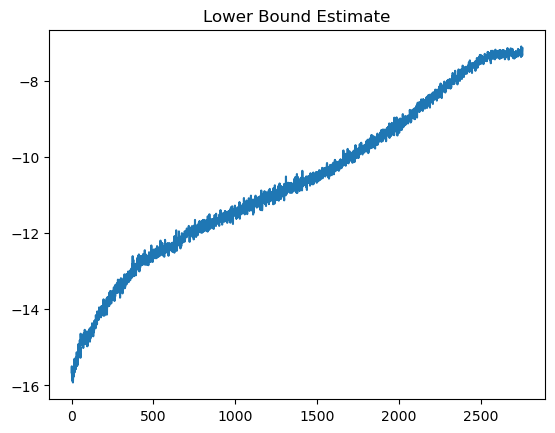

In [31]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<Axes: >

<Figure size 640x480 with 0 Axes>

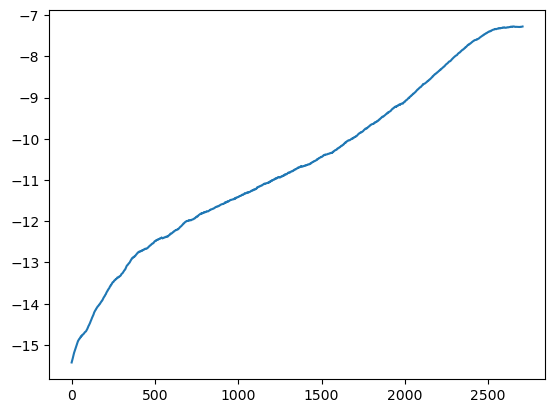

In [35]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(legend = False)

In [34]:
best_mu = best_lambda[0]
best_vech_l = list(best_lambda[1])
best_l = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l[i:num_coeffs,i] = best_vech_l[:num_coeffs - i]
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 1000)
best_alpha = (2 * np.exp(best_theta_tilde[:,0]) + 1) / (1 + np.exp(best_theta_tilde[:,0]))
best_beta = (100 * np.exp(best_theta_tilde[:,1]) + 0) / (1 + np.exp(best_theta_tilde[:,1]))
best_gamma = (0.9 * np.exp(best_theta_tilde[:,2]) + 0) / (1 + np.exp(best_theta_tilde[:,2]))
best_theta = np.array([best_alpha, best_beta, best_gamma])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([ 1.76765458, 35.20509522,  0.52629604])

In [33]:
np.linalg.norm(posterior_mean_estimate - true_theta)

1.55810063866019

Text(0.5, 1.0, 'Posterior density of alpha')

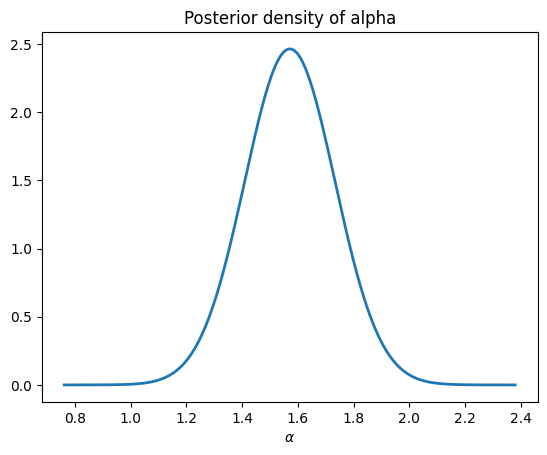

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_alpha)-5*np.std(best_alpha)), (np.mean(best_alpha)+5*np.std(best_alpha)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_alpha), np.std(best_alpha))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

Text(0.5, 1.0, 'Posterior density of beta')

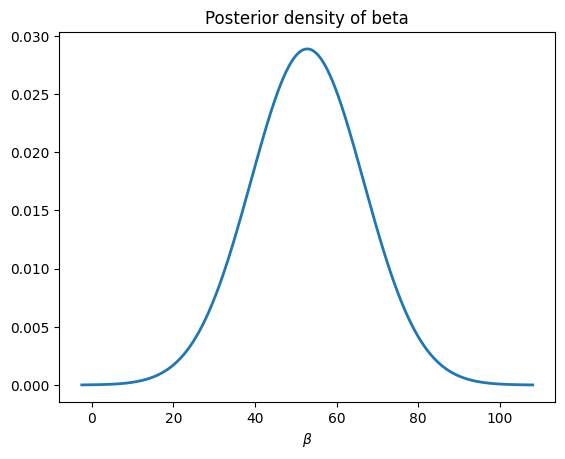

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_beta)-4*np.std(best_beta)), (np.mean(best_beta)+4*np.std(best_beta)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_beta), np.std(best_beta))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of gamma')

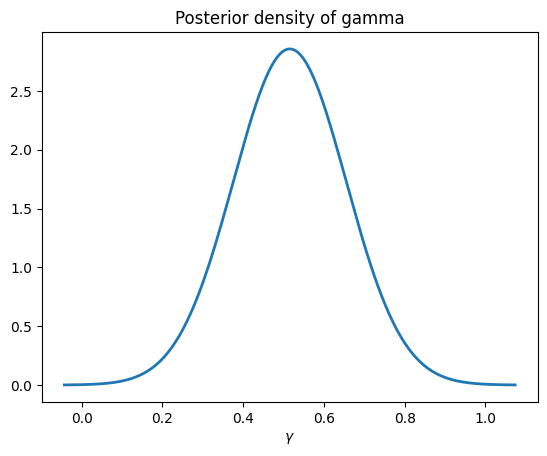

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_gamma)-4*np.std(best_gamma)), (np.mean(best_gamma)+4*np.std(best_gamma)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_gamma), np.std(best_gamma))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

## RUN MCMC

In [68]:
num_samples = 10000
num_burnin = 0.2 * num_samples

In [69]:
def sampler(samples):

    # ------------------- initialize MCMC

    theta_size = num_coeffs  # num of weights and bias

    pos_theta = np.ones((samples, theta_size))  # posterior of all weights and bias over all samples
    pos_theta_tilde = np.ones((samples, theta_size))

    theta_tilde = np.array([np.log((true_theta[0] - 1)/(2 - true_theta[0])),np.log((true_theta[1] - 0)/(100 - true_theta[1])),np.log((true_theta[2] - 0)/(0.9 - true_theta[2]))])

    alpha = (2 * np.exp(theta_tilde[0]) + 0) / (1 + np.exp(theta_tilde[0]))
    beta = (100 * np.exp(theta_tilde[1]) + 0) / (1 + np.exp(theta_tilde[1]))
    gamma = (0.9 * np.exp(theta_tilde[2]) + 0) / (1 + np.exp(theta_tilde[2]))

    theta = np.array([alpha, beta, gamma])

    ss = summary_statistics(theta, n_samples, num_datasets)
    sample_mean = ss[0]
    sample_variance = ss[1]
    # Nuissance mean and variance
    diag_var = np.zeros((num_latent, num_latent))
    np.fill_diagonal(diag_var, np.diag(sqrtm(sample_variance)))
    mean_nuissance_p1 = my_inv(np.identity(num_latent) / sigma_latent + diag_var.T @ my_inv(sample_variance) @ diag_var)
    diff_mean = actual_summary_statistics - sample_mean
    mean_nuissance_p2 = diag_var @ my_inv(sample_variance) @ diff_mean
    mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2

    variance_nuissance = mean_nuissance_p1  #+ (np.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)

    # GENERATE GAMMA
    rng = np.random.default_rng()
    Gamma_init = rng.multivariate_normal(mean = mean_nuissance, cov = variance_nuissance)
    # Gamma = Gamma[0]
    adjusted_theta = np.concatenate((theta, Gamma_init))

    # Find gradient of LB
    llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta, n_samples, num_datasets)
    llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma_init, mean_nuissance, variance_nuissance)

    # --------------------- 

    prior_current = prior(theta_tilde)  # takes care of the gradients

    likelihood_current = llh

    naccept = 0

    for i in tqdm(range(samples - 1)):
        # theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2.5/theta_size) * np.identity(theta_size)))
        if i < 1000:
#             theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2.5/theta_size) * np.identity(theta_size)))
            theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2.5/theta_size) * best_Sigma))
        else:
            if i % 500 == 0:
                Sign = np.cov(pos_theta_tilde[0:i, :].T)
            u_proposal = np.random.uniform(0, 1)
            if u_proposal < 0.5:
            # if u_proposal < 0.05:
#                 theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2.5/theta_size) * np.identity(theta_size)))
                theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2.5/theta_size) * best_Sigma))  
            else:
                # theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = (2.38**2/theta_size) * Sign)
#                 theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = (1.1**2.5/theta_size) * Sign)
                theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((1.1**2.5/theta_size) * best_Sigma))

        alpha_prop = (2 * np.exp(theta_proposal_tilde[0]) + 0) / (1 + np.exp(theta_proposal_tilde[0]))
        beta_prop = (100 * np.exp(theta_proposal_tilde[1]) + 0) / (1 + np.exp(theta_proposal_tilde[1]))
        gamma_prop = (0.9 * np.exp(theta_proposal_tilde[2]) + 0) / (1 + np.exp(theta_proposal_tilde[2]))

        theta_proposal = np.array([alpha_prop, beta_prop, gamma_prop])

        ss = summary_statistics(theta_proposal, n_samples, num_datasets)
        sample_mean = ss[0]
        sample_variance = ss[1]
        # Find mean and variance for p(gamma | theta, obs)

        diag_var = np.zeros((num_latent, num_latent))
        np.fill_diagonal(diag_var, np.diag(sqrtm(sample_variance)))
        mean_nuissance_p1 = my_inv(np.identity(num_latent) / sigma_latent + diag_var.T @ my_inv(sample_variance) @ diag_var)
        diff_mean = actual_summary_statistics - sample_mean
        mean_nuissance_p2 = diag_var @ my_inv(sample_variance) @ diff_mean
        mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2

        variance_nuissance = mean_nuissance_p1  #+ (np.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)

        # GENERATE GAMMA
        rng = np.random.default_rng()
        Gamma = rng.multivariate_normal(mean = mean_nuissance, cov = variance_nuissance)
        # Gamma = Gamma[0]
        adjusted_theta_proposal = np.concatenate((theta_proposal, Gamma))


        # Find gradient of LB
        llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_proposal, n_samples, num_datasets)
        llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance)       
        # --------------------- 

        prior_proposal = prior(theta_proposal_tilde)  # takes care of the gradients
        likelihood_proposal = llh

        diff_prior = prior_proposal - prior_current

        diff_likelihood = likelihood_proposal - likelihood_current

        try:
            mh_prob = min(1, math.exp(diff_likelihood+diff_prior))

        except OverflowError as e:
            mh_prob = 1


        u = np.random.uniform(0, 1)

        if u < mh_prob:
            # Update position 
            naccept += 1
            likelihood_current = likelihood_proposal
            prior_current = prior_proposal
            theta_tilde = theta_proposal_tilde
            theta = theta_proposal
            pos_theta_tilde[i + 1,] = theta_proposal_tilde	
            pos_theta[i + 1,] = theta_proposal
            print(i, pos_theta[i + 1,])
            print(i, naccept / (samples * 1.0) * 100, '% was accepted')

        else:
            pos_theta_tilde[i + 1,] = pos_theta_tilde[i,]
            pos_theta[i + 1,] = pos_theta[i,]

    print(naccept, ' num accepted')
    print(naccept / (samples * 1.0) * 100, '% was accepted')
    accept_ratio = naccept / (samples * 1.0) * 100

    return (pos_theta, pos_theta_tilde, accept_ratio)

In [70]:
pos_w, pos_w_tilde, accept_ratio = sampler(num_samples)

  0%|          | 6/9999 [00:03<1:38:50,  1.69it/s]

5 [ 1.39897773 35.03331942  0.60068914]
5 0.01 % was accepted


  0%|          | 13/9999 [00:08<1:46:53,  1.56it/s]

12 [ 1.40138697 35.13253338  0.6019801 ]
12 0.02 % was accepted


  0%|          | 18/9999 [00:13<3:01:59,  1.09s/it]

17 [ 1.40110364 35.09262561  0.60225029]
17 0.03 % was accepted


  0%|          | 23/9999 [00:18<2:35:32,  1.07it/s]

22 [ 1.40082173 35.22771473  0.60191627]
22 0.04 % was accepted


  0%|          | 25/9999 [00:20<2:45:10,  1.01it/s]

24 [ 1.40199864 35.29898886  0.60274643]
24 0.05 % was accepted


  1%|          | 50/9999 [00:54<3:22:13,  1.22s/it]

49 [ 1.40386606 35.3250772   0.60283669]
49 0.06 % was accepted


  1%|          | 107/9999 [02:09<4:07:27,  1.50s/it]

106 [ 1.40193668 35.42142374  0.60382259]
106 0.06999999999999999 % was accepted


 15%|█▍        | 1468/9999 [1:29:12<4:10:32,  1.76s/it] 

1467 [ 1.40223511 35.42948318  0.60356714]
1467 0.08 % was accepted


 15%|█▍        | 1478/9999 [1:29:28<3:50:21,  1.62s/it]

1477 [ 1.41190462 33.28837848  0.60070644]
1477 0.09 % was accepted


 15%|█▍        | 1490/9999 [1:29:51<4:48:34,  2.03s/it]

1489 [ 1.4148897  32.20952357  0.59190466]
1489 0.1 % was accepted


 15%|█▍        | 1492/9999 [1:29:54<4:42:19,  1.99s/it]

1491 [ 1.41485682 32.2281052   0.59270049]
1491 0.11 % was accepted


 15%|█▍        | 1494/9999 [1:29:58<4:10:35,  1.77s/it]

1493 [ 1.41543103 32.23532041  0.59295306]
1493 0.12 % was accepted


 15%|█▌        | 1500/9999 [1:30:10<4:38:41,  1.97s/it]

1499 [ 1.4128479  32.22146771  0.59317588]
1499 0.13 % was accepted



 15%|█▌        | 1501/9999 [1:30:11<4:26:32,  1.88s/it]

1500 [ 1.4115441  32.31697219  0.59328481]
1500 0.13999999999999999 % was accepted


 15%|█▌        | 1511/9999 [1:30:34<5:30:44,  2.34s/it]

1510 [ 1.40970924 32.25519943  0.59295484]
1510 0.15 % was accepted


 15%|█▌        | 1519/9999 [1:30:57<5:56:16,  2.52s/it]

1518 [ 1.41303097 32.19222519  0.58933672]
1518 0.16 % was accepted


 15%|█▌        | 1531/9999 [1:31:25<6:03:26,  2.58s/it]

1530 [ 1.38795711 31.95820734  0.58570341]
1530 0.16999999999999998 % was accepted



 15%|█▌        | 1532/9999 [1:31:27<5:39:59,  2.41s/it]

1531 [ 1.35223542 30.18778554  0.59922656]
1531 0.18 % was accepted


 16%|█▌        | 1596/9999 [1:33:44<6:00:07,  2.57s/it]

1595 [ 1.36886655 30.60524441  0.63137082]
1595 0.19 % was accepted


 17%|█▋        | 1688/9999 [1:37:21<5:00:04,  2.17s/it]

1687 [ 1.36713314 30.50076866  0.63065001]
1687 0.2 % was accepted


 17%|█▋        | 1704/9999 [1:37:54<5:52:42,  2.55s/it]

1703 [ 1.36627063 30.39883959  0.62900886]
1703 0.21 % was accepted


 17%|█▋        | 1711/9999 [1:38:10<5:36:31,  2.44s/it]

1710 [ 1.36377445 30.36600431  0.62820136]
1710 0.22 % was accepted


 17%|█▋        | 1747/9999 [1:39:33<4:35:31,  2.00s/it]

1746 [ 1.3684949  30.25463362  0.62837853]
1746 0.22999999999999998 % was accepted


 18%|█▊        | 1763/9999 [1:40:15<5:58:00,  2.61s/it]

1762 [ 1.36835732 30.29860048  0.62825697]
1762 0.24 % was accepted


 18%|█▊        | 1771/9999 [1:40:34<6:09:13,  2.69s/it]

1770 [ 1.36861104 30.31040064  0.62814036]
1770 0.25 % was accepted


 18%|█▊        | 1808/9999 [1:41:50<4:33:37,  2.00s/it]

1807 [ 1.37036446 30.31652229  0.62771168]
1807 0.26 % was accepted


 19%|█▊        | 1855/9999 [1:43:31<4:56:58,  2.19s/it]

1854 [ 1.36967327 30.26614091  0.62827874]
1854 0.27 % was accepted


 19%|█▉        | 1900/9999 [1:45:32<5:22:23,  2.39s/it]

1899 [ 1.37022079 30.25644015  0.62951688]
1899 0.27999999999999997 % was accepted


 19%|█▉        | 1911/9999 [1:46:00<5:30:27,  2.45s/it]

1910 [ 1.35853561 31.98432271  0.62756544]
1910 0.29 % was accepted


 19%|█▉        | 1927/9999 [1:46:44<6:17:39,  2.81s/it]

1926 [ 1.34874014 31.61203058  0.61573111]
1926 0.3 % was accepted


 19%|█▉        | 1940/9999 [1:47:23<6:57:58,  3.11s/it]

1939 [ 1.34898216 31.66731108  0.61553958]
1939 0.31 % was accepted


 20%|█▉        | 1952/9999 [1:47:54<5:03:26,  2.26s/it]

1951 [ 1.36119592 31.74676458  0.63133695]
1951 0.32 % was accepted


 20%|██        | 2007/9999 [1:50:53<8:44:41,  3.94s/it]

2006 [ 1.39958452 32.26626364  0.60344147]
2006 0.33 % was accepted


 20%|██        | 2010/9999 [1:51:02<7:14:30,  3.26s/it]

2009 [ 1.43067704 31.93090117  0.5979033 ]
2009 0.33999999999999997 % was accepted


 20%|██        | 2015/9999 [1:51:19<7:28:07,  3.37s/it]

2014 [ 1.42838833 31.61039738  0.5674325 ]
2014 0.35000000000000003 % was accepted


 20%|██        | 2023/9999 [1:51:46<7:30:45,  3.39s/it]

2022 [ 1.41885235 30.89919473  0.56111836]
2022 0.36 % was accepted


 20%|██        | 2025/9999 [1:51:52<7:08:29,  3.22s/it]

2024 [ 1.41823829 30.97818892  0.56164598]
2024 0.37 % was accepted


 20%|██        | 2030/9999 [1:52:04<5:25:45,  2.45s/it]

2029 [ 1.4198303  29.50491575  0.57489054]
2029 0.38 % was accepted


 20%|██        | 2043/9999 [1:52:44<6:55:26,  3.13s/it]

2042 [ 1.41816365 29.52924296  0.57542484]
2042 0.38999999999999996 % was accepted


 21%|██        | 2050/9999 [1:53:10<7:37:43,  3.46s/it]

2049 [ 1.41861214 29.65178069  0.57438912]
2049 0.4 % was accepted


 21%|██        | 2081/9999 [1:55:00<6:59:02,  3.18s/it]

2080 [ 1.41124799 29.43659838  0.53405336]
2080 0.41000000000000003 % was accepted


 21%|██▏       | 2128/9999 [1:57:52<9:03:24,  4.14s/it] 

2127 [ 1.41381534 29.53240189  0.53404682]
2127 0.42 % was accepted


 21%|██▏       | 2130/9999 [1:58:00<9:18:14,  4.26s/it]

2129 [ 1.42188418 28.56966091  0.54068775]
2129 0.43 % was accepted


 22%|██▏       | 2170/9999 [2:00:43<11:44:22,  5.40s/it]

2169 [ 1.4217762  28.60358703  0.5404421 ]
2169 0.44 % was accepted


 22%|██▏       | 2227/9999 [2:05:20<7:31:46,  3.49s/it] 

2226 [ 1.42482545 28.4879995   0.53994325]
2226 0.44999999999999996 % was accepted


 23%|██▎       | 2313/9999 [2:10:55<6:21:22,  2.98s/it] 

2312 [ 1.44777652 30.21038568  0.55995537]
2312 0.45999999999999996 % was accepted


 24%|██▍       | 2393/9999 [2:14:41<6:49:54,  3.23s/it]

2392 [ 1.42983281 31.51057716  0.55885348]
2392 0.47000000000000003 % was accepted



 24%|██▍       | 2394/9999 [2:14:44<6:49:22,  3.23s/it]

2393 [ 1.43192579 31.37303739  0.55937468]
2393 0.48 % was accepted


 24%|██▍       | 2402/9999 [2:15:08<6:29:26,  3.08s/it]

2401 [ 1.43241697 31.31009086  0.55995298]
2401 0.49 % was accepted


 24%|██▍       | 2444/9999 [2:17:14<6:20:43,  3.02s/it]

2443 [ 1.48617758 29.5182135   0.56184262]
2443 0.5 % was accepted


 25%|██▍       | 2454/9999 [2:17:41<5:25:14,  2.59s/it]

2453 [ 1.46808741 29.91186842  0.58405002]
2453 0.51 % was accepted


 28%|██▊       | 2772/9999 [2:49:37<18:03:03,  8.99s/it]

2771 [ 1.46831558 29.85525586  0.58372483]
2771 0.52 % was accepted


 28%|██▊       | 2788/9999 [2:51:03<11:13:06,  5.60s/it]

2787 [ 1.46837772 29.80523428  0.58276311]
2787 0.53 % was accepted


 28%|██▊       | 2806/9999 [2:53:00<13:45:06,  6.88s/it]

2805 [ 1.48921992 30.62646448  0.59457145]
2805 0.54 % was accepted


 28%|██▊       | 2810/9999 [2:53:25<11:55:24,  5.97s/it]

2809 [ 1.48823762 30.58721436  0.59428373]
2809 0.5499999999999999 % was accepted


 28%|██▊       | 2816/9999 [2:53:59<11:50:38,  5.94s/it]

2815 [ 1.49018618 30.57981408  0.59378146]
2815 0.5599999999999999 % was accepted


 28%|██▊       | 2819/9999 [2:54:16<11:00:35,  5.52s/it]

2818 [ 1.48601527 28.92203728  0.59154973]
2818 0.5700000000000001 % was accepted


 29%|██▊       | 2855/9999 [2:58:12<11:18:08,  5.70s/it]

2854 [ 1.52123085 28.51230598  0.57081647]
2854 0.58 % was accepted


 29%|██▉       | 2876/9999 [3:00:09<11:05:54,  5.61s/it]

2875 [ 1.51910515 28.58102243  0.57072387]
2875 0.59 % was accepted


 29%|██▉       | 2902/9999 [3:02:34<7:21:01,  3.73s/it] 

2901 [ 1.51998542 28.53562692  0.57156749]
2901 0.6 % was accepted


 29%|██▉       | 2912/9999 [3:03:16<8:35:34,  4.36s/it]

2911 [ 1.51912994 28.48967329  0.57170308]
2911 0.61 % was accepted


 29%|██▉       | 2919/9999 [3:03:54<10:09:49,  5.17s/it]

2918 [ 1.53044637 31.79385262  0.56392134]
2918 0.62 % was accepted



 29%|██▉       | 2920/9999 [3:03:59<10:04:27,  5.12s/it]

2919 [ 1.55440981 30.57672783  0.5637303 ]
2919 0.63 % was accepted


 29%|██▉       | 2942/9999 [3:05:28<6:29:08,  3.31s/it] 

2941 [ 1.58529278 31.16005363  0.55708957]
2941 0.64 % was accepted


 30%|██▉       | 2950/9999 [3:05:54<6:43:10,  3.43s/it]

2949 [ 1.58361513 31.23752339  0.55606703]
2949 0.65 % was accepted


 30%|██▉       | 2972/9999 [3:07:02<6:07:39,  3.14s/it]

2971 [ 1.57084688 30.42662013  0.5642772 ]
2971 0.66 % was accepted


 30%|███       | 3016/9999 [3:09:23<5:17:18,  2.73s/it]

3015 [ 1.56701697 31.13591492  0.56554189]
3015 0.67 % was accepted


 30%|███       | 3021/9999 [3:09:38<5:31:10,  2.85s/it]

3020 [ 1.57624537 30.01573234  0.60055578]
3020 0.6799999999999999 % was accepted



 30%|███       | 3022/9999 [3:09:40<5:18:30,  2.74s/it]

3021 [ 1.62133412 31.40126383  0.59416359]
3021 0.69 % was accepted



 30%|███       | 3023/9999 [3:09:43<5:12:39,  2.69s/it]

3022 [ 1.62063599 31.31894064  0.59460395]
3022 0.7000000000000001 % was accepted


 30%|███       | 3026/9999 [3:09:54<6:25:41,  3.32s/it]

3025 [ 1.61849849 31.31830439  0.59414654]
3025 0.7100000000000001 % was accepted


 30%|███       | 3029/9999 [3:10:02<5:45:42,  2.98s/it]

3028 [ 1.62483599 31.35340057  0.59393753]
3028 0.72 % was accepted


 30%|███       | 3038/9999 [3:10:29<5:32:50,  2.87s/it]

3037 [ 1.62475286 31.3341981   0.59487457]
3037 0.73 % was accepted


 31%|███       | 3059/9999 [3:11:25<5:21:26,  2.78s/it]

3058 [ 1.62356483 31.24586718  0.59396108]
3058 0.74 % was accepted


 32%|███▏      | 3152/9999 [3:16:22<7:34:41,  3.98s/it] 

3151 [ 1.57267376 31.64534833  0.5887958 ]
3151 0.75 % was accepted


 32%|███▏      | 3158/9999 [3:16:46<7:29:36,  3.94s/it]

3157 [ 1.60097989 31.10642283  0.58351137]
3157 0.76 % was accepted


 32%|███▏      | 3186/9999 [3:18:23<7:34:34,  4.00s/it]

3185 [ 1.59447294 32.59415945  0.58498404]
3185 0.77 % was accepted


 32%|███▏      | 3236/9999 [3:21:29<6:17:14,  3.35s/it]

3235 [ 1.59501608 32.43495671  0.58477954]
3235 0.7799999999999999 % was accepted


 32%|███▏      | 3243/9999 [3:22:03<9:10:35,  4.89s/it]

3242 [ 1.57168648 32.91782877  0.58674629]
3242 0.79 % was accepted


 33%|███▎      | 3268/9999 [3:24:07<8:49:15,  4.72s/it] 

3267 [ 1.5720291  32.95410347  0.58604239]
3267 0.8 % was accepted


 33%|███▎      | 3282/9999 [3:25:07<8:33:46,  4.59s/it]

3281 [ 1.57358201 33.55354277  0.5666558 ]
3281 0.8099999999999999 % was accepted


 33%|███▎      | 3284/9999 [3:25:15<7:54:08,  4.24s/it]

3283 [ 1.57349322 33.72185454  0.56731982]
3283 0.8200000000000001 % was accepted


 33%|███▎      | 3297/9999 [3:26:15<9:02:51,  4.86s/it]

3296 [ 1.57310191 33.76647106  0.56765025]
3296 0.83 % was accepted


 33%|███▎      | 3299/9999 [3:26:22<7:42:19,  4.14s/it]

3298 [ 1.57226565 34.20432006  0.58124061]
3298 0.84 % was accepted



 33%|███▎      | 3300/9999 [3:26:25<7:25:47,  3.99s/it]

3299 [ 1.58425378 34.27023021  0.57678345]
3299 0.8500000000000001 % was accepted



 33%|███▎      | 3301/9999 [3:26:28<6:30:07,  3.49s/it]

3300 [ 1.58370433 34.25417556  0.57671387]
3300 0.86 % was accepted



 33%|███▎      | 3302/9999 [3:26:31<6:10:25,  3.32s/it]

3301 [ 1.55493612 35.84146444  0.59125442]
3301 0.8699999999999999 % was accepted


 33%|███▎      | 3306/9999 [3:26:43<5:51:26,  3.15s/it]

3305 [ 1.57792547 34.24921892  0.59300347]
3305 0.88 % was accepted



 33%|███▎      | 3307/9999 [3:26:46<5:51:39,  3.15s/it]

3306 [ 1.57786908 35.4934106   0.60733111]
3306 0.89 % was accepted


 33%|███▎      | 3309/9999 [3:26:53<6:04:47,  3.27s/it]

3308 [ 1.57829563 35.78596018  0.61340708]
3308 0.8999999999999999 % was accepted


 33%|███▎      | 3311/9999 [3:27:00<6:28:42,  3.49s/it]

3310 [ 1.57723448 35.7273585   0.61201455]
3310 0.91 % was accepted


 33%|███▎      | 3315/9999 [3:27:16<7:02:34,  3.79s/it]

3314 [ 1.57732831 35.69164564  0.61248564]
3314 0.9199999999999999 % was accepted



 33%|███▎      | 3316/9999 [3:27:19<6:45:58,  3.64s/it]

3315 [ 1.61132558 35.35632517  0.619276  ]
3315 0.9299999999999999 % was accepted


 33%|███▎      | 3335/9999 [3:28:36<7:27:51,  4.03s/it]

3334 [ 1.62889987 32.7601824   0.61052909]
3334 0.9400000000000001 % was accepted


 33%|███▎      | 3340/9999 [3:28:57<7:32:56,  4.08s/it]

3339 [ 1.62860375 32.70021937  0.61054077]
3339 0.95 % was accepted


 33%|███▎      | 3343/9999 [3:29:08<7:13:48,  3.91s/it]

3342 [ 1.60460854 32.10188886  0.6028394 ]
3342 0.96 % was accepted


 34%|███▍      | 3381/9999 [3:31:38<8:10:41,  4.45s/it]

3380 [ 1.60442419 31.947204    0.60207927]
3380 0.97 % was accepted


 34%|███▍      | 3392/9999 [3:32:16<5:41:42,  3.10s/it]

3391 [ 1.6049286  31.96555566  0.60169831]
3391 0.98 % was accepted


 34%|███▍      | 3403/9999 [3:32:59<8:11:35,  4.47s/it]

3402 [ 1.60477001 31.94158382  0.60243471]
3402 0.9900000000000001 % was accepted


 35%|███▍      | 3473/9999 [3:38:36<9:08:57,  5.05s/it] 

3472 [ 1.60481906 31.93340186  0.60191187]
3472 1.0 % was accepted


 35%|███▍      | 3499/9999 [3:40:37<8:17:35,  4.59s/it]

3498 [ 1.61073219 31.64687868  0.60324021]
3498 1.01 % was accepted


 35%|███▌      | 3543/9999 [3:43:58<7:27:33,  4.16s/it] 

3542 [ 1.61122144 31.67897166  0.6031689 ]
3542 1.02 % was accepted


 36%|███▌      | 3552/9999 [3:44:30<6:43:39,  3.76s/it]

3551 [ 1.62743931 30.18101943  0.60812438]
3551 1.03 % was accepted


 36%|███▌      | 3556/9999 [3:44:43<5:35:37,  3.13s/it]

3555 [ 1.62721173 30.40264713  0.60832535]
3555 1.04 % was accepted


 36%|███▌      | 3585/9999 [3:46:19<5:24:15,  3.03s/it]

3584 [ 1.62641783 30.34017887  0.60908273]
3584 1.05 % was accepted


 36%|███▌      | 3607/9999 [3:47:25<4:33:38,  2.57s/it]

3606 [ 1.62521364 30.22966954  0.61039697]
3606 1.06 % was accepted


 36%|███▌      | 3615/9999 [3:47:49<5:03:46,  2.85s/it]

3614 [ 1.61016847 29.83255111  0.6040762 ]
3614 1.0699999999999998 % was accepted



 36%|███▌      | 3616/9999 [3:47:51<4:43:06,  2.66s/it]

3615 [ 1.61110189 29.84137102  0.60461981]
3615 1.08 % was accepted


 36%|███▌      | 3618/9999 [3:47:57<4:44:02,  2.67s/it]

3617 [ 1.61235879 29.82582899  0.60403173]
3617 1.09 % was accepted


 36%|███▋      | 3646/9999 [3:49:31<6:32:46,  3.71s/it]

3645 [ 1.61169947 29.83594972  0.60385002]
3645 1.0999999999999999 % was accepted


 37%|███▋      | 3659/9999 [3:50:16<6:30:30,  3.70s/it]

3658 [ 1.61352339 29.92635668  0.60369999]
3658 1.11 % was accepted


 37%|███▋      | 3666/9999 [3:50:40<7:24:42,  4.21s/it]

3665 [ 1.61313572 29.83251836  0.60418256]
3665 1.1199999999999999 % was accepted



 37%|███▋      | 3667/9999 [3:50:48<9:15:33,  5.26s/it]

3666 [ 1.61444651 29.83303898  0.6045574 ]
3666 1.13 % was accepted


 37%|███▋      | 3670/9999 [3:50:59<7:30:49,  4.27s/it]

3669 [ 1.61532661 29.84928579  0.60278068]
3669 1.1400000000000001 % was accepted


 37%|███▋      | 3679/9999 [3:51:27<6:33:27,  3.74s/it]

3678 [ 1.61561883 29.84759303  0.60266345]
3678 1.15 % was accepted


 37%|███▋      | 3694/9999 [3:52:28<5:45:39,  3.29s/it] 

3693 [ 1.61762655 29.92422363  0.60222551]
3693 1.16 % was accepted


 37%|███▋      | 3697/9999 [3:52:44<8:00:43,  4.58s/it]

3696 [ 1.6181313  29.78815237  0.60268382]
3696 1.17 % was accepted


 37%|███▋      | 3703/9999 [3:53:08<6:30:40,  3.72s/it]

3702 [ 1.61816902 29.77746373  0.60270837]
3702 1.18 % was accepted


 37%|███▋      | 3736/9999 [3:55:09<7:12:19,  4.14s/it]

3735 [ 1.62559214 31.61769217  0.59624169]
3735 1.1900000000000002 % was accepted


 38%|███▊      | 3754/9999 [3:56:20<5:22:27,  3.10s/it]

3753 [ 1.6255298  31.52343642  0.59604985]
3753 1.2 % was accepted



 38%|███▊      | 3755/9999 [3:56:23<5:05:26,  2.94s/it]

3754 [ 1.6259092  31.49402855  0.59596265]
3754 1.21 % was accepted


 38%|███▊      | 3760/9999 [3:56:37<4:46:45,  2.76s/it]

3759 [ 1.62502177 31.45141131  0.59516114]
3759 1.22 % was accepted


 38%|███▊      | 3765/9999 [3:56:53<5:29:36,  3.17s/it]

3764 [ 1.62615979 31.57013047  0.59518139]
3764 1.23 % was accepted


 38%|███▊      | 3768/9999 [3:56:58<4:06:52,  2.38s/it]

3767 [ 1.62747824 32.79829417  0.59786193]
3767 1.24 % was accepted


 38%|███▊      | 3774/9999 [3:57:14<4:18:18,  2.49s/it]

3773 [ 1.62729702 32.73803424  0.59860922]
3773 1.25 % was accepted


 38%|███▊      | 3779/9999 [3:57:27<4:19:22,  2.50s/it]

3778 [ 1.62579612 32.77424145  0.59743394]
3778 1.26 % was accepted


 38%|███▊      | 3796/9999 [3:58:17<5:48:14,  3.37s/it]

3795 [ 1.6264709  32.69455761  0.59733398]
3795 1.27 % was accepted


 38%|███▊      | 3798/9999 [3:58:22<5:10:43,  3.01s/it]

3797 [ 1.63257784 33.10397606  0.59592715]
3797 1.28 % was accepted


 38%|███▊      | 3823/9999 [3:59:46<6:37:23,  3.86s/it]

3822 [ 1.63190929 33.0998314   0.59590957]
3822 1.29 % was accepted


 38%|███▊      | 3832/9999 [4:00:20<5:49:13,  3.40s/it]

3831 [ 1.63393232 33.60356618  0.6020445 ]
3831 1.3 % was accepted


 39%|███▉      | 3886/9999 [4:03:17<6:12:38,  3.66s/it]

3885 [ 1.63443332 33.51086688  0.60144313]
3885 1.31 % was accepted


 39%|███▉      | 3889/9999 [4:03:25<5:07:48,  3.02s/it]

3888 [ 1.63363012 33.41685707  0.6016226 ]
3888 1.32 % was accepted



 39%|███▉      | 3890/9999 [4:03:28<5:24:11,  3.18s/it]

3889 [ 1.63211    33.40818685  0.60134495]
3889 1.3299999999999998 % was accepted


 39%|███▉      | 3900/9999 [4:03:56<4:44:42,  2.80s/it]

3899 [ 1.62973483 33.3977604   0.60091765]
3899 1.34 % was accepted


 39%|███▉      | 3943/9999 [4:05:42<5:32:36,  3.30s/it]

3942 [ 1.62899132 33.45626881  0.60146087]
3942 1.35 % was accepted


 39%|███▉      | 3945/9999 [4:05:50<6:13:16,  3.70s/it]

3944 [ 1.63036242 33.51770033  0.60154274]
3944 1.3599999999999999 % was accepted


 40%|███▉      | 3953/9999 [4:06:21<6:09:36,  3.67s/it]

3952 [ 1.62570422 32.54645908  0.58588105]
3952 1.37 % was accepted


 40%|███▉      | 3955/9999 [4:06:26<5:08:02,  3.06s/it]

3954 [ 1.6243955  32.60860932  0.58586488]
3954 1.38 % was accepted


 40%|███▉      | 3958/9999 [4:06:33<4:16:21,  2.55s/it]

3957 [ 1.65048563 31.48808909  0.58063485]
3957 1.39 % was accepted


 40%|███▉      | 3961/9999 [4:06:40<4:08:12,  2.47s/it]

3960 [ 1.64819367 30.91881106  0.59634575]
3960 1.4000000000000001 % was accepted


 40%|███▉      | 3967/9999 [4:06:54<3:59:33,  2.38s/it]

3966 [ 1.64834943 30.97429175  0.59519042]
3966 1.41 % was accepted


 40%|███▉      | 3979/9999 [4:07:23<4:19:25,  2.59s/it]

3978 [ 1.64927683 30.93154769  0.59589504]
3978 1.4200000000000002 % was accepted


 40%|███▉      | 3994/9999 [4:08:08<4:20:12,  2.60s/it]

3993 [ 1.65792382 32.66463931  0.56590252]
3993 1.43 % was accepted



 40%|███▉      | 3995/9999 [4:08:11<4:14:21,  2.54s/it]

3994 [ 1.65127621 31.98064966  0.57134448]
3994 1.44 % was accepted


 40%|████      | 4002/9999 [4:08:30<4:55:41,  2.96s/it]

4001 [ 1.65375603 32.07706733  0.57152154]
4001 1.4500000000000002 % was accepted



 40%|████      | 4003/9999 [4:08:35<5:50:07,  3.50s/it]

4002 [ 1.65480225 32.07845345  0.5716474 ]
4002 1.46 % was accepted


 40%|████      | 4005/9999 [4:08:41<5:29:09,  3.29s/it]

4004 [ 1.66591027 30.65044626  0.55952992]
4004 1.47 % was accepted


 40%|████      | 4010/9999 [4:08:56<5:31:59,  3.33s/it]

4009 [ 1.62363203 30.57263299  0.56626918]
4009 1.48 % was accepted



 40%|████      | 4011/9999 [4:08:59<5:20:50,  3.21s/it]

4010 [ 1.62235273 30.53700499  0.56562942]
4010 1.49 % was accepted


 41%|████      | 4094/9999 [4:13:16<5:30:18,  3.36s/it]

4093 [ 1.62314409 30.5683554   0.56540271]
4093 1.5 % was accepted


 41%|████▏     | 4142/9999 [4:15:19<3:36:35,  2.22s/it]

4141 [ 1.623392   30.56617902  0.56534332]
4141 1.51 % was accepted


 42%|████▏     | 4179/9999 [4:17:14<5:26:28,  3.37s/it]

4178 [ 1.64005382 31.28012561  0.573932  ]
4178 1.52 % was accepted


 42%|████▏     | 4181/9999 [4:17:21<5:30:55,  3.41s/it]

4180 [ 1.63797365 31.32926355  0.61130673]
4180 1.53 % was accepted


 42%|████▏     | 4203/9999 [4:18:26<5:08:38,  3.19s/it]

4202 [ 1.63626684 31.34695752  0.60976172]
4202 1.54 % was accepted


 42%|████▏     | 4206/9999 [4:18:34<4:55:30,  3.06s/it]

4205 [ 1.63672941 31.40065901  0.60859461]
4205 1.55 % was accepted


 42%|████▏     | 4228/9999 [4:19:45<5:17:26,  3.30s/it]

4227 [ 1.63049532 30.58265666  0.58435788]
4227 1.5599999999999998 % was accepted


 42%|████▏     | 4234/9999 [4:20:08<5:56:34,  3.71s/it]

4233 [ 1.65995673 31.39623937  0.5913584 ]
4233 1.5699999999999998 % was accepted


 42%|████▏     | 4239/9999 [4:20:23<5:02:04,  3.15s/it]

4238 [ 1.65940455 31.32822141  0.59129907]
4238 1.58 % was accepted



 42%|████▏     | 4240/9999 [4:20:25<4:44:26,  2.96s/it]

4239 [ 1.69641573 29.37465415  0.58924267]
4239 1.59 % was accepted


 42%|████▏     | 4244/9999 [4:20:37<4:40:38,  2.93s/it]

4243 [ 1.71338804 30.1716653   0.58436415]
4243 1.6 % was accepted


 42%|████▏     | 4246/9999 [4:20:44<4:56:34,  3.09s/it]

4245 [ 1.6851507  29.52652178  0.60848526]
4245 1.6099999999999999 % was accepted


 43%|████▎     | 4250/9999 [4:20:59<5:52:14,  3.68s/it]

4249 [ 1.64443973 30.21213628  0.60236203]
4249 1.6199999999999999 % was accepted


 43%|████▎     | 4271/9999 [4:22:08<4:41:06,  2.94s/it]

4270 [ 1.6549821  33.42833529  0.60895245]
4270 1.63 % was accepted


 43%|████▎     | 4284/9999 [4:22:41<3:59:42,  2.52s/it]

4283 [ 1.65538805 34.24541254  0.60570447]
4283 1.6400000000000001 % was accepted


 43%|████▎     | 4317/9999 [4:24:12<4:30:21,  2.85s/it]

4316 [ 1.68939158 33.77496634  0.61090858]
4316 1.6500000000000001 % was accepted


 43%|████▎     | 4341/9999 [4:25:29<4:36:27,  2.93s/it]

4340 [ 1.68986665 33.86058444  0.61082247]
4340 1.66 % was accepted


 44%|████▎     | 4353/9999 [4:25:59<3:55:38,  2.50s/it]

4352 [ 1.69105417 33.87153966  0.61180529]
4352 1.67 % was accepted


 44%|████▎     | 4356/9999 [4:26:07<4:20:29,  2.77s/it]

4355 [ 1.68918198 32.60301167  0.60889794]
4355 1.68 % was accepted


 44%|████▎     | 4374/9999 [4:26:48<3:27:08,  2.21s/it]

4373 [ 1.6895512  32.61070087  0.60784396]
4373 1.69 % was accepted


 44%|████▍     | 4377/9999 [4:26:56<3:55:36,  2.51s/it]

4376 [ 1.69006142 32.6955459   0.60800745]
4376 1.7000000000000002 % was accepted


 44%|████▍     | 4390/9999 [4:27:30<4:32:20,  2.91s/it]

4389 [ 1.69156497 31.45262569  0.58894491]
4389 1.71 % was accepted


 44%|████▍     | 4393/9999 [4:27:45<6:34:30,  4.22s/it]

4392 [ 1.69077341 31.47814869  0.58995619]
4392 1.72 % was accepted


 44%|████▍     | 4396/9999 [4:27:57<6:08:58,  3.95s/it]

4395 [ 1.69001879 31.53040288  0.58931768]
4395 1.73 % was accepted


 44%|████▍     | 4401/9999 [4:28:16<5:44:57,  3.70s/it]

4400 [ 1.70072438 31.11690507  0.5853229 ]
4400 1.7399999999999998 % was accepted


 44%|████▍     | 4407/9999 [4:28:34<5:02:41,  3.25s/it]

4406 [ 1.70845933 31.83066342  0.58879696]
4406 1.7500000000000002 % was accepted


 44%|████▍     | 4413/9999 [4:28:55<5:02:25,  3.25s/it]

4412 [ 1.70823527 31.74072347  0.58774164]
4412 1.76 % was accepted


 44%|████▍     | 4416/9999 [4:29:03<4:12:12,  2.71s/it]

4415 [ 1.70722316 31.78064046  0.58745024]
4415 1.77 % was accepted


 44%|████▍     | 4420/9999 [4:29:11<3:30:21,  2.26s/it]

4419 [ 1.70626163 31.77010679  0.587878  ]
4419 1.78 % was accepted


 45%|████▍     | 4452/9999 [4:30:30<3:55:54,  2.55s/it]

4451 [ 1.7067208  31.74392572  0.58904525]
4451 1.79 % was accepted


 45%|████▍     | 4454/9999 [4:30:34<3:46:29,  2.45s/it]

4453 [ 1.69978667 32.10237642  0.58887082]
4453 1.7999999999999998 % was accepted


 45%|████▍     | 4459/9999 [4:30:53<5:36:23,  3.64s/it]

4458 [ 1.70040654 32.10346739  0.58815622]
4458 1.81 % was accepted


 45%|████▍     | 4471/9999 [4:31:31<4:51:49,  3.17s/it]

4470 [ 1.70164777 32.09111851  0.58709104]
4470 1.82 % was accepted


 45%|████▍     | 4474/9999 [4:31:40<4:33:24,  2.97s/it]

4473 [ 1.72258747 32.93185144  0.6043549 ]
4473 1.83 % was accepted


 45%|████▍     | 4483/9999 [4:32:07<4:22:57,  2.86s/it]

4482 [ 1.70962668 31.62298234  0.60065855]
4482 1.8399999999999999 % was accepted


 45%|████▍     | 4485/9999 [4:32:14<4:46:59,  3.12s/it]

4484 [ 1.71009543 31.60990331  0.601286  ]
4484 1.8499999999999999 % was accepted


 45%|████▍     | 4490/9999 [4:32:34<5:21:25,  3.50s/it]

4489 [ 1.70395012 30.79240067  0.61633523]
4489 1.8599999999999999 % was accepted


 45%|████▍     | 4493/9999 [4:32:42<4:39:06,  3.04s/it]

4492 [ 1.68210367 30.92944862  0.60398724]
4492 1.87 % was accepted


 45%|████▌     | 4502/9999 [4:33:11<4:35:26,  3.01s/it]

4501 [ 1.68152926 30.92440293  0.60333219]
4501 1.8800000000000001 % was accepted


 45%|████▌     | 4509/9999 [4:33:35<5:03:19,  3.32s/it]

4508 [ 1.66828411 32.60146049  0.59085927]
4508 1.8900000000000001 % was accepted



 45%|████▌     | 4510/9999 [4:33:39<5:12:07,  3.41s/it]

4509 [ 1.66792712 32.68467064  0.59049503]
4509 1.9 % was accepted


 45%|████▌     | 4518/9999 [4:34:03<4:21:47,  2.87s/it]

4517 [ 1.6672223  32.65890236  0.58913261]
4517 1.91 % was accepted


 45%|████▌     | 4520/9999 [4:34:11<5:23:45,  3.55s/it]

4519 [ 1.68678339 32.79696364  0.58136069]
4519 1.92 % was accepted


 45%|████▌     | 4536/9999 [4:34:51<3:50:13,  2.53s/it]

4535 [ 1.69705927 33.09317672  0.58296519]
4535 1.9300000000000002 % was accepted


 46%|████▌     | 4563/9999 [4:35:59<3:53:59,  2.58s/it]

4562 [ 1.73138538 33.40176128  0.58673214]
4562 1.94 % was accepted


 46%|████▌     | 4590/9999 [4:37:14<4:15:48,  2.84s/it]

4589 [ 1.73882622 34.02115798  0.57673923]
4589 1.95 % was accepted


 46%|████▌     | 4612/9999 [4:38:15<3:24:09,  2.27s/it]

4611 [ 1.73824212 33.86709849  0.57755804]
4611 1.96 % was accepted


 47%|████▋     | 4661/9999 [4:40:27<3:54:30,  2.64s/it]

4660 [ 1.75315483 33.58858175  0.58470385]
4660 1.97 % was accepted


 47%|████▋     | 4716/9999 [4:43:13<4:04:21,  2.78s/it]

4715 [ 1.75244526 33.63068367  0.58483651]
4715 1.9800000000000002 % was accepted


 48%|████▊     | 4843/9999 [4:49:26<4:24:15,  3.08s/it]

4842 [ 1.75249009 33.72738685  0.58488186]
4842 1.9900000000000002 % was accepted


 49%|████▉     | 4911/9999 [4:52:42<4:32:56,  3.22s/it]

4910 [ 1.75839026 33.5328838   0.5759126 ]
4910 2.0 % was accepted


 51%|█████     | 5119/9999 [5:02:08<3:19:30,  2.45s/it]

5118 [ 1.76682872 34.91018342  0.58191114]
5118 2.01 % was accepted


 52%|█████▏    | 5158/9999 [5:04:12<4:08:10,  3.08s/it]

5157 [ 1.767274   34.80450447  0.58173893]
5157 2.02 % was accepted


 52%|█████▏    | 5173/9999 [5:05:03<4:44:49,  3.54s/it]

5172 [ 1.76678957 34.87946961  0.58211357]
5172 2.03 % was accepted


 52%|█████▏    | 5184/9999 [5:05:41<4:32:50,  3.40s/it]

5183 [ 1.76703964 34.80291466  0.58160926]
5183 2.04 % was accepted


 53%|█████▎    | 5266/9999 [5:09:59<4:27:09,  3.39s/it]

5265 [ 1.77149507 34.16331363  0.58697213]
5265 2.0500000000000003 % was accepted


 53%|█████▎    | 5287/9999 [5:11:10<3:59:50,  3.05s/it]

5286 [ 1.7711742  34.11940897  0.58785118]
5286 2.06 % was accepted


 53%|█████▎    | 5330/9999 [5:13:21<4:42:02,  3.62s/it]

5329 [ 1.76670912 33.47000775  0.57723944]
5329 2.07 % was accepted


 54%|█████▍    | 5396/9999 [5:18:00<5:42:13,  4.46s/it]

5395 [ 1.76818137 33.48639838  0.57880653]
5395 2.08 % was accepted


 54%|█████▍    | 5413/9999 [5:19:02<5:13:53,  4.11s/it]

5412 [ 1.76949128 33.4608691   0.57793598]
5412 2.09 % was accepted



 54%|█████▍    | 5414/9999 [5:19:06<4:58:46,  3.91s/it]

5413 [ 1.74875388 33.30030071  0.58488682]
5413 2.1 % was accepted


 55%|█████▍    | 5460/9999 [5:21:31<3:26:26,  2.73s/it]

5459 [ 1.74192552 32.89936816  0.58575623]
5459 2.11 % was accepted


 55%|█████▍    | 5487/9999 [5:22:47<3:30:12,  2.80s/it]

5486 [ 1.74211524 32.83341614  0.58641998]
5486 2.12 % was accepted


 55%|█████▌    | 5504/9999 [5:23:58<8:03:38,  6.46s/it]

5503 [ 1.74191579 32.81308986  0.58669469]
5503 2.13 % was accepted


 55%|█████▌    | 5507/9999 [5:24:11<6:05:59,  4.89s/it]

5506 [ 1.75496127 32.94663816  0.57929033]
5506 2.1399999999999997 % was accepted



 55%|█████▌    | 5508/9999 [5:24:14<5:27:28,  4.38s/it]

5507 [ 1.75453154 32.92448501  0.57874968]
5507 2.15 % was accepted


 55%|█████▌    | 5512/9999 [5:24:26<4:07:56,  3.32s/it]

5511 [ 1.73887503 32.3641628   0.60258097]
5511 2.16 % was accepted


 55%|█████▌    | 5514/9999 [5:24:33<4:07:45,  3.31s/it]

5513 [ 1.73837221 32.39091919  0.60277379]
5513 2.17 % was accepted


 55%|█████▌    | 5517/9999 [5:24:43<4:13:56,  3.40s/it]

5516 [ 1.73800036 32.44630732  0.60301616]
5516 2.18 % was accepted


 56%|█████▌    | 5559/9999 [5:26:50<3:44:55,  3.04s/it]

5558 [ 1.71169844 32.27959651  0.60020974]
5558 2.19 % was accepted


 56%|█████▌    | 5575/9999 [5:27:40<3:34:24,  2.91s/it]

5574 [ 1.71371977 32.28088359  0.60106997]
5574 2.1999999999999997 % was accepted


 56%|█████▌    | 5624/9999 [5:30:10<3:28:41,  2.86s/it]

5623 [ 1.70185355 34.37608951  0.60882031]
5623 2.21 % was accepted


 57%|█████▋    | 5681/9999 [5:33:06<3:46:03,  3.14s/it]

5680 [ 1.7015783  34.40185943  0.60838805]
5680 2.22 % was accepted


 57%|█████▋    | 5693/9999 [5:33:38<2:56:00,  2.45s/it]

5692 [ 1.66781515 33.86907357  0.58614817]
5692 2.23 % was accepted


 57%|█████▋    | 5700/9999 [5:33:55<3:05:17,  2.59s/it]

5699 [ 1.67960871 34.63293226  0.57626115]
5699 2.2399999999999998 % was accepted


 57%|█████▋    | 5726/9999 [5:35:02<3:33:43,  3.00s/it]

5725 [ 1.67892719 34.8656652   0.57718559]
5725 2.25 % was accepted


 57%|█████▋    | 5741/9999 [5:35:48<3:58:38,  3.36s/it]

5740 [ 1.68051187 34.83415854  0.5770148 ]
5740 2.26 % was accepted


 58%|█████▊    | 5753/9999 [5:36:27<3:44:37,  3.17s/it]

5752 [ 1.67882319 34.93743382  0.57698954]
5752 2.27 % was accepted


 58%|█████▊    | 5777/9999 [5:37:50<4:32:49,  3.88s/it]

5776 [ 1.6792452  34.85697614  0.5764832 ]
5776 2.2800000000000002 % was accepted


 58%|█████▊    | 5783/9999 [5:38:11<4:07:49,  3.53s/it]

5782 [ 1.67914719 34.8261834   0.57565587]
5782 2.29 % was accepted


 58%|█████▊    | 5834/9999 [5:43:52<8:40:59,  7.51s/it] 

5833 [ 1.67181739 33.12149058  0.57905839]
5833 2.3 % was accepted


 58%|█████▊    | 5841/9999 [5:44:37<7:12:15,  6.24s/it]

5840 [ 1.64903786 33.35984505  0.57436403]
5840 2.31 % was accepted


 58%|█████▊    | 5847/9999 [5:44:59<4:32:36,  3.94s/it]

5846 [ 1.64763599 33.39066523  0.57463492]
5846 2.32 % was accepted


 59%|█████▊    | 5850/9999 [5:45:10<4:23:57,  3.82s/it]

5849 [ 1.60676421 32.04475948  0.56113426]
5849 2.33 % was accepted


 59%|█████▊    | 5853/9999 [5:45:21<4:16:27,  3.71s/it]

5852 [ 1.60606094 31.98881737  0.56058515]
5852 2.34 % was accepted


 59%|█████▊    | 5863/9999 [5:45:54<3:58:11,  3.46s/it]

5862 [ 1.6066306  32.02203019  0.56022777]
5862 2.35 % was accepted



 59%|█████▊    | 5864/9999 [5:45:57<3:57:14,  3.44s/it]

5863 [ 1.57254203 32.51074704  0.56661286]
5863 2.36 % was accepted


 59%|█████▊    | 5867/9999 [5:46:07<3:46:37,  3.29s/it]

5866 [ 1.57103127 32.488958    0.56558264]
5866 2.37 % was accepted



 59%|█████▊    | 5868/9999 [5:46:10<3:48:25,  3.32s/it]

5867 [ 1.57185929 32.57384823  0.56498526]
5867 2.3800000000000003 % was accepted



 59%|█████▊    | 5869/9999 [5:46:13<3:41:46,  3.22s/it]

5868 [ 1.57031915 32.55217463  0.5660232 ]
5868 2.39 % was accepted


 59%|█████▉    | 5885/9999 [5:47:09<3:55:04,  3.43s/it]

5884 [ 1.58384112 32.64588137  0.57430572]
5884 2.4 % was accepted


 59%|█████▉    | 5893/9999 [5:47:37<3:47:03,  3.32s/it]

5892 [ 1.55116702 31.57729797  0.59547225]
5892 2.41 % was accepted


 59%|█████▉    | 5914/9999 [5:48:37<3:28:11,  3.06s/it]

5913 [ 1.55200315 31.38156295  0.59506205]
5913 2.42 % was accepted


 60%|█████▉    | 5956/9999 [5:51:02<3:48:35,  3.39s/it]

5955 [ 1.55226186 31.34649878  0.59491312]
5955 2.4299999999999997 % was accepted


 60%|█████▉    | 5958/9999 [5:51:07<3:33:14,  3.17s/it]

5957 [ 1.55238043 31.33809488  0.59543017]
5957 2.44 % was accepted


 60%|█████▉    | 5965/9999 [5:51:28<3:03:30,  2.73s/it]

5964 [ 1.50013158 29.80329767  0.57655654]
5964 2.45 % was accepted


 60%|█████▉    | 5981/9999 [5:52:08<2:56:31,  2.64s/it]

5980 [ 1.4984803  29.85553696  0.57783088]
5980 2.46 % was accepted


 60%|██████    | 6020/9999 [5:54:16<3:40:14,  3.32s/it]

6019 [ 1.49878008 29.92675289  0.57804383]
6019 2.4699999999999998 % was accepted


 60%|██████    | 6038/9999 [5:55:07<2:56:17,  2.67s/it]

6037 [ 1.49902955 29.90279686  0.57803721]
6037 2.48 % was accepted


 61%|██████    | 6052/9999 [5:55:38<2:24:21,  2.19s/it]

6051 [ 1.52330468 28.7762729   0.57930325]
6051 2.4899999999999998 % was accepted


 61%|██████    | 6121/9999 [5:58:50<2:31:35,  2.35s/it]

6120 [ 1.52417037 28.7871734   0.57826271]
6120 2.5 % was accepted


 61%|██████▏   | 6142/9999 [5:59:47<3:21:09,  3.13s/it]

6141 [ 1.52353744 28.82091902  0.57785544]
6141 2.5100000000000002 % was accepted


 62%|██████▏   | 6210/9999 [6:03:21<4:09:57,  3.96s/it]

6209 [ 1.53328873 29.7568688   0.59261884]
6209 2.52 % was accepted


 62%|██████▏   | 6247/9999 [6:06:03<10:15:03,  9.84s/it]

6246 [ 1.53116179 29.75211695  0.59266677]
6246 2.53 % was accepted


 64%|██████▎   | 6361/9999 [6:27:31<15:27:30, 15.30s/it]

6360 [ 1.55268762 30.03487445  0.60866811]
6360 2.54 % was accepted


 64%|██████▎   | 6366/9999 [6:28:34<13:12:41, 13.09s/it]

6365 [ 1.55036016 29.41647722  0.61482492]
6365 2.55 % was accepted


 64%|██████▍   | 6386/9999 [6:32:38<10:52:43, 10.84s/it]

6385 [ 1.57370822 30.46346652  0.59059279]
6385 2.56 % was accepted


 64%|██████▍   | 6399/9999 [6:35:01<10:25:07, 10.42s/it]

6398 [ 1.57512394 30.43602916  0.59023628]
6398 2.5700000000000003 % was accepted


 64%|██████▍   | 6434/9999 [6:40:20<4:44:55,  4.80s/it] 

6433 [ 1.57706029 30.4331036   0.58976894]
6433 2.58 % was accepted


 64%|██████▍   | 6436/9999 [6:40:28<4:22:15,  4.42s/it]

6435 [ 1.57915908 30.43610463  0.58938844]
6435 2.59 % was accepted


 65%|██████▍   | 6460/9999 [6:42:08<3:43:06,  3.78s/it]

6459 [ 1.57926051 30.33732771  0.58890564]
6459 2.6 % was accepted



 65%|██████▍   | 6461/9999 [6:42:14<4:06:48,  4.19s/it]

6460 [ 1.5900871  29.57935517  0.60085013]
6460 2.6100000000000003 % was accepted


 65%|██████▍   | 6474/9999 [6:43:14<4:25:07,  4.51s/it]

6473 [ 1.5491157  29.84274687  0.60156285]
6473 2.62 % was accepted


 65%|██████▍   | 6484/9999 [6:43:59<4:33:04,  4.66s/it]

6483 [ 1.54716513 30.28507529  0.61115915]
6483 2.63 % was accepted


 65%|██████▌   | 6524/9999 [6:46:58<4:10:32,  4.33s/it]

6523 [ 1.48127624 29.44377049  0.613252  ]
6523 2.64 % was accepted


 66%|██████▋   | 6627/9999 [6:53:53<3:20:12,  3.56s/it]

6626 [ 1.48097479 29.46954886  0.6132188 ]
6626 2.65 % was accepted


 67%|██████▋   | 6662/9999 [6:56:11<3:42:47,  4.01s/it]

6661 [ 1.4901303  31.45446981  0.60295227]
6661 2.6599999999999997 % was accepted



 67%|██████▋   | 6663/9999 [6:56:14<3:22:42,  3.65s/it]

6662 [ 1.53541783 34.92868424  0.60421953]
6662 2.67 % was accepted


 67%|██████▋   | 6685/9999 [6:57:43<3:38:51,  3.96s/it]

6684 [ 1.53481562 35.00111778  0.60440341]
6684 2.68 % was accepted


 67%|██████▋   | 6689/9999 [6:57:57<3:18:02,  3.59s/it]

6688 [ 1.53706167 33.0800157   0.61483842]
6688 2.69 % was accepted


 68%|██████▊   | 6755/9999 [7:02:08<2:57:38,  3.29s/it]

6754 [ 1.52493073 33.81585005  0.5917827 ]
6754 2.7 % was accepted


 69%|██████▊   | 6871/9999 [7:10:05<3:15:39,  3.75s/it]

6870 [ 1.52502031 33.211533    0.59766685]
6870 2.71 % was accepted


 69%|██████▉   | 6919/9999 [7:13:04<4:19:53,  5.06s/it]

6918 [ 1.52517467 33.26602037  0.59681172]
6918 2.7199999999999998 % was accepted


 69%|██████▉   | 6922/9999 [7:13:18<3:54:01,  4.56s/it]

6921 [ 1.52876406 33.33625463  0.59631213]
6921 2.73 % was accepted


 69%|██████▉   | 6924/9999 [7:13:27<3:59:14,  4.67s/it]

6923 [ 1.53002397 33.35788051  0.59649257]
6923 2.74 % was accepted


 69%|██████▉   | 6928/9999 [7:13:42<3:25:24,  4.01s/it]

6927 [ 1.52961645 33.43209     0.59713998]
6927 2.75 % was accepted


 70%|██████▉   | 6970/9999 [7:16:28<3:10:36,  3.78s/it]

6969 [ 1.52851343 33.41399036  0.59663878]
6969 2.76 % was accepted


 70%|██████▉   | 6973/9999 [7:16:44<4:07:51,  4.91s/it]

6972 [ 1.52914174 33.25967921  0.59662507]
6972 2.77 % was accepted


 70%|██████▉   | 6985/9999 [7:17:31<3:11:53,  3.82s/it]

6984 [ 1.56765773 34.33916561  0.61203326]
6984 2.78 % was accepted


 70%|███████   | 7033/9999 [7:20:46<4:03:40,  4.93s/it]

7032 [ 1.56889503 34.29528315  0.61152129]
7032 2.79 % was accepted


 71%|███████▏  | 7138/9999 [7:27:44<3:30:12,  4.41s/it]

7137 [ 1.59773946 32.6370369   0.60796459]
7137 2.8000000000000003 % was accepted


 72%|███████▏  | 7200/9999 [7:31:48<2:17:36,  2.95s/it]

7199 [ 1.62312807 31.79665493  0.60718727]
7199 2.81 % was accepted


 73%|███████▎  | 7269/9999 [7:36:39<3:10:37,  4.19s/it]

7268 [ 1.61111612 32.56966488  0.60682125]
7268 2.82 % was accepted


 73%|███████▎  | 7296/9999 [7:38:41<4:03:26,  5.40s/it]

7295 [ 1.61358017 32.60056554  0.60784045]
7295 2.83 % was accepted


 73%|███████▎  | 7324/9999 [7:41:10<4:25:10,  5.95s/it]

7323 [ 1.61401164 32.56461218  0.6089363 ]
7323 2.8400000000000003 % was accepted


 73%|███████▎  | 7338/9999 [7:42:18<3:47:57,  5.14s/it]

7337 [ 1.60728565 34.14544866  0.61322754]
7337 2.85 % was accepted


 73%|███████▎  | 7345/9999 [7:42:55<3:48:35,  5.17s/it]

7344 [ 1.60702336 34.1765863   0.61370655]
7344 2.86 % was accepted


 74%|███████▎  | 7357/9999 [7:43:46<2:45:10,  3.75s/it]

7356 [ 1.59732538 33.76139368  0.59008568]
7356 2.87 % was accepted



 74%|███████▎  | 7358/9999 [7:43:50<2:49:09,  3.84s/it]

7357 [ 1.5962032  33.81209825  0.59009435]
7357 2.88 % was accepted


 74%|███████▎  | 7362/9999 [7:44:04<2:45:21,  3.76s/it]

7361 [ 1.60256608 34.11927367  0.58632789]
7361 2.8899999999999997 % was accepted


 74%|███████▎  | 7364/9999 [7:44:11<2:46:18,  3.79s/it]

7363 [ 1.60227716 34.18351175  0.58667757]
7363 2.9000000000000004 % was accepted


 74%|███████▍  | 7395/9999 [7:46:24<3:05:37,  4.28s/it]

7394 [ 1.6257876  33.85422343  0.60959283]
7394 2.91 % was accepted



 74%|███████▍  | 7396/9999 [7:46:28<2:55:45,  4.05s/it]

7395 [ 1.62506828 33.87586426  0.61068141]
7395 2.92 % was accepted


 74%|███████▍  | 7414/9999 [7:47:42<3:01:56,  4.22s/it]

7413 [ 1.62656301 33.7870964   0.6099998 ]
7413 2.93 % was accepted


 74%|███████▍  | 7418/9999 [7:48:00<2:59:41,  4.18s/it]

7417 [ 1.62852421 34.82942431  0.60377879]
7417 2.94 % was accepted


 74%|███████▍  | 7420/9999 [7:48:08<2:57:09,  4.12s/it]

7419 [ 1.62918018 34.85903922  0.6037955 ]
7419 2.9499999999999997 % was accepted


 74%|███████▍  | 7437/9999 [7:49:11<2:34:12,  3.61s/it]

7436 [ 1.64357511 36.0244274   0.59336282]
7436 2.96 % was accepted


 74%|███████▍  | 7449/9999 [7:50:01<3:18:26,  4.67s/it]

7448 [ 1.65341823 34.61544541  0.58232007]
7448 2.97 % was accepted


 75%|███████▍  | 7456/9999 [7:50:32<3:17:07,  4.65s/it]

7455 [ 1.62607689 33.23273513  0.57389558]
7455 2.98 % was accepted


 75%|███████▍  | 7464/9999 [7:51:06<2:55:53,  4.16s/it]

7463 [ 1.62387464 33.2185247   0.57418421]
7463 2.9899999999999998 % was accepted


 75%|███████▍  | 7486/9999 [7:52:35<2:39:46,  3.81s/it]

7485 [ 1.64046917 32.5466776   0.59930809]
7485 3.0 % was accepted


 75%|███████▌  | 7501/9999 [7:53:43<3:04:21,  4.43s/it]

7500 [ 1.64095368 32.51764213  0.59859214]
7500 3.01 % was accepted


 75%|███████▌  | 7510/9999 [7:54:16<2:13:17,  3.21s/it]

7509 [ 1.64152125 32.61293467  0.59825865]
7509 3.02 % was accepted


 75%|███████▌  | 7512/9999 [7:54:22<2:09:59,  3.14s/it]

7511 [ 1.65070091 32.53093959  0.59658445]
7511 3.0300000000000002 % was accepted


 75%|███████▌  | 7525/9999 [7:55:10<2:41:46,  3.92s/it]

7524 [ 1.65086132 32.55416064  0.59660448]
7524 3.04 % was accepted


 75%|███████▌  | 7528/9999 [7:55:22<2:43:38,  3.97s/it]

7527 [ 1.63191776 32.26543692  0.59205436]
7527 3.05 % was accepted


 75%|███████▌  | 7532/9999 [7:55:38<2:49:16,  4.12s/it]

7531 [ 1.6240356  31.67439618  0.59703702]
7531 3.06 % was accepted


 76%|███████▌  | 7550/9999 [7:56:55<3:09:31,  4.64s/it]

7549 [ 1.5715475  33.80666145  0.5913322 ]
7549 3.0700000000000003 % was accepted


 76%|███████▌  | 7558/9999 [7:57:27<2:48:59,  4.15s/it]

7557 [ 1.5692401  33.49614761  0.60069231]
7557 3.08 % was accepted


 76%|███████▌  | 7560/9999 [7:57:35<2:48:35,  4.15s/it]

7559 [ 1.56854619 33.41530414  0.6011625 ]
7559 3.09 % was accepted


 76%|███████▌  | 7595/9999 [7:59:57<2:23:51,  3.59s/it]

7594 [ 1.56880262 33.28808019  0.6006186 ]
7594 3.1 % was accepted


 76%|███████▌  | 7602/9999 [8:00:29<2:53:02,  4.33s/it]

7601 [ 1.56926284 33.20645807  0.60189965]
7601 3.11 % was accepted


 76%|███████▌  | 7618/9999 [8:01:51<3:05:46,  4.68s/it]

7617 [ 1.568009   33.12648713  0.60193312]
7617 3.1199999999999997 % was accepted


 76%|███████▋  | 7626/9999 [8:02:27<2:54:32,  4.41s/it]

7625 [ 1.5652975  32.55524428  0.59804326]
7625 3.1300000000000003 % was accepted


 76%|███████▋  | 7641/9999 [8:03:28<2:08:21,  3.27s/it]

7640 [ 1.57377422 34.35399961  0.59507335]
7640 3.1399999999999997 % was accepted


 76%|███████▋  | 7644/9999 [8:03:40<2:25:21,  3.70s/it]

7643 [ 1.55875252 32.00909507  0.56334636]
7643 3.15 % was accepted


 77%|███████▋  | 7672/9999 [8:05:37<2:30:55,  3.89s/it]

7671 [ 1.5407334  34.09159656  0.57631064]
7671 3.16 % was accepted


 77%|███████▋  | 7729/9999 [8:09:29<2:46:23,  4.40s/it]

7728 [ 1.5399932  34.04662979  0.57712056]
7728 3.17 % was accepted


 78%|███████▊  | 7770/9999 [8:12:00<2:21:25,  3.81s/it]

7769 [ 1.54054048 34.10534707  0.57853585]
7769 3.18 % was accepted


 78%|███████▊  | 7814/9999 [8:15:25<2:41:39,  4.44s/it]

7813 [ 1.49916833 33.10448116  0.57619919]
7813 3.19 % was accepted


 78%|███████▊  | 7821/9999 [8:15:55<2:48:06,  4.63s/it]

7820 [ 1.52944936 32.42942874  0.59336651]
7820 3.2 % was accepted


 79%|███████▊  | 7858/9999 [8:18:55<3:41:53,  6.22s/it]

7857 [ 1.52624117 32.47461168  0.59260132]
7857 3.2099999999999995 % was accepted


 79%|███████▊  | 7872/9999 [8:19:59<2:16:05,  3.84s/it]

7871 [ 1.52510685 31.91796189  0.6121407 ]
7871 3.2199999999999998 % was accepted


 79%|███████▉  | 7906/9999 [8:22:45<2:39:28,  4.57s/it]

7905 [ 1.52519532 31.9056912   0.61203934]
7905 3.2300000000000004 % was accepted


 79%|███████▉  | 7938/9999 [8:25:46<2:30:05,  4.37s/it]

7937 [ 1.52479985 31.86138854  0.61207268]
7937 3.2399999999999998 % was accepted


 79%|███████▉  | 7940/9999 [8:25:54<2:19:59,  4.08s/it]

7939 [ 1.52358993 31.00163701  0.60618304]
7939 3.25 % was accepted


 79%|███████▉  | 7945/9999 [8:26:17<2:40:58,  4.70s/it]

7944 [ 1.52289003 30.99016922  0.60713436]
7944 3.26 % was accepted


 79%|███████▉  | 7947/9999 [8:26:24<2:20:38,  4.11s/it]

7946 [ 1.52597716 31.81930407  0.60234592]
7946 3.27 % was accepted


 80%|███████▉  | 7971/9999 [8:27:56<1:26:50,  2.57s/it]

7970 [ 1.52665285 31.87795921  0.6023925 ]
7970 3.2800000000000002 % was accepted


 80%|████████  | 8005/9999 [8:29:44<1:54:19,  3.44s/it]

8004 [ 1.52784789 31.85060371  0.6023624 ]
8004 3.29 % was accepted


 80%|████████  | 8018/9999 [8:30:24<1:24:06,  2.55s/it]

8017 [ 1.52628112 31.74865712  0.60247036]
8017 3.3000000000000003 % was accepted


 81%|████████▏ | 8142/9999 [8:37:06<1:59:32,  3.86s/it]

8141 [ 1.48463537 30.68832036  0.6039059 ]
8141 3.3099999999999996 % was accepted



 81%|████████▏ | 8143/9999 [8:37:09<1:55:10,  3.72s/it]

8142 [ 1.4847662  30.60038192  0.60327862]
8142 3.32 % was accepted


 82%|████████▏ | 8156/9999 [8:38:06<2:49:44,  5.53s/it]

8155 [ 1.48511317 30.64097583  0.60334991]
8155 3.3300000000000005 % was accepted


 84%|████████▎ | 8354/9999 [8:50:06<1:34:22,  3.44s/it]

8353 [ 1.48481774 30.56537833  0.60438694]
8353 3.34 % was accepted


 84%|████████▍ | 8389/9999 [8:52:13<1:34:59,  3.54s/it]

8388 [ 1.48592045 30.51747211  0.60481034]
8388 3.35 % was accepted


 85%|████████▌ | 8522/9999 [8:57:49<54:27,  2.21s/it]  

8521 [ 1.48613929 30.55181654  0.6046541 ]
8521 3.36 % was accepted


 85%|████████▌ | 8534/9999 [8:58:14<54:20,  2.23s/it]

8533 [ 1.48601945 30.48082273  0.60400243]
8533 3.37 % was accepted


 86%|████████▌ | 8580/9999 [9:00:18<56:42,  2.40s/it]  

8579 [ 1.49097926 31.02091764  0.59399201]
8579 3.38 % was accepted


 86%|████████▌ | 8601/9999 [9:01:19<1:02:04,  2.66s/it]

8600 [ 1.49767441 29.82866262  0.56151947]
8600 3.39 % was accepted


 87%|████████▋ | 8653/9999 [9:03:41<48:50,  2.18s/it]  

8652 [ 1.52650037 27.67855876  0.5710136 ]
8652 3.4000000000000004 % was accepted


 87%|████████▋ | 8661/9999 [9:03:57<41:44,  1.87s/it]

8660 [ 1.49922464 28.41940367  0.5869897 ]
8660 3.4099999999999997 % was accepted



 87%|████████▋ | 8662/9999 [9:03:59<41:32,  1.86s/it]

8661 [ 1.50204453 28.60765749  0.57315701]
8661 3.42 % was accepted


 87%|████████▋ | 8694/9999 [9:05:12<1:03:05,  2.90s/it]

8693 [ 1.48415327 28.66190519  0.57669567]
8693 3.4299999999999997 % was accepted


 87%|████████▋ | 8702/9999 [9:05:35<1:09:24,  3.21s/it]

8701 [ 1.48553692 28.57331594  0.5755421 ]
8701 3.44 % was accepted


 87%|████████▋ | 8708/9999 [9:05:53<1:07:56,  3.16s/it]

8707 [ 1.48339688 28.46177917  0.57511948]
8707 3.45 % was accepted


 87%|████████▋ | 8736/9999 [9:07:16<57:18,  2.72s/it]  

8735 [ 1.459721   29.67713086  0.56232437]
8735 3.46 % was accepted


 87%|████████▋ | 8746/9999 [9:07:36<47:18,  2.27s/it]

8745 [ 1.46337518 29.73207682  0.56274946]
8745 3.47 % was accepted


 91%|█████████ | 9070/9999 [9:22:15<50:03,  3.23s/it]  

9069 [ 1.4370128  29.65316341  0.55929022]
9069 3.4799999999999995 % was accepted


 91%|█████████ | 9102/9999 [9:23:45<34:11,  2.29s/it]

9101 [ 1.42600146 28.71498177  0.58282198]
9101 3.49 % was accepted


 91%|█████████ | 9108/9999 [9:23:57<30:05,  2.03s/it]

9107 [ 1.41479483 29.77371923  0.57888619]
9107 3.5000000000000004 % was accepted



 91%|█████████ | 9109/9999 [9:23:59<28:15,  1.90s/it]

9108 [ 1.41210504 30.80180432  0.5832485 ]
9108 3.51 % was accepted


 93%|█████████▎| 9264/9999 [9:30:36<34:53,  2.85s/it]

9263 [ 1.40504902 29.16648395  0.59958097]
9263 3.52 % was accepted


 93%|█████████▎| 9282/9999 [9:31:22<27:06,  2.27s/it]

9281 [ 1.40234984 29.07358775  0.59985311]
9281 3.53 % was accepted


 93%|█████████▎| 9301/9999 [9:32:07<27:12,  2.34s/it]

9300 [ 1.40372043 29.13531874  0.59927105]
9300 3.54 % was accepted


 94%|█████████▎| 9352/9999 [9:34:17<29:02,  2.69s/it]

9351 [ 1.44499103 29.4524532   0.60341786]
9351 3.55 % was accepted


 94%|█████████▎| 9374/9999 [9:35:09<21:53,  2.10s/it]

9373 [ 1.47430758 29.20699954  0.59639285]
9373 3.56 % was accepted



 94%|█████████▍| 9375/9999 [9:35:12<24:17,  2.34s/it]

9374 [ 1.47180886 29.27167073  0.59708093]
9374 3.5700000000000003 % was accepted


 94%|█████████▍| 9384/9999 [9:35:38<26:54,  2.62s/it]

9383 [ 1.47575001 29.78982059  0.60172424]
9383 3.58 % was accepted


 94%|█████████▍| 9387/9999 [9:35:45<23:17,  2.28s/it]

9386 [ 1.47620342 29.75137035  0.60094855]
9386 3.5900000000000003 % was accepted


 94%|█████████▍| 9427/9999 [9:37:34<29:04,  3.05s/it]

9426 [ 1.47933723 29.86444018  0.6002651 ]
9426 3.5999999999999996 % was accepted


 96%|█████████▌| 9582/9999 [9:43:53<17:14,  2.48s/it]

9581 [ 1.48073499 29.85681607  0.60071254]
9581 3.61 % was accepted


 96%|█████████▌| 9596/9999 [9:44:29<18:12,  2.71s/it]

9595 [ 1.42668282 28.07970909  0.58311735]
9595 3.62 % was accepted


 96%|█████████▌| 9620/9999 [9:45:34<16:01,  2.54s/it]

9619 [ 1.4269794  28.15694363  0.58292034]
9619 3.63 % was accepted


 97%|█████████▋| 9682/9999 [9:47:56<11:38,  2.20s/it]

9681 [ 1.43994624 29.58869064  0.58676699]
9681 3.64 % was accepted


 97%|█████████▋| 9744/9999 [9:50:31<10:15,  2.41s/it]

9743 [ 1.4356245  30.57163227  0.59457058]
9743 3.65 % was accepted


 97%|█████████▋| 9749/9999 [9:50:44<12:20,  2.96s/it]

9748 [ 1.44008995 30.50559933  0.59814605]
9748 3.66 % was accepted


 98%|█████████▊| 9770/9999 [9:51:46<10:23,  2.72s/it]

9769 [ 1.44024003 28.97824616  0.59299312]
9769 3.6700000000000004 % was accepted


 98%|█████████▊| 9795/9999 [9:52:56<11:08,  3.28s/it]

9794 [ 1.46889469 30.32690844  0.58418717]
9794 3.6799999999999997 % was accepted


 98%|█████████▊| 9839/9999 [9:54:31<05:58,  2.24s/it]

9838 [ 1.47042835 30.30622279  0.58371223]
9838 3.6900000000000004 % was accepted


 98%|█████████▊| 9842/9999 [9:54:38<05:42,  2.18s/it]

9841 [ 1.4709917  30.1955843   0.58304599]
9841 3.6999999999999997 % was accepted


 99%|█████████▊| 9850/9999 [9:55:02<07:11,  2.89s/it]

9849 [ 1.4704121  30.05865579  0.58205982]
9849 3.71 % was accepted


 99%|█████████▉| 9882/9999 [9:56:30<05:18,  2.72s/it]

9881 [ 1.47123927 30.03747072  0.58220421]
9881 3.7199999999999998 % was accepted


 99%|█████████▉| 9889/9999 [9:56:50<04:47,  2.62s/it]

9888 [ 1.47162991 30.09029161  0.58275636]
9888 3.73 % was accepted



 99%|█████████▉| 9890/9999 [9:56:55<05:42,  3.14s/it]

9889 [ 1.49629227 28.41840141  0.58121119]
9889 3.74 % was accepted


 99%|█████████▉| 9902/9999 [9:57:21<03:01,  1.87s/it]

9901 [ 1.49612212 28.50028053  0.57988031]
9901 3.75 % was accepted


 99%|█████████▉| 9917/9999 [9:57:56<03:38,  2.66s/it]

9916 [ 1.51949117 29.38735458  0.58799953]
9916 3.7600000000000002 % was accepted


 99%|█████████▉| 9926/9999 [9:58:21<03:57,  3.25s/it]

9925 [ 1.50348208 30.26335578  0.56967374]
9925 3.7699999999999996 % was accepted


 99%|█████████▉| 9935/9999 [9:58:48<03:26,  3.23s/it]

9934 [ 1.4702133  31.29386736  0.55943829]
9934 3.7800000000000002 % was accepted


100%|██████████| 9999/9999 [10:01:30<00:00,  3.61s/it]

378  num accepted
3.7800000000000002 % was accepted


In [77]:
mcmc_nuissance_mean = np.mean(pos_w[:,:], axis = 0)
mcmc_nuissance_mean

array([ 1.53083953, 32.0081372 ,  0.59226585])

In [78]:
mcmc_nuissance_std = np.std(pos_w[:,:], axis = 0)
mcmc_nuissance_std

array([0.11676425, 2.3258104 , 0.02067828])

In [80]:
best_theta = multivariate_normal.rvs(mean = mcmc_nuissance_mean, cov = mcmc_nuissance_std, size = 1000)
posterior_mean_estimate_mcmc = np.mean(best_theta, axis = 0)
posterior_mean_estimate_mcmc

array([ 1.53196192, 31.97606583,  0.5927173 ])

Text(0.5, 1.0, 'Posterior density of alpha')

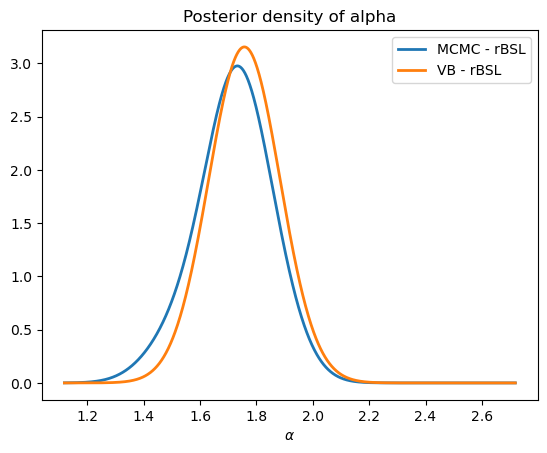

In [37]:
plt.figure()
pos_alpha_mean = np.mean(pos_w[int(num_burnin):,0])
pos_alpha_std = np.std(pos_w[int(num_burnin):,0])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_alpha_mean-6*pos_alpha_std,np.mean(best_alpha)-6*np.std(best_alpha)), max(pos_alpha_mean+10*pos_alpha_std, np.mean(best_alpha)+10*np.std(best_alpha)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.0985, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,0].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.125, kernel='gaussian')
kde_vb.fit(best_alpha.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC - rBSL')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL')

# plt.axvline(x = 1.7, ymin = 0, color = 'black', label = 'True alpha')

plt.legend()
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

Text(0.5, 1.0, 'Posterior density of beta')

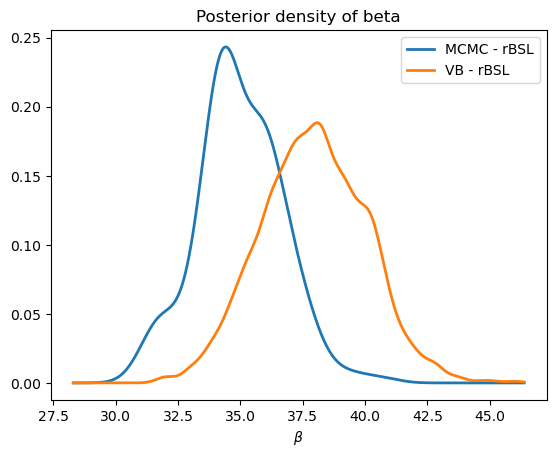

In [44]:
plt.figure()
pos_beta_mean = np.mean(pos_w[int(num_burnin):,1])
pos_beta_std = np.std(pos_w[int(num_burnin):,1])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_beta_mean-4*pos_beta_std,np.mean(best_beta)-4*np.std(best_beta)), max(pos_beta_mean+4*pos_beta_std, np.mean(best_beta)+4*np.std(best_beta)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.65, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,1].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.35, kernel='gaussian')
kde_vb.fit(best_beta.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC - rBSL')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL')

# plt.axvline(x = 35, ymin = 0, color = 'black', label = 'True beta')

plt.legend()
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')


Text(0.5, 1.0, 'Posterior density of gamma')

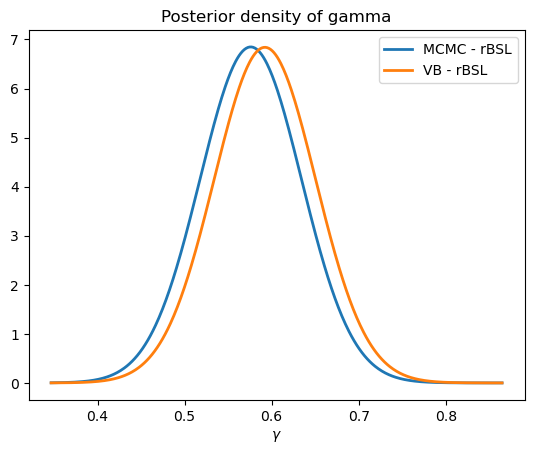

In [43]:
plt.figure()
pos_gamma_mean = np.mean(pos_w[int(num_burnin):,2])
pos_gamma_std = np.std(pos_w[int(num_burnin):,2])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_gamma_mean-12*pos_gamma_std,np.mean(best_gamma)-12*np.std(best_gamma)), max(pos_gamma_mean+14*pos_gamma_std, np.mean(best_gamma)+14*np.std(best_gamma)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.055, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,2].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.055, kernel='gaussian')
kde_vb.fit(best_gamma.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC - rBSL')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL')

# plt.axvline(x = 0.6, ymin = 0, color = 'black', label = 'True gamma')

plt.legend()
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')
 